In [1]:
import h5py
import os
import math
import imageio
import numpy as np
import pandas as pd
from matplotlib.image import imsave
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
from tqdm import tqdm, trange
from glob import glob

In [2]:
# 设置路径
CT_path = "/course75/RealData/CT/"  # 设置CT数据目录
data_path = "./data/slices60/"  # 设置数据存放目录
data_neg_path = data_path+"neg/"  # 0-分类目录，非微乳头数据存放路径
data_pos_path = data_path+"pos/"  # 1-分类目录，微乳头数据存放路径
# 创建目录
for path in [data_neg_path, data_pos_path]:#遍历[data_neg_path, data_pos_path]这个路径列表
    print(path)
    if not os.path.exists(path):#若路径不存在，则调用 os.makedirs() 函数创建目录
        os.makedirs(path)

./data/slices60/neg/
./data/slices60/pos/


## 1.读取数据表


In [3]:
# 读入结节信息
dat = pd.read_csv("/course75/RealData/是否微乳头-给学生_0609.csv",encoding = 'GBK')#读入结节信息的CSV文件
dat = dat.sort_values(by=["ID", "Z"]).reset_index(drop=True)  # 按ID和Z轴位置升序排列
dat.head(10)#展示前10行数据信息

,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,微乳头型,实体型,STAS,胸膜受累,脉管瘤栓,淋巴结转移,flag_1,flag_2,flag_3,flag
0,7,157,222,242-257,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,10,365,375,107-118,左肺,下叶,混杂密度,MIA,NaN,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,13,185,375,97-118,右肺,上叶,纯实性,腺癌,3.0,2.7,...,NaN,主要,无,有,无,无,0,1,0,1
3,16,328,388,238-252,左肺,下叶,部分实性,粘液腺癌,1.0,0.9,...,NaN,NaN,无,无,无,无,0,0,0,0
4,17,145,328,93-114,右肺,上叶,部分实性,腺癌,1.0,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [4]:
datflag = dat.dropna(axis=0,subset=['flag'],inplace=False)#删flag列为空值的行修改原数据的副本形成新数据
# 提取切片depth维度和结节对应的切片张数
datflag["Zrange"] = datflag["Z"].apply(lambda x: sorted(map(lambda y: int(y)-1, x.split("-"))))  # 索引起点归0,例：242-257→[241,256]
datflag["Zmed"] = datflag["Zrange"].apply(lambda x: int((x[1]+x[0])/2))  # 计算中心切片位置
datflag["slices"] = datflag["Zrange"].apply(lambda x: x[1]-x[0]+1)  # 计算结节切片数
# 设置结节编号，从0开始计数
datflag["nID"] = datflag.index
datflag

,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,脉管瘤栓,淋巴结转移,flag_1,flag_2,flag_3,flag,Zrange,Zmed,slices,nID
0,7,157,222,242-257,右肺,中叶,纯磨玻璃,MIA,NaN,1.50,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
1,10,365,375,107-118,左肺,下叶,混杂密度,MIA,NaN,0.80,...,NaN,NaN,0,0,0,0,"[106, 117]",111,12,1
2,13,185,375,97-118,右肺,上叶,纯实性,腺癌,3.0,2.70,...,无,无,0,1,0,1,"[96, 117]",106,22,2
3,16,328,388,238-252,左肺,下叶,部分实性,粘液腺癌,1.0,0.90,...,无,无,0,0,0,0,"[237, 251]",244,15,3
4,17,145,328,93-114,右肺,上叶,部分实性,腺癌,1.0,1.20,...,NaN,NaN,0,0,0,0,"[92, 113]",102,22,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,629,149,311,145-168,右肺,下叶,纯实性,腺癌,2.0,3.70,...,有,无,1,0,0,1,"[144, 167]",155,24,478
479,630,352,322,226-238,左肺,下叶,纯实性,腺癌,2.0,0.85,...,无,无,0,0,0,0,"[225, 237]",231,13,479
480,631,109,362,204-218,右肺,下叶,纯磨玻璃,MIA,NaN,1.28,...,NaN,NaN,0,0,0,0,"[203, 217]",210,15,480
481,632,293,291,16-29,左肺,上叶,纯实性,腺癌,3.0,1.30,...,有,无,1,1,0,1,"[15, 28]",21,14,481


In [5]:
#结节中微乳头和非微乳头的数量
datflag["flag"].value_counts()

0    344
1    139
Name: flag, dtype: int64

In [6]:
# 保存整理好的数据表
datflag.to_csv('csv/是否微乳头_483.csv',index = False, mode="w+")
print(f"共有{len(datflag)}行数据")

共有483行数据


## 2.读取CT并切片存储


### 切片

对每个结节取[60\*60]切片，不同结节会得到不同张数的切片

In [9]:
# 读入CT数据
ID_list = datflag["ID"].unique().tolist()  # 病人ID列表
# ID_list = [205,234,206,20,162,115,179,40,169,137,98,186,82,47]  # 一些直径大于30mm或结节切片数多于60张的病人ID
print(f"共有{len(ID_list)}个病人的结节信息！")
for ID in tqdm(ID_list):  # 按ID读取CT
    print(f"第{str(ID)}号患者CT：")
    file_path = os.path.join(CT_path, str(ID))
    img_array = imageio.volread(file_path, "DICOM") # 直接读取文件夹中的所有dicom文件为vol，返回的是HU值
    # 获取meta数据，像素间隔
    spacing = img_array.meta["sampling"] # 注意是zyx顺序  
    depth, height, width = img_array.shape  # D,H,W
    print(f"CT大小：{img_array.shape}，spacing：{spacing}")
    
    # 【可选】制作肺部mask，暂未实现
    lung_mask = img_array
        
    # 预处理，对提取出的肺部mask设置WL，归一化
    max_num = 400  # 阈值最高
    min_num = -1400  # 阈值最低
    new_img = (lung_mask - min_num) / (max_num - min_num)  # 归一化
    new_img[new_img > 1] = 1.  # 高于1的归1，float格式
    new_img[new_img < 0] = 0.  # 低于0的归0，float格式
    img = new_img - 0.25  # 去均值

    SIZE = 60  # 切片size
    radius = int(SIZE/2)  # 向下取整
    # 遍历病人的每个结节
    df_node = datflag[datflag["ID"] == ID].reset_index(drop=True) ##重置索引
    for j in range(df_node.shape[0]):  # 可能一位患者有多个结节，遍历多个结节
        print(f"第{str(ID)}号患者的第{j}个结节：")
        # 提取结节信息
        node_x = df_node["X"][j]  # width,x : 0-max
        node_y = df_node["Y"][j]  # height,y : 0-max
        node_z = df_node["Zrange"][j]  # depth,z轴范围 : 0-max
        diam = df_node["Size.cm."][j] * 10  # 结节直径mm
        flag = df_node["flag"][j]  # 是否为微乳头型
        nID = df_node["nID"][j]  # 结节No
        # 遍历每个z保存切片
        for s in range(node_z[0],node_z[1]+1):
            save_slice = img[s, (node_y-radius):(node_y+radius), (node_x-radius):(node_x+radius)]  # 取对应zyx的切片
#             print(f"保存大小：{save_slice.shape}")
            save_name = "nID_{}, ID_{}, X_{}, Y_{}, Z_{}({}-{}), diam_{:.3g}, flag_{}.npy".format(
                nID, ID, node_x, node_y, s, node_z[0], node_z[1], diam, flag)
#             print(f"保存文件名：{save_name}")
            if flag == 1:  # 保存切片
                np.save(os.path.join(data_pos_path, save_name), save_slice)
            else:
                np.save(os.path.join(data_neg_path, save_name), save_slice)

共有426个病人的结节信息！


  0%|          | 0/426 [00:00<?, ?it/s]

第7号患者CT：
Reading DICOM (examining files): 1/505 files (0.210/505 files (2.0%19/505 files (3.8%27/505 files (5.3%37/505 files (7.3%47/505 files (9.3%56/505 files (11.166/505 files (13.176/505 files (15.085/505 files (16.894/505 files (18.6104/505 files (20.6%114/505 files (22.6%124/505 files (24.6%134/505 files (26.5%143/505 files (28.3%151/505 files (29.9%161/505 files (31.9%171/505 files (33.9%180/505 files (35.6%188/505 files (37.2%197/505 files (39.0%206/505 files (40.8%216/505 files (42.8%226/505 files (44.8%235/505 files (46.5%244/505 files (48.3%253/505 files (50.1%262/505 files (51.9%270/505 files (53.5%279/505 files (55.2%289/505 files (57.2%298/505 files (59.0%308/505 files (61.0%318/505 files (63.0%327/505 files (64.8%336/505 files (66.5%345/505 files (68.3%355/505 files (70.3%365/505 files (72.3%373/505 files (73.9%382/505 files (75.6%392/505 files (77.6%402/505 files (79.6%411/505 files (81.4%422/505 files (83.6%432/505 files (85.5%442/505 files (87.5%451/505 files (89.3%46

  0%|          | 1/426 [00:11<1:19:52, 11.28s/it]

第7号患者的第0个结节：
第10号患者CT：
Reading DICOM (examining files): 1/308 files (0.39/308 files (2.918/308 files (5.8%27/308 files (8.8%37/308 files (12.046/308 files (14.955/308 files (17.964/308 files (20.874/308 files (24.083/308 files (26.991/308 files (29.5101/308 files (32.8%110/308 files (35.7%119/308 files (38.6%128/308 files (41.6%138/308 files (44.8%148/308 files (48.1%157/308 files (51.0%166/308 files (53.9%176/308 files (57.1%184/308 files (59.7%193/308 files (62.7%200/308 files (64.9%209/308 files (67.9%219/308 files (71.1%229/308 files (74.4%238/308 files (77.3%246/308 files (79.9%256/308 files (83.1%266/308 files (86.4%274/308 files (89.0%284/308 files (92.2%293/308 files (95.1%302/308 files (98.1%308/308 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 15/308  (4.931/308  (10.1%46/308  (14.9%62/308  (20.1%77/308  (25.0%91/308  (29.5%106/308  (34.4122/308  (39.6137/308  (44.5153/308  (49.7169/308  (54.9185/308  (60.1201/308  (65.3215/308  (69.8234/308  (76.0248

  0%|          | 2/426 [00:17<59:19,  8.40s/it]  

第10号患者的第0个结节：
第13号患者CT：
Reading DICOM (examining files): 1/422 files (0.210/422 files (2.4%19/422 files (4.5%29/422 files (6.9%39/422 files (9.2%49/422 files (11.660/422 files (14.270/422 files (16.680/422 files (19.090/422 files (21.399/422 files (23.5108/422 files (25.6%118/422 files (28.0%128/422 files (30.3%138/422 files (32.7%148/422 files (35.1%158/422 files (37.4%168/422 files (39.8%178/422 files (42.2%189/422 files (44.8%198/422 files (46.9%207/422 files (49.1%216/422 files (51.2%225/422 files (53.3%235/422 files (55.7%244/422 files (57.8%254/422 files (60.2%263/422 files (62.3%271/422 files (64.2%280/422 files (66.4%289/422 files (68.5%299/422 files (70.9%309/422 files (73.2%318/422 files (75.4%329/422 files (78.0%339/422 files (80.3%348/422 files (82.5%357/422 files (84.6%366/422 files (86.7%376/422 files (89.1%386/422 files (91.5%396/422 files (93.8%406/422 files (96.2%415/422 files (98.3%422/422 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/422  

  1%|          | 3/426 [00:26<1:01:46,  8.76s/it]

第13号患者的第0个结节：
第16号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%29/449 files (6.5%39/449 files (8.7%49/449 files (10.959/449 files (13.170/449 files (15.680/449 files (17.889/449 files (19.899/449 files (22.0109/449 files (24.3%117/449 files (26.1%127/449 files (28.3%135/449 files (30.1%145/449 files (32.3%155/449 files (34.5%165/449 files (36.7%174/449 files (38.8%184/449 files (41.0%193/449 files (43.0%201/449 files (44.8%210/449 files (46.8%220/449 files (49.0%229/449 files (51.0%239/449 files (53.2%250/449 files (55.7%260/449 files (57.9%270/449 files (60.1%279/449 files (62.1%288/449 files (64.1%297/449 files (66.1%306/449 files (68.2%316/449 files (70.4%326/449 files (72.6%334/449 files (74.4%344/449 files (76.6%354/449 files (78.8%364/449 files (81.1%374/449 files (83.3%384/449 files (85.5%393/449 files (87.5%403/449 files (89.8%413/449 files (92.0%423/449 files (94.2%432/449 files (96.2%441/449 files (98.2%449/449 files (100.0%)
  Fo

  1%|          | 4/426 [00:36<1:04:38,  9.19s/it]

第16号患者的第0个结节：
第17号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%21/449 files (4.7%31/449 files (6.9%40/449 files (8.9%51/449 files (11.461/449 files (13.670/449 files (15.680/449 files (17.890/449 files (20.099/449 files (22.0108/449 files (24.1%117/449 files (26.1%127/449 files (28.3%136/449 files (30.3%145/449 files (32.3%154/449 files (34.3%164/449 files (36.5%174/449 files (38.8%183/449 files (40.8%191/449 files (42.5%200/449 files (44.5%209/449 files (46.5%220/449 files (49.0%229/449 files (51.0%239/449 files (53.2%248/449 files (55.2%258/449 files (57.5%267/449 files (59.5%277/449 files (61.7%287/449 files (63.9%296/449 files (65.9%306/449 files (68.2%316/449 files (70.4%324/449 files (72.2%333/449 files (74.2%343/449 files (76.4%353/449 files (78.6%363/449 files (80.8%372/449 files (82.9%381/449 files (84.9%390/449 files (86.9%399/449 files (88.9%408/449 files (90.9%417/449 files (92.9%427/449 files (95.1%436/449 files (97.1%445/449 files (99.1%449/449

  1%|          | 5/426 [00:46<1:06:23,  9.46s/it]

第17号患者的第0个结节：
第18号患者CT：
Reading DICOM (examining files): 1/416 files (0.210/416 files (2.4%19/416 files (4.6%29/416 files (7.0%37/416 files (8.9%46/416 files (11.156/416 files (13.565/416 files (15.675/416 files (18.085/416 files (20.494/416 files (22.6104/416 files (25.0%113/416 files (27.2%123/416 files (29.6%133/416 files (32.0%142/416 files (34.1%151/416 files (36.3%160/416 files (38.5%170/416 files (40.9%180/416 files (43.3%189/416 files (45.4%198/416 files (47.6%207/416 files (49.8%216/416 files (51.9%225/416 files (54.1%233/416 files (56.0%242/416 files (58.2%251/416 files (60.3%261/416 files (62.7%270/416 files (64.9%277/416 files (66.6%287/416 files (69.0%295/416 files (70.9%304/416 files (73.1%313/416 files (75.2%322/416 files (77.4%332/416 files (79.8%342/416 files (82.2%351/416 files (84.4%361/416 files (86.8%371/416 files (89.2%380/416 files (91.3%389/416 files (93.5%399/416 files (95.9%409/416 files (98.3%416/416 files (100.0%)
  Found 1 correct series.
Reading DICOM (loa

  1%|▏         | 6/426 [00:56<1:06:06,  9.44s/it]

第19号患者CT：
Reading DICOM (examining files): 1/505 files (0.212/505 files (2.4%22/505 files (4.4%31/505 files (6.1%42/505 files (8.3%53/505 files (10.562/505 files (12.372/505 files (14.382/505 files (16.291/505 files (18.0101/505 files (20.0%110/505 files (21.8%120/505 files (23.8%130/505 files (25.7%140/505 files (27.7%150/505 files (29.7%160/505 files (31.7%171/505 files (33.9%180/505 files (35.6%190/505 files (37.6%199/505 files (39.4%210/505 files (41.6%221/505 files (43.8%230/505 files (45.5%240/505 files (47.5%249/505 files (49.3%259/505 files (51.3%269/505 files (53.3%277/505 files (54.9%286/505 files (56.6%295/505 files (58.4%305/505 files (60.4%314/505 files (62.2%324/505 files (64.2%335/505 files (66.3%346/505 files (68.5%356/505 files (70.5%366/505 files (72.5%376/505 files (74.5%386/505 files (76.4%395/505 files (78.2%405/505 files (80.2%414/505 files (82.0%425/505 files (84.2%436/505 files (86.3%446/505 files (88.3%456/505 files (90.3%466/505 files (92.3%476/505 files (94.3

  2%|▏         | 7/426 [01:07<1:10:30, 10.10s/it]

第19号患者的第0个结节：
第20号患者CT：
Reading DICOM (examining files): 1/545 files (0.211/545 files (2.0%21/545 files (3.9%32/545 files (5.9%42/545 files (7.7%55/545 files (10.165/545 files (11.975/545 files (13.883/545 files (15.293/545 files (17.1103/545 files (18.9%113/545 files (20.7%124/545 files (22.8%135/545 files (24.8%145/545 files (26.6%157/545 files (28.8%165/545 files (30.3%171/545 files (31.4%179/545 files (32.8%193/545 files (35.4%203/545 files (37.2%214/545 files (39.3%225/545 files (41.3%237/545 files (43.5%247/545 files (45.3%257/545 files (47.2%268/545 files (49.2%279/545 files (51.2%290/545 files (53.2%300/545 files (55.0%310/545 files (56.9%320/545 files (58.7%329/545 files (60.4%339/545 files (62.2%347/545 files (63.7%358/545 files (65.7%369/545 files (67.7%381/545 files (69.9%391/545 files (71.7%402/545 files (73.8%413/545 files (75.8%422/545 files (77.4%433/545 files (79.4%444/545 files (81.5%455/545 files (83.5%466/545 files (85.5%478/545 files (87.7%488/545 files (89.5%497/5

  2%|▏         | 8/426 [01:20<1:16:02, 10.92s/it]

第21号患者CT：
Reading DICOM (examining files): 1/473 files (0.29/473 files (1.918/473 files (3.8%26/473 files (5.5%35/473 files (7.4%44/473 files (9.3%52/473 files (11.062/473 files (13.171/473 files (15.081/473 files (17.190/473 files (19.0100/473 files (21.1%110/473 files (23.3%119/473 files (25.2%127/473 files (26.8%135/473 files (28.5%144/473 files (30.4%153/473 files (32.3%163/473 files (34.5%173/473 files (36.6%182/473 files (38.5%192/473 files (40.6%202/473 files (42.7%211/473 files (44.6%220/473 files (46.5%230/473 files (48.6%238/473 files (50.3%247/473 files (52.2%256/473 files (54.1%265/473 files (56.0%274/473 files (57.9%283/473 files (59.8%292/473 files (61.7%301/473 files (63.6%310/473 files (65.5%319/473 files (67.4%328/473 files (69.3%337/473 files (71.2%346/473 files (73.2%355/473 files (75.1%365/473 files (77.2%375/473 files (79.3%384/473 files (81.2%393/473 files (83.1%401/473 files (84.8%411/473 files (86.9%420/473 files (88.8%430/473 files (90.9%439/473 files (92.8%448

  2%|▏         | 9/426 [01:30<1:15:16, 10.83s/it]

第21号患者的第0个结节：
第22号患者CT：
Reading DICOM (examining files): 1/480 files (0.214/480 files (2.9%24/480 files (5.0%35/480 files (7.3%48/480 files (10.060/480 files (12.573/480 files (15.285/480 files (17.797/480 files (20.2112/480 files (23.3%122/480 files (25.4%135/480 files (28.1%146/480 files (30.4%157/480 files (32.7%169/480 files (35.2%182/480 files (37.9%192/480 files (40.0%205/480 files (42.7%218/480 files (45.4%230/480 files (47.9%240/480 files (50.0%251/480 files (52.3%263/480 files (54.8%275/480 files (57.3%287/480 files (59.8%299/480 files (62.3%310/480 files (64.6%321/480 files (66.9%333/480 files (69.4%346/480 files (72.1%358/480 files (74.6%368/480 files (76.7%378/480 files (78.8%391/480 files (81.5%402/480 files (83.8%416/480 files (86.7%427/480 files (89.0%439/480 files (91.5%451/480 files (94.0%464/480 files (96.7%476/480 files (99.2%480/480 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/480  (2.121/480  (4.431/480  (6.542/480  (8.853/480  (11.0%63

  2%|▏         | 10/426 [01:40<1:12:17, 10.43s/it]

第22号患者的第0个结节：
第26号患者CT：
Reading DICOM (examining files): 1/237 files (0.413/237 files (5.5%23/237 files (9.7%33/237 files (13.943/237 files (18.154/237 files (22.864/237 files (27.074/237 files (31.287/237 files (36.796/237 files (40.5107/237 files (45.1%118/237 files (49.8%129/237 files (54.4%140/237 files (59.1%153/237 files (64.6%165/237 files (69.6%174/237 files (73.4%183/237 files (77.2%193/237 files (81.4%203/237 files (85.7%213/237 files (89.9%224/237 files (94.5%234/237 files (98.7%237/237 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/237  (4.225/237  (10.5%42/237  (17.7%56/237  (23.6%72/237  (30.4%89/237  (37.6%104/237  (43.9117/237  (49.4131/237  (55.3146/237  (61.6159/237  (67.1174/237  (73.4188/237  (79.3198/237  (83.5208/237  (87.8218/237  (92.0228/237  (96.2236/237  (99.6237/237  (100.0%)
CT大小：(237, 512, 512)，spacing：(1.25, 0.703125, 0.703125)


  3%|▎         | 11/426 [01:45<1:00:22,  8.73s/it]

第26号患者的第0个结节：
第27号患者CT：
Reading DICOM (examining files): 1/474 files (0.210/474 files (2.1%19/474 files (4.0%29/474 files (6.1%37/474 files (7.8%47/474 files (9.9%58/474 files (12.269/474 files (14.679/474 files (16.789/474 files (18.898/474 files (20.7107/474 files (22.6%116/474 files (24.5%125/474 files (26.4%134/474 files (28.3%143/474 files (30.2%152/474 files (32.1%162/474 files (34.2%172/474 files (36.3%182/474 files (38.4%192/474 files (40.5%201/474 files (42.4%211/474 files (44.5%220/474 files (46.4%229/474 files (48.3%237/474 files (50.0%246/474 files (51.9%255/474 files (53.8%263/474 files (55.5%273/474 files (57.6%281/474 files (59.3%290/474 files (61.2%300/474 files (63.3%309/474 files (65.2%318/474 files (67.1%327/474 files (69.0%336/474 files (70.9%346/474 files (73.0%356/474 files (75.1%365/474 files (77.0%374/474 files (78.9%383/474 files (80.8%393/474 files (82.9%397/474 files (83.8%406/474 files (85.7%416/474 files (87.8%425/474 files (89.7%435/474 files (91.8%444/474

  3%|▎         | 12/426 [01:56<1:04:59,  9.42s/it]

第29号患者CT：
Reading DICOM (examining files): 1/233 files (0.411/233 files (4.7%20/233 files (8.6%30/233 files (12.939/233 files (16.748/233 files (20.658/233 files (24.968/233 files (29.278/233 files (33.587/233 files (37.396/233 files (41.2106/233 files (45.5%113/233 files (48.5%123/233 files (52.8%132/233 files (56.7%142/233 files (60.9%151/233 files (64.8%161/233 files (69.1%170/233 files (73.0%179/233 files (76.8%189/233 files (81.1%199/233 files (85.4%209/233 files (89.7%217/233 files (93.1%227/233 files (97.4%233/233 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/233  (6.030/233  (12.9%45/233  (19.3%59/233  (25.3%73/233  (31.3%88/233  (37.8%103/233  (44.2120/233  (51.5134/233  (57.5148/233  (63.5163/233  (70.0178/233  (76.4192/233  (82.4207/233  (88.8220/233  (94.4233/233  (100.0%)
CT大小：(233, 512, 512)，spacing：(1.25, 0.623047, 0.623047)


  3%|▎         | 13/426 [02:01<55:57,  8.13s/it]  

第29号患者的第0个结节：
第29号患者的第1个结节：
第30号患者CT：
Reading DICOM (examining files): 1/576 files (0.210/576 files (1.7%21/576 files (3.6%30/576 files (5.2%40/576 files (6.9%50/576 files (8.7%60/576 files (10.470/576 files (12.280/576 files (13.990/576 files (15.6100/576 files (17.4%110/576 files (19.1%119/576 files (20.7%129/576 files (22.4%139/576 files (24.1%148/576 files (25.7%157/576 files (27.3%167/576 files (29.0%177/576 files (30.7%187/576 files (32.5%197/576 files (34.2%208/576 files (36.1%218/576 files (37.8%227/576 files (39.4%237/576 files (41.1%247/576 files (42.9%255/576 files (44.3%265/576 files (46.0%275/576 files (47.7%285/576 files (49.5%294/576 files (51.0%304/576 files (52.8%313/576 files (54.3%322/576 files (55.9%331/576 files (57.5%341/576 files (59.2%351/576 files (60.9%361/576 files (62.7%370/576 files (64.2%380/576 files (66.0%389/576 files (67.5%399/576 files (69.3%409/576 files (71.0%418/576 files (72.6%427/576 files (74.1%436/576 files (75.7%446/576 files (77.4%455/576 fil

  3%|▎         | 14/426 [02:14<1:06:14,  9.65s/it]

第30号患者的第0个结节：
第31号患者CT：
Reading DICOM (examining files): 1/476 files (0.210/476 files (2.1%20/476 files (4.2%29/476 files (6.1%38/476 files (8.0%47/476 files (9.9%54/476 files (11.363/476 files (13.273/476 files (15.383/476 files (17.492/476 files (19.3101/476 files (21.2%110/476 files (23.1%118/476 files (24.8%128/476 files (26.9%138/476 files (29.0%148/476 files (31.1%159/476 files (33.4%169/476 files (35.5%179/476 files (37.6%187/476 files (39.3%197/476 files (41.4%206/476 files (43.3%215/476 files (45.2%225/476 files (47.3%235/476 files (49.4%244/476 files (51.3%255/476 files (53.6%265/476 files (55.7%273/476 files (57.4%283/476 files (59.5%292/476 files (61.3%302/476 files (63.4%311/476 files (65.3%320/476 files (67.2%329/476 files (69.1%338/476 files (71.0%348/476 files (73.1%357/476 files (75.0%367/476 files (77.1%376/476 files (79.0%385/476 files (80.9%394/476 files (82.8%403/476 files (84.7%412/476 files (86.6%421/476 files (88.4%431/476 files (90.5%440/476 files (92.4%449/476

  4%|▎         | 15/426 [02:25<1:08:59, 10.07s/it]

第32号患者CT：
Reading DICOM (examining files): 1/494 files (0.211/494 files (2.2%21/494 files (4.3%29/494 files (5.9%39/494 files (7.9%48/494 files (9.7%58/494 files (11.766/494 files (13.476/494 files (15.486/494 files (17.496/494 files (19.4106/494 files (21.5%116/494 files (23.5%124/494 files (25.1%134/494 files (27.1%143/494 files (28.9%154/494 files (31.2%164/494 files (33.2%174/494 files (35.2%183/494 files (37.0%192/494 files (38.9%202/494 files (40.9%211/494 files (42.7%221/494 files (44.7%231/494 files (46.8%241/494 files (48.8%250/494 files (50.6%258/494 files (52.2%269/494 files (54.5%278/494 files (56.3%288/494 files (58.3%297/494 files (60.1%306/494 files (61.9%315/494 files (63.8%324/494 files (65.6%334/494 files (67.6%344/494 files (69.6%353/494 files (71.5%361/494 files (73.1%370/494 files (74.9%380/494 files (76.9%389/494 files (78.7%399/494 files (80.8%406/494 files (82.2%416/494 files (84.2%425/494 files (86.0%434/494 files (87.9%444/494 files (89.9%453/494 files (91.7%4

  4%|▍         | 16/426 [02:37<1:11:45, 10.50s/it]

第33号患者CT：
Reading DICOM (examining files): 1/419 files (0.210/419 files (2.4%19/419 files (4.5%28/419 files (6.7%38/419 files (9.1%48/419 files (11.557/419 files (13.666/419 files (15.875/419 files (17.985/419 files (20.395/419 files (22.7104/419 files (24.8%113/419 files (27.0%122/419 files (29.1%132/419 files (31.5%141/419 files (33.7%150/419 files (35.8%159/419 files (37.9%168/419 files (40.1%178/419 files (42.5%188/419 files (44.9%198/419 files (47.3%206/419 files (49.2%216/419 files (51.6%225/419 files (53.7%234/419 files (55.8%244/419 files (58.2%253/419 files (60.4%262/419 files (62.5%271/419 files (64.7%280/419 files (66.8%290/419 files (69.2%299/419 files (71.4%309/419 files (73.7%319/419 files (76.1%327/419 files (78.0%337/419 files (80.4%346/419 files (82.6%356/419 files (85.0%364/419 files (86.9%374/419 files (89.3%383/419 files (91.4%392/419 files (93.6%402/419 files (95.9%409/419 files (97.6%418/419 files (99.8%419/419 files (100.0%)
  Found 1 correct series.
Reading DICO

  4%|▍         | 17/426 [02:46<1:09:09, 10.15s/it]

第35号患者CT：
Reading DICOM (examining files): 1/390 files (0.310/390 files (2.6%20/390 files (5.1%29/390 files (7.4%39/390 files (10.048/390 files (12.356/390 files (14.465/390 files (16.775/390 files (19.284/390 files (21.593/390 files (23.8101/390 files (25.9%111/390 files (28.5%121/390 files (31.0%132/390 files (33.8%141/390 files (36.2%151/390 files (38.7%160/390 files (41.0%169/390 files (43.3%178/390 files (45.6%188/390 files (48.2%196/390 files (50.3%205/390 files (52.6%214/390 files (54.9%224/390 files (57.4%233/390 files (59.7%242/390 files (62.1%251/390 files (64.4%261/390 files (66.9%270/390 files (69.2%279/390 files (71.5%288/390 files (73.8%296/390 files (75.9%305/390 files (78.2%315/390 files (80.8%325/390 files (83.3%335/390 files (85.9%344/390 files (88.2%354/390 files (90.8%363/390 files (93.1%373/390 files (95.6%383/390 files (98.2%390/390 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/390  (3.631/390  (7.946/390  (11.8%59/390  (15.1%74/390  (1

  4%|▍         | 18/426 [02:54<1:04:54,  9.55s/it]

第35号患者的第0个结节：
第37号患者CT：
Reading DICOM (examining files): 1/257 files (0.410/257 files (3.9%18/257 files (7.0%27/257 files (10.536/257 files (14.045/257 files (17.555/257 files (21.465/257 files (25.375/257 files (29.285/257 files (33.195/257 files (37.0104/257 files (40.5%114/257 files (44.4%123/257 files (47.9%134/257 files (52.1%143/257 files (55.6%151/257 files (58.8%161/257 files (62.6%172/257 files (66.9%183/257 files (71.2%194/257 files (75.5%203/257 files (79.0%213/257 files (82.9%223/257 files (86.8%233/257 files (90.7%243/257 files (94.6%253/257 files (98.4%257/257 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/257  (5.127/257  (10.5%43/257  (16.7%56/257  (21.8%71/257  (27.6%86/257  (33.5%99/257  (38.5%112/257  (43.6127/257  (49.4143/257  (55.6157/257  (61.1172/257  (66.9188/257  (73.2204/257  (79.4221/257  (86.0235/257  (91.4252/257  (98.1257/257  (100.0%)
CT大小：(257, 512, 512)，spacing：(1.25, 0.703125, 0.703125)
第37号患者的第0个结节：
第37号患者的第1个结节：


  4%|▍         | 19/426 [03:00<56:56,  8.39s/it]  

第39号患者CT：
Reading DICOM (examining files): 1/537 files (0.210/537 files (1.9%19/537 files (3.5%28/537 files (5.2%38/537 files (7.1%48/537 files (8.9%57/537 files (10.667/537 files (12.577/537 files (14.387/537 files (16.296/537 files (17.9106/537 files (19.7%115/537 files (21.4%125/537 files (23.3%135/537 files (25.1%144/537 files (26.8%152/537 files (28.3%163/537 files (30.4%173/537 files (32.2%182/537 files (33.9%192/537 files (35.8%201/537 files (37.4%211/537 files (39.3%221/537 files (41.2%231/537 files (43.0%240/537 files (44.7%250/537 files (46.6%260/537 files (48.4%269/537 files (50.1%279/537 files (52.0%289/537 files (53.8%299/537 files (55.7%309/537 files (57.5%317/537 files (59.0%327/537 files (60.9%337/537 files (62.8%346/537 files (64.4%356/537 files (66.3%367/537 files (68.3%377/537 files (70.2%387/537 files (72.1%396/537 files (73.7%405/537 files (75.4%416/537 files (77.5%425/537 files (79.1%435/537 files (81.0%445/537 files (82.9%455/537 files (84.7%466/537 files (86.8%4

  5%|▍         | 20/426 [03:12<1:04:06,  9.47s/it]

第40号患者CT：
Reading DICOM (examining files): 1/504 files (0.212/504 files (2.4%22/504 files (4.4%32/504 files (6.3%42/504 files (8.3%53/504 files (10.564/504 files (12.774/504 files (14.784/504 files (16.795/504 files (18.8105/504 files (20.8%114/504 files (22.6%124/504 files (24.6%135/504 files (26.8%145/504 files (28.8%155/504 files (30.8%166/504 files (32.9%175/504 files (34.7%185/504 files (36.7%195/504 files (38.7%205/504 files (40.7%215/504 files (42.7%225/504 files (44.6%236/504 files (46.8%246/504 files (48.8%257/504 files (51.0%268/504 files (53.2%278/504 files (55.2%288/504 files (57.1%299/504 files (59.3%309/504 files (61.3%320/504 files (63.5%330/504 files (65.5%340/504 files (67.5%352/504 files (69.8%364/504 files (72.2%375/504 files (74.4%386/504 files (76.6%396/504 files (78.6%406/504 files (80.6%416/504 files (82.5%426/504 files (84.5%436/504 files (86.5%446/504 files (88.5%456/504 files (90.5%467/504 files (92.7%478/504 files (94.8%489/504 files (97.0%499/504 files (99.0

  5%|▍         | 21/426 [03:23<1:07:48, 10.05s/it]

第42号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%20/480 files (4.2%30/480 files (6.2%39/480 files (8.1%48/480 files (10.058/480 files (12.166/480 files (13.876/480 files (15.884/480 files (17.593/480 files (19.4101/480 files (21.0%109/480 files (22.7%118/480 files (24.6%128/480 files (26.7%137/480 files (28.5%147/480 files (30.6%157/480 files (32.7%166/480 files (34.6%175/480 files (36.5%184/480 files (38.3%194/480 files (40.4%204/480 files (42.5%213/480 files (44.4%222/480 files (46.2%232/480 files (48.3%242/480 files (50.4%253/480 files (52.7%263/480 files (54.8%273/480 files (56.9%283/480 files (59.0%291/480 files (60.6%301/480 files (62.7%311/480 files (64.8%320/480 files (66.7%329/480 files (68.5%338/480 files (70.4%347/480 files (72.3%357/480 files (74.4%365/480 files (76.0%374/480 files (77.9%383/480 files (79.8%393/480 files (81.9%403/480 files (84.0%412/480 files (85.8%421/480 files (87.7%431/480 files (89.8%441/480 files (91.9%450/480 files (93.8%4

  5%|▌         | 22/426 [03:34<1:09:26, 10.31s/it]

第42号患者的第0个结节：
第44号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%19/480 files (4.0%28/480 files (5.8%37/480 files (7.7%46/480 files (9.6%56/480 files (11.765/480 files (13.573/480 files (15.282/480 files (17.193/480 files (19.4103/480 files (21.5%112/480 files (23.3%122/480 files (25.4%131/480 files (27.3%141/480 files (29.4%150/480 files (31.2%158/480 files (32.9%168/480 files (35.0%178/480 files (37.1%187/480 files (39.0%197/480 files (41.0%206/480 files (42.9%215/480 files (44.8%225/480 files (46.9%234/480 files (48.8%245/480 files (51.0%256/480 files (53.3%264/480 files (55.0%274/480 files (57.1%283/480 files (59.0%293/480 files (61.0%302/480 files (62.9%311/480 files (64.8%319/480 files (66.5%329/480 files (68.5%339/480 files (70.6%349/480 files (72.7%358/480 files (74.6%369/480 files (76.9%378/480 files (78.8%387/480 files (80.6%397/480 files (82.7%406/480 files (84.6%415/480 files (86.5%424/480 files (88.3%434/480 files (90.4%441/480 files (91.9%450/480

  5%|▌         | 23/426 [03:45<1:10:40, 10.52s/it]

第44号患者的第0个结节：
第47号患者CT：
Reading DICOM (examining files): 1/552 files (0.211/552 files (2.0%20/552 files (3.6%29/552 files (5.3%39/552 files (7.1%49/552 files (8.9%59/552 files (10.770/552 files (12.779/552 files (14.389/552 files (16.199/552 files (17.9108/552 files (19.6%117/552 files (21.2%127/552 files (23.0%136/552 files (24.6%146/552 files (26.4%155/552 files (28.1%164/552 files (29.7%173/552 files (31.3%183/552 files (33.2%191/552 files (34.6%201/552 files (36.4%211/552 files (38.2%220/552 files (39.9%229/552 files (41.5%238/552 files (43.1%248/552 files (44.9%257/552 files (46.6%267/552 files (48.4%277/552 files (50.2%287/552 files (52.0%297/552 files (53.8%307/552 files (55.6%316/552 files (57.2%326/552 files (59.1%335/552 files (60.7%345/552 files (62.5%353/552 files (63.9%360/552 files (65.2%370/552 files (67.0%379/552 files (68.7%389/552 files (70.5%398/552 files (72.1%408/552 files (73.9%417/552 files (75.5%426/552 files (77.2%435/552 files (78.8%444/552 files (80.4%453/552

  6%|▌         | 24/426 [03:58<1:15:36, 11.29s/it]

第48号患者CT：
Reading DICOM (examining files): 1/480 files (0.213/480 files (2.7%22/480 files (4.6%33/480 files (6.9%45/480 files (9.4%56/480 files (11.768/480 files (14.279/480 files (16.590/480 files (18.8102/480 files (21.2%113/480 files (23.5%124/480 files (25.8%131/480 files (27.3%143/480 files (29.8%154/480 files (32.1%166/480 files (34.6%180/480 files (37.5%190/480 files (39.6%202/480 files (42.1%214/480 files (44.6%226/480 files (47.1%239/480 files (49.8%250/480 files (52.1%262/480 files (54.6%273/480 files (56.9%285/480 files (59.4%296/480 files (61.7%308/480 files (64.2%318/480 files (66.2%331/480 files (69.0%344/480 files (71.7%356/480 files (74.2%367/480 files (76.5%379/480 files (79.0%392/480 files (81.7%404/480 files (84.2%417/480 files (86.9%430/480 files (89.6%442/480 files (92.1%453/480 files (94.4%466/480 files (97.1%477/480 files (99.4%480/480 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/480  (2.121/480  (4.433/480  (6.944/480  (9.255/480  (1

  6%|▌         | 25/426 [04:08<1:12:17, 10.82s/it]

第51号患者CT：
Reading DICOM (examining files): 1/473 files (0.211/473 files (2.3%21/473 files (4.4%31/473 files (6.6%40/473 files (8.5%49/473 files (10.459/473 files (12.570/473 files (14.880/473 files (16.991/473 files (19.2100/473 files (21.1%109/473 files (23.0%118/473 files (24.9%129/473 files (27.3%139/473 files (29.4%148/473 files (31.3%159/473 files (33.6%169/473 files (35.7%179/473 files (37.8%190/473 files (40.2%200/473 files (42.3%209/473 files (44.2%217/473 files (45.9%227/473 files (48.0%238/473 files (50.3%249/473 files (52.6%259/473 files (54.8%269/473 files (56.9%279/473 files (59.0%290/473 files (61.3%300/473 files (63.4%310/473 files (65.5%319/473 files (67.4%329/473 files (69.6%339/473 files (71.7%348/473 files (73.6%358/473 files (75.7%368/473 files (77.8%379/473 files (80.1%391/473 files (82.7%401/473 files (84.8%412/473 files (87.1%422/473 files (89.2%431/473 files (91.1%441/473 files (93.2%451/473 files (95.3%463/473 files (97.9%473/473 files (100.0473/473 files (100.

  6%|▌         | 26/426 [04:18<1:10:45, 10.61s/it]

第51号患者的第0个结节：
第52号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%20/473 files (4.2%28/473 files (5.9%38/473 files (8.0%46/473 files (9.7%57/473 files (12.165/473 files (13.772/473 files (15.279/473 files (16.787/473 files (18.496/473 files (20.3106/473 files (22.4%117/473 files (24.7%123/473 files (26.0%131/473 files (27.7%140/473 files (29.6%150/473 files (31.7%159/473 files (33.6%169/473 files (35.7%178/473 files (37.6%188/473 files (39.7%198/473 files (41.9%208/473 files (44.0%217/473 files (45.9%228/473 files (48.2%238/473 files (50.3%246/473 files (52.0%256/473 files (54.1%265/473 files (56.0%274/473 files (57.9%284/473 files (60.0%293/473 files (61.9%302/473 files (63.8%310/473 files (65.5%319/473 files (67.4%328/473 files (69.3%338/473 files (71.5%347/473 files (73.4%356/473 files (75.3%365/473 files (77.2%375/473 files (79.3%385/473 files (81.4%394/473 files (83.3%403/473 files (85.2%413/473 files (87.3%423/473 files (89.4%433/473 files (91.5%441/473 f

  6%|▋         | 27/426 [04:29<1:10:54, 10.66s/it]

第53号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%21/480 files (4.4%30/480 files (6.2%40/480 files (8.3%50/480 files (10.459/480 files (12.368/480 files (14.278/480 files (16.287/480 files (18.195/480 files (19.8105/480 files (21.9%117/480 files (24.4%127/480 files (26.5%133/480 files (27.7%143/480 files (29.8%154/480 files (32.1%163/480 files (34.0%173/480 files (36.0%183/480 files (38.1%192/480 files (40.0%203/480 files (42.3%213/480 files (44.4%223/480 files (46.5%234/480 files (48.8%243/480 files (50.6%255/480 files (53.1%264/480 files (55.0%274/480 files (57.1%284/480 files (59.2%296/480 files (61.7%303/480 files (63.1%314/480 files (65.4%324/480 files (67.5%334/480 files (69.6%344/480 files (71.7%355/480 files (74.0%365/480 files (76.0%376/480 files (78.3%388/480 files (80.8%398/480 files (82.9%408/480 files (85.0%418/480 files (87.1%430/480 files (89.6%439/480 files (91.5%449/480 files (93.5%460/480 files (95.8%471/480 files (98.1%480/480 files (100.0%

  7%|▋         | 28/426 [04:39<1:10:07, 10.57s/it]

第53号患者的第0个结节：
第54号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%29/449 files (6.5%36/449 files (8.0%46/449 files (10.257/449 files (12.768/449 files (15.179/449 files (17.689/449 files (19.895/449 files (21.2104/449 files (23.2%114/449 files (25.4%123/449 files (27.4%133/449 files (29.6%143/449 files (31.8%152/449 files (33.9%161/449 files (35.9%171/449 files (38.1%181/449 files (40.3%191/449 files (42.5%201/449 files (44.8%209/449 files (46.5%219/449 files (48.8%229/449 files (51.0%239/449 files (53.2%248/449 files (55.2%258/449 files (57.5%268/449 files (59.7%278/449 files (61.9%287/449 files (63.9%297/449 files (66.1%307/449 files (68.4%316/449 files (70.4%326/449 files (72.6%334/449 files (74.4%344/449 files (76.6%353/449 files (78.6%362/449 files (80.6%371/449 files (82.6%381/449 files (84.9%391/449 files (87.1%399/449 files (88.9%408/449 files (90.9%417/449 files (92.9%427/449 files (95.1%437/449 files (97.3%447/449 files (99.6%449/449

  7%|▋         | 29/426 [04:49<1:08:42, 10.38s/it]

第55号患者CT：
Reading DICOM (examining files): 1/193 files (0.511/193 files (5.7%20/193 files (10.430/193 files (15.539/193 files (20.247/193 files (24.457/193 files (29.567/193 files (34.777/193 files (39.987/193 files (45.198/193 files (50.8107/193 files (55.4%116/193 files (60.1%127/193 files (65.8%137/193 files (71.0%147/193 files (76.2%157/193 files (81.3%166/193 files (86.0%176/193 files (91.2%186/193 files (96.4%193/193 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/193  (6.226/193  (13.5%40/193  (20.7%54/193  (28.0%68/193  (35.2%83/193  (43.0%97/193  (50.3%113/193  (58.5129/193  (66.8145/193  (75.1162/193  (83.9178/193  (92.2193/193  (100.0%193/193  (100.0%)
CT大小：(193, 512, 512)，spacing：(1.25, 0.738281, 0.738281)


  7%|▋         | 30/426 [04:53<56:18,  8.53s/it]  

第55号患者的第0个结节：
第56号患者CT：
Reading DICOM (examining files): 1/473 files (0.211/473 files (2.3%20/473 files (4.2%30/473 files (6.3%40/473 files (8.5%50/473 files (10.659/473 files (12.569/473 files (14.678/473 files (16.588/473 files (18.698/473 files (20.7107/473 files (22.6%116/473 files (24.5%125/473 files (26.4%135/473 files (28.5%143/473 files (30.2%152/473 files (32.1%162/473 files (34.2%172/473 files (36.4%182/473 files (38.5%192/473 files (40.6%198/473 files (41.9%207/473 files (43.8%217/473 files (45.9%226/473 files (47.8%234/473 files (49.5%244/473 files (51.6%254/473 files (53.7%264/473 files (55.8%274/473 files (57.9%284/473 files (60.0%294/473 files (62.2%303/473 files (64.1%313/473 files (66.2%323/473 files (68.3%334/473 files (70.6%342/473 files (72.3%352/473 files (74.4%356/473 files (75.3%366/473 files (77.4%376/473 files (79.5%385/473 files (81.4%395/473 files (83.5%404/473 files (85.4%414/473 files (87.5%424/473 files (89.6%434/473 files (91.8%443/473 files (93.7%453/473

  7%|▋         | 31/426 [05:04<1:00:37,  9.21s/it]

第56号患者的第0个结节：
第57号患者CT：
Reading DICOM (examining files): 1/361 files (0.310/361 files (2.8%18/361 files (5.0%28/361 files (7.8%37/361 files (10.247/361 files (13.056/361 files (15.565/361 files (18.075/361 files (20.884/361 files (23.393/361 files (25.8102/361 files (28.3%104/361 files (28.8%113/361 files (31.3%123/361 files (34.1%132/361 files (36.6%141/361 files (39.1%151/361 files (41.8%159/361 files (44.0%168/361 files (46.5%177/361 files (49.0%187/361 files (51.8%197/361 files (54.6%206/361 files (57.1%215/361 files (59.6%225/361 files (62.3%235/361 files (65.1%245/361 files (67.9%254/361 files (70.4%262/361 files (72.6%271/361 files (75.1%281/361 files (77.8%291/361 files (80.6%301/361 files (83.4%311/361 files (86.1%320/361 files (88.6%329/361 files (91.1%339/361 files (93.9%348/361 files (96.4%358/361 files (99.2%361/361 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/361  (3.627/361  (7.543/361  (11.9%59/361  (16.3%73/361  (20.2%88/361  (24.4%102/361 

  8%|▊         | 32/426 [05:12<58:06,  8.85s/it]  

第57号患者的第0个结节：
第58号患者CT：
Reading DICOM (examining files): 1/216 files (0.511/216 files (5.1%20/216 files (9.3%30/216 files (13.940/216 files (18.549/216 files (22.758/216 files (26.968/216 files (31.577/216 files (35.686/216 files (39.896/216 files (44.4105/216 files (48.6%114/216 files (52.8%124/216 files (57.4%134/216 files (62.0%143/216 files (66.2%153/216 files (70.8%162/216 files (75.0%169/216 files (78.2%178/216 files (82.4%187/216 files (86.6%197/216 files (91.2%206/216 files (95.4%216/216 files (100.0216/216 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 15/216  (6.930/216  (13.9%42/216  (19.4%58/216  (26.9%72/216  (33.3%85/216  (39.4%99/216  (45.8%115/216  (53.2132/216  (61.1146/216  (67.6161/216  (74.5176/216  (81.5186/216  (86.1203/216  (94.0216/216  (100.0%)
CT大小：(216, 512, 512)，spacing：(1.5, 0.68359375, 0.68359375)


  8%|▊         | 33/426 [05:17<49:23,  7.54s/it]

第58号患者的第0个结节：
第60号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%19/473 files (4.0%28/473 files (5.9%38/473 files (8.0%48/473 files (10.158/473 files (12.366/473 files (14.076/473 files (16.186/473 files (18.296/473 files (20.3106/473 files (22.4%116/473 files (24.5%126/473 files (26.6%134/473 files (28.3%143/473 files (30.2%152/473 files (32.1%162/473 files (34.2%172/473 files (36.4%183/473 files (38.7%193/473 files (40.8%203/473 files (42.9%212/473 files (44.8%223/473 files (47.1%230/473 files (48.6%239/473 files (50.5%249/473 files (52.6%259/473 files (54.8%269/473 files (56.9%279/473 files (59.0%288/473 files (60.9%298/473 files (63.0%308/473 files (65.1%318/473 files (67.2%328/473 files (69.3%338/473 files (71.5%348/473 files (73.6%357/473 files (75.5%366/473 files (77.4%374/473 files (79.1%384/473 files (81.2%393/473 files (83.1%403/473 files (85.2%412/473 files (87.1%422/473 files (89.2%432/473 files (91.3%442/473 files (93.4%452/473 files (95.6%460/473

  8%|▊         | 34/426 [05:27<55:15,  8.46s/it]

第62号患者CT：
Reading DICOM (examining files): 1/476 files (0.211/476 files (2.3%22/476 files (4.6%31/476 files (6.5%41/476 files (8.6%50/476 files (10.560/476 files (12.671/476 files (14.981/476 files (17.091/476 files (19.1101/476 files (21.2%112/476 files (23.5%122/476 files (25.6%131/476 files (27.5%141/476 files (29.6%151/476 files (31.7%160/476 files (33.6%170/476 files (35.7%180/476 files (37.8%190/476 files (39.9%199/476 files (41.8%209/476 files (43.9%219/476 files (46.0%229/476 files (48.1%239/476 files (50.2%247/476 files (51.9%257/476 files (54.0%268/476 files (56.3%278/476 files (58.4%289/476 files (60.7%299/476 files (62.8%309/476 files (64.9%319/476 files (67.0%329/476 files (69.1%339/476 files (71.2%350/476 files (73.5%358/476 files (75.2%368/476 files (77.3%377/476 files (79.2%387/476 files (81.3%396/476 files (83.2%405/476 files (85.1%413/476 files (86.8%421/476 files (88.4%431/476 files (90.5%441/476 files (92.6%450/476 files (94.5%460/476 files (96.6%470/476 files (98.7

  8%|▊         | 35/426 [05:38<58:54,  9.04s/it]

第62号患者的第0个结节：
第63号患者CT：
Reading DICOM (examining files): 1/505 files (0.29/505 files (1.818/505 files (3.6%27/505 files (5.3%37/505 files (7.3%47/505 files (9.3%58/505 files (11.568/505 files (13.578/505 files (15.489/505 files (17.698/505 files (19.4109/505 files (21.6%119/505 files (23.6%129/505 files (25.5%138/505 files (27.3%148/505 files (29.3%158/505 files (31.3%167/505 files (33.1%177/505 files (35.0%187/505 files (37.0%198/505 files (39.2%207/505 files (41.0%217/505 files (43.0%227/505 files (45.0%236/505 files (46.7%246/505 files (48.7%254/505 files (50.3%263/505 files (52.1%272/505 files (53.9%281/505 files (55.6%292/505 files (57.8%301/505 files (59.6%310/505 files (61.4%319/505 files (63.2%328/505 files (65.0%338/505 files (66.9%348/505 files (68.9%356/505 files (70.5%366/505 files (72.5%376/505 files (74.5%386/505 files (76.4%396/505 files (78.4%406/505 files (80.4%416/505 files (82.4%426/505 files (84.4%435/505 files (86.1%445/505 files (88.1%454/505 files (89.9%463/505 f

  8%|▊         | 36/426 [05:49<1:03:44,  9.81s/it]

第64号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%20/473 files (4.2%30/473 files (6.3%40/473 files (8.5%50/473 files (10.659/473 files (12.569/473 files (14.679/473 files (16.789/473 files (18.8100/473 files (21.1%110/473 files (23.3%120/473 files (25.4%129/473 files (27.3%139/473 files (29.4%149/473 files (31.5%158/473 files (33.4%169/473 files (35.7%179/473 files (37.8%189/473 files (40.0%198/473 files (41.9%207/473 files (43.8%217/473 files (45.9%226/473 files (47.8%236/473 files (49.9%246/473 files (52.0%255/473 files (53.9%263/473 files (55.6%272/473 files (57.5%282/473 files (59.6%292/473 files (61.7%303/473 files (64.1%313/473 files (66.2%321/473 files (67.9%331/473 files (70.0%340/473 files (71.9%350/473 files (74.0%359/473 files (75.9%369/473 files (78.0%379/473 files (80.1%388/473 files (82.0%397/473 files (83.9%406/473 files (85.8%416/473 files (87.9%426/473 files (90.1%436/473 files (92.2%445/473 files (94.1%455/473 files (96.2%465/473 files (98.3

  9%|▊         | 37/426 [06:00<1:05:02, 10.03s/it]

第66号患者CT：
Reading DICOM (examining files): 1/473 files (0.211/473 files (2.3%20/473 files (4.2%30/473 files (6.3%40/473 files (8.5%49/473 files (10.459/473 files (12.568/473 files (14.477/473 files (16.387/473 files (18.496/473 files (20.3106/473 files (22.4%116/473 files (24.5%126/473 files (26.6%135/473 files (28.5%144/473 files (30.4%154/473 files (32.6%162/473 files (34.2%172/473 files (36.4%182/473 files (38.5%191/473 files (40.4%202/473 files (42.7%211/473 files (44.6%220/473 files (46.5%230/473 files (48.6%239/473 files (50.5%249/473 files (52.6%257/473 files (54.3%266/473 files (56.2%275/473 files (58.1%284/473 files (60.0%294/473 files (62.2%302/473 files (63.8%312/473 files (66.0%322/473 files (68.1%331/473 files (70.0%339/473 files (71.7%348/473 files (73.6%358/473 files (75.7%368/473 files (77.8%376/473 files (79.5%386/473 files (81.6%393/473 files (83.1%402/473 files (85.0%412/473 files (87.1%421/473 files (89.0%430/473 files (90.9%440/473 files (93.0%449/473 files (94.9%4

  9%|▉         | 38/426 [06:10<1:05:55, 10.20s/it]

第68号患者CT：
Reading DICOM (examining files): 1/434 files (0.210/434 files (2.3%19/434 files (4.4%28/434 files (6.5%36/434 files (8.3%45/434 files (10.455/434 files (12.764/434 files (14.774/434 files (17.183/434 files (19.193/434 files (21.4103/434 files (23.7%113/434 files (26.0%121/434 files (27.9%131/434 files (30.2%139/434 files (32.0%148/434 files (34.1%158/434 files (36.4%165/434 files (38.0%174/434 files (40.1%184/434 files (42.4%194/434 files (44.7%204/434 files (47.0%212/434 files (48.8%222/434 files (51.2%231/434 files (53.2%242/434 files (55.8%252/434 files (58.1%261/434 files (60.1%271/434 files (62.4%281/434 files (64.7%290/434 files (66.8%298/434 files (68.7%307/434 files (70.7%318/434 files (73.3%327/434 files (75.3%337/434 files (77.6%347/434 files (80.0%357/434 files (82.3%366/434 files (84.3%376/434 files (86.6%385/434 files (88.7%393/434 files (90.6%403/434 files (92.9%413/434 files (95.2%422/434 files (97.2%431/434 files (99.3%434/434 files (100.0%)
  Found 1 correct 

  9%|▉         | 39/426 [06:20<1:04:26,  9.99s/it]

第68号患者的第0个结节：
第70号患者CT：
Reading DICOM (examining files): 1/323 files (0.311/323 files (3.4%20/323 files (6.2%30/323 files (9.3%38/323 files (11.848/323 files (14.958/323 files (18.067/323 files (20.776/323 files (23.586/323 files (26.696/323 files (29.7104/323 files (32.2%113/323 files (35.0%122/323 files (37.8%130/323 files (40.2%140/323 files (43.3%149/323 files (46.1%158/323 files (48.9%168/323 files (52.0%178/323 files (55.1%188/323 files (58.2%197/323 files (61.0%206/323 files (63.8%215/323 files (66.6%225/323 files (69.7%235/323 files (72.8%245/323 files (75.9%255/323 files (78.9%264/323 files (81.7%274/323 files (84.8%284/323 files (87.9%291/323 files (90.1%300/323 files (92.9%308/323 files (95.4%317/323 files (98.1%323/323 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/323  (4.029/323  (9.042/323  (13.0%57/323  (17.6%72/323  (22.3%87/323  (26.9%100/323  (31.0116/323  (35.9131/323  (40.6146/323  (45.2162/323  (50.2177/323  (54.8193/323  (59.8207/323  (

  9%|▉         | 40/426 [06:27<58:19,  9.07s/it]  

第73号患者CT：
Reading DICOM (examining files): 1/479 files (0.210/479 files (2.1%21/479 files (4.4%31/479 files (6.5%42/479 files (8.8%52/479 files (10.962/479 files (12.971/479 files (14.881/479 files (16.991/479 files (19.0100/479 files (20.9%110/479 files (23.0%121/479 files (25.3%131/479 files (27.3%141/479 files (29.4%152/479 files (31.7%162/479 files (33.8%172/479 files (35.9%182/479 files (38.0%191/479 files (39.9%200/479 files (41.8%209/479 files (43.6%219/479 files (45.7%228/479 files (47.6%239/479 files (49.9%249/479 files (52.0%257/479 files (53.7%267/479 files (55.7%276/479 files (57.6%287/479 files (59.9%296/479 files (61.8%305/479 files (63.7%314/479 files (65.6%324/479 files (67.6%333/479 files (69.5%343/479 files (71.6%352/479 files (73.5%361/479 files (75.4%369/479 files (77.0%378/479 files (78.9%387/479 files (80.8%397/479 files (82.9%406/479 files (84.8%416/479 files (86.8%425/479 files (88.7%434/479 files (90.6%443/479 files (92.5%451/479 files (94.2%461/479 files (96.2

 10%|▉         | 41/426 [06:38<1:01:53,  9.65s/it]

第76号患者CT：
Reading DICOM (examining files): 1/237 files (0.414/237 files (5.9%27/237 files (11.438/237 files (16.049/237 files (20.764/237 files (27.077/237 files (32.587/237 files (36.799/237 files (41.8109/237 files (46.0%120/237 files (50.6%133/237 files (56.1%143/237 files (60.3%152/237 files (64.1%162/237 files (68.4%174/237 files (73.4%188/237 files (79.3%201/237 files (84.8%212/237 files (89.5%222/237 files (93.7%233/237 files (98.3%237/237 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/237  (4.220/237  (8.430/237  (12.7%40/237  (16.9%51/237  (21.5%62/237  (26.2%76/237  (32.1%90/237  (38.0%104/237  (43.9117/237  (49.4132/237  (55.7147/237  (62.0160/237  (67.5174/237  (73.4188/237  (79.3199/237  (84.0210/237  (88.6221/237  (93.2231/237  (97.5237/237  (100.0%)
CT大小：(237, 512, 512)，spacing：(1.25, 0.736328, 0.736328)


 10%|▉         | 42/426 [06:43<52:27,  8.20s/it]  

第76号患者的第0个结节：
第77号患者CT：
Reading DICOM (examining files): 1/473 files (0.29/473 files (1.919/473 files (4.0%30/473 files (6.3%41/473 files (8.7%53/473 files (11.264/473 files (13.575/473 files (15.984/473 files (17.895/473 files (20.1107/473 files (22.6%115/473 files (24.3%124/473 files (26.2%134/473 files (28.3%144/473 files (30.4%154/473 files (32.6%166/473 files (35.1%176/473 files (37.2%187/473 files (39.5%199/473 files (42.1%211/473 files (44.6%221/473 files (46.7%231/473 files (48.8%242/473 files (51.2%253/473 files (53.5%263/473 files (55.6%273/473 files (57.7%284/473 files (60.0%297/473 files (62.8%309/473 files (65.3%322/473 files (68.1%331/473 files (70.0%341/473 files (72.1%352/473 files (74.4%363/473 files (76.7%373/473 files (78.9%383/473 files (81.0%396/473 files (83.7%407/473 files (86.0%417/473 files (88.2%429/473 files (90.7%441/473 files (93.2%453/473 files (95.8%464/473 files (98.1%473/473 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 9/473  (

 10%|█         | 43/426 [06:53<55:43,  8.73s/it]

第81号患者CT：
Reading DICOM (examining files): 1/419 files (0.210/419 files (2.4%20/419 files (4.8%30/419 files (7.2%39/419 files (9.3%48/419 files (11.558/419 files (13.868/419 files (16.278/419 files (18.687/419 files (20.897/419 files (23.2108/419 files (25.8%117/419 files (27.9%127/419 files (30.3%137/419 files (32.7%148/419 files (35.3%154/419 files (36.8%163/419 files (38.9%173/419 files (41.3%183/419 files (43.7%192/419 files (45.8%201/419 files (48.0%210/419 files (50.1%219/419 files (52.3%229/419 files (54.7%239/419 files (57.0%249/419 files (59.4%259/419 files (61.8%268/419 files (64.0%278/419 files (66.3%288/419 files (68.7%299/419 files (71.4%309/419 files (73.7%320/419 files (76.4%331/419 files (79.0%341/419 files (81.4%351/419 files (83.8%361/419 files (86.2%372/419 files (88.8%383/419 files (91.4%394/419 files (94.0%403/419 files (96.2%414/419 files (98.8%419/419 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/419  (2.927/419  (6.441/419  (9.854/419

 10%|█         | 44/426 [07:01<55:42,  8.75s/it]

第81号患者的第0个结节：
第82号患者CT：
Reading DICOM (examining files): 1/240 files (0.411/240 files (4.6%21/240 files (8.8%31/240 files (12.940/240 files (16.751/240 files (21.261/240 files (25.471/240 files (29.681/240 files (33.890/240 files (37.599/240 files (41.2108/240 files (45.0%118/240 files (49.2%128/240 files (53.3%137/240 files (57.1%147/240 files (61.2%157/240 files (65.4%167/240 files (69.6%177/240 files (73.8%186/240 files (77.5%194/240 files (80.8%203/240 files (84.6%213/240 files (88.8%222/240 files (92.5%231/240 files (96.2%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 15/240  (6.231/240  (12.9%46/240  (19.2%61/240  (25.4%76/240  (31.7%89/240  (37.1%105/240  (43.8120/240  (50.0134/240  (55.8147/240  (61.2161/240  (67.1177/240  (73.8192/240  (80.0207/240  (86.2220/240  (91.7235/240  (97.9240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.685547, 0.685547)


 11%|█         | 45/426 [07:06<48:28,  7.63s/it]

第82号患者的第0个结节：
第83号患者CT：
Reading DICOM (examining files): 1/529 files (0.211/529 files (2.1%20/529 files (3.8%29/529 files (5.5%38/529 files (7.2%47/529 files (8.9%56/529 files (10.665/529 files (12.376/529 files (14.486/529 files (16.396/529 files (18.1106/529 files (20.0%115/529 files (21.7%124/529 files (23.4%134/529 files (25.3%143/529 files (27.0%153/529 files (28.9%162/529 files (30.6%172/529 files (32.5%181/529 files (34.2%191/529 files (36.1%199/529 files (37.6%209/529 files (39.5%219/529 files (41.4%229/529 files (43.3%238/529 files (45.0%248/529 files (46.9%258/529 files (48.8%267/529 files (50.5%276/529 files (52.2%285/529 files (53.9%294/529 files (55.6%303/529 files (57.3%312/529 files (59.0%321/529 files (60.7%330/529 files (62.4%339/529 files (64.1%348/529 files (65.8%357/529 files (67.5%366/529 files (69.2%375/529 files (70.9%385/529 files (72.8%395/529 files (74.7%404/529 files (76.4%413/529 files (78.1%423/529 files (80.0%433/529 files (81.9%441/529 files (83.4%449/529

 11%|█         | 46/426 [07:19<57:11,  9.03s/it]

第83号患者的第0个结节：
第84号患者CT：
Reading DICOM (examining files): 1/561 files (0.210/561 files (1.8%20/561 files (3.6%30/561 files (5.3%39/561 files (7.0%49/561 files (8.7%59/561 files (10.569/561 files (12.379/561 files (14.189/561 files (15.998/561 files (17.5107/561 files (19.1%118/561 files (21.0%127/561 files (22.6%136/561 files (24.2%146/561 files (26.0%156/561 files (27.8%166/561 files (29.6%176/561 files (31.4%186/561 files (33.2%194/561 files (34.6%204/561 files (36.4%214/561 files (38.1%224/561 files (39.9%234/561 files (41.7%244/561 files (43.5%254/561 files (45.3%264/561 files (47.1%274/561 files (48.8%284/561 files (50.6%295/561 files (52.6%305/561 files (54.4%315/561 files (56.1%324/561 files (57.8%334/561 files (59.5%343/561 files (61.1%353/561 files (62.9%363/561 files (64.7%373/561 files (66.5%382/561 files (68.1%391/561 files (69.7%401/561 files (71.5%411/561 files (73.3%419/561 files (74.7%429/561 files (76.5%439/561 files (78.3%449/561 files (80.0%460/561 files (82.0%469/561

 11%|█         | 47/426 [07:32<1:04:36, 10.23s/it]

第84号患者的第0个结节：
第85号患者CT：
Reading DICOM (examining files): 1/489 files (0.210/489 files (2.0%17/489 files (3.5%27/489 files (5.5%34/489 files (7.0%44/489 files (9.0%54/489 files (11.064/489 files (13.173/489 files (14.982/489 files (16.892/489 files (18.8102/489 files (20.9%111/489 files (22.7%120/489 files (24.5%129/489 files (26.4%139/489 files (28.4%148/489 files (30.3%156/489 files (31.9%166/489 files (33.9%175/489 files (35.8%177/489 files (36.2%186/489 files (38.0%195/489 files (39.9%204/489 files (41.7%213/489 files (43.6%223/489 files (45.6%232/489 files (47.4%242/489 files (49.5%252/489 files (51.5%261/489 files (53.4%270/489 files (55.2%280/489 files (57.3%290/489 files (59.3%299/489 files (61.1%309/489 files (63.2%318/489 files (65.0%328/489 files (67.1%339/489 files (69.3%349/489 files (71.4%357/489 files (73.0%365/489 files (74.6%374/489 files (76.5%383/489 files (78.3%392/489 files (80.2%401/489 files (82.0%410/489 files (83.8%419/489 files (85.7%426/489 files (87.1%435/489

 11%|█▏        | 48/426 [07:43<1:06:04, 10.49s/it]

第85号患者的第0个结节：
第86号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%30/449 files (6.7%40/449 files (8.9%50/449 files (11.160/449 files (13.468/449 files (15.178/449 files (17.487/449 files (19.497/449 files (21.6106/449 files (23.6%116/449 files (25.8%125/449 files (27.8%134/449 files (29.8%144/449 files (32.1%153/449 files (34.1%162/449 files (36.1%172/449 files (38.3%181/449 files (40.3%191/449 files (42.5%201/449 files (44.8%210/449 files (46.8%220/449 files (49.0%230/449 files (51.2%238/449 files (53.0%247/449 files (55.0%256/449 files (57.0%266/449 files (59.2%275/449 files (61.2%283/449 files (63.0%292/449 files (65.0%301/449 files (67.0%310/449 files (69.0%319/449 files (71.0%328/449 files (73.1%336/449 files (74.8%345/449 files (76.8%354/449 files (78.8%364/449 files (81.1%374/449 files (83.3%383/449 files (85.3%394/449 files (87.8%406/449 files (90.4%417/449 files (92.9%427/449 files (95.1%437/449 files (97.3%446/449 files (99.3%449/449

 12%|█▏        | 49/426 [07:54<1:06:35, 10.60s/it]

第88号患者CT：
Reading DICOM (examining files): 1/476 files (0.29/476 files (1.918/476 files (3.8%28/476 files (5.9%37/476 files (7.8%47/476 files (9.9%57/476 files (12.066/476 files (13.976/476 files (16.085/476 files (17.994/476 files (19.7103/476 files (21.6%112/476 files (23.5%122/476 files (25.6%132/476 files (27.7%141/476 files (29.6%151/476 files (31.7%160/476 files (33.6%168/476 files (35.3%177/476 files (37.2%185/476 files (38.9%194/476 files (40.8%204/476 files (42.9%213/476 files (44.7%223/476 files (46.8%233/476 files (48.9%242/476 files (50.8%252/476 files (52.9%262/476 files (55.0%272/476 files (57.1%281/476 files (59.0%292/476 files (61.3%302/476 files (63.4%311/476 files (65.3%321/476 files (67.4%329/476 files (69.1%339/476 files (71.2%349/476 files (73.3%359/476 files (75.4%369/476 files (77.5%378/476 files (79.4%388/476 files (81.5%398/476 files (83.6%406/476 files (85.3%414/476 files (87.0%424/476 files (89.1%433/476 files (91.0%442/476 files (92.9%451/476 files (94.7%460

 12%|█▏        | 50/426 [08:04<1:06:38, 10.63s/it]

第90号患者CT：
Reading DICOM (examining files): 1/600 files (0.210/600 files (1.7%19/600 files (3.2%28/600 files (4.7%37/600 files (6.2%46/600 files (7.7%56/600 files (9.3%65/600 files (10.874/600 files (12.383/600 files (13.893/600 files (15.5102/600 files (17.0%111/600 files (18.5%120/600 files (20.0%129/600 files (21.5%139/600 files (23.2%149/600 files (24.8%159/600 files (26.5%169/600 files (28.2%180/600 files (30.0%189/600 files (31.5%199/600 files (33.2%208/600 files (34.7%217/600 files (36.2%221/600 files (36.8%230/600 files (38.3%240/600 files (40.0%252/600 files (42.0%263/600 files (43.8%273/600 files (45.5%282/600 files (47.0%292/600 files (48.7%301/600 files (50.2%310/600 files (51.7%319/600 files (53.2%328/600 files (54.7%337/600 files (56.2%347/600 files (57.8%356/600 files (59.3%366/600 files (61.0%376/600 files (62.7%385/600 files (64.2%394/600 files (65.7%403/600 files (67.2%412/600 files (68.7%421/600 files (70.2%431/600 files (71.8%440/600 files (73.3%448/600 files (74.7%4

 12%|█▏        | 51/426 [08:19<1:14:06, 11.86s/it]

第91号患者CT：
Reading DICOM (examining files): 1/480 files (0.212/480 files (2.5%21/480 files (4.4%31/480 files (6.5%41/480 files (8.5%51/480 files (10.661/480 files (12.772/480 files (15.082/480 files (17.192/480 files (19.2103/480 files (21.5%113/480 files (23.5%122/480 files (25.4%132/480 files (27.5%142/480 files (29.6%152/480 files (31.7%163/480 files (34.0%176/480 files (36.7%186/480 files (38.8%196/480 files (40.8%204/480 files (42.5%215/480 files (44.8%226/480 files (47.1%237/480 files (49.4%247/480 files (51.5%258/480 files (53.8%267/480 files (55.6%276/480 files (57.5%287/480 files (59.8%298/480 files (62.1%309/480 files (64.4%319/480 files (66.5%331/480 files (69.0%342/480 files (71.2%353/480 files (73.5%365/480 files (76.0%375/480 files (78.1%387/480 files (80.6%398/480 files (82.9%410/480 files (85.4%420/480 files (87.5%430/480 files (89.6%441/480 files (91.9%450/480 files (93.8%461/480 files (96.0%471/480 files (98.1%480/480 files (100.0%)
  Found 1 correct series.
Reading DI

 12%|█▏        | 52/426 [08:29<1:10:32, 11.32s/it]

第91号患者的第0个结节：
第92号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%26/449 files (5.8%35/449 files (7.8%43/449 files (9.6%52/449 files (11.661/449 files (13.669/449 files (15.475/449 files (16.784/449 files (18.793/449 files (20.7102/449 files (22.7%111/449 files (24.7%120/449 files (26.7%129/449 files (28.7%139/449 files (31.0%146/449 files (32.5%155/449 files (34.5%157/449 files (35.0%163/449 files (36.3%172/449 files (38.3%181/449 files (40.3%189/449 files (42.1%196/449 files (43.7%205/449 files (45.7%212/449 files (47.2%220/449 files (49.0%230/449 files (51.2%240/449 files (53.5%249/449 files (55.5%260/449 files (57.9%270/449 files (60.1%276/449 files (61.5%285/449 files (63.5%294/449 files (65.5%304/449 files (67.7%313/449 files (69.7%322/449 files (71.7%331/449 files (73.7%340/449 files (75.7%347/449 files (77.3%356/449 files (79.3%365/449 files (81.3%373/449 files (83.1%383/449 files (85.3%392/449 files (87.3%399/449 files (88.9%407/449 f

 12%|█▏        | 53/426 [08:41<1:12:15, 11.62s/it]

第92号患者的第0个结节：
第93号患者CT：
Reading DICOM (examining files): 1/473 files (0.212/473 files (2.5%22/473 files (4.7%32/473 files (6.8%39/473 files (8.2%50/473 files (10.661/473 files (12.971/473 files (15.080/473 files (16.991/473 files (19.2103/473 files (21.8%112/473 files (23.7%123/473 files (26.0%131/473 files (27.7%142/473 files (30.0%150/473 files (31.7%152/473 files (32.1%162/473 files (34.2%167/473 files (35.3%177/473 files (37.4%189/473 files (40.0%199/473 files (42.1%207/473 files (43.8%217/473 files (45.9%222/473 files (46.9%228/473 files (48.2%238/473 files (50.3%248/473 files (52.4%258/473 files (54.5%266/473 files (56.2%277/473 files (58.6%288/473 files (60.9%298/473 files (63.0%307/473 files (64.9%316/473 files (66.8%326/473 files (68.9%338/473 files (71.5%347/473 files (73.4%358/473 files (75.7%368/473 files (77.8%379/473 files (80.1%390/473 files (82.5%399/473 files (84.4%410/473 files (86.7%421/473 files (89.0%430/473 files (90.9%441/473 files (93.2%452/473 files (95.6%461/4

 13%|█▎        | 54/426 [08:53<1:12:17, 11.66s/it]

第93号患者的第0个结节：
第95号患者CT：
Reading DICOM (examining files): 1/507 files (0.211/507 files (2.2%21/507 files (4.1%31/507 files (6.1%33/507 files (6.5%37/507 files (7.3%47/507 files (9.3%56/507 files (11.065/507 files (12.875/507 files (14.884/507 files (16.692/507 files (18.1101/507 files (19.9%110/507 files (21.7%118/507 files (23.3%126/507 files (24.9%135/507 files (26.6%144/507 files (28.4%153/507 files (30.2%162/507 files (32.0%171/507 files (33.7%180/507 files (35.5%189/507 files (37.3%197/507 files (38.9%205/507 files (40.4%214/507 files (42.2%223/507 files (44.0%230/507 files (45.4%238/507 files (46.9%245/507 files (48.3%248/507 files (48.9%257/507 files (50.7%266/507 files (52.5%274/507 files (54.0%283/507 files (55.8%292/507 files (57.6%301/507 files (59.4%311/507 files (61.3%312/507 files (61.5%321/507 files (63.3%329/507 files (64.9%337/507 files (66.5%346/507 files (68.2%355/507 files (70.0%364/507 files (71.8%373/507 files (73.6%382/507 files (75.3%392/507 files (77.3%401/507 f

 13%|█▎        | 55/426 [09:07<1:16:01, 12.30s/it]

第98号患者CT：
Reading DICOM (examining files): 1/494 files (0.210/494 files (2.0%21/494 files (4.3%29/494 files (5.9%36/494 files (7.3%45/494 files (9.1%53/494 files (10.762/494 files (12.673/494 files (14.878/494 files (15.887/494 files (17.693/494 files (18.8102/494 files (20.6%103/494 files (20.9%111/494 files (22.5%121/494 files (24.5%130/494 files (26.3%139/494 files (28.1%148/494 files (30.0%157/494 files (31.8%167/494 files (33.8%175/494 files (35.4%178/494 files (36.0%187/494 files (37.9%195/494 files (39.5%203/494 files (41.1%210/494 files (42.5%219/494 files (44.3%226/494 files (45.7%234/494 files (47.4%243/494 files (49.2%250/494 files (50.6%258/494 files (52.2%267/494 files (54.0%277/494 files (56.1%286/494 files (57.9%294/494 files (59.5%304/494 files (61.5%313/494 files (63.4%322/494 files (65.2%329/494 files (66.6%334/494 files (67.6%335/494 files (67.8%344/494 files (69.6%351/494 files (71.1%356/494 files (72.1%366/494 files (74.1%375/494 files (75.9%383/494 files (77.5%391

 13%|█▎        | 56/426 [09:21<1:18:59, 12.81s/it]

第100号患者CT：
Reading DICOM (examining files): 1/480 files (0.25/480 files (1.011/480 files (2.3%19/480 files (4.0%29/480 files (6.0%39/480 files (8.1%48/480 files (10.057/480 files (11.967/480 files (14.077/480 files (16.088/480 files (18.398/480 files (20.4108/480 files (22.5%117/480 files (24.4%123/480 files (25.6%132/480 files (27.5%136/480 files (28.3%145/480 files (30.2%154/480 files (32.1%164/480 files (34.2%176/480 files (36.7%185/480 files (38.5%195/480 files (40.6%199/480 files (41.5%208/480 files (43.3%217/480 files (45.2%225/480 files (46.9%232/480 files (48.3%235/480 files (49.0%243/480 files (50.6%247/480 files (51.5%257/480 files (53.5%266/480 files (55.4%276/480 files (57.5%286/480 files (59.6%295/480 files (61.5%302/480 files (62.9%310/480 files (64.6%320/480 files (66.7%330/480 files (68.8%339/480 files (70.6%349/480 files (72.7%360/480 files (75.0%370/480 files (77.1%379/480 files (79.0%384/480 files (80.0%394/480 files (82.1%405/480 files (84.4%415/480 files (86.5%420/

 13%|█▎        | 57/426 [09:35<1:20:12, 13.04s/it]

第100号患者的第0个结节：
第101号患者CT：
Reading DICOM (examining files): 1/377 files (0.39/377 files (2.416/377 files (4.2%25/377 files (6.6%34/377 files (9.0%44/377 files (11.752/377 files (13.863/377 files (16.769/377 files (18.378/377 files (20.788/377 files (23.395/377 files (25.2104/377 files (27.6%111/377 files (29.4%118/377 files (31.3%128/377 files (34.0%136/377 files (36.1%145/377 files (38.5%153/377 files (40.6%161/377 files (42.7%170/377 files (45.1%179/377 files (47.5%188/377 files (49.9%198/377 files (52.5%207/377 files (54.9%211/377 files (56.0%220/377 files (58.4%228/377 files (60.5%230/377 files (61.0%239/377 files (63.4%246/377 files (65.3%255/377 files (67.6%259/377 files (68.7%268/377 files (71.1%271/377 files (71.9%279/377 files (74.0%281/377 files (74.5%290/377 files (76.9%299/377 files (79.3%308/377 files (81.7%316/377 files (83.8%324/377 files (85.9%328/377 files (87.0%336/377 files (89.1%344/377 files (91.2%352/377 files (93.4%361/377 files (95.8%370/377 files (98.1%377/377 f

 14%|█▎        | 58/426 [09:45<1:14:59, 12.23s/it]

第101号患者的第0个结节：
第104号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%19/480 files (4.0%21/480 files (4.4%29/480 files (6.0%37/480 files (7.7%46/480 files (9.6%51/480 files (10.660/480 files (12.568/480 files (14.277/480 files (16.086/480 files (17.994/480 files (19.6102/480 files (21.2%112/480 files (23.3%120/480 files (25.0%130/480 files (27.1%139/480 files (29.0%149/480 files (31.0%159/480 files (33.1%168/480 files (35.0%177/480 files (36.9%186/480 files (38.8%194/480 files (40.4%203/480 files (42.3%212/480 files (44.2%221/480 files (46.0%226/480 files (47.1%232/480 files (48.3%235/480 files (49.0%244/480 files (50.8%252/480 files (52.5%255/480 files (53.1%262/480 files (54.6%271/480 files (56.5%281/480 files (58.5%290/480 files (60.4%300/480 files (62.5%310/480 files (64.6%318/480 files (66.2%328/480 files (68.3%336/480 files (70.0%345/480 files (71.9%351/480 files (73.1%353/480 files (73.5%361/480 files (75.2%370/480 files (77.1%380/480 files (79.2%389/480 f

 14%|█▍        | 59/426 [09:59<1:18:54, 12.90s/it]

第109号患者CT：
Reading DICOM (examining files): 1/240 files (0.47/240 files (2.914/240 files (5.8%23/240 files (9.6%32/240 files (13.342/240 files (17.551/240 files (21.259/240 files (24.668/240 files (28.378/240 files (32.588/240 files (36.792/240 files (38.3100/240 files (41.7%109/240 files (45.4%118/240 files (49.2%126/240 files (52.5%136/240 files (56.7%143/240 files (59.6%152/240 files (63.3%161/240 files (67.1%170/240 files (70.8%179/240 files (74.6%188/240 files (78.3%195/240 files (81.2%204/240 files (85.0%213/240 files (88.8%222/240 files (92.5%231/240 files (96.2%234/240 files (97.5%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/240  (5.829/240  (12.1%41/240  (17.1%53/240  (22.1%61/240  (25.4%75/240  (31.2%87/240  (36.2%99/240  (41.2%112/240  (46.7127/240  (52.9142/240  (59.2159/240  (66.2173/240  (72.1185/240  (77.1198/240  (82.5212/240  (88.3228/240  (95.0239/240  (99.6240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.703125, 0.703125)


 14%|█▍        | 60/426 [10:05<1:06:16, 10.87s/it]

第109号患者的第0个结节：
第110号患者CT：
Reading DICOM (examining files): 1/473 files (0.26/473 files (1.316/473 files (3.4%26/473 files (5.5%36/473 files (7.6%47/473 files (9.9%58/473 files (12.367/473 files (14.273/473 files (15.483/473 files (17.595/473 files (20.1105/473 files (22.2%115/473 files (24.3%122/473 files (25.8%129/473 files (27.3%138/473 files (29.2%148/473 files (31.3%158/473 files (33.4%169/473 files (35.7%180/473 files (38.1%190/473 files (40.2%198/473 files (41.9%209/473 files (44.2%219/473 files (46.3%228/473 files (48.2%240/473 files (50.7%251/473 files (53.1%262/473 files (55.4%271/473 files (57.3%282/473 files (59.6%293/473 files (61.9%296/473 files (62.6%307/473 files (64.9%318/473 files (67.2%330/473 files (69.8%342/473 files (72.3%348/473 files (73.6%357/473 files (75.5%367/473 files (77.6%379/473 files (80.1%390/473 files (82.5%403/473 files (85.2%415/473 files (87.7%425/473 files (89.9%436/473 files (92.2%446/473 files (94.3%458/473 files (96.8%467/473 files (98.7%473/473

 14%|█▍        | 61/426 [10:16<1:06:18, 10.90s/it]

第110号患者的第0个结节：
第111号患者CT：
Reading DICOM (examining files): 1/480 files (0.25/480 files (1.014/480 files (2.9%23/480 files (4.8%33/480 files (6.9%42/480 files (8.8%51/480 files (10.659/480 files (12.368/480 files (14.278/480 files (16.287/480 files (18.197/480 files (20.2107/480 files (22.3%117/480 files (24.4%124/480 files (25.8%129/480 files (26.9%130/480 files (27.1%140/480 files (29.2%148/480 files (30.8%158/480 files (32.9%166/480 files (34.6%175/480 files (36.5%184/480 files (38.3%193/480 files (40.2%202/480 files (42.1%211/480 files (44.0%220/480 files (45.8%229/480 files (47.7%237/480 files (49.4%244/480 files (50.8%253/480 files (52.7%263/480 files (54.8%272/480 files (56.7%281/480 files (58.5%289/480 files (60.2%298/480 files (62.1%308/480 files (64.2%317/480 files (66.0%325/480 files (67.7%333/480 files (69.4%342/480 files (71.2%351/480 files (73.1%358/480 files (74.6%367/480 files (76.5%376/480 files (78.3%385/480 files (80.2%395/480 files (82.3%404/480 files (84.2%414/480 f

 15%|█▍        | 62/426 [10:30<1:10:06, 11.56s/it]

第112号患者CT：
Reading DICOM (examining files): 1/476 files (0.211/476 files (2.3%21/476 files (4.4%30/476 files (6.3%40/476 files (8.4%48/476 files (10.159/476 files (12.468/476 files (14.378/476 files (16.487/476 files (18.389/476 files (18.799/476 files (20.8106/476 files (22.3%114/476 files (23.9%124/476 files (26.1%134/476 files (28.2%145/476 files (30.5%154/476 files (32.4%164/476 files (34.5%173/476 files (36.3%182/476 files (38.2%191/476 files (40.1%200/476 files (42.0%208/476 files (43.7%211/476 files (44.3%221/476 files (46.4%231/476 files (48.5%239/476 files (50.2%248/476 files (52.1%258/476 files (54.2%268/476 files (56.3%277/476 files (58.2%286/476 files (60.1%295/476 files (62.0%301/476 files (63.2%310/476 files (65.1%319/476 files (67.0%329/476 files (69.1%338/476 files (71.0%348/476 files (73.1%359/476 files (75.4%368/476 files (77.3%377/476 files (79.2%385/476 files (80.9%394/476 files (82.8%401/476 files (84.2%408/476 files (85.7%416/476 files (87.4%426/476 files (89.5%43

 15%|█▍        | 63/426 [10:42<1:11:52, 11.88s/it]

第112号患者的第0个结节：
第113号患者CT：
Reading DICOM (examining files): 1/473 files (0.28/473 files (1.716/473 files (3.4%24/473 files (5.1%30/473 files (6.3%39/473 files (8.2%48/473 files (10.156/473 files (11.866/473 files (14.072/473 files (15.282/473 files (17.391/473 files (19.299/473 files (20.9108/473 files (22.8%115/473 files (24.3%124/473 files (26.2%134/473 files (28.3%143/473 files (30.2%152/473 files (32.1%157/473 files (33.2%166/473 files (35.1%173/473 files (36.6%180/473 files (38.1%189/473 files (40.0%196/473 files (41.4%206/473 files (43.6%214/473 files (45.2%223/473 files (47.1%233/473 files (49.3%240/473 files (50.7%248/473 files (52.4%256/473 files (54.1%264/473 files (55.8%271/473 files (57.3%279/473 files (59.0%287/473 files (60.7%297/473 files (62.8%305/473 files (64.5%313/473 files (66.2%321/473 files (67.9%329/473 files (69.6%336/473 files (71.0%345/473 files (72.9%356/473 files (75.3%363/473 files (76.7%373/473 files (78.9%376/473 files (79.5%386/473 files (81.6%397/473 fil

 15%|█▌        | 64/426 [10:54<1:11:33, 11.86s/it]

第113号患者的第0个结节：
第114号患者CT：
Reading DICOM (examining files): 1/520 files (0.210/520 files (1.9%17/520 files (3.3%19/520 files (3.7%28/520 files (5.4%36/520 files (6.9%46/520 files (8.8%55/520 files (10.664/520 files (12.374/520 files (14.282/520 files (15.891/520 files (17.5100/520 files (19.2%109/520 files (21.0%117/520 files (22.5%127/520 files (24.4%135/520 files (26.0%144/520 files (27.7%154/520 files (29.6%164/520 files (31.5%173/520 files (33.3%182/520 files (35.0%190/520 files (36.5%199/520 files (38.3%208/520 files (40.0%213/520 files (41.0%222/520 files (42.7%232/520 files (44.6%241/520 files (46.3%250/520 files (48.1%260/520 files (50.0%268/520 files (51.5%276/520 files (53.1%282/520 files (54.2%292/520 files (56.2%300/520 files (57.7%307/520 files (59.0%315/520 files (60.6%322/520 files (61.9%330/520 files (63.5%338/520 files (65.0%348/520 files (66.9%353/520 files (67.9%362/520 files (69.6%370/520 files (71.2%379/520 files (72.9%388/520 files (74.6%396/520 files (76.2%405/520

 15%|█▌        | 65/426 [11:08<1:14:43, 12.42s/it]

第114号患者的第0个结节：
第115号患者CT：
Reading DICOM (examining files): 1/413 files (0.212/413 files (2.9%22/413 files (5.3%31/413 files (7.5%40/413 files (9.7%45/413 files (10.952/413 files (12.658/413 files (14.066/413 files (16.076/413 files (18.486/413 files (20.896/413 files (23.2105/413 files (25.4%115/413 files (27.8%124/413 files (30.0%133/413 files (32.2%143/413 files (34.6%152/413 files (36.8%162/413 files (39.2%172/413 files (41.6%182/413 files (44.1%192/413 files (46.5%202/413 files (48.9%211/413 files (51.1%221/413 files (53.5%231/413 files (55.9%240/413 files (58.1%249/413 files (60.3%258/413 files (62.5%268/413 files (64.9%279/413 files (67.6%288/413 files (69.7%298/413 files (72.2%307/413 files (74.3%317/413 files (76.8%326/413 files (78.9%335/413 files (81.1%344/413 files (83.3%354/413 files (85.7%364/413 files (88.1%373/413 files (90.3%383/413 files (92.7%393/413 files (95.2%403/413 files (97.6%413/413 files (100.0413/413 files (100.0%)
  Found 1 correct series.
Reading DICOM (loa

 15%|█▌        | 66/426 [11:17<1:09:43, 11.62s/it]

第116号患者CT：
Reading DICOM (examining files): 1/512 files (0.210/512 files (2.0%19/512 files (3.7%24/512 files (4.7%32/512 files (6.2%42/512 files (8.2%51/512 files (10.060/512 files (11.769/512 files (13.578/512 files (15.284/512 files (16.494/512 files (18.4103/512 files (20.1%110/512 files (21.5%118/512 files (23.0%127/512 files (24.8%134/512 files (26.2%142/512 files (27.7%152/512 files (29.7%159/512 files (31.1%168/512 files (32.8%174/512 files (34.0%181/512 files (35.4%191/512 files (37.3%200/512 files (39.1%210/512 files (41.0%221/512 files (43.2%229/512 files (44.7%240/512 files (46.9%249/512 files (48.6%259/512 files (50.6%268/512 files (52.3%278/512 files (54.3%286/512 files (55.9%293/512 files (57.2%301/512 files (58.8%309/512 files (60.4%318/512 files (62.1%328/512 files (64.1%335/512 files (65.4%344/512 files (67.2%353/512 files (68.9%361/512 files (70.5%371/512 files (72.5%380/512 files (74.2%388/512 files (75.8%395/512 files (77.1%404/512 files (78.9%409/512 files (79.9%41

 16%|█▌        | 67/426 [11:31<1:12:57, 12.19s/it]

第119号患者CT：
Reading DICOM (examining files): 1/476 files (0.210/476 files (2.1%17/476 files (3.6%25/476 files (5.3%34/476 files (7.1%40/476 files (8.4%49/476 files (10.358/476 files (12.265/476 files (13.771/476 files (14.979/476 files (16.688/476 files (18.597/476 files (20.4107/476 files (22.5%113/476 files (23.7%120/476 files (25.2%128/476 files (26.9%137/476 files (28.8%143/476 files (30.0%152/476 files (31.9%162/476 files (34.0%171/476 files (35.9%179/476 files (37.6%189/476 files (39.7%198/476 files (41.6%205/476 files (43.1%214/476 files (45.0%224/476 files (47.1%233/476 files (48.9%242/476 files (50.8%249/476 files (52.3%258/476 files (54.2%267/476 files (56.1%275/476 files (57.8%283/476 files (59.5%285/476 files (59.9%292/476 files (61.3%301/476 files (63.2%310/476 files (65.1%316/476 files (66.4%324/476 files (68.1%332/476 files (69.7%340/476 files (71.4%348/476 files (73.1%354/476 files (74.4%363/476 files (76.3%373/476 files (78.4%382/476 files (80.3%389/476 files (81.7%398/

 16%|█▌        | 68/426 [11:44<1:15:03, 12.58s/it]

第119号患者的第1个结节：
第121号患者CT：
Reading DICOM (examining files): 1/424 files (0.211/424 files (2.6%20/424 files (4.7%30/424 files (7.1%40/424 files (9.4%49/424 files (11.660/424 files (14.270/424 files (16.581/424 files (19.192/424 files (21.7102/424 files (24.1%112/424 files (26.4%122/424 files (28.8%132/424 files (31.1%144/424 files (34.0%154/424 files (36.3%165/424 files (38.9%177/424 files (41.7%188/424 files (44.3%199/424 files (46.9%209/424 files (49.3%218/424 files (51.4%228/424 files (53.8%239/424 files (56.4%249/424 files (58.7%260/424 files (61.3%269/424 files (63.4%279/424 files (65.8%289/424 files (68.2%299/424 files (70.5%309/424 files (72.9%319/424 files (75.2%328/424 files (77.4%338/424 files (79.7%350/424 files (82.5%362/424 files (85.4%372/424 files (87.7%382/424 files (90.1%391/424 files (92.2%401/424 files (94.6%411/424 files (96.9%421/424 files (99.3%424/424 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/424  (2.832/424  (7.548/424  (11.3%63/424

 16%|█▌        | 69/426 [11:53<1:08:03, 11.44s/it]

第122号患者CT：
Reading DICOM (examining files): 1/494 files (0.211/494 files (2.2%22/494 files (4.5%32/494 files (6.5%42/494 files (8.5%52/494 files (10.562/494 files (12.672/494 files (14.683/494 files (16.894/494 files (19.0104/494 files (21.1%114/494 files (23.1%124/494 files (25.1%135/494 files (27.3%145/494 files (29.4%156/494 files (31.6%166/494 files (33.6%176/494 files (35.6%186/494 files (37.7%196/494 files (39.7%206/494 files (41.7%217/494 files (43.9%226/494 files (45.7%236/494 files (47.8%246/494 files (49.8%258/494 files (52.2%268/494 files (54.3%278/494 files (56.3%288/494 files (58.3%297/494 files (60.1%307/494 files (62.1%317/494 files (64.2%327/494 files (66.2%336/494 files (68.0%347/494 files (70.2%356/494 files (72.1%365/494 files (73.9%375/494 files (75.9%384/494 files (77.7%394/494 files (79.8%403/494 files (81.6%413/494 files (83.6%422/494 files (85.4%431/494 files (87.2%440/494 files (89.1%449/494 files (90.9%459/494 files (92.9%469/494 files (94.9%478/494 files (96.

 16%|█▋        | 70/426 [12:04<1:06:46, 11.25s/it]

第122号患者的第0个结节：
第127号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%21/473 files (4.4%31/473 files (6.6%41/473 files (8.7%51/473 files (10.862/473 files (13.172/473 files (15.282/473 files (17.392/473 files (19.5101/473 files (21.4%111/473 files (23.5%120/473 files (25.4%130/473 files (27.5%140/473 files (29.6%149/473 files (31.5%157/473 files (33.2%168/473 files (35.5%178/473 files (37.6%188/473 files (39.7%198/473 files (41.9%208/473 files (44.0%218/473 files (46.1%228/473 files (48.2%238/473 files (50.3%248/473 files (52.4%257/473 files (54.3%266/473 files (56.2%275/473 files (58.1%285/473 files (60.3%296/473 files (62.6%307/473 files (64.9%317/473 files (67.0%327/473 files (69.1%335/473 files (70.8%345/473 files (72.9%354/473 files (74.8%364/473 files (77.0%374/473 files (79.1%384/473 files (81.2%394/473 files (83.3%404/473 files (85.4%413/473 files (87.3%422/473 files (89.2%432/473 files (91.3%441/473 files (93.2%451/473 files (95.3%461/473 files (97.5%471

 17%|█▋        | 71/426 [12:14<1:04:47, 10.95s/it]

第127号患者的第0个结节：
第131号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%21/480 files (4.4%30/480 files (6.2%39/480 files (8.1%49/480 files (10.259/480 files (12.368/480 files (14.278/480 files (16.287/480 files (18.197/480 files (20.2105/480 files (21.9%114/480 files (23.8%123/480 files (25.6%133/480 files (27.7%144/480 files (30.0%153/480 files (31.9%163/480 files (34.0%173/480 files (36.0%183/480 files (38.1%193/480 files (40.2%202/480 files (42.1%211/480 files (44.0%219/480 files (45.6%229/480 files (47.7%239/480 files (49.8%249/480 files (51.9%259/480 files (54.0%269/480 files (56.0%279/480 files (58.1%289/480 files (60.2%298/480 files (62.1%308/480 files (64.2%318/480 files (66.2%329/480 files (68.5%339/480 files (70.6%348/480 files (72.5%358/480 files (74.6%368/480 files (76.7%378/480 files (78.8%387/480 files (80.6%397/480 files (82.7%406/480 files (84.6%415/480 files (86.5%425/480 files (88.5%433/480 files (90.2%442/480 files (92.1%452/480 files (94.2%462/4

 17%|█▋        | 72/426 [12:25<1:04:07, 10.87s/it]

第132号患者CT：
Reading DICOM (examining files): 1/537 files (0.210/537 files (1.9%20/537 files (3.7%30/537 files (5.6%39/537 files (7.3%48/537 files (8.9%58/537 files (10.867/537 files (12.577/537 files (14.386/537 files (16.095/537 files (17.7105/537 files (19.6%115/537 files (21.4%124/537 files (23.1%134/537 files (25.0%143/537 files (26.6%153/537 files (28.5%164/537 files (30.5%171/537 files (31.8%181/537 files (33.7%190/537 files (35.4%199/537 files (37.1%208/537 files (38.7%217/537 files (40.4%225/537 files (41.9%234/537 files (43.6%243/537 files (45.3%252/537 files (46.9%261/537 files (48.6%270/537 files (50.3%279/537 files (52.0%289/537 files (53.8%299/537 files (55.7%309/537 files (57.5%319/537 files (59.4%329/537 files (61.3%337/537 files (62.8%346/537 files (64.4%355/537 files (66.1%364/537 files (67.8%372/537 files (69.3%381/537 files (70.9%391/537 files (72.8%400/537 files (74.5%409/537 files (76.2%418/537 files (77.8%428/537 files (79.7%438/537 files (81.6%447/537 files (83.2%

 17%|█▋        | 73/426 [12:38<1:06:59, 11.39s/it]

第136号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%21/480 files (4.4%31/480 files (6.5%40/480 files (8.3%49/480 files (10.258/480 files (12.168/480 files (14.278/480 files (16.287/480 files (18.195/480 files (19.8105/480 files (21.9%114/480 files (23.8%123/480 files (25.6%133/480 files (27.7%142/480 files (29.6%152/480 files (31.7%162/480 files (33.8%171/480 files (35.6%181/480 files (37.7%190/480 files (39.6%199/480 files (41.5%207/480 files (43.1%216/480 files (45.0%225/480 files (46.9%235/480 files (49.0%244/480 files (50.8%254/480 files (52.9%264/480 files (55.0%273/480 files (56.9%283/480 files (59.0%292/480 files (60.8%301/480 files (62.7%309/480 files (64.4%318/480 files (66.2%327/480 files (68.1%336/480 files (70.0%346/480 files (72.1%356/480 files (74.2%365/480 files (76.0%375/480 files (78.1%385/480 files (80.2%395/480 files (82.3%404/480 files (84.2%414/480 files (86.2%423/480 files (88.1%431/480 files (89.8%440/480 files (91.7%449/480 files (93.5%

 17%|█▋        | 74/426 [12:48<1:05:53, 11.23s/it]

第137号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%30/449 files (6.7%40/449 files (8.9%50/449 files (11.160/449 files (13.470/449 files (15.679/449 files (17.688/449 files (19.697/449 files (21.6107/449 files (23.8%118/449 files (26.3%128/449 files (28.5%137/449 files (30.5%147/449 files (32.7%156/449 files (34.7%166/449 files (37.0%176/449 files (39.2%185/449 files (41.2%195/449 files (43.4%205/449 files (45.7%214/449 files (47.7%225/449 files (50.1%235/449 files (52.3%245/449 files (54.6%253/449 files (56.3%263/449 files (58.6%272/449 files (60.6%281/449 files (62.6%291/449 files (64.8%300/449 files (66.8%308/449 files (68.6%317/449 files (70.6%328/449 files (73.1%337/449 files (75.1%348/449 files (77.5%357/449 files (79.5%367/449 files (81.7%376/449 files (83.7%385/449 files (85.7%395/449 files (88.0%405/449 files (90.2%414/449 files (92.2%424/449 files (94.4%434/449 files (96.7%442/449 files (98.4%449/449 files (100.0%)
  Found 1 correct

 18%|█▊        | 75/426 [12:58<1:03:22, 10.83s/it]

第137号患者的第0个结节：
第138号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%19/473 files (4.0%28/473 files (5.9%37/473 files (7.8%46/473 files (9.7%56/473 files (11.866/473 files (14.075/473 files (15.985/473 files (18.094/473 files (19.9104/473 files (22.0%114/473 files (24.1%124/473 files (26.2%133/473 files (28.1%142/473 files (30.0%151/473 files (31.9%160/473 files (33.8%170/473 files (35.9%179/473 files (37.8%189/473 files (40.0%198/473 files (41.9%208/473 files (44.0%217/473 files (45.9%226/473 files (47.8%235/473 files (49.7%244/473 files (51.6%254/473 files (53.7%262/473 files (55.4%271/473 files (57.3%280/473 files (59.2%289/473 files (61.1%299/473 files (63.2%308/473 files (65.1%317/473 files (67.0%328/473 files (69.3%337/473 files (71.2%347/473 files (73.4%357/473 files (75.5%366/473 files (77.4%376/473 files (79.5%384/473 files (81.2%394/473 files (83.3%403/473 files (85.2%412/473 files (87.1%421/473 files (89.0%430/473 files (90.9%439/473 files (92.8%448/4

 18%|█▊        | 76/426 [13:09<1:03:00, 10.80s/it]

第139号患者CT：
Reading DICOM (examining files): 1/341 files (0.311/341 files (3.2%20/341 files (5.9%30/341 files (8.8%39/341 files (11.448/341 files (14.158/341 files (17.068/341 files (19.979/341 files (23.289/341 files (26.198/341 files (28.7108/341 files (31.7%117/341 files (34.3%126/341 files (37.0%136/341 files (39.9%145/341 files (42.5%155/341 files (45.5%162/341 files (47.5%171/341 files (50.1%180/341 files (52.8%190/341 files (55.7%200/341 files (58.7%209/341 files (61.3%218/341 files (63.9%228/341 files (66.9%236/341 files (69.2%246/341 files (72.1%255/341 files (74.8%264/341 files (77.4%272/341 files (79.8%281/341 files (82.4%291/341 files (85.3%300/341 files (88.0%309/341 files (90.6%319/341 files (93.5%329/341 files (96.5%338/341 files (99.1%341/341 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/341  (3.828/341  (8.244/341  (12.9%60/341  (17.6%76/341  (22.3%91/341  (26.7%106/341  (31.1120/341  (35.2134/341  (39.3148/341  (43.4161/341  (47.2174/341  (5

 18%|█▊        | 77/426 [13:17<57:09,  9.83s/it]  

第140号患者CT：
Reading DICOM (examining files): 1/460 files (0.210/460 files (2.2%20/460 files (4.3%30/460 files (6.5%40/460 files (8.7%49/460 files (10.759/460 files (12.869/460 files (15.078/460 files (17.088/460 files (19.197/460 files (21.1106/460 files (23.0%116/460 files (25.2%126/460 files (27.4%135/460 files (29.3%144/460 files (31.3%153/460 files (33.3%162/460 files (35.2%171/460 files (37.2%181/460 files (39.3%190/460 files (41.3%199/460 files (43.3%207/460 files (45.0%217/460 files (47.2%226/460 files (49.1%236/460 files (51.3%245/460 files (53.3%254/460 files (55.2%263/460 files (57.2%271/460 files (58.9%280/460 files (60.9%289/460 files (62.8%298/460 files (64.8%307/460 files (66.7%316/460 files (68.7%325/460 files (70.7%335/460 files (72.8%345/460 files (75.0%354/460 files (77.0%363/460 files (78.9%373/460 files (81.1%382/460 files (83.0%392/460 files (85.2%402/460 files (87.4%411/460 files (89.3%421/460 files (91.5%430/460 files (93.5%440/460 files (95.7%451/460 files (98.0%

 18%|█▊        | 78/426 [13:27<58:17, 10.05s/it]

第142号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%20/449 files (4.5%29/449 files (6.5%38/449 files (8.5%47/449 files (10.557/449 files (12.767/449 files (14.976/449 files (16.986/449 files (19.295/449 files (21.2105/449 files (23.4%116/449 files (25.8%126/449 files (28.1%136/449 files (30.3%145/449 files (32.3%154/449 files (34.3%164/449 files (36.5%173/449 files (38.5%182/449 files (40.5%192/449 files (42.8%201/449 files (44.8%210/449 files (46.8%218/449 files (48.6%227/449 files (50.6%237/449 files (52.8%247/449 files (55.0%257/449 files (57.2%266/449 files (59.2%275/449 files (61.2%284/449 files (63.3%293/449 files (65.3%303/449 files (67.5%313/449 files (69.7%322/449 files (71.7%331/449 files (73.7%340/449 files (75.7%350/449 files (78.0%360/449 files (80.2%368/449 files (82.0%378/449 files (84.2%387/449 files (86.2%397/449 files (88.4%408/449 files (90.9%418/449 files (93.1%427/449 files (95.1%435/449 files (96.9%444/449 files (98.9%449/449 files (100.0

 19%|█▊        | 79/426 [13:38<58:36, 10.13s/it]

第142号患者的第0个结节：
第144号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%30/449 files (6.7%40/449 files (8.9%49/449 files (10.958/449 files (12.966/449 files (14.775/449 files (16.784/449 files (18.792/449 files (20.5102/449 files (22.7%109/449 files (24.3%118/449 files (26.3%126/449 files (28.1%135/449 files (30.1%144/449 files (32.1%153/449 files (34.1%163/449 files (36.3%172/449 files (38.3%181/449 files (40.3%190/449 files (42.3%200/449 files (44.5%208/449 files (46.3%217/449 files (48.3%225/449 files (50.1%233/449 files (51.9%242/449 files (53.9%251/449 files (55.9%260/449 files (57.9%270/449 files (60.1%279/449 files (62.1%287/449 files (63.9%296/449 files (65.9%305/449 files (67.9%314/449 files (69.9%322/449 files (71.7%331/449 files (73.7%339/449 files (75.5%346/449 files (77.1%354/449 files (78.8%364/449 files (81.1%373/449 files (83.1%381/449 files (84.9%389/449 files (86.6%398/449 files (88.6%407/449 files (90.6%417/449 files (92.9%427/4

 19%|█▉        | 80/426 [13:48<59:14, 10.27s/it]

第145号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%28/449 files (6.2%36/449 files (8.0%45/449 files (10.052/449 files (11.660/449 files (13.469/449 files (15.478/449 files (17.486/449 files (19.294/449 files (20.9104/449 files (23.2%113/449 files (25.2%123/449 files (27.4%132/449 files (29.4%142/449 files (31.6%151/449 files (33.6%158/449 files (35.2%168/449 files (37.4%176/449 files (39.2%185/449 files (41.2%194/449 files (43.2%205/449 files (45.7%215/449 files (47.9%224/449 files (49.9%234/449 files (52.1%244/449 files (54.3%254/449 files (56.6%263/449 files (58.6%273/449 files (60.8%283/449 files (63.0%292/449 files (65.0%301/449 files (67.0%309/449 files (68.8%317/449 files (70.6%324/449 files (72.2%333/449 files (74.2%342/449 files (76.2%350/449 files (78.0%359/449 files (80.0%369/449 files (82.2%377/449 files (84.0%386/449 files (86.0%395/449 files (88.0%403/449 files (89.8%411/449 files (91.5%419/449 files (93.3%428/449 files (95.3%43

 19%|█▉        | 81/426 [13:58<59:06, 10.28s/it]

第145号患者的第0个结节：
第147号患者CT：
Reading DICOM (examining files): 1/521 files (0.211/521 files (2.1%21/521 files (4.0%31/521 files (6.0%43/521 files (8.3%54/521 files (10.464/521 files (12.374/521 files (14.284/521 files (16.193/521 files (17.9104/521 files (20.0%115/521 files (22.1%126/521 files (24.2%135/521 files (25.9%145/521 files (27.8%157/521 files (30.1%168/521 files (32.2%180/521 files (34.5%193/521 files (37.0%205/521 files (39.3%214/521 files (41.1%226/521 files (43.4%238/521 files (45.7%250/521 files (48.0%255/521 files (48.9%266/521 files (51.1%277/521 files (53.2%288/521 files (55.3%298/521 files (57.2%307/521 files (58.9%318/521 files (61.0%330/521 files (63.3%340/521 files (65.3%350/521 files (67.2%362/521 files (69.5%373/521 files (71.6%384/521 files (73.7%394/521 files (75.6%403/521 files (77.4%415/521 files (79.7%428/521 files (82.1%440/521 files (84.5%451/521 files (86.6%460/521 files (88.3%471/521 files (90.4%485/521 files (93.1%497/521 files (95.4%509/521 files (97.7%521

 19%|█▉        | 82/426 [14:12<1:04:42, 11.29s/it]

第147号患者的第0个结节：
第148号患者CT：
Reading DICOM (examining files): 1/492 files (0.210/492 files (2.0%19/492 files (3.9%28/492 files (5.7%37/492 files (7.5%47/492 files (9.6%56/492 files (11.465/492 files (13.274/492 files (15.082/492 files (16.790/492 files (18.395/492 files (19.3103/492 files (20.9%112/492 files (22.8%120/492 files (24.4%129/492 files (26.2%136/492 files (27.6%146/492 files (29.7%155/492 files (31.5%164/492 files (33.3%174/492 files (35.4%183/492 files (37.2%192/492 files (39.0%201/492 files (40.9%210/492 files (42.7%218/492 files (44.3%227/492 files (46.1%236/492 files (48.0%245/492 files (49.8%255/492 files (51.8%264/492 files (53.7%274/492 files (55.7%282/492 files (57.3%291/492 files (59.1%299/492 files (60.8%309/492 files (62.8%317/492 files (64.4%325/492 files (66.1%333/492 files (67.7%342/492 files (69.5%352/492 files (71.5%361/492 files (73.4%370/492 files (75.2%379/492 files (77.0%388/492 files (78.9%398/492 files (80.9%407/492 files (82.7%417/492 files (84.8%427/492

 19%|█▉        | 83/426 [14:24<1:05:52, 11.52s/it]

第150号患者CT：
Reading DICOM (examining files): 1/512 files (0.212/512 files (2.3%21/512 files (4.1%30/512 files (5.9%40/512 files (7.8%50/512 files (9.8%59/512 files (11.568/512 files (13.376/512 files (14.885/512 files (16.694/512 files (18.4103/512 files (20.1%111/512 files (21.7%120/512 files (23.4%129/512 files (25.2%138/512 files (27.0%148/512 files (28.9%157/512 files (30.7%165/512 files (32.2%168/512 files (32.8%176/512 files (34.4%185/512 files (36.1%195/512 files (38.1%202/512 files (39.5%212/512 files (41.4%222/512 files (43.4%231/512 files (45.1%241/512 files (47.1%250/512 files (48.8%256/512 files (50.0%266/512 files (52.0%276/512 files (53.9%283/512 files (55.3%292/512 files (57.0%301/512 files (58.8%311/512 files (60.7%320/512 files (62.5%329/512 files (64.3%337/512 files (65.8%347/512 files (67.8%357/512 files (69.7%366/512 files (71.5%375/512 files (73.2%384/512 files (75.0%393/512 files (76.8%402/512 files (78.5%412/512 files (80.5%422/512 files (82.4%432/512 files (84.4%

 20%|█▉        | 84/426 [14:37<1:07:33, 11.85s/it]

第150号患者的第0个结节：
第153号患者CT：
Reading DICOM (examining files): 1/476 files (0.211/476 files (2.3%22/476 files (4.6%31/476 files (6.5%41/476 files (8.6%51/476 files (10.760/476 files (12.669/476 files (14.578/476 files (16.485/476 files (17.995/476 files (20.0104/476 files (21.8%112/476 files (23.5%122/476 files (25.6%131/476 files (27.5%140/476 files (29.4%149/476 files (31.3%159/476 files (33.4%169/476 files (35.5%178/476 files (37.4%186/476 files (39.1%195/476 files (41.0%205/476 files (43.1%213/476 files (44.7%222/476 files (46.6%231/476 files (48.5%240/476 files (50.4%249/476 files (52.3%259/476 files (54.4%269/476 files (56.5%278/476 files (58.4%287/476 files (60.3%296/476 files (62.2%305/476 files (64.1%315/476 files (66.2%325/476 files (68.3%334/476 files (70.2%343/476 files (72.1%352/476 files (73.9%361/476 files (75.8%370/476 files (77.7%378/476 files (79.4%387/476 files (81.3%395/476 files (83.0%404/476 files (84.9%414/476 files (87.0%423/476 files (88.9%432/476 files (90.8%441/4

 20%|█▉        | 85/426 [14:48<1:06:19, 11.67s/it]

第154号患者CT：
Reading DICOM (examining files): 1/539 files (0.211/539 files (2.0%20/539 files (3.7%29/539 files (5.4%37/539 files (6.9%47/539 files (8.7%56/539 files (10.466/539 files (12.275/539 files (13.985/539 files (15.894/539 files (17.4104/539 files (19.3%113/539 files (21.0%123/539 files (22.8%133/539 files (24.7%143/539 files (26.5%153/539 files (28.4%162/539 files (30.1%171/539 files (31.7%180/539 files (33.4%189/539 files (35.1%198/539 files (36.7%208/539 files (38.6%217/539 files (40.3%227/539 files (42.1%237/539 files (44.0%246/539 files (45.6%255/539 files (47.3%265/539 files (49.2%274/539 files (50.8%284/539 files (52.7%293/539 files (54.4%303/539 files (56.2%313/539 files (58.1%321/539 files (59.6%330/539 files (61.2%339/539 files (62.9%349/539 files (64.7%358/539 files (66.4%368/539 files (68.3%377/539 files (69.9%386/539 files (71.6%396/539 files (73.5%406/539 files (75.3%416/539 files (77.2%425/539 files (78.8%432/539 files (80.1%440/539 files (81.6%450/539 files (83.5%

 20%|██        | 86/426 [15:01<1:07:50, 11.97s/it]

第155号患者CT：
Reading DICOM (examining files): 1/494 files (0.210/494 files (2.0%20/494 files (4.0%29/494 files (5.9%38/494 files (7.7%47/494 files (9.5%56/494 files (11.365/494 files (13.275/494 files (15.285/494 files (17.294/494 files (19.0103/494 files (20.9%112/494 files (22.7%122/494 files (24.7%131/494 files (26.5%140/494 files (28.3%148/494 files (30.0%158/494 files (32.0%168/494 files (34.0%176/494 files (35.6%186/494 files (37.7%196/494 files (39.7%204/494 files (41.3%213/494 files (43.1%223/494 files (45.1%230/494 files (46.6%240/494 files (48.6%248/494 files (50.2%256/494 files (51.8%266/494 files (53.8%274/494 files (55.5%283/494 files (57.3%293/494 files (59.3%302/494 files (61.1%312/494 files (63.2%320/494 files (64.8%329/494 files (66.6%338/494 files (68.4%346/494 files (70.0%355/494 files (71.9%363/494 files (73.5%372/494 files (75.3%382/494 files (77.3%391/494 files (79.1%401/494 files (81.2%410/494 files (83.0%411/494 files (83.2%421/494 files (85.2%430/494 files (87.0%

 20%|██        | 87/426 [15:13<1:07:55, 12.02s/it]

第155号患者的第0个结节：
第156号患者CT：
Reading DICOM (examining files): 1/480 files (0.212/480 files (2.5%21/480 files (4.4%33/480 files (6.9%43/480 files (9.0%55/480 files (11.568/480 files (14.279/480 files (16.590/480 files (18.8103/480 files (21.5%116/480 files (24.2%127/480 files (26.5%137/480 files (28.5%149/480 files (31.0%160/480 files (33.3%172/480 files (35.8%185/480 files (38.5%196/480 files (40.8%209/480 files (43.5%222/480 files (46.2%233/480 files (48.5%246/480 files (51.2%259/480 files (54.0%271/480 files (56.5%283/480 files (59.0%292/480 files (60.8%305/480 files (63.5%311/480 files (64.8%318/480 files (66.2%327/480 files (68.1%340/480 files (70.8%352/480 files (73.3%364/480 files (75.8%377/480 files (78.5%392/480 files (81.7%405/480 files (84.4%419/480 files (87.3%432/480 files (90.0%445/480 files (92.7%457/480 files (95.2%470/480 files (97.9%480/480 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/480  (2.121/480  (4.431/480  (6.542/480  (8.853/480  (11.0%

 21%|██        | 88/426 [15:23<1:04:49, 11.51s/it]

第157号患者CT：
Reading DICOM (examining files): 1/512 files (0.212/512 files (2.3%22/512 files (4.3%33/512 files (6.4%43/512 files (8.4%54/512 files (10.563/512 files (12.374/512 files (14.584/512 files (16.488/512 files (17.299/512 files (19.3109/512 files (21.3%120/512 files (23.4%132/512 files (25.8%141/512 files (27.5%153/512 files (29.9%164/512 files (32.0%176/512 files (34.4%186/512 files (36.3%196/512 files (38.3%205/512 files (40.0%215/512 files (42.0%226/512 files (44.1%235/512 files (45.9%245/512 files (47.9%256/512 files (50.0%266/512 files (52.0%277/512 files (54.1%286/512 files (55.9%296/512 files (57.8%307/512 files (60.0%317/512 files (61.9%328/512 files (64.1%337/512 files (65.8%347/512 files (67.8%358/512 files (69.9%369/512 files (72.1%379/512 files (74.0%391/512 files (76.4%401/512 files (78.3%412/512 files (80.5%424/512 files (82.8%435/512 files (85.0%446/512 files (87.1%456/512 files (89.1%466/512 files (91.0%477/512 files (93.2%487/512 files (95.1%498/512 files (97.3%

 21%|██        | 89/426 [15:35<1:04:33, 11.49s/it]

第158号患者CT：
Reading DICOM (examining files): 1/473 files (0.211/473 files (2.3%21/473 files (4.4%30/473 files (6.3%40/473 files (8.5%50/473 files (10.658/473 files (12.368/473 files (14.478/473 files (16.587/473 files (18.497/473 files (20.5108/473 files (22.8%118/473 files (24.9%128/473 files (27.1%138/473 files (29.2%147/473 files (31.1%156/473 files (33.0%167/473 files (35.3%175/473 files (37.0%184/473 files (38.9%193/473 files (40.8%203/473 files (42.9%214/473 files (45.2%224/473 files (47.4%232/473 files (49.0%242/473 files (51.2%252/473 files (53.3%261/473 files (55.2%271/473 files (57.3%279/473 files (59.0%289/473 files (61.1%298/473 files (63.0%306/473 files (64.7%315/473 files (66.6%326/473 files (68.9%333/473 files (70.4%343/473 files (72.5%352/473 files (74.4%363/473 files (76.7%372/473 files (78.6%381/473 files (80.5%391/473 files (82.7%399/473 files (84.4%408/473 files (86.3%417/473 files (88.2%426/473 files (90.1%435/473 files (92.0%443/473 files (93.7%453/473 files (95.8%

 21%|██        | 90/426 [15:45<1:02:49, 11.22s/it]

第158号患者的第0个结节：
第159号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%20/480 files (4.2%30/480 files (6.2%40/480 files (8.3%50/480 files (10.459/480 files (12.369/480 files (14.479/480 files (16.589/480 files (18.598/480 files (20.4108/480 files (22.5%117/480 files (24.4%126/480 files (26.2%135/480 files (28.1%145/480 files (30.2%155/480 files (32.3%165/480 files (34.4%172/480 files (35.8%182/480 files (37.9%190/480 files (39.6%199/480 files (41.5%209/480 files (43.5%218/480 files (45.4%228/480 files (47.5%238/480 files (49.6%247/480 files (51.5%258/480 files (53.8%265/480 files (55.2%275/480 files (57.3%285/480 files (59.4%295/480 files (61.5%305/480 files (63.5%312/480 files (65.0%321/480 files (66.9%330/480 files (68.8%340/480 files (70.8%350/480 files (72.9%359/480 files (74.8%368/480 files (76.7%378/480 files (78.8%388/480 files (80.8%397/480 files (82.7%406/480 files (84.6%417/480 files (86.9%427/480 files (89.0%437/480 files (91.0%447/480 files (93.1%455/4

 21%|██▏       | 91/426 [15:56<1:02:06, 11.12s/it]

第162号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%30/449 files (6.7%39/449 files (8.7%48/449 files (10.758/449 files (12.968/449 files (15.179/449 files (17.689/449 files (19.899/449 files (22.0109/449 files (24.3%118/449 files (26.3%128/449 files (28.5%137/449 files (30.5%146/449 files (32.5%154/449 files (34.3%164/449 files (36.5%175/449 files (39.0%184/449 files (41.0%193/449 files (43.0%204/449 files (45.4%213/449 files (47.4%223/449 files (49.7%233/449 files (51.9%242/449 files (53.9%251/449 files (55.9%261/449 files (58.1%270/449 files (60.1%280/449 files (62.4%290/449 files (64.6%301/449 files (67.0%311/449 files (69.3%321/449 files (71.5%331/449 files (73.7%341/449 files (75.9%349/449 files (77.7%359/449 files (80.0%369/449 files (82.2%379/449 files (84.4%389/449 files (86.6%399/449 files (88.9%409/449 files (91.1%418/449 files (93.1%427/449 files (95.1%437/449 files (97.3%447/449 files (99.6%449/449 files (100.0%)
  Found 1 correct

 22%|██▏       | 92/426 [16:06<1:00:22, 10.84s/it]

第163号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%20/449 files (4.5%29/449 files (6.5%39/449 files (8.7%49/449 files (10.959/449 files (13.169/449 files (15.478/449 files (17.487/449 files (19.496/449 files (21.4105/449 files (23.4%115/449 files (25.6%124/449 files (27.6%134/449 files (29.8%144/449 files (32.1%153/449 files (34.1%163/449 files (36.3%173/449 files (38.5%183/449 files (40.8%193/449 files (43.0%202/449 files (45.0%212/449 files (47.2%219/449 files (48.8%228/449 files (50.8%237/449 files (52.8%246/449 files (54.8%256/449 files (57.0%265/449 files (59.0%274/449 files (61.0%283/449 files (63.0%292/449 files (65.0%301/449 files (67.0%310/449 files (69.0%320/449 files (71.3%329/449 files (73.3%338/449 files (75.3%348/449 files (77.5%357/449 files (79.5%366/449 files (81.5%376/449 files (83.7%385/449 files (85.7%394/449 files (87.8%403/449 files (89.8%412/449 files (91.8%421/449 files (93.8%430/449 files (95.8%439/449 files (97.8%448/449 files (99.8%

 22%|██▏       | 93/426 [16:17<59:30, 10.72s/it]  

第164号患者CT：
Reading DICOM (examining files): 1/473 files (0.211/473 files (2.3%20/473 files (4.2%30/473 files (6.3%38/473 files (8.0%47/473 files (9.9%57/473 files (12.164/473 files (13.574/473 files (15.683/473 files (17.593/473 files (19.7103/473 files (21.8%113/473 files (23.9%122/473 files (25.8%132/473 files (27.9%141/473 files (29.8%151/473 files (31.9%161/473 files (34.0%171/473 files (36.2%181/473 files (38.3%191/473 files (40.4%202/473 files (42.7%213/473 files (45.0%224/473 files (47.4%234/473 files (49.5%244/473 files (51.6%253/473 files (53.5%264/473 files (55.8%274/473 files (57.9%284/473 files (60.0%296/473 files (62.6%305/473 files (64.5%316/473 files (66.8%326/473 files (68.9%336/473 files (71.0%348/473 files (73.6%359/473 files (75.9%369/473 files (78.0%379/473 files (80.1%390/473 files (82.5%402/473 files (85.0%412/473 files (87.1%421/473 files (89.0%430/473 files (90.9%440/473 files (93.0%450/473 files (95.1%460/473 files (97.3%469/473 files (99.2%473/473 files (100.0

 22%|██▏       | 94/426 [16:27<58:27, 10.57s/it]

第164号患者的第0个结节：
第165号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%29/449 files (6.5%39/449 files (8.7%49/449 files (10.958/449 files (12.967/449 files (14.976/449 files (16.986/449 files (19.296/449 files (21.4106/449 files (23.6%116/449 files (25.8%125/449 files (27.8%134/449 files (29.8%144/449 files (32.1%153/449 files (34.1%163/449 files (36.3%173/449 files (38.5%183/449 files (40.8%192/449 files (42.8%201/449 files (44.8%211/449 files (47.0%220/449 files (49.0%230/449 files (51.2%240/449 files (53.5%249/449 files (55.5%257/449 files (57.2%266/449 files (59.2%275/449 files (61.2%285/449 files (63.5%294/449 files (65.5%303/449 files (67.5%313/449 files (69.7%322/449 files (71.7%332/449 files (73.9%342/449 files (76.2%352/449 files (78.4%362/449 files (80.6%371/449 files (82.6%380/449 files (84.6%390/449 files (86.9%399/449 files (88.9%408/449 files (90.9%418/449 files (93.1%427/449 files (95.1%437/449 files (97.3%446/449 files (99.3%449/4

 22%|██▏       | 95/426 [16:37<57:00, 10.33s/it]

第165号患者的第0个结节：
第166号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%21/473 files (4.4%33/473 files (7.0%44/473 files (9.3%53/473 files (11.264/473 files (13.574/473 files (15.685/473 files (18.098/473 files (20.7108/473 files (22.8%117/473 files (24.7%128/473 files (27.1%137/473 files (29.0%147/473 files (31.1%157/473 files (33.2%167/473 files (35.3%177/473 files (37.4%188/473 files (39.7%197/473 files (41.6%207/473 files (43.8%217/473 files (45.9%228/473 files (48.2%239/473 files (50.5%251/473 files (53.1%262/473 files (55.4%270/473 files (57.1%279/473 files (59.0%289/473 files (61.1%298/473 files (63.0%308/473 files (65.1%319/473 files (67.4%330/473 files (69.8%339/473 files (71.7%350/473 files (74.0%360/473 files (76.1%371/473 files (78.4%381/473 files (80.5%390/473 files (82.5%401/473 files (84.8%410/473 files (86.7%422/473 files (89.2%433/473 files (91.5%444/473 files (93.9%455/473 files (96.2%465/473 files (98.3%473/473 files (100.0%)
  Found 1 correct se

 23%|██▎       | 96/426 [16:47<56:57, 10.36s/it]

第166号患者的第0个结节：
第167号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%19/473 files (4.0%29/473 files (6.1%39/473 files (8.2%49/473 files (10.459/473 files (12.569/473 files (14.678/473 files (16.588/473 files (18.698/473 files (20.7108/473 files (22.8%118/473 files (24.9%129/473 files (27.3%139/473 files (29.4%148/473 files (31.3%158/473 files (33.4%169/473 files (35.7%178/473 files (37.6%188/473 files (39.7%197/473 files (41.6%207/473 files (43.8%217/473 files (45.9%226/473 files (47.8%235/473 files (49.7%243/473 files (51.4%252/473 files (53.3%261/473 files (55.2%270/473 files (57.1%279/473 files (59.0%288/473 files (60.9%298/473 files (63.0%307/473 files (64.9%316/473 files (66.8%326/473 files (68.9%336/473 files (71.0%345/473 files (72.9%355/473 files (75.1%365/473 files (77.2%375/473 files (79.3%385/473 files (81.4%394/473 files (83.3%402/473 files (85.0%412/473 files (87.1%421/473 files (89.0%431/473 files (91.1%441/473 files (93.2%450/473 files (95.1%460/4

 23%|██▎       | 97/426 [16:58<56:57, 10.39s/it]

第167号患者的第0个结节：
第168号患者CT：
Reading DICOM (examining files): 1/450 files (0.211/450 files (2.4%20/450 files (4.4%31/450 files (6.9%42/450 files (9.3%53/450 files (11.862/450 files (13.871/450 files (15.880/450 files (17.891/450 files (20.2100/450 files (22.2%109/450 files (24.2%119/450 files (26.4%128/450 files (28.4%138/450 files (30.7%148/450 files (32.9%158/450 files (35.1%168/450 files (37.3%177/450 files (39.3%185/450 files (41.1%195/450 files (43.3%206/450 files (45.8%215/450 files (47.8%225/450 files (50.0%234/450 files (52.0%244/450 files (54.2%254/450 files (56.4%263/450 files (58.4%273/450 files (60.7%282/450 files (62.7%292/450 files (64.9%302/450 files (67.1%312/450 files (69.3%322/450 files (71.6%331/450 files (73.6%339/450 files (75.3%349/450 files (77.6%358/450 files (79.6%368/450 files (81.8%378/450 files (84.0%387/450 files (86.0%396/450 files (88.0%406/450 files (90.2%417/450 files (92.7%427/450 files (94.9%436/450 files (96.9%447/450 files (99.3%450/450 files (100.0%)


 23%|██▎       | 98/426 [17:07<55:50, 10.22s/it]

第169号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%28/449 files (6.2%38/449 files (8.5%48/449 files (10.758/449 files (12.968/449 files (15.176/449 files (16.986/449 files (19.295/449 files (21.2104/449 files (23.2%114/449 files (25.4%124/449 files (27.6%133/449 files (29.6%143/449 files (31.8%152/449 files (33.9%162/449 files (36.1%171/449 files (38.1%180/449 files (40.1%189/449 files (42.1%198/449 files (44.1%208/449 files (46.3%217/449 files (48.3%226/449 files (50.3%236/449 files (52.6%245/449 files (54.6%255/449 files (56.8%265/449 files (59.0%274/449 files (61.0%284/449 files (63.3%293/449 files (65.3%304/449 files (67.7%313/449 files (69.7%322/449 files (71.7%331/449 files (73.7%341/449 files (75.9%351/449 files (78.2%362/449 files (80.6%371/449 files (82.6%379/449 files (84.4%389/449 files (86.6%398/449 files (88.6%407/449 files (90.6%416/449 files (92.7%426/449 files (94.9%436/449 files (97.1%446/449 files (99.3%449/449 files (100.0

 23%|██▎       | 99/426 [17:18<56:12, 10.31s/it]

第170号患者CT：
Reading DICOM (examining files): 1/424 files (0.211/424 files (2.6%21/424 files (5.0%31/424 files (7.3%42/424 files (9.9%52/424 files (12.362/424 files (14.672/424 files (17.082/424 files (19.392/424 files (21.7102/424 files (24.1%111/424 files (26.2%122/424 files (28.8%130/424 files (30.7%138/424 files (32.5%148/424 files (34.9%157/424 files (37.0%166/424 files (39.2%176/424 files (41.5%185/424 files (43.6%193/424 files (45.5%203/424 files (47.9%211/424 files (49.8%221/424 files (52.1%230/424 files (54.2%240/424 files (56.6%249/424 files (58.7%259/424 files (61.1%269/424 files (63.4%278/424 files (65.6%288/424 files (67.9%297/424 files (70.0%307/424 files (72.4%316/424 files (74.5%326/424 files (76.9%335/424 files (79.0%345/424 files (81.4%354/424 files (83.5%365/424 files (86.1%375/424 files (88.4%386/424 files (91.0%396/424 files (93.4%405/424 files (95.5%415/424 files (97.9%424/424 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/424  (3.330/424 

 23%|██▎       | 100/426 [17:27<54:32, 10.04s/it]

第171号患者CT：
Reading DICOM (examining files): 1/505 files (0.211/505 files (2.2%21/505 files (4.2%28/505 files (5.5%37/505 files (7.3%46/505 files (9.1%56/505 files (11.166/505 files (13.175/505 files (14.985/505 files (16.895/505 files (18.8104/505 files (20.6%113/505 files (22.4%122/505 files (24.2%131/505 files (25.9%140/505 files (27.7%149/505 files (29.5%159/505 files (31.5%167/505 files (33.1%177/505 files (35.0%187/505 files (37.0%198/505 files (39.2%208/505 files (41.2%218/505 files (43.2%228/505 files (45.1%238/505 files (47.1%247/505 files (48.9%256/505 files (50.7%265/505 files (52.5%275/505 files (54.5%285/505 files (56.4%293/505 files (58.0%302/505 files (59.8%312/505 files (61.8%322/505 files (63.8%331/505 files (65.5%341/505 files (67.5%351/505 files (69.5%361/505 files (71.5%371/505 files (73.5%380/505 files (75.2%389/505 files (77.0%398/505 files (78.8%407/505 files (80.6%416/505 files (82.4%424/505 files (84.0%434/505 files (85.9%443/505 files (87.7%453/505 files (89.7%

 24%|██▎       | 101/426 [17:39<56:36, 10.45s/it]

第171号患者的第0个结节：
第172号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%18/449 files (4.0%27/449 files (6.0%36/449 files (8.0%46/449 files (10.256/449 files (12.566/449 files (14.776/449 files (16.985/449 files (18.994/449 files (20.9103/449 files (22.9%113/449 files (25.2%123/449 files (27.4%133/449 files (29.6%142/449 files (31.6%152/449 files (33.9%161/449 files (35.9%169/449 files (37.6%178/449 files (39.6%189/449 files (42.1%199/449 files (44.3%209/449 files (46.5%219/449 files (48.8%230/449 files (51.2%239/449 files (53.2%249/449 files (55.5%257/449 files (57.2%267/449 files (59.5%276/449 files (61.5%285/449 files (63.5%294/449 files (65.5%304/449 files (67.7%313/449 files (69.7%322/449 files (71.7%331/449 files (73.7%341/449 files (75.9%351/449 files (78.2%361/449 files (80.4%370/449 files (82.4%379/449 files (84.4%388/449 files (86.4%398/449 files (88.6%408/449 files (90.9%417/449 files (92.9%427/449 files (95.1%436/449 files (97.1%446/449 files (99.3%449/4

 24%|██▍       | 102/426 [17:49<55:25, 10.26s/it]

第172号患者的第0个结节：
第173号患者CT：
Reading DICOM (examining files): 1/539 files (0.210/539 files (1.9%19/539 files (3.5%28/539 files (5.2%37/539 files (6.9%47/539 files (8.7%56/539 files (10.465/539 files (12.174/539 files (13.783/539 files (15.492/539 files (17.1102/539 files (18.9%112/539 files (20.8%122/539 files (22.6%130/539 files (24.1%139/539 files (25.8%148/539 files (27.5%157/539 files (29.1%166/539 files (30.8%175/539 files (32.5%184/539 files (34.1%193/539 files (35.8%203/539 files (37.7%213/539 files (39.5%222/539 files (41.2%231/539 files (42.9%241/539 files (44.7%249/539 files (46.2%258/539 files (47.9%267/539 files (49.5%277/539 files (51.4%286/539 files (53.1%295/539 files (54.7%304/539 files (56.4%313/539 files (58.1%322/539 files (59.7%332/539 files (61.6%338/539 files (62.7%349/539 files (64.7%358/539 files (66.4%367/539 files (68.1%376/539 files (69.8%385/539 files (71.4%395/539 files (73.3%405/539 files (75.1%414/539 files (76.8%422/539 files (78.3%431/539 files (80.0%440/5

 24%|██▍       | 103/426 [18:01<58:58, 10.95s/it]

第173号患者的第0个结节：
第174号患者CT：
Reading DICOM (examining files): 1/493 files (0.211/493 files (2.2%19/493 files (3.9%28/493 files (5.7%38/493 files (7.7%47/493 files (9.5%56/493 files (11.465/493 files (13.274/493 files (15.083/493 files (16.893/493 files (18.9103/493 files (20.9%112/493 files (22.7%121/493 files (24.5%130/493 files (26.4%139/493 files (28.2%149/493 files (30.2%159/493 files (32.3%169/493 files (34.3%178/493 files (36.1%187/493 files (37.9%197/493 files (40.0%208/493 files (42.2%217/493 files (44.0%227/493 files (46.0%236/493 files (47.9%245/493 files (49.7%255/493 files (51.7%264/493 files (53.5%273/493 files (55.4%283/493 files (57.4%292/493 files (59.2%302/493 files (61.3%312/493 files (63.3%322/493 files (65.3%332/493 files (67.3%340/493 files (69.0%349/493 files (70.8%359/493 files (72.8%369/493 files (74.8%378/493 files (76.7%387/493 files (78.5%397/493 files (80.5%406/493 files (82.4%415/493 files (84.2%425/493 files (86.2%434/493 files (88.0%442/493 files (89.7%451/4

 24%|██▍       | 104/426 [18:13<59:56, 11.17s/it]

第174号患者的第0个结节：
第176号患者CT：
Reading DICOM (examining files): 1/475 files (0.210/475 files (2.1%19/475 files (4.0%28/475 files (5.9%37/475 files (7.8%47/475 files (9.9%54/475 files (11.463/475 files (13.373/475 files (15.482/475 files (17.392/475 files (19.4102/475 files (21.5%111/475 files (23.4%121/475 files (25.5%130/475 files (27.4%134/475 files (28.2%143/475 files (30.1%152/475 files (32.0%161/475 files (33.9%170/475 files (35.8%177/475 files (37.3%186/475 files (39.2%191/475 files (40.2%200/475 files (42.1%209/475 files (44.0%218/475 files (45.9%228/475 files (48.0%237/475 files (49.9%247/475 files (52.0%257/475 files (54.1%267/475 files (56.2%276/475 files (58.1%287/475 files (60.4%296/475 files (62.3%305/475 files (64.2%315/475 files (66.3%325/475 files (68.4%335/475 files (70.5%344/475 files (72.4%354/475 files (74.5%363/475 files (76.4%373/475 files (78.5%383/475 files (80.6%393/475 files (82.7%402/475 files (84.6%411/475 files (86.5%421/475 files (88.6%428/475 files (90.1%437/4

 25%|██▍       | 105/426 [18:24<59:33, 11.13s/it]

第176号患者的第0个结节：
第177号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%21/449 files (4.7%31/449 files (6.9%41/449 files (9.1%51/449 files (11.460/449 files (13.470/449 files (15.680/449 files (17.890/449 files (20.099/449 files (22.0109/449 files (24.3%118/449 files (26.3%128/449 files (28.5%137/449 files (30.5%148/449 files (33.0%158/449 files (35.2%168/449 files (37.4%179/449 files (39.9%189/449 files (42.1%199/449 files (44.3%208/449 files (46.3%218/449 files (48.6%227/449 files (50.6%235/449 files (52.3%245/449 files (54.6%255/449 files (56.8%264/449 files (58.8%274/449 files (61.0%284/449 files (63.3%294/449 files (65.5%303/449 files (67.5%314/449 files (69.9%322/449 files (71.7%331/449 files (73.7%341/449 files (75.9%351/449 files (78.2%361/449 files (80.4%370/449 files (82.4%378/449 files (84.2%387/449 files (86.2%397/449 files (88.4%407/449 files (90.6%418/449 files (93.1%428/449 files (95.3%438/449 files (97.6%447/449 files (99.6%449/449 files (100.0%)
  

 25%|██▍       | 106/426 [18:34<57:07, 10.71s/it]

第177号患者的第0个结节：
第178号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%20/449 files (4.5%30/449 files (6.7%39/449 files (8.7%48/449 files (10.758/449 files (12.968/449 files (15.179/449 files (17.689/449 files (19.899/449 files (22.0109/449 files (24.3%119/449 files (26.5%128/449 files (28.5%137/449 files (30.5%145/449 files (32.3%155/449 files (34.5%165/449 files (36.7%168/449 files (37.4%177/449 files (39.4%186/449 files (41.4%196/449 files (43.7%208/449 files (46.3%217/449 files (48.3%227/449 files (50.6%238/449 files (53.0%248/449 files (55.2%258/449 files (57.5%268/449 files (59.7%278/449 files (61.9%288/449 files (64.1%298/449 files (66.4%307/449 files (68.4%317/449 files (70.6%326/449 files (72.6%337/449 files (75.1%347/449 files (77.3%357/449 files (79.5%367/449 files (81.7%377/449 files (84.0%386/449 files (86.0%394/449 files (87.8%404/449 files (90.0%413/449 files (92.0%422/449 files (94.0%432/449 files (96.2%441/449 files (98.2%449/449 files (100.0%)
  

 25%|██▌       | 107/426 [18:44<55:52, 10.51s/it]

第178号患者的第0个结节：
第178号患者的第1个结节：
第179号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%22/480 files (4.6%31/480 files (6.5%41/480 files (8.5%50/480 files (10.460/480 files (12.570/480 files (14.680/480 files (16.789/480 files (18.599/480 files (20.6108/480 files (22.5%118/480 files (24.6%127/480 files (26.5%136/480 files (28.3%145/480 files (30.2%155/480 files (32.3%165/480 files (34.4%174/480 files (36.2%183/480 files (38.1%192/480 files (40.0%201/480 files (41.9%211/480 files (44.0%221/480 files (46.0%231/480 files (48.1%241/480 files (50.2%251/480 files (52.3%260/480 files (54.2%268/480 files (55.8%278/480 files (57.9%287/480 files (59.8%296/480 files (61.7%306/480 files (63.8%314/480 files (65.4%323/480 files (67.3%333/480 files (69.4%343/480 files (71.5%353/480 files (73.5%362/480 files (75.4%372/480 files (77.5%382/480 files (79.6%391/480 files (81.5%401/480 files (83.5%409/480 files (85.2%419/480 files (87.3%429/480 files (89.4%438/480 files (91.2%448/480 fi

 25%|██▌       | 108/426 [18:55<56:34, 10.67s/it]

第179号患者的第2个结节：
第180号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%20/480 files (4.2%29/480 files (6.0%39/480 files (8.1%48/480 files (10.059/480 files (12.369/480 files (14.479/480 files (16.588/480 files (18.398/480 files (20.4108/480 files (22.5%117/480 files (24.4%125/480 files (26.0%135/480 files (28.1%145/480 files (30.2%155/480 files (32.3%163/480 files (34.0%173/480 files (36.0%182/480 files (37.9%191/480 files (39.8%200/480 files (41.7%209/480 files (43.5%219/480 files (45.6%228/480 files (47.5%236/480 files (49.2%246/480 files (51.2%255/480 files (53.1%264/480 files (55.0%274/480 files (57.1%283/480 files (59.0%291/480 files (60.6%299/480 files (62.3%308/480 files (64.2%317/480 files (66.0%326/480 files (67.9%336/480 files (70.0%345/480 files (71.9%355/480 files (74.0%364/480 files (75.8%373/480 files (77.7%382/480 files (79.6%391/480 files (81.5%400/480 files (83.3%409/480 files (85.2%418/480 files (87.1%427/480 files (89.0%436/480 files (90.8%446/4

 26%|██▌       | 109/426 [19:05<56:37, 10.72s/it]

第180号患者的第0个结节：
第180号患者的第1个结节：
第183号患者CT：
Reading DICOM (examining files): 1/237 files (0.410/237 files (4.2%19/237 files (8.0%24/237 files (10.134/237 files (14.344/237 files (18.654/237 files (22.864/237 files (27.074/237 files (31.284/237 files (35.493/237 files (39.2103/237 files (43.5%113/237 files (47.7%115/237 files (48.5%124/237 files (52.3%134/237 files (56.5%143/237 files (60.3%153/237 files (64.6%163/237 files (68.8%173/237 files (73.0%182/237 files (76.8%189/237 files (79.7%197/237 files (83.1%206/237 files (86.9%215/237 files (90.7%224/237 files (94.5%234/237 files (98.7%237/237 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/237  (5.930/237  (12.7%45/237  (19.0%58/237  (24.5%74/237  (31.2%89/237  (37.6%104/237  (43.9119/237  (50.2136/237  (57.4152/237  (64.1166/237  (70.0182/237  (76.8196/237  (82.7210/237  (88.6224/237  (94.5237/237  (100.0%237/237  (100.0%)
CT大小：(237, 512, 512)，spacing：(1.25, 0.664062, 0.664062)


 26%|██▌       | 110/426 [19:12<50:27,  9.58s/it]

第183号患者的第0个结节：
第184号患者CT：
Reading DICOM (examining files): 1/528 files (0.210/528 files (1.9%19/528 files (3.6%28/528 files (5.3%38/528 files (7.2%48/528 files (9.1%57/528 files (10.867/528 files (12.777/528 files (14.686/528 files (16.396/528 files (18.2107/528 files (20.3%116/528 files (22.0%125/528 files (23.7%134/528 files (25.4%144/528 files (27.3%154/528 files (29.2%164/528 files (31.1%173/528 files (32.8%182/528 files (34.5%192/528 files (36.4%202/528 files (38.3%211/528 files (40.0%220/528 files (41.7%229/528 files (43.4%239/528 files (45.3%249/528 files (47.2%258/528 files (48.9%267/528 files (50.6%276/528 files (52.3%286/528 files (54.2%296/528 files (56.1%306/528 files (58.0%316/528 files (59.8%326/528 files (61.7%336/528 files (63.6%346/528 files (65.5%355/528 files (67.2%364/528 files (68.9%373/528 files (70.6%382/528 files (72.3%391/528 files (74.1%401/528 files (75.9%410/528 files (77.7%419/528 files (79.4%429/528 files (81.2%439/528 files (83.1%449/528 files (85.0%462/5

 26%|██▌       | 111/426 [19:25<54:19, 10.35s/it]

第185号患者CT：
Reading DICOM (examining files): 1/190 files (0.511/190 files (5.8%20/190 files (10.530/190 files (15.840/190 files (21.150/190 files (26.360/190 files (31.670/190 files (36.880/190 files (42.190/190 files (47.4101/190 files (53.2%110/190 files (57.9%120/190 files (63.2%130/190 files (68.4%140/190 files (73.7%150/190 files (78.9%160/190 files (84.2%172/190 files (90.5%182/190 files (95.8%190/190 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/190  (6.828/190  (14.7%42/190  (22.1%56/190  (29.5%70/190  (36.8%83/190  (43.7%98/190  (51.6%114/190  (60.0124/190  (65.3137/190  (72.1151/190  (79.5163/190  (85.8177/190  (93.2188/190  (98.9190/190  (100.0%)
CT大小：(190, 512, 512)，spacing：(1.5, 0.68359375, 0.68359375)


 26%|██▋       | 112/426 [19:29<44:12,  8.45s/it]

第185号患者的第0个结节：
第186号患者CT：
Reading DICOM (examining files): 1/213 files (0.510/213 files (4.7%20/213 files (9.4%29/213 files (13.638/213 files (17.848/213 files (22.556/213 files (26.365/213 files (30.574/213 files (34.783/213 files (39.093/213 files (43.7103/213 files (48.4%114/213 files (53.5%124/213 files (58.2%134/213 files (62.9%144/213 files (67.6%153/213 files (71.8%164/213 files (77.0%173/213 files (81.2%183/213 files (85.9%192/213 files (90.1%201/213 files (94.4%210/213 files (98.6%213/213 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/213  (5.626/213  (12.2%40/213  (18.8%54/213  (25.4%65/213  (30.5%80/213  (37.6%95/213  (44.6%111/213  (52.1123/213  (57.7137/213  (64.3153/213  (71.8167/213  (78.4179/213  (84.0193/213  (90.6207/213  (97.2213/213  (100.0%)
CT大小：(213, 512, 512)，spacing：(1.5, 0.68359375, 0.68359375)


 27%|██▋       | 113/426 [19:33<37:51,  7.26s/it]

第186号患者的第0个结节：
第187号患者CT：
Reading DICOM (examining files): 1/268 files (0.411/268 files (4.1%21/268 files (7.8%31/268 files (11.640/268 files (14.950/268 files (18.760/268 files (22.470/268 files (26.180/268 files (29.990/268 files (33.6100/268 files (37.3%109/268 files (40.7%118/268 files (44.0%128/268 files (47.8%137/268 files (51.1%147/268 files (54.9%157/268 files (58.6%166/268 files (61.9%175/268 files (65.3%185/268 files (69.0%194/268 files (72.4%203/268 files (75.7%212/268 files (79.1%221/268 files (82.5%231/268 files (86.2%240/268 files (89.6%250/268 files (93.3%260/268 files (97.0%268/268 files (100.0268/268 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/268  (5.227/268  (10.1%42/268  (15.7%57/268  (21.3%73/268  (27.2%88/268  (32.8%101/268  (37.7116/268  (43.3129/268  (48.1141/268  (52.6156/268  (58.2172/268  (64.2186/268  (69.4201/268  (75.0217/268  (81.0234/268  (87.3248/268  (92.5264/268  (98.5268/268  (100.0%)
CT大小：(268, 512, 512)，spacing：(1.25, 

 27%|██▋       | 114/426 [19:39<35:12,  6.77s/it]

第187号患者的第0个结节：
第188号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%20/480 files (4.2%29/480 files (6.0%39/480 files (8.1%48/480 files (10.058/480 files (12.168/480 files (14.278/480 files (16.286/480 files (17.996/480 files (20.0106/480 files (22.1%116/480 files (24.2%127/480 files (26.5%138/480 files (28.8%146/480 files (30.4%156/480 files (32.5%163/480 files (34.0%172/480 files (35.8%181/480 files (37.7%190/480 files (39.6%199/480 files (41.5%209/480 files (43.5%219/480 files (45.6%229/480 files (47.7%239/480 files (49.8%248/480 files (51.7%257/480 files (53.5%267/480 files (55.6%277/480 files (57.7%287/480 files (59.8%297/480 files (61.9%306/480 files (63.8%315/480 files (65.6%325/480 files (67.7%333/480 files (69.4%342/480 files (71.2%352/480 files (73.3%362/480 files (75.4%372/480 files (77.5%383/480 files (79.8%393/480 files (81.9%401/480 files (83.5%410/480 files (85.4%419/480 files (87.3%429/480 files (89.4%437/480 files (91.0%447/480 files (93.1%456/4

 27%|██▋       | 115/426 [19:51<42:57,  8.29s/it]

第188号患者的第0个结节：
第189号患者CT：
Reading DICOM (examining files): 1/318 files (0.310/318 files (3.1%20/318 files (6.3%21/318 files (6.6%31/318 files (9.7%42/318 files (13.252/318 files (16.462/318 files (19.571/318 files (22.381/318 files (25.588/318 files (27.797/318 files (30.5107/318 files (33.6%115/318 files (36.2%125/318 files (39.3%134/318 files (42.1%143/318 files (45.0%152/318 files (47.8%162/318 files (50.9%171/318 files (53.8%179/318 files (56.3%189/318 files (59.4%197/318 files (61.9%206/318 files (64.8%215/318 files (67.6%225/318 files (70.8%235/318 files (73.9%245/318 files (77.0%254/318 files (79.9%264/318 files (83.0%273/318 files (85.8%282/318 files (88.7%292/318 files (91.8%301/318 files (94.7%311/318 files (97.8%318/318 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/318  (3.828/318  (8.844/318  (13.8%58/318  (18.2%74/318  (23.3%89/318  (28.0%101/318  (31.8116/318  (36.5131/318  (41.2147/318  (46.2161/318  (50.6175/318  (55.0192/318  (60.4205/318  (

 27%|██▋       | 116/426 [19:58<41:23,  8.01s/it]

第189号患者的第0个结节：
第191号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%21/480 files (4.4%30/480 files (6.2%40/480 files (8.3%49/480 files (10.258/480 files (12.168/480 files (14.277/480 files (16.087/480 files (18.197/480 files (20.2106/480 files (22.1%116/480 files (24.2%127/480 files (26.5%136/480 files (28.3%145/480 files (30.2%155/480 files (32.3%164/480 files (34.2%173/480 files (36.0%181/480 files (37.7%191/480 files (39.8%200/480 files (41.7%210/480 files (43.8%220/480 files (45.8%229/480 files (47.7%238/480 files (49.6%248/480 files (51.7%258/480 files (53.8%268/480 files (55.8%277/480 files (57.7%286/480 files (59.6%295/480 files (61.5%304/480 files (63.3%314/480 files (65.4%323/480 files (67.3%332/480 files (69.2%342/480 files (71.2%351/480 files (73.1%361/480 files (75.2%371/480 files (77.3%381/480 files (79.4%391/480 files (81.5%401/480 files (83.5%411/480 files (85.6%420/480 files (87.5%429/480 files (89.4%437/480 files (91.0%447/480 files (93.1%456/4

 27%|██▋       | 117/426 [20:08<45:15,  8.79s/it]

第191号患者的第0个结节：
第193号患者CT：
Reading DICOM (examining files): 1/511 files (0.210/511 files (2.0%19/511 files (3.7%29/511 files (5.7%39/511 files (7.6%48/511 files (9.4%58/511 files (11.468/511 files (13.378/511 files (15.387/511 files (17.097/511 files (19.0107/511 files (20.9%116/511 files (22.7%126/511 files (24.7%135/511 files (26.4%144/511 files (28.2%152/511 files (29.7%159/511 files (31.1%168/511 files (32.9%177/511 files (34.6%186/511 files (36.4%194/511 files (38.0%203/511 files (39.7%212/511 files (41.5%220/511 files (43.1%229/511 files (44.8%239/511 files (46.8%249/511 files (48.7%258/511 files (50.5%267/511 files (52.3%276/511 files (54.0%285/511 files (55.8%294/511 files (57.5%303/511 files (59.3%312/511 files (61.1%319/511 files (62.4%329/511 files (64.4%338/511 files (66.1%348/511 files (68.1%357/511 files (69.9%367/511 files (71.8%378/511 files (74.0%386/511 files (75.5%395/511 files (77.3%404/511 files (79.1%413/511 files (80.8%416/511 files (81.4%425/511 files (83.2%434/5

 28%|██▊       | 118/426 [20:22<52:17, 10.19s/it]

第193号患者的第0个结节：
第194号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%20/480 files (4.2%29/480 files (6.0%38/480 files (7.9%47/480 files (9.8%56/480 files (11.765/480 files (13.575/480 files (15.684/480 files (17.593/480 files (19.4101/480 files (21.0%110/480 files (22.9%118/480 files (24.6%127/480 files (26.5%136/480 files (28.3%145/480 files (30.2%154/480 files (32.1%163/480 files (34.0%171/480 files (35.6%180/480 files (37.5%188/480 files (39.2%197/480 files (41.0%207/480 files (43.1%216/480 files (45.0%225/480 files (46.9%234/480 files (48.8%243/480 files (50.6%251/480 files (52.3%260/480 files (54.2%270/480 files (56.2%279/480 files (58.1%287/480 files (59.8%296/480 files (61.7%305/480 files (63.5%314/480 files (65.4%323/480 files (67.3%333/480 files (69.4%343/480 files (71.5%353/480 files (73.5%362/480 files (75.4%371/480 files (77.3%380/480 files (79.2%389/480 files (81.0%398/480 files (82.9%406/480 files (84.6%415/480 files (86.5%425/480 files (88.5%435/4

 28%|██▊       | 119/426 [20:33<53:20, 10.43s/it]

第194号患者的第0个结节：
第195号患者CT：
Reading DICOM (examining files): 1/300 files (0.310/300 files (3.3%19/300 files (6.3%29/300 files (9.7%38/300 files (12.746/300 files (15.355/300 files (18.364/300 files (21.373/300 files (24.383/300 files (27.792/300 files (30.7102/300 files (34.0%111/300 files (37.0%120/300 files (40.0%130/300 files (43.3%138/300 files (46.0%148/300 files (49.3%156/300 files (52.0%165/300 files (55.0%174/300 files (58.0%183/300 files (61.0%193/300 files (64.3%202/300 files (67.3%211/300 files (70.3%220/300 files (73.3%228/300 files (76.0%238/300 files (79.3%245/300 files (81.7%254/300 files (84.7%259/300 files (86.3%269/300 files (89.7%278/300 files (92.7%287/300 files (95.7%296/300 files (98.7%300/300 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/300  (4.728/300  (9.343/300  (14.3%58/300  (19.3%72/300  (24.0%87/300  (29.0%101/300  (33.7117/300  (39.0132/300  (44.0147/300  (49.0163/300  (54.3176/300  (58.7191/300  (63.7205/300  (68.3220/300  (73.3

 28%|██▊       | 120/426 [20:39<47:09,  9.25s/it]

第195号患者的第0个结节：
第198号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%19/480 files (4.0%29/480 files (6.0%38/480 files (7.9%48/480 files (10.058/480 files (12.167/480 files (14.078/480 files (16.287/480 files (18.196/480 files (20.0104/480 files (21.7%114/480 files (23.8%123/480 files (25.6%133/480 files (27.7%141/480 files (29.4%149/480 files (31.0%158/480 files (32.9%167/480 files (34.8%176/480 files (36.7%186/480 files (38.8%194/480 files (40.4%204/480 files (42.5%212/480 files (44.2%222/480 files (46.2%231/480 files (48.1%239/480 files (49.8%247/480 files (51.5%254/480 files (52.9%264/480 files (55.0%274/480 files (57.1%282/480 files (58.8%291/480 files (60.6%300/480 files (62.5%307/480 files (64.0%314/480 files (65.4%323/480 files (67.3%332/480 files (69.2%341/480 files (71.0%350/480 files (72.9%359/480 files (74.8%368/480 files (76.7%377/480 files (78.5%385/480 files (80.2%394/480 files (82.1%403/480 files (84.0%412/480 files (85.8%422/480 files (87.9%432/4

 28%|██▊       | 121/426 [20:51<49:57,  9.83s/it]

第199号患者CT：
Reading DICOM (examining files): 1/557 files (0.211/557 files (2.0%18/557 files (3.2%27/557 files (4.8%36/557 files (6.5%45/557 files (8.1%55/557 files (9.9%63/557 files (11.373/557 files (13.182/557 files (14.792/557 files (16.5101/557 files (18.1%111/557 files (19.9%120/557 files (21.5%129/557 files (23.2%138/557 files (24.8%147/557 files (26.4%157/557 files (28.2%164/557 files (29.4%174/557 files (31.2%184/557 files (33.0%193/557 files (34.6%203/557 files (36.4%212/557 files (38.1%221/557 files (39.7%231/557 files (41.5%239/557 files (42.9%248/557 files (44.5%258/557 files (46.3%268/557 files (48.1%278/557 files (49.9%287/557 files (51.5%297/557 files (53.3%307/557 files (55.1%316/557 files (56.7%326/557 files (58.5%335/557 files (60.1%344/557 files (61.8%353/557 files (63.4%363/557 files (65.2%373/557 files (67.0%382/557 files (68.6%392/557 files (70.4%400/557 files (71.8%410/557 files (73.6%419/557 files (75.2%428/557 files (76.8%437/557 files (78.5%447/557 files (80.3%

 29%|██▊       | 122/426 [21:04<54:54, 10.84s/it]

第199号患者的第0个结节：
第200号患者CT：
Reading DICOM (examining files): 1/457 files (0.210/457 files (2.2%21/457 files (4.6%30/457 files (6.6%40/457 files (8.8%50/457 files (10.960/457 files (13.169/457 files (15.178/457 files (17.187/457 files (19.096/457 files (21.0102/457 files (22.3%112/457 files (24.5%121/457 files (26.5%130/457 files (28.4%138/457 files (30.2%148/457 files (32.4%157/457 files (34.4%165/457 files (36.1%174/457 files (38.1%183/457 files (40.0%193/457 files (42.2%203/457 files (44.4%212/457 files (46.4%221/457 files (48.4%232/457 files (50.8%242/457 files (53.0%252/457 files (55.1%261/457 files (57.1%270/457 files (59.1%281/457 files (61.5%290/457 files (63.5%298/457 files (65.2%308/457 files (67.4%317/457 files (69.4%326/457 files (71.3%336/457 files (73.5%346/457 files (75.7%356/457 files (77.9%365/457 files (79.9%375/457 files (82.1%385/457 files (84.2%395/457 files (86.4%404/457 files (88.4%414/457 files (90.6%424/457 files (92.8%434/457 files (95.0%443/457 files (96.9%453/4

 29%|██▉       | 123/426 [21:14<53:45, 10.64s/it]

第200号患者的第0个结节：
第200号患者的第1个结节：
第201号患者CT：
Reading DICOM (examining files): 1/489 files (0.212/489 files (2.5%20/489 files (4.1%30/489 files (6.1%40/489 files (8.2%49/489 files (10.059/489 files (12.168/489 files (13.977/489 files (15.787/489 files (17.897/489 files (19.8106/489 files (21.7%115/489 files (23.5%125/489 files (25.6%136/489 files (27.8%145/489 files (29.7%155/489 files (31.7%165/489 files (33.7%173/489 files (35.4%183/489 files (37.4%192/489 files (39.3%200/489 files (40.9%209/489 files (42.7%219/489 files (44.8%229/489 files (46.8%239/489 files (48.9%248/489 files (50.7%257/489 files (52.6%267/489 files (54.6%274/489 files (56.0%284/489 files (58.1%293/489 files (59.9%302/489 files (61.8%311/489 files (63.6%321/489 files (65.6%330/489 files (67.5%340/489 files (69.5%348/489 files (71.2%357/489 files (73.0%366/489 files (74.8%376/489 files (76.9%386/489 files (78.9%391/489 files (80.0%397/489 files (81.2%405/489 files (82.8%415/489 files (84.9%427/489 files (87.3%435/489 fi

 29%|██▉       | 124/426 [21:26<54:56, 10.91s/it]

第202号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%29/449 files (6.5%39/449 files (8.7%49/449 files (10.957/449 files (12.766/449 files (14.777/449 files (17.185/449 files (18.994/449 files (20.9103/449 files (22.9%113/449 files (25.2%121/449 files (26.9%131/449 files (29.2%140/449 files (31.2%150/449 files (33.4%157/449 files (35.0%166/449 files (37.0%174/449 files (38.8%183/449 files (40.8%193/449 files (43.0%204/449 files (45.4%214/449 files (47.7%224/449 files (49.9%233/449 files (51.9%243/449 files (54.1%251/449 files (55.9%261/449 files (58.1%270/449 files (60.1%279/449 files (62.1%288/449 files (64.1%299/449 files (66.6%307/449 files (68.4%316/449 files (70.4%325/449 files (72.4%334/449 files (74.4%343/449 files (76.4%353/449 files (78.6%363/449 files (80.8%373/449 files (83.1%381/449 files (84.9%390/449 files (86.9%399/449 files (88.9%409/449 files (91.1%418/449 files (93.1%427/449 files (95.1%437/449 files (97.3%446/449 files (99.3%

 29%|██▉       | 125/426 [21:36<53:28, 10.66s/it]

第202号患者的第0个结节：
第203号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%21/480 files (4.4%30/480 files (6.2%39/480 files (8.1%50/480 files (10.460/480 files (12.569/480 files (14.477/480 files (16.087/480 files (18.197/480 files (20.2107/480 files (22.3%117/480 files (24.4%126/480 files (26.2%134/480 files (27.9%142/480 files (29.6%152/480 files (31.7%162/480 files (33.8%171/480 files (35.6%180/480 files (37.5%189/480 files (39.4%199/480 files (41.5%208/480 files (43.3%216/480 files (45.0%225/480 files (46.9%234/480 files (48.8%244/480 files (50.8%253/480 files (52.7%262/480 files (54.6%271/480 files (56.5%280/480 files (58.3%289/480 files (60.2%298/480 files (62.1%307/480 files (64.0%316/480 files (65.8%325/480 files (67.7%334/480 files (69.6%343/480 files (71.5%352/480 files (73.3%361/480 files (75.2%371/480 files (77.3%380/480 files (79.2%389/480 files (81.0%399/480 files (83.1%409/480 files (85.2%420/480 files (87.5%429/480 files (89.4%438/480 files (91.2%448/4

 30%|██▉       | 126/426 [21:46<53:32, 10.71s/it]

第203号患者的第0个结节：
第205号患者CT：
Reading DICOM (examining files): 1/449 files (0.28/449 files (1.817/449 files (3.8%26/449 files (5.8%35/449 files (7.8%44/449 files (9.8%54/449 files (12.064/449 files (14.373/449 files (16.382/449 files (18.391/449 files (20.3101/449 files (22.5%111/449 files (24.7%120/449 files (26.7%129/449 files (28.7%139/449 files (31.0%149/449 files (33.2%159/449 files (35.4%168/449 files (37.4%177/449 files (39.4%187/449 files (41.6%196/449 files (43.7%205/449 files (45.7%214/449 files (47.7%223/449 files (49.7%233/449 files (51.9%242/449 files (53.9%252/449 files (56.1%261/449 files (58.1%270/449 files (60.1%279/449 files (62.1%289/449 files (64.4%298/449 files (66.4%308/449 files (68.6%317/449 files (70.6%326/449 files (72.6%336/449 files (74.8%345/449 files (76.8%354/449 files (78.8%363/449 files (80.8%371/449 files (82.6%380/449 files (84.6%388/449 files (86.4%396/449 files (88.2%405/449 files (90.2%414/449 files (92.2%424/449 files (94.4%433/449 files (96.4%443/449

 30%|██▉       | 127/426 [21:57<53:52, 10.81s/it]

第206号患者CT：
Reading DICOM (examining files): 1/512 files (0.210/512 files (2.0%20/512 files (3.9%31/512 files (6.1%41/512 files (8.0%50/512 files (9.8%60/512 files (11.769/512 files (13.579/512 files (15.489/512 files (17.498/512 files (19.1107/512 files (20.9%117/512 files (22.9%126/512 files (24.6%135/512 files (26.4%144/512 files (28.1%153/512 files (29.9%163/512 files (31.8%172/512 files (33.6%181/512 files (35.4%190/512 files (37.1%199/512 files (38.9%209/512 files (40.8%219/512 files (42.8%228/512 files (44.5%238/512 files (46.5%248/512 files (48.4%258/512 files (50.4%269/512 files (52.5%278/512 files (54.3%288/512 files (56.2%297/512 files (58.0%307/512 files (60.0%317/512 files (61.9%326/512 files (63.7%334/512 files (65.2%343/512 files (67.0%351/512 files (68.6%360/512 files (70.3%370/512 files (72.3%378/512 files (73.8%388/512 files (75.8%397/512 files (77.5%407/512 files (79.5%417/512 files (81.4%427/512 files (83.4%437/512 files (85.4%446/512 files (87.1%456/512 files (89.1%

 30%|███       | 128/426 [22:10<56:39, 11.41s/it]

第207号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%30/449 files (6.7%40/449 files (8.9%46/449 files (10.254/449 files (12.063/449 files (14.072/449 files (16.081/449 files (18.091/449 files (20.3101/449 files (22.5%110/449 files (24.5%119/449 files (26.5%129/449 files (28.7%139/449 files (31.0%148/449 files (33.0%158/449 files (35.2%166/449 files (37.0%176/449 files (39.2%185/449 files (41.2%195/449 files (43.4%204/449 files (45.4%214/449 files (47.7%223/449 files (49.7%232/449 files (51.7%242/449 files (53.9%251/449 files (55.9%260/449 files (57.9%269/449 files (59.9%278/449 files (61.9%287/449 files (63.9%297/449 files (66.1%307/449 files (68.4%317/449 files (70.6%327/449 files (72.8%336/449 files (74.8%345/449 files (76.8%354/449 files (78.8%364/449 files (81.1%374/449 files (83.3%384/449 files (85.5%394/449 files (87.8%403/449 files (89.8%412/449 files (91.8%422/449 files (94.0%432/449 files (96.2%442/449 files (98.4%449/449 files (100.0

 30%|███       | 129/426 [22:20<54:27, 11.00s/it]

第209号患者CT：
Reading DICOM (examining files): 1/433 files (0.211/433 files (2.5%21/433 files (4.8%30/433 files (6.9%40/433 files (9.2%51/433 files (11.862/433 files (14.373/433 files (16.982/433 files (18.992/433 files (21.2102/433 files (23.6%112/433 files (25.9%122/433 files (28.2%133/433 files (30.7%142/433 files (32.8%154/433 files (35.6%165/433 files (38.1%175/433 files (40.4%185/433 files (42.7%195/433 files (45.0%206/433 files (47.6%216/433 files (49.9%226/433 files (52.2%236/433 files (54.5%247/433 files (57.0%257/433 files (59.4%268/433 files (61.9%278/433 files (64.2%288/433 files (66.5%299/433 files (69.1%309/433 files (71.4%319/433 files (73.7%329/433 files (76.0%340/433 files (78.5%350/433 files (80.8%360/433 files (83.1%371/433 files (85.7%381/433 files (88.0%391/433 files (90.3%403/433 files (93.1%413/433 files (95.4%424/433 files (97.9%433/433 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/433  (3.230/433  (6.945/433  (10.4%58/433  (13.4%72/433 

 31%|███       | 130/426 [22:29<51:12, 10.38s/it]

第210号患者CT：
Reading DICOM (examining files): 1/233 files (0.410/233 files (4.3%20/233 files (8.6%29/233 files (12.437/233 files (15.947/233 files (20.256/233 files (24.066/233 files (28.374/233 files (31.884/233 files (36.194/233 files (40.3104/233 files (44.6%113/233 files (48.5%123/233 files (52.8%132/233 files (56.7%141/233 files (60.5%151/233 files (64.8%161/233 files (69.1%171/233 files (73.4%180/233 files (77.3%188/233 files (80.7%197/233 files (84.5%206/233 files (88.4%216/233 files (92.7%226/233 files (97.0%233/233 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/233  (6.029/233  (12.4%43/233  (18.5%57/233  (24.5%73/233  (31.3%90/233  (38.6%106/233  (45.5120/233  (51.5136/233  (58.4152/233  (65.2170/233  (73.0183/233  (78.5200/233  (85.8216/233  (92.7228/233  (97.9233/233  (100.0%)
CT大小：(233, 512, 512)，spacing：(1.5, 0.802734375, 0.802734375)


 31%|███       | 131/426 [22:34<42:47,  8.70s/it]

第210号患者的第0个结节：
第211号患者CT：
Reading DICOM (examining files): 1/568 files (0.29/568 files (1.618/568 files (3.2%27/568 files (4.8%37/568 files (6.5%46/568 files (8.1%54/568 files (9.5%64/568 files (11.374/568 files (13.083/568 files (14.692/568 files (16.2101/568 files (17.8%109/568 files (19.2%119/568 files (21.0%129/568 files (22.7%138/568 files (24.3%148/568 files (26.1%157/568 files (27.6%167/568 files (29.4%176/568 files (31.0%186/568 files (32.7%196/568 files (34.5%205/568 files (36.1%214/568 files (37.7%223/568 files (39.3%232/568 files (40.8%242/568 files (42.6%252/568 files (44.4%262/568 files (46.1%271/568 files (47.7%280/568 files (49.3%289/568 files (50.9%298/568 files (52.5%307/568 files (54.0%317/568 files (55.8%327/568 files (57.6%338/568 files (59.5%347/568 files (61.1%356/568 files (62.7%365/568 files (64.3%375/568 files (66.0%384/568 files (67.6%393/568 files (69.2%402/568 files (70.8%410/568 files (72.2%420/568 files (73.9%429/568 files (75.5%439/568 files (77.3%449/568

 31%|███       | 132/426 [22:47<49:17, 10.06s/it]

第211号患者的第0个结节：
第212号患者CT：
Reading DICOM (examining files): 1/476 files (0.211/476 files (2.3%20/476 files (4.2%30/476 files (6.3%39/476 files (8.2%49/476 files (10.359/476 files (12.468/476 files (14.377/476 files (16.287/476 files (18.396/476 files (20.2106/476 files (22.3%115/476 files (24.2%125/476 files (26.3%135/476 files (28.4%144/476 files (30.3%154/476 files (32.4%163/476 files (34.2%171/476 files (35.9%180/476 files (37.8%189/476 files (39.7%198/476 files (41.6%208/476 files (43.7%218/476 files (45.8%228/476 files (47.9%237/476 files (49.8%246/476 files (51.7%255/476 files (53.6%264/476 files (55.5%273/476 files (57.4%282/476 files (59.2%291/476 files (61.1%301/476 files (63.2%311/476 files (65.3%320/476 files (67.2%330/476 files (69.3%339/476 files (71.2%348/476 files (73.1%357/476 files (75.0%365/476 files (76.7%375/476 files (78.8%384/476 files (80.7%393/476 files (82.6%403/476 files (84.7%412/476 files (86.6%422/476 files (88.7%431/476 files (90.5%441/476 files (92.6%451/4

 31%|███       | 133/426 [22:58<50:06, 10.26s/it]

第212号患者的第0个结节：
第213号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%20/473 files (4.2%29/473 files (6.1%39/473 files (8.2%48/473 files (10.157/473 files (12.167/473 files (14.276/473 files (16.186/473 files (18.296/473 files (20.3105/473 files (22.2%113/473 files (23.9%123/473 files (26.0%132/473 files (27.9%141/473 files (29.8%151/473 files (31.9%161/473 files (34.0%170/473 files (35.9%179/473 files (37.8%188/473 files (39.7%197/473 files (41.6%207/473 files (43.8%216/473 files (45.7%225/473 files (47.6%235/473 files (49.7%244/473 files (51.6%254/473 files (53.7%265/473 files (56.0%275/473 files (58.1%284/473 files (60.0%294/473 files (62.2%304/473 files (64.3%313/473 files (66.2%323/473 files (68.3%333/473 files (70.4%343/473 files (72.5%352/473 files (74.4%361/473 files (76.3%370/473 files (78.2%380/473 files (80.3%389/473 files (82.2%398/473 files (84.1%407/473 files (86.0%416/473 files (87.9%426/473 files (90.1%437/473 files (92.4%447/473 files (94.5%457/4

 31%|███▏      | 134/426 [23:08<50:00, 10.28s/it]

第213号患者的第0个结节：
第214号患者CT：
Reading DICOM (examining files): 1/494 files (0.210/494 files (2.0%21/494 files (4.3%31/494 files (6.3%40/494 files (8.1%49/494 files (9.9%58/494 files (11.767/494 files (13.677/494 files (15.686/494 files (17.496/494 files (19.4106/494 files (21.5%116/494 files (23.5%125/494 files (25.3%134/494 files (27.1%143/494 files (28.9%153/494 files (31.0%162/494 files (32.8%172/494 files (34.8%182/494 files (36.8%191/494 files (38.7%200/494 files (40.5%208/494 files (42.1%217/494 files (43.9%227/494 files (46.0%237/494 files (48.0%247/494 files (50.0%257/494 files (52.0%267/494 files (54.0%276/494 files (55.9%285/494 files (57.7%295/494 files (59.7%304/494 files (61.5%314/494 files (63.6%324/494 files (65.6%334/494 files (67.6%343/494 files (69.4%352/494 files (71.3%362/494 files (73.3%372/494 files (75.3%382/494 files (77.3%390/494 files (78.9%400/494 files (81.0%410/494 files (83.0%419/494 files (84.8%429/494 files (86.8%439/494 files (88.9%448/494 files (90.7%458/4

 32%|███▏      | 135/426 [23:20<51:18, 10.58s/it]

第215号患者CT：
Reading DICOM (examining files): 1/449 files (0.212/449 files (2.7%22/449 files (4.9%32/449 files (7.1%41/449 files (9.1%51/449 files (11.461/449 files (13.670/449 files (15.680/449 files (17.890/449 files (20.099/449 files (22.0108/449 files (24.1%118/449 files (26.3%128/449 files (28.5%138/449 files (30.7%146/449 files (32.5%155/449 files (34.5%164/449 files (36.5%173/449 files (38.5%183/449 files (40.8%192/449 files (42.8%202/449 files (45.0%212/449 files (47.2%219/449 files (48.8%229/449 files (51.0%238/449 files (53.0%248/449 files (55.2%258/449 files (57.5%267/449 files (59.5%276/449 files (61.5%285/449 files (63.5%294/449 files (65.5%303/449 files (67.5%312/449 files (69.5%321/449 files (71.5%329/449 files (73.3%338/449 files (75.3%347/449 files (77.3%357/449 files (79.5%365/449 files (81.3%375/449 files (83.5%384/449 files (85.5%394/449 files (87.8%403/449 files (89.8%413/449 files (92.0%423/449 files (94.2%433/449 files (96.4%442/449 files (98.4%449/449 files (100.0

 32%|███▏      | 136/426 [23:30<51:01, 10.56s/it]

第216号患者CT：
Reading DICOM (examining files): 1/538 files (0.210/538 files (1.9%19/538 files (3.5%27/538 files (5.0%36/538 files (6.7%45/538 files (8.4%55/538 files (10.264/538 files (11.974/538 files (13.883/538 files (15.492/538 files (17.1102/538 files (19.0%112/538 files (20.8%121/538 files (22.5%130/538 files (24.2%139/538 files (25.8%148/538 files (27.5%157/538 files (29.2%166/538 files (30.9%175/538 files (32.5%184/538 files (34.2%193/538 files (35.9%203/538 files (37.7%212/538 files (39.4%221/538 files (41.1%231/538 files (42.9%240/538 files (44.6%250/538 files (46.5%258/538 files (48.0%267/538 files (49.6%276/538 files (51.3%286/538 files (53.2%294/538 files (54.6%298/538 files (55.4%308/538 files (57.2%317/538 files (58.9%327/538 files (60.8%336/538 files (62.5%344/538 files (63.9%353/538 files (65.6%362/538 files (67.3%371/538 files (69.0%380/538 files (70.6%389/538 files (72.3%397/538 files (73.8%407/538 files (75.7%416/538 files (77.3%425/538 files (79.0%434/538 files (80.7%

 32%|███▏      | 137/426 [23:44<55:05, 11.44s/it]

第216号患者的第0个结节：
第217号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%20/480 files (4.2%29/480 files (6.0%38/480 files (7.9%47/480 files (9.8%57/480 files (11.967/480 files (14.077/480 files (16.086/480 files (17.995/480 files (19.8103/480 files (21.5%112/480 files (23.3%120/480 files (25.0%130/480 files (27.1%140/480 files (29.2%149/480 files (31.0%158/480 files (32.9%168/480 files (35.0%178/480 files (37.1%187/480 files (39.0%195/480 files (40.6%204/480 files (42.5%213/480 files (44.4%223/480 files (46.5%232/480 files (48.3%241/480 files (50.2%251/480 files (52.3%260/480 files (54.2%269/480 files (56.0%279/480 files (58.1%288/480 files (60.0%298/480 files (62.1%309/480 files (64.4%319/480 files (66.5%328/480 files (68.3%337/480 files (70.2%347/480 files (72.3%357/480 files (74.4%366/480 files (76.2%375/480 files (78.1%385/480 files (80.2%395/480 files (82.3%404/480 files (84.2%414/480 files (86.2%421/480 files (87.7%431/480 files (89.8%440/480 files (91.7%448/4

 32%|███▏      | 138/426 [23:54<54:00, 11.25s/it]

第217号患者的第0个结节：
第219号患者CT：
Reading DICOM (examining files): 1/494 files (0.210/494 files (2.0%20/494 files (4.0%29/494 files (5.9%38/494 files (7.7%47/494 files (9.5%56/494 files (11.365/494 files (13.275/494 files (15.285/494 files (17.294/494 files (19.0104/494 files (21.1%113/494 files (22.9%122/494 files (24.7%130/494 files (26.3%139/494 files (28.1%148/494 files (30.0%158/494 files (32.0%168/494 files (34.0%177/494 files (35.8%186/494 files (37.7%195/494 files (39.5%204/494 files (41.3%212/494 files (42.9%221/494 files (44.7%230/494 files (46.6%239/494 files (48.4%248/494 files (50.2%257/494 files (52.0%267/494 files (54.0%277/494 files (56.1%287/494 files (58.1%295/494 files (59.7%305/494 files (61.7%315/494 files (63.8%325/494 files (65.8%333/494 files (67.4%342/494 files (69.2%350/494 files (70.9%359/494 files (72.7%368/494 files (74.5%378/494 files (76.5%387/494 files (78.3%397/494 files (80.4%406/494 files (82.2%416/494 files (84.2%426/494 files (86.2%435/494 files (88.1%445/4

 33%|███▎      | 139/426 [24:06<54:07, 11.31s/it]

第219号患者的第0个结节：
第221号患者CT：
Reading DICOM (examining files): 1/434 files (0.210/434 files (2.3%20/434 files (4.6%30/434 files (6.9%38/434 files (8.8%47/434 files (10.856/434 files (12.966/434 files (15.275/434 files (17.384/434 files (19.495/434 files (21.9104/434 files (24.0%113/434 files (26.0%123/434 files (28.3%133/434 files (30.6%142/434 files (32.7%151/434 files (34.8%160/434 files (36.9%170/434 files (39.2%179/434 files (41.2%188/434 files (43.3%196/434 files (45.2%204/434 files (47.0%214/434 files (49.3%223/434 files (51.4%233/434 files (53.7%242/434 files (55.8%251/434 files (57.8%260/434 files (59.9%270/434 files (62.2%279/434 files (64.3%289/434 files (66.6%298/434 files (68.7%308/434 files (71.0%317/434 files (73.0%326/434 files (75.1%337/434 files (77.6%346/434 files (79.7%356/434 files (82.0%365/434 files (84.1%375/434 files (86.4%384/434 files (88.5%394/434 files (90.8%403/434 files (92.9%413/434 files (95.2%422/434 files (97.2%432/434 files (99.5%434/434 files (100.0%)
  

 33%|███▎      | 140/426 [24:15<51:22, 10.78s/it]

第222号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%29/449 files (6.5%38/449 files (8.5%47/449 files (10.555/449 files (12.263/449 files (14.073/449 files (16.383/449 files (18.594/449 files (20.9104/449 files (23.2%114/449 files (25.4%123/449 files (27.4%133/449 files (29.6%143/449 files (31.8%153/449 files (34.1%163/449 files (36.3%173/449 files (38.5%183/449 files (40.8%193/449 files (43.0%203/449 files (45.2%213/449 files (47.4%223/449 files (49.7%233/449 files (51.9%242/449 files (53.9%252/449 files (56.1%262/449 files (58.4%272/449 files (60.6%279/449 files (62.1%289/449 files (64.4%298/449 files (66.4%308/449 files (68.6%318/449 files (70.8%327/449 files (72.8%330/449 files (73.5%340/449 files (75.7%349/449 files (77.7%358/449 files (79.7%366/449 files (81.5%375/449 files (83.5%385/449 files (85.7%395/449 files (88.0%404/449 files (90.0%413/449 files (92.0%423/449 files (94.2%432/449 files (96.2%441/449 files (98.2%449/449 files (100.0

 33%|███▎      | 141/426 [24:26<50:24, 10.61s/it]

第222号患者的第0个结节：
第223号患者CT：
Reading DICOM (examining files): 1/513 files (0.210/513 files (1.9%18/513 files (3.5%28/513 files (5.5%38/513 files (7.4%48/513 files (9.4%58/513 files (11.367/513 files (13.176/513 files (14.885/513 files (16.695/513 files (18.5106/513 files (20.7%115/513 files (22.4%124/513 files (24.2%132/513 files (25.7%140/513 files (27.3%150/513 files (29.2%158/513 files (30.8%168/513 files (32.7%178/513 files (34.7%185/513 files (36.1%194/513 files (37.8%199/513 files (38.8%208/513 files (40.5%218/513 files (42.5%228/513 files (44.4%237/513 files (46.2%247/513 files (48.1%257/513 files (50.1%267/513 files (52.0%277/513 files (54.0%286/513 files (55.8%295/513 files (57.5%306/513 files (59.6%314/513 files (61.2%324/513 files (63.2%333/513 files (64.9%343/513 files (66.9%352/513 files (68.6%362/513 files (70.6%371/513 files (72.3%379/513 files (73.9%389/513 files (75.8%399/513 files (77.8%409/513 files (79.7%418/513 files (81.5%427/513 files (83.2%437/513 files (85.2%446/5

 33%|███▎      | 142/426 [24:38<52:19, 11.05s/it]

第223号患者的第0个结节：
第224号患者CT：
Reading DICOM (examining files): 1/492 files (0.210/492 files (2.0%20/492 files (4.1%30/492 files (6.1%39/492 files (7.9%49/492 files (10.058/492 files (11.868/492 files (13.878/492 files (15.988/492 files (17.997/492 files (19.7106/492 files (21.5%113/492 files (23.0%122/492 files (24.8%130/492 files (26.4%139/492 files (28.3%148/492 files (30.1%157/492 files (31.9%167/492 files (33.9%177/492 files (36.0%187/492 files (38.0%196/492 files (39.8%205/492 files (41.7%215/492 files (43.7%224/492 files (45.5%233/492 files (47.4%242/492 files (49.2%250/492 files (50.8%259/492 files (52.6%268/492 files (54.5%277/492 files (56.3%285/492 files (57.9%294/492 files (59.8%304/492 files (61.8%313/492 files (63.6%322/492 files (65.4%331/492 files (67.3%341/492 files (69.3%350/492 files (71.1%360/492 files (73.2%370/492 files (75.2%379/492 files (77.0%389/492 files (79.1%399/492 files (81.1%408/492 files (82.9%417/492 files (84.8%427/492 files (86.8%437/492 files (88.8%446/4

 34%|███▎      | 143/426 [24:49<52:22, 11.10s/it]

第224号患者的第0个结节：
第226号患者CT：
Reading DICOM (examining files): 1/539 files (0.211/539 files (2.0%20/539 files (3.7%30/539 files (5.6%40/539 files (7.4%48/539 files (8.9%57/539 files (10.666/539 files (12.276/539 files (14.185/539 files (15.895/539 files (17.6105/539 files (19.5%115/539 files (21.3%125/539 files (23.2%134/539 files (24.9%144/539 files (26.7%154/539 files (28.6%163/539 files (30.2%172/539 files (31.9%182/539 files (33.8%192/539 files (35.6%201/539 files (37.3%211/539 files (39.1%220/539 files (40.8%229/539 files (42.5%239/539 files (44.3%248/539 files (46.0%258/539 files (47.9%267/539 files (49.5%277/539 files (51.4%286/539 files (53.1%295/539 files (54.7%304/539 files (56.4%315/539 files (58.4%323/539 files (59.9%332/539 files (61.6%341/539 files (63.3%350/539 files (64.9%360/539 files (66.8%369/539 files (68.5%379/539 files (70.3%389/539 files (72.2%398/539 files (73.8%407/539 files (75.5%416/539 files (77.2%425/539 files (78.8%435/539 files (80.7%444/539 files (82.4%453/5

 34%|███▍      | 144/426 [25:02<54:23, 11.57s/it]

第226号患者的第0个结节：
第229号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%20/473 files (4.2%31/473 files (6.6%40/473 files (8.5%50/473 files (10.660/473 files (12.769/473 files (14.680/473 files (16.990/473 files (19.0101/473 files (21.4%110/473 files (23.3%119/473 files (25.2%130/473 files (27.5%140/473 files (29.6%150/473 files (31.7%160/473 files (33.8%168/473 files (35.5%177/473 files (37.4%187/473 files (39.5%195/473 files (41.2%205/473 files (43.3%215/473 files (45.5%226/473 files (47.8%235/473 files (49.7%245/473 files (51.8%255/473 files (53.9%264/473 files (55.8%273/473 files (57.7%283/473 files (59.8%293/473 files (61.9%302/473 files (63.8%312/473 files (66.0%322/473 files (68.1%333/473 files (70.4%344/473 files (72.7%353/473 files (74.6%363/473 files (76.7%372/473 files (78.6%382/473 files (80.8%391/473 files (82.7%401/473 files (84.8%411/473 files (86.9%420/473 files (88.8%431/473 files (91.1%441/473 files (93.2%452/473 files (95.6%461/473 files (97.5%471

 34%|███▍      | 145/426 [25:12<52:17, 11.16s/it]

第229号患者的第0个结节：
第230号患者CT：
Reading DICOM (examining files): 1/272 files (0.410/272 files (3.7%20/272 files (7.4%31/272 files (11.441/272 files (15.151/272 files (18.861/272 files (22.469/272 files (25.479/272 files (29.090/272 files (33.1100/272 files (36.8%110/272 files (40.4%120/272 files (44.1%130/272 files (47.8%138/272 files (50.7%147/272 files (54.0%157/272 files (57.7%167/272 files (61.4%176/272 files (64.7%186/272 files (68.4%197/272 files (72.4%207/272 files (76.1%216/272 files (79.4%224/272 files (82.4%234/272 files (86.0%243/272 files (89.3%251/272 files (92.3%261/272 files (96.0%271/272 files (99.6%272/272 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/272  (3.723/272  (8.537/272  (13.6%53/272  (19.5%68/272  (25.0%83/272  (30.5%98/272  (36.0%113/272  (41.5129/272  (47.4146/272  (53.7161/272  (59.2177/272  (65.1192/272  (70.6207/272  (76.1223/272  (82.0237/272  (87.1252/272  (92.6268/272  (98.5272/272  (100.0%)
CT大小：(272, 512, 512)，spacing：(1.25, 0.

 34%|███▍      | 146/426 [25:17<44:21,  9.51s/it]

第230号患者的第0个结节：
第231号患者CT：
Reading DICOM (examining files): 1/476 files (0.211/476 files (2.3%20/476 files (4.2%30/476 files (6.3%40/476 files (8.4%50/476 files (10.560/476 files (12.670/476 files (14.779/476 files (16.688/476 files (18.598/476 files (20.6107/476 files (22.5%115/476 files (24.2%125/476 files (26.3%134/476 files (28.2%143/476 files (30.0%153/476 files (32.1%163/476 files (34.2%172/476 files (36.1%181/476 files (38.0%191/476 files (40.1%201/476 files (42.2%209/476 files (43.9%219/476 files (46.0%228/476 files (47.9%237/476 files (49.8%247/476 files (51.9%256/476 files (53.8%265/476 files (55.7%272/476 files (57.1%277/476 files (58.2%282/476 files (59.2%293/476 files (61.6%303/476 files (63.7%313/476 files (65.8%323/476 files (67.9%332/476 files (69.7%341/476 files (71.6%351/476 files (73.7%360/476 files (75.6%369/476 files (77.5%378/476 files (79.4%387/476 files (81.3%396/476 files (83.2%405/476 files (85.1%414/476 files (87.0%423/476 files (88.9%432/476 files (90.8%441/4

 35%|███▍      | 147/426 [25:29<46:36, 10.02s/it]

第232号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%20/480 files (4.2%29/480 files (6.0%39/480 files (8.1%49/480 files (10.259/480 files (12.368/480 files (14.277/480 files (16.087/480 files (18.197/480 files (20.2106/480 files (22.1%116/480 files (24.2%126/480 files (26.2%135/480 files (28.1%145/480 files (30.2%155/480 files (32.3%164/480 files (34.2%173/480 files (36.0%182/480 files (37.9%192/480 files (40.0%200/480 files (41.7%210/480 files (43.8%219/480 files (45.6%228/480 files (47.5%237/480 files (49.4%246/480 files (51.2%256/480 files (53.3%268/480 files (55.8%278/480 files (57.9%289/480 files (60.2%299/480 files (62.3%308/480 files (64.2%318/480 files (66.2%328/480 files (68.3%333/480 files (69.4%343/480 files (71.5%353/480 files (73.5%362/480 files (75.4%372/480 files (77.5%381/480 files (79.4%391/480 files (81.5%401/480 files (83.5%411/480 files (85.6%420/480 files (87.5%430/480 files (89.6%440/480 files (91.7%449/480 files (93.5%458/480 files (95.4%

 35%|███▍      | 148/426 [25:39<47:32, 10.26s/it]

第232号患者的第0个结节：
第232号患者的第1个结节：
第234号患者CT：
Reading DICOM (examining files): 1/545 files (0.211/545 files (2.0%20/545 files (3.7%30/545 files (5.5%40/545 files (7.3%50/545 files (9.2%59/545 files (10.869/545 files (12.779/545 files (14.589/545 files (16.399/545 files (18.2109/545 files (20.0%119/545 files (21.8%129/545 files (23.7%139/545 files (25.5%148/545 files (27.2%157/545 files (28.8%168/545 files (30.8%178/545 files (32.7%187/545 files (34.3%196/545 files (36.0%206/545 files (37.8%215/545 files (39.4%225/545 files (41.3%234/545 files (42.9%244/545 files (44.8%254/545 files (46.6%263/545 files (48.3%273/545 files (50.1%283/545 files (51.9%292/545 files (53.6%301/545 files (55.2%310/545 files (56.9%321/545 files (58.9%330/545 files (60.6%339/545 files (62.2%349/545 files (64.0%359/545 files (65.9%368/545 files (67.5%377/545 files (69.2%386/545 files (70.8%396/545 files (72.7%405/545 files (74.3%413/545 files (75.8%423/545 files (77.6%433/545 files (79.4%442/545 files (81.1%451/545 fi

 35%|███▍      | 149/426 [25:53<51:49, 11.23s/it]

第235号患者CT：
Reading DICOM (examining files): 1/476 files (0.212/476 files (2.5%21/476 files (4.4%30/476 files (6.3%40/476 files (8.4%50/476 files (10.560/476 files (12.669/476 files (14.578/476 files (16.488/476 files (18.598/476 files (20.6107/476 files (22.5%116/476 files (24.4%126/476 files (26.5%136/476 files (28.6%145/476 files (30.5%153/476 files (32.1%163/476 files (34.2%171/476 files (35.9%180/476 files (37.8%189/476 files (39.7%197/476 files (41.4%204/476 files (42.9%213/476 files (44.7%222/476 files (46.6%231/476 files (48.5%239/476 files (50.2%248/476 files (52.1%257/476 files (54.0%264/476 files (55.5%274/476 files (57.6%284/476 files (59.7%293/476 files (61.6%302/476 files (63.4%310/476 files (65.1%318/476 files (66.8%326/476 files (68.5%336/476 files (70.6%344/476 files (72.3%352/476 files (73.9%361/476 files (75.8%370/476 files (77.7%379/476 files (79.6%388/476 files (81.5%396/476 files (83.2%404/476 files (84.9%413/476 files (86.8%421/476 files (88.4%429/476 files (90.1%

 35%|███▌      | 150/426 [26:04<51:49, 11.26s/it]

第236号患者CT：
Reading DICOM (examining files): 1/454 files (0.211/454 files (2.4%21/454 files (4.6%29/454 files (6.4%39/454 files (8.6%49/454 files (10.859/454 files (13.068/454 files (15.077/454 files (17.087/454 files (19.295/454 files (20.9103/454 files (22.7%113/454 files (24.9%123/454 files (27.1%133/454 files (29.3%143/454 files (31.5%152/454 files (33.5%161/454 files (35.5%171/454 files (37.7%181/454 files (39.9%190/454 files (41.9%200/454 files (44.1%209/454 files (46.0%219/454 files (48.2%228/454 files (50.2%236/454 files (52.0%247/454 files (54.4%257/454 files (56.6%268/454 files (59.0%278/454 files (61.2%288/454 files (63.4%297/454 files (65.4%305/454 files (67.2%315/454 files (69.4%325/454 files (71.6%335/454 files (73.8%345/454 files (76.0%355/454 files (78.2%364/454 files (80.2%373/454 files (82.2%383/454 files (84.4%392/454 files (86.3%401/454 files (88.3%410/454 files (90.3%419/454 files (92.3%428/454 files (94.3%438/454 files (96.5%448/454 files (98.7%454/454 files (100.0

 35%|███▌      | 151/426 [26:14<49:56, 10.90s/it]

第236号患者的第0个结节：
第237号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%29/449 files (6.5%39/449 files (8.7%48/449 files (10.755/449 files (12.265/449 files (14.574/449 files (16.583/449 files (18.593/449 files (20.7102/449 files (22.7%111/449 files (24.7%122/449 files (27.2%131/449 files (29.2%141/449 files (31.4%151/449 files (33.6%161/449 files (35.9%171/449 files (38.1%182/449 files (40.5%194/449 files (43.2%205/449 files (45.7%213/449 files (47.4%224/449 files (49.9%234/449 files (52.1%244/449 files (54.3%254/449 files (56.6%264/449 files (58.8%272/449 files (60.6%281/449 files (62.6%288/449 files (64.1%297/449 files (66.1%307/449 files (68.4%316/449 files (70.4%326/449 files (72.6%335/449 files (74.6%344/449 files (76.6%354/449 files (78.8%363/449 files (80.8%373/449 files (83.1%383/449 files (85.3%393/449 files (87.5%402/449 files (89.5%412/449 files (91.8%422/449 files (94.0%432/449 files (96.2%441/449 files (98.2%449/449 files (100.0%)
  

 36%|███▌      | 152/426 [26:24<48:00, 10.51s/it]

第237号患者的第0个结节：
第241号患者CT：
Reading DICOM (examining files): 1/524 files (0.211/524 files (2.1%21/524 files (4.0%32/524 files (6.1%41/524 files (7.8%51/524 files (9.7%60/524 files (11.569/524 files (13.279/524 files (15.190/524 files (17.299/524 files (18.9109/524 files (20.8%118/524 files (22.5%127/524 files (24.2%137/524 files (26.1%147/524 files (28.1%156/524 files (29.8%166/524 files (31.7%176/524 files (33.6%187/524 files (35.7%197/524 files (37.6%206/524 files (39.3%216/524 files (41.2%226/524 files (43.1%235/524 files (44.8%245/524 files (46.8%255/524 files (48.7%265/524 files (50.6%274/524 files (52.3%284/524 files (54.2%294/524 files (56.1%303/524 files (57.8%313/524 files (59.7%321/524 files (61.3%330/524 files (63.0%340/524 files (64.9%350/524 files (66.8%360/524 files (68.7%369/524 files (70.4%380/524 files (72.5%389/524 files (74.2%399/524 files (76.1%409/524 files (78.1%419/524 files (80.0%428/524 files (81.7%433/524 files (82.6%442/524 files (84.4%451/524 files (86.1%460/5

 36%|███▌      | 153/426 [26:36<50:18, 11.06s/it]

第243号患者CT：
Reading DICOM (examining files): 1/473 files (0.212/473 files (2.5%21/473 files (4.4%32/473 files (6.8%42/473 files (8.9%53/473 files (11.264/473 files (13.577/473 files (16.387/473 files (18.498/473 files (20.7110/473 files (23.3%121/473 files (25.6%132/473 files (27.9%143/473 files (30.2%155/473 files (32.8%162/473 files (34.2%174/473 files (36.8%185/473 files (39.1%197/473 files (41.6%207/473 files (43.8%218/473 files (46.1%229/473 files (48.4%241/473 files (51.0%252/473 files (53.3%263/473 files (55.6%273/473 files (57.7%284/473 files (60.0%296/473 files (62.6%306/473 files (64.7%316/473 files (66.8%327/473 files (69.1%339/473 files (71.7%351/473 files (74.2%362/473 files (76.5%372/473 files (78.6%385/473 files (81.4%396/473 files (83.7%407/473 files (86.0%418/473 files (88.4%429/473 files (90.7%440/473 files (93.0%452/473 files (95.6%462/473 files (97.7%473/473 files (100.0473/473 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 16/473  (3.432/473 

 36%|███▌      | 154/426 [26:46<48:38, 10.73s/it]

第244号患者CT：
Reading DICOM (examining files): 1/473 files (0.212/473 files (2.5%23/473 files (4.9%34/473 files (7.2%44/473 files (9.3%55/473 files (11.665/473 files (13.776/473 files (16.188/473 files (18.696/473 files (20.3108/473 files (22.8%118/473 files (24.9%128/473 files (27.1%139/473 files (29.4%150/473 files (31.7%162/473 files (34.2%174/473 files (36.8%183/473 files (38.7%193/473 files (40.8%204/473 files (43.1%216/473 files (45.7%227/473 files (48.0%237/473 files (50.1%248/473 files (52.4%258/473 files (54.5%268/473 files (56.7%278/473 files (58.8%288/473 files (60.9%297/473 files (62.8%308/473 files (65.1%320/473 files (67.7%331/473 files (70.0%341/473 files (72.1%353/473 files (74.6%363/473 files (76.7%373/473 files (78.9%384/473 files (81.2%395/473 files (83.5%407/473 files (86.0%418/473 files (88.4%429/473 files (90.7%440/473 files (93.0%450/473 files (95.1%461/473 files (97.5%471/473 files (99.6%473/473 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data):

 36%|███▋      | 155/426 [26:57<47:48, 10.59s/it]

第244号患者的第0个结节：
第245号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%19/449 files (4.2%28/449 files (6.2%36/449 files (8.0%46/449 files (10.255/449 files (12.265/449 files (14.573/449 files (16.382/449 files (18.390/449 files (20.099/449 files (22.0108/449 files (24.1%116/449 files (25.8%125/449 files (27.8%134/449 files (29.8%145/449 files (32.3%155/449 files (34.5%165/449 files (36.7%173/449 files (38.5%183/449 files (40.8%192/449 files (42.8%200/449 files (44.5%210/449 files (46.8%218/449 files (48.6%226/449 files (50.3%235/449 files (52.3%245/449 files (54.6%255/449 files (56.8%264/449 files (58.8%274/449 files (61.0%283/449 files (63.0%291/449 files (64.8%300/449 files (66.8%309/449 files (68.8%319/449 files (71.0%328/449 files (73.1%336/449 files (74.8%344/449 files (76.6%353/449 files (78.6%362/449 files (80.6%371/449 files (82.6%378/449 files (84.2%383/449 files (85.3%391/449 files (87.1%401/449 files (89.3%409/449 files (91.1%418/449 files (93.1%428/449

 37%|███▋      | 156/426 [27:07<47:33, 10.57s/it]

第245号患者的第0个结节：
第245号患者的第1个结节：
第246号患者CT：
Reading DICOM (examining files): 1/492 files (0.210/492 files (2.0%19/492 files (3.9%29/492 files (5.9%37/492 files (7.5%43/492 files (8.7%53/492 files (10.862/492 files (12.672/492 files (14.681/492 files (16.590/492 files (18.3100/492 files (20.3%109/492 files (22.2%119/492 files (24.2%130/492 files (26.4%139/492 files (28.3%148/492 files (30.1%155/492 files (31.5%165/492 files (33.5%175/492 files (35.6%183/492 files (37.2%192/492 files (39.0%200/492 files (40.7%209/492 files (42.5%218/492 files (44.3%228/492 files (46.3%238/492 files (48.4%248/492 files (50.4%258/492 files (52.4%267/492 files (54.3%274/492 files (55.7%283/492 files (57.5%292/492 files (59.3%300/492 files (61.0%311/492 files (63.2%322/492 files (65.4%331/492 files (67.3%341/492 files (69.3%350/492 files (71.1%360/492 files (73.2%370/492 files (75.2%379/492 files (77.0%387/492 files (78.7%396/492 files (80.5%403/492 files (81.9%412/492 files (83.7%421/492 files (85.6%431/492 fi

 37%|███▋      | 157/426 [27:19<49:13, 10.98s/it]

第248号患者CT：
Reading DICOM (examining files): 1/536 files (0.211/536 files (2.1%20/536 files (3.7%28/536 files (5.2%36/536 files (6.7%46/536 files (8.6%56/536 files (10.464/536 files (11.970/536 files (13.178/536 files (14.687/536 files (16.295/536 files (17.7105/536 files (19.6%114/536 files (21.3%123/536 files (22.9%132/536 files (24.6%141/536 files (26.3%150/536 files (28.0%160/536 files (29.9%170/536 files (31.7%178/536 files (33.2%188/536 files (35.1%198/536 files (36.9%204/536 files (38.1%209/536 files (39.0%216/536 files (40.3%224/536 files (41.8%234/536 files (43.7%244/536 files (45.5%254/536 files (47.4%264/536 files (49.3%273/536 files (50.9%282/536 files (52.6%291/536 files (54.3%301/536 files (56.2%310/536 files (57.8%319/536 files (59.5%329/536 files (61.4%340/536 files (63.4%349/536 files (65.1%358/536 files (66.8%368/536 files (68.7%376/536 files (70.1%384/536 files (71.6%393/536 files (73.3%402/536 files (75.0%412/536 files (76.9%420/536 files (78.4%428/536 files (79.9%43

 37%|███▋      | 158/426 [27:32<52:01, 11.65s/it]

第249号患者CT：
Reading DICOM (examining files): 1/967 files (0.110/967 files (1.0%19/967 files (2.0%28/967 files (2.9%38/967 files (3.9%47/967 files (4.9%57/967 files (5.9%65/967 files (6.7%74/967 files (7.7%84/967 files (8.7%95/967 files (9.8%102/967 files (10.5%113/967 files (11.7%123/967 files (12.7%132/967 files (13.7%142/967 files (14.7%152/967 files (15.7%162/967 files (16.8%171/967 files (17.7%180/967 files (18.6%190/967 files (19.6%199/967 files (20.6%208/967 files (21.5%218/967 files (22.5%228/967 files (23.6%238/967 files (24.6%247/967 files (25.5%257/967 files (26.6%268/967 files (27.7%277/967 files (28.6%288/967 files (29.8%298/967 files (30.8%308/967 files (31.9%316/967 files (32.7%326/967 files (33.7%337/967 files (34.9%347/967 files (35.9%358/967 files (37.0%368/967 files (38.1%378/967 files (39.1%389/967 files (40.2%398/967 files (41.2%408/967 files (42.2%416/967 files (43.0%425/967 files (44.0%434/967 files (44.9%444/967 files (45.9%455/967 files (47.1%465/967 files (48.1%

 37%|███▋      | 159/426 [27:50<59:32, 13.38s/it]

第249号患者的第0个结节：
第250号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%19/449 files (4.2%28/449 files (6.2%38/449 files (8.5%47/449 files (10.557/449 files (12.767/449 files (14.977/449 files (17.186/449 files (19.295/449 files (21.2104/449 files (23.2%115/449 files (25.6%124/449 files (27.6%133/449 files (29.6%142/449 files (31.6%151/449 files (33.6%161/449 files (35.9%170/449 files (37.9%178/449 files (39.6%188/449 files (41.9%197/449 files (43.9%206/449 files (45.9%216/449 files (48.1%226/449 files (50.3%235/449 files (52.3%244/449 files (54.3%254/449 files (56.6%263/449 files (58.6%271/449 files (60.4%281/449 files (62.6%289/449 files (64.4%297/449 files (66.1%307/449 files (68.4%316/449 files (70.4%325/449 files (72.4%334/449 files (74.4%342/449 files (76.2%351/449 files (78.2%360/449 files (80.2%370/449 files (82.4%380/449 files (84.6%389/449 files (86.6%398/449 files (88.6%407/449 files (90.6%416/449 files (92.7%425/449 files (94.7%435/449 files (96.9%444/4

 38%|███▊      | 160/426 [28:00<55:02, 12.41s/it]

第250号患者的第0个结节：
第251号患者CT：
Reading DICOM (examining files): 1/479 files (0.211/479 files (2.3%21/479 files (4.4%30/479 files (6.3%36/479 files (7.5%46/479 files (9.6%54/479 files (11.363/479 files (13.271/479 files (14.881/479 files (16.991/479 files (19.0100/479 files (20.9%109/479 files (22.8%119/479 files (24.8%127/479 files (26.5%135/479 files (28.2%145/479 files (30.3%154/479 files (32.2%161/479 files (33.6%171/479 files (35.7%182/479 files (38.0%192/479 files (40.1%194/479 files (40.5%204/479 files (42.6%214/479 files (44.7%223/479 files (46.6%228/479 files (47.6%237/479 files (49.5%246/479 files (51.4%254/479 files (53.0%263/479 files (54.9%272/479 files (56.8%281/479 files (58.7%291/479 files (60.8%301/479 files (62.8%310/479 files (64.7%319/479 files (66.6%327/479 files (68.3%337/479 files (70.4%346/479 files (72.2%356/479 files (74.3%363/479 files (75.8%372/479 files (77.7%381/479 files (79.5%391/479 files (81.6%400/479 files (83.5%410/479 files (85.6%418/479 files (87.3%427/4

 38%|███▊      | 161/426 [28:11<53:53, 12.20s/it]

第251号患者的第0个结节：
第253号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%28/449 files (6.2%37/449 files (8.2%47/449 files (10.556/449 files (12.565/449 files (14.574/449 files (16.584/449 files (18.794/449 files (20.9104/449 files (23.2%113/449 files (25.2%123/449 files (27.4%133/449 files (29.6%143/449 files (31.8%152/449 files (33.9%162/449 files (36.1%171/449 files (38.1%180/449 files (40.1%188/449 files (41.9%197/449 files (43.9%207/449 files (46.1%217/449 files (48.3%226/449 files (50.3%233/449 files (51.9%241/449 files (53.7%249/449 files (55.5%258/449 files (57.5%268/449 files (59.7%275/449 files (61.2%284/449 files (63.3%294/449 files (65.5%304/449 files (67.7%314/449 files (69.9%325/449 files (72.4%333/449 files (74.2%343/449 files (76.4%351/449 files (78.2%361/449 files (80.4%370/449 files (82.4%378/449 files (84.2%386/449 files (86.0%390/449 files (86.9%398/449 files (88.6%406/449 files (90.4%415/449 files (92.4%424/449 files (94.4%433/4

 38%|███▊      | 162/426 [28:22<51:25, 11.69s/it]

第253号患者的第0个结节：
第255号患者CT：
Reading DICOM (examining files): 1/237 files (0.410/237 files (4.2%21/237 files (8.9%31/237 files (13.138/237 files (16.048/237 files (20.357/237 files (24.167/237 files (28.378/237 files (32.988/237 files (37.199/237 files (41.8107/237 files (45.1%116/237 files (48.9%126/237 files (53.2%136/237 files (57.4%145/237 files (61.2%155/237 files (65.4%166/237 files (70.0%176/237 files (74.3%186/237 files (78.5%196/237 files (82.7%207/237 files (87.3%216/237 files (91.1%225/237 files (94.9%235/237 files (99.2%237/237 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 9/237  (3.8%24/237  (10.1%39/237  (16.5%53/237  (22.4%66/237  (27.8%78/237  (32.9%96/237  (40.5%110/237  (46.4125/237  (52.7141/237  (59.5155/237  (65.4170/237  (71.7182/237  (76.8196/237  (82.7210/237  (88.6222/237  (93.7233/237  (98.3237/237  (100.0%)
CT大小：(237, 512, 512)，spacing：(1.25, 0.714844, 0.714844)


 38%|███▊      | 163/426 [28:27<42:24,  9.68s/it]

第255号患者的第0个结节：
第257号患者CT：
Reading DICOM (examining files): 1/352 files (0.310/352 files (2.8%19/352 files (5.4%28/352 files (8.0%35/352 files (9.9%45/352 files (12.853/352 files (15.161/352 files (17.371/352 files (20.280/352 files (22.789/352 files (25.399/352 files (28.1109/352 files (31.0%116/352 files (33.0%125/352 files (35.5%134/352 files (38.1%143/352 files (40.6%153/352 files (43.5%162/352 files (46.0%171/352 files (48.6%172/352 files (48.9%181/352 files (51.4%190/352 files (54.0%199/352 files (56.5%208/352 files (59.1%217/352 files (61.6%226/352 files (64.2%235/352 files (66.8%245/352 files (69.6%253/352 files (71.9%263/352 files (74.7%270/352 files (76.7%280/352 files (79.5%290/352 files (82.4%299/352 files (84.9%308/352 files (87.5%317/352 files (90.1%326/352 files (92.6%336/352 files (95.5%347/352 files (98.6%352/352 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 15/352  (4.328/352  (8.041/352  (11.6%55/352  (15.6%71/352  (20.2%86/352  (24.4%101/352 

 38%|███▊      | 164/426 [28:35<40:02,  9.17s/it]

第257号患者的第0个结节：
第258号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%30/449 files (6.7%39/449 files (8.7%50/449 files (11.160/449 files (13.468/449 files (15.177/449 files (17.186/449 files (19.296/449 files (21.4105/449 files (23.4%114/449 files (25.4%124/449 files (27.6%133/449 files (29.6%142/449 files (31.6%150/449 files (33.4%159/449 files (35.4%169/449 files (37.6%177/449 files (39.4%188/449 files (41.9%196/449 files (43.7%206/449 files (45.9%214/449 files (47.7%224/449 files (49.9%234/449 files (52.1%244/449 files (54.3%254/449 files (56.6%264/449 files (58.8%275/449 files (61.2%285/449 files (63.5%294/449 files (65.5%304/449 files (67.7%313/449 files (69.7%323/449 files (71.9%332/449 files (73.9%340/449 files (75.7%349/449 files (77.7%359/449 files (80.0%369/449 files (82.2%379/449 files (84.4%389/449 files (86.6%399/449 files (88.9%409/449 files (91.1%418/449 files (93.1%428/449 files (95.3%437/449 files (97.3%446/449 files (99.3%449/4

 39%|███▊      | 165/426 [28:45<41:27,  9.53s/it]

第262号患者CT：
Reading DICOM (examining files): 1/479 files (0.211/479 files (2.3%21/479 files (4.4%32/479 files (6.7%41/479 files (8.6%50/479 files (10.459/479 files (12.368/479 files (14.278/479 files (16.387/479 files (18.296/479 files (20.0106/479 files (22.1%115/479 files (24.0%124/479 files (25.9%133/479 files (27.8%142/479 files (29.6%152/479 files (31.7%162/479 files (33.8%172/479 files (35.9%181/479 files (37.8%189/479 files (39.5%196/479 files (40.9%205/479 files (42.8%215/479 files (44.9%224/479 files (46.8%233/479 files (48.6%242/479 files (50.5%251/479 files (52.4%260/479 files (54.3%269/479 files (56.2%278/479 files (58.0%287/479 files (59.9%296/479 files (61.8%305/479 files (63.7%314/479 files (65.6%322/479 files (67.2%331/479 files (69.1%341/479 files (71.2%350/479 files (73.1%359/479 files (74.9%364/479 files (76.0%372/479 files (77.7%382/479 files (79.7%392/479 files (81.8%402/479 files (83.9%411/479 files (85.8%420/479 files (87.7%430/479 files (89.8%440/479 files (91.9%

 39%|███▉      | 166/426 [28:57<43:41, 10.08s/it]

第262号患者的第0个结节：
第264号患者CT：
Reading DICOM (examining files): 1/528 files (0.211/528 files (2.1%20/528 files (3.8%30/528 files (5.7%40/528 files (7.6%50/528 files (9.5%59/528 files (11.269/528 files (13.178/528 files (14.887/528 files (16.596/528 files (18.2105/528 files (19.9%115/528 files (21.8%125/528 files (23.7%135/528 files (25.6%144/528 files (27.3%154/528 files (29.2%164/528 files (31.1%173/528 files (32.8%182/528 files (34.5%189/528 files (35.8%199/528 files (37.7%209/528 files (39.6%217/528 files (41.1%227/528 files (43.0%236/528 files (44.7%245/528 files (46.4%253/528 files (47.9%262/528 files (49.6%272/528 files (51.5%281/528 files (53.2%291/528 files (55.1%301/528 files (57.0%311/528 files (58.9%319/528 files (60.4%327/528 files (61.9%336/528 files (63.6%346/528 files (65.5%354/528 files (67.0%361/528 files (68.4%370/528 files (70.1%379/528 files (71.8%388/528 files (73.5%397/528 files (75.2%405/528 files (76.7%413/528 files (78.2%422/528 files (79.9%431/528 files (81.6%439/5

 39%|███▉      | 167/426 [29:09<46:31, 10.78s/it]

第264号患者的第0个结节：
第266号患者CT：
Reading DICOM (examining files): 1/494 files (0.211/494 files (2.2%22/494 files (4.5%32/494 files (6.5%42/494 files (8.5%53/494 files (10.763/494 files (12.874/494 files (15.083/494 files (16.893/494 files (18.8103/494 files (20.9%114/494 files (23.1%124/494 files (25.1%133/494 files (26.9%142/494 files (28.7%153/494 files (31.0%163/494 files (33.0%173/494 files (35.0%182/494 files (36.8%191/494 files (38.7%200/494 files (40.5%210/494 files (42.5%219/494 files (44.3%228/494 files (46.2%237/494 files (48.0%247/494 files (50.0%257/494 files (52.0%267/494 files (54.0%277/494 files (56.1%286/494 files (57.9%296/494 files (59.9%305/494 files (61.7%314/494 files (63.6%325/494 files (65.8%334/494 files (67.6%343/494 files (69.4%352/494 files (71.3%362/494 files (73.3%371/494 files (75.1%381/494 files (77.1%390/494 files (78.9%398/494 files (80.6%408/494 files (82.6%418/494 files (84.6%428/494 files (86.6%438/494 files (88.7%446/494 files (90.3%455/494 files (92.1%465

 39%|███▉      | 168/426 [29:20<46:35, 10.84s/it]

第266号患者的第0个结节：
第267号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%20/480 files (4.2%30/480 files (6.2%39/480 files (8.1%49/480 files (10.261/480 files (12.771/480 files (14.880/480 files (16.788/480 files (18.397/480 files (20.2106/480 files (22.1%114/480 files (23.8%124/480 files (25.8%133/480 files (27.7%142/480 files (29.6%151/480 files (31.5%157/480 files (32.7%167/480 files (34.8%177/480 files (36.9%185/480 files (38.5%195/480 files (40.6%205/480 files (42.7%215/480 files (44.8%223/480 files (46.5%228/480 files (47.5%234/480 files (48.8%243/480 files (50.6%253/480 files (52.7%263/480 files (54.8%273/480 files (56.9%284/480 files (59.2%293/480 files (61.0%303/480 files (63.1%311/480 files (64.8%320/480 files (66.7%330/480 files (68.8%340/480 files (70.8%348/480 files (72.5%355/480 files (74.0%364/480 files (75.8%374/480 files (77.9%384/480 files (80.0%395/480 files (82.3%403/480 files (84.0%412/480 files (85.8%422/480 files (87.9%432/480 files (90.0%440/4

 40%|███▉      | 169/426 [29:31<46:44, 10.91s/it]

第268号患者CT：
Reading DICOM (examining files): 1/377 files (0.311/377 files (2.9%20/377 files (5.3%29/377 files (7.7%40/377 files (10.650/377 files (13.358/377 files (15.468/377 files (18.076/377 files (20.285/377 files (22.594/377 files (24.9104/377 files (27.6%114/377 files (30.2%124/377 files (32.9%133/377 files (35.3%139/377 files (36.9%148/377 files (39.3%158/377 files (41.9%169/377 files (44.8%176/377 files (46.7%186/377 files (49.3%195/377 files (51.7%205/377 files (54.4%214/377 files (56.8%223/377 files (59.2%232/377 files (61.5%236/377 files (62.6%246/377 files (65.3%256/377 files (67.9%266/377 files (70.6%276/377 files (73.2%285/377 files (75.6%294/377 files (78.0%303/377 files (80.4%312/377 files (82.8%321/377 files (85.1%330/377 files (87.5%337/377 files (89.4%346/377 files (91.8%356/377 files (94.4%365/377 files (96.8%375/377 files (99.5%377/377 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 15/377  (4.031/377  (8.246/377  (12.2%60/377  (15.9%78/377  (

 40%|███▉      | 170/426 [29:40<43:20, 10.16s/it]

第268号患者的第0个结节：
第270号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%21/449 files (4.7%29/449 files (6.5%39/449 files (8.7%48/449 files (10.757/449 files (12.767/449 files (14.978/449 files (17.488/449 files (19.698/449 files (21.8105/449 files (23.4%115/449 files (25.6%124/449 files (27.6%134/449 files (29.8%144/449 files (32.1%153/449 files (34.1%162/449 files (36.1%172/449 files (38.3%182/449 files (40.5%192/449 files (42.8%202/449 files (45.0%211/449 files (47.0%220/449 files (49.0%230/449 files (51.2%240/449 files (53.5%249/449 files (55.5%259/449 files (57.7%268/449 files (59.7%278/449 files (61.9%289/449 files (64.4%298/449 files (66.4%308/449 files (68.6%319/449 files (71.0%330/449 files (73.5%340/449 files (75.7%348/449 files (77.5%357/449 files (79.5%365/449 files (81.3%375/449 files (83.5%385/449 files (85.7%395/449 files (88.0%404/449 files (90.0%414/449 files (92.2%424/449 files (94.4%435/449 files (96.9%444/449 files (98.9%449/449 files (100.0%)
  

 40%|████      | 171/426 [29:49<42:33, 10.01s/it]

第270号患者的第0个结节：
第271号患者CT：
Reading DICOM (examining files): 1/497 files (0.211/497 files (2.2%20/497 files (4.0%29/497 files (5.8%39/497 files (7.8%48/497 files (9.7%58/497 files (11.768/497 files (13.778/497 files (15.787/497 files (17.596/497 files (19.3105/497 files (21.1%116/497 files (23.3%126/497 files (25.4%136/497 files (27.4%145/497 files (29.2%155/497 files (31.2%163/497 files (32.8%173/497 files (34.8%184/497 files (37.0%195/497 files (39.2%204/497 files (41.0%214/497 files (43.1%225/497 files (45.3%235/497 files (47.3%245/497 files (49.3%256/497 files (51.5%266/497 files (53.5%275/497 files (55.3%285/497 files (57.3%294/497 files (59.2%304/497 files (61.2%314/497 files (63.2%325/497 files (65.4%335/497 files (67.4%345/497 files (69.4%355/497 files (71.4%366/497 files (73.6%376/497 files (75.7%385/497 files (77.5%396/497 files (79.7%405/497 files (81.5%415/497 files (83.5%425/497 files (85.5%434/497 files (87.3%444/497 files (89.3%454/497 files (91.3%463/497 files (93.2%473/4

 40%|████      | 172/426 [30:00<43:31, 10.28s/it]

第271号患者的第0个结节：
第272号患者CT：
Reading DICOM (examining files): 1/492 files (0.210/492 files (2.0%19/492 files (3.9%28/492 files (5.7%38/492 files (7.7%48/492 files (9.8%58/492 files (11.868/492 files (13.877/492 files (15.787/492 files (17.797/492 files (19.7106/492 files (21.5%116/492 files (23.6%125/492 files (25.4%135/492 files (27.4%143/492 files (29.1%153/492 files (31.1%163/492 files (33.1%173/492 files (35.2%183/492 files (37.2%193/492 files (39.2%203/492 files (41.3%213/492 files (43.3%223/492 files (45.3%233/492 files (47.4%243/492 files (49.4%252/492 files (51.2%262/492 files (53.3%273/492 files (55.5%282/492 files (57.3%292/492 files (59.3%302/492 files (61.4%313/492 files (63.6%322/492 files (65.4%332/492 files (67.5%342/492 files (69.5%352/492 files (71.5%359/492 files (73.0%368/492 files (74.8%377/492 files (76.6%388/492 files (78.9%396/492 files (80.5%406/492 files (82.5%414/492 files (84.1%422/492 files (85.8%431/492 files (87.6%440/492 files (89.4%449/492 files (91.3%458/4

 41%|████      | 173/426 [30:11<44:09, 10.47s/it]

第273号患者CT：
Reading DICOM (examining files): 1/240 files (0.411/240 files (4.6%22/240 files (9.2%32/240 files (13.341/240 files (17.151/240 files (21.261/240 files (25.472/240 files (30.082/240 files (34.293/240 files (38.8101/240 files (42.1%112/240 files (46.7%121/240 files (50.4%131/240 files (54.6%141/240 files (58.8%151/240 files (62.9%161/240 files (67.1%171/240 files (71.2%177/240 files (73.8%179/240 files (74.6%189/240 files (78.8%196/240 files (81.7%204/240 files (85.0%214/240 files (89.2%224/240 files (93.3%234/240 files (97.5%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/240  (5.829/240  (12.1%44/240  (18.3%61/240  (25.4%76/240  (31.7%90/240  (37.5%104/240  (43.3120/240  (50.0137/240  (57.1155/240  (64.6172/240  (71.7192/240  (80.0203/240  (84.6220/240  (91.7238/240  (99.2240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.664062, 0.664062)


 41%|████      | 174/426 [30:16<37:13,  8.86s/it]

第273号患者的第0个结节：
第274号患者CT：
Reading DICOM (examining files): 1/371 files (0.312/371 files (3.2%21/371 files (5.7%31/371 files (8.4%41/371 files (11.151/371 files (13.762/371 files (16.773/371 files (19.783/371 files (22.492/371 files (24.8102/371 files (27.5%111/371 files (29.9%121/371 files (32.6%131/371 files (35.3%140/371 files (37.7%150/371 files (40.4%160/371 files (43.1%170/371 files (45.8%180/371 files (48.5%189/371 files (50.9%199/371 files (53.6%207/371 files (55.8%217/371 files (58.5%227/371 files (61.2%236/371 files (63.6%246/371 files (66.3%257/371 files (69.3%267/371 files (72.0%276/371 files (74.4%285/371 files (76.8%293/371 files (79.0%303/371 files (81.7%312/371 files (84.1%321/371 files (86.5%331/371 files (89.2%341/371 files (91.9%349/371 files (94.1%358/371 files (96.5%368/371 files (99.2%371/371 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/371  (3.528/371  (7.546/371  (12.4%62/371  (16.7%77/371  (20.8%93/371  (25.1%109/371  (29.4127/371  (

 41%|████      | 175/426 [30:24<35:22,  8.46s/it]

第274号患者的第0个结节：
第277号患者CT：
Reading DICOM (examining files): 1/401 files (0.211/401 files (2.7%21/401 files (5.2%30/401 files (7.5%40/401 files (10.050/401 files (12.560/401 files (15.070/401 files (17.580/401 files (20.090/401 files (22.498/401 files (24.4107/401 files (26.7%118/401 files (29.4%127/401 files (31.7%132/401 files (32.9%142/401 files (35.4%151/401 files (37.7%159/401 files (39.7%170/401 files (42.4%180/401 files (44.9%188/401 files (46.9%198/401 files (49.4%207/401 files (51.6%217/401 files (54.1%226/401 files (56.4%237/401 files (59.1%247/401 files (61.6%255/401 files (63.6%265/401 files (66.1%275/401 files (68.6%283/401 files (70.6%293/401 files (73.1%303/401 files (75.6%313/401 files (78.1%323/401 files (80.5%333/401 files (83.0%344/401 files (85.8%354/401 files (88.3%364/401 files (90.8%374/401 files (93.3%383/401 files (95.5%391/401 files (97.5%401/401 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 15/401  (3.733/401  (8.251/401  (12.7%66/401  

 41%|████▏     | 176/426 [30:32<35:01,  8.41s/it]

第277号患者的第0个结节：
第278号患者CT：
Reading DICOM (examining files): 1/494 files (0.210/494 files (2.0%20/494 files (4.0%29/494 files (5.9%39/494 files (7.9%50/494 files (10.159/494 files (11.968/494 files (13.879/494 files (16.090/494 files (18.2101/494 files (20.4%112/494 files (22.7%122/494 files (24.7%132/494 files (26.7%143/494 files (28.9%153/494 files (31.0%163/494 files (33.0%173/494 files (35.0%182/494 files (36.8%192/494 files (38.9%202/494 files (40.9%213/494 files (43.1%223/494 files (45.1%233/494 files (47.2%243/494 files (49.2%253/494 files (51.2%263/494 files (53.2%273/494 files (55.3%284/494 files (57.5%294/494 files (59.5%303/494 files (61.3%313/494 files (63.4%324/494 files (65.6%334/494 files (67.6%344/494 files (69.6%354/494 files (71.7%363/494 files (73.5%373/494 files (75.5%383/494 files (77.5%393/494 files (79.6%403/494 files (81.6%412/494 files (83.4%422/494 files (85.4%431/494 files (87.2%441/494 files (89.3%452/494 files (91.5%462/494 files (93.5%471/494 files (95.3%481

 42%|████▏     | 177/426 [30:43<37:36,  9.06s/it]

第278号患者的第0个结节：
第279号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%20/449 files (4.5%30/449 files (6.7%40/449 files (8.9%50/449 files (11.160/449 files (13.470/449 files (15.680/449 files (17.890/449 files (20.098/449 files (21.8108/449 files (24.1%117/449 files (26.1%127/449 files (28.3%137/449 files (30.5%148/449 files (33.0%158/449 files (35.2%169/449 files (37.6%178/449 files (39.6%187/449 files (41.6%197/449 files (43.9%207/449 files (46.1%217/449 files (48.3%227/449 files (50.6%235/449 files (52.3%245/449 files (54.6%254/449 files (56.6%264/449 files (58.8%273/449 files (60.8%283/449 files (63.0%292/449 files (65.0%301/449 files (67.0%311/449 files (69.3%321/449 files (71.5%331/449 files (73.7%341/449 files (75.9%352/449 files (78.4%362/449 files (80.6%371/449 files (82.6%381/449 files (84.9%390/449 files (86.9%400/449 files (89.1%410/449 files (91.3%420/449 files (93.5%430/449 files (95.8%439/449 files (97.8%449/449 files (100.0449/449 files (100.0%)
  

 42%|████▏     | 178/426 [30:52<38:18,  9.27s/it]

第280号患者CT：
Reading DICOM (examining files): 1/521 files (0.212/521 files (2.3%23/521 files (4.4%34/521 files (6.5%45/521 files (8.6%56/521 files (10.766/521 files (12.777/521 files (14.885/521 files (16.395/521 files (18.2105/521 files (20.2%115/521 files (22.1%127/521 files (24.4%137/521 files (26.3%147/521 files (28.2%158/521 files (30.3%170/521 files (32.6%182/521 files (34.9%194/521 files (37.2%204/521 files (39.2%215/521 files (41.3%226/521 files (43.4%238/521 files (45.7%247/521 files (47.4%257/521 files (49.3%268/521 files (51.4%274/521 files (52.6%284/521 files (54.5%295/521 files (56.6%305/521 files (58.5%316/521 files (60.7%328/521 files (63.0%339/521 files (65.1%349/521 files (67.0%361/521 files (69.3%372/521 files (71.4%384/521 files (73.7%394/521 files (75.6%405/521 files (77.7%417/521 files (80.0%430/521 files (82.5%443/521 files (85.0%455/521 files (87.3%465/521 files (89.3%476/521 files (91.4%486/521 files (93.3%496/521 files (95.2%506/521 files (97.1%518/521 files (99.

 42%|████▏     | 179/426 [31:03<40:14,  9.77s/it]

第280号患者的第0个结节：
第281号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%23/449 files (5.1%34/449 files (7.6%44/449 files (9.8%57/449 files (12.772/449 files (16.085/449 files (18.996/449 files (21.4108/449 files (24.1%120/449 files (26.7%131/449 files (29.2%144/449 files (32.1%156/449 files (34.7%167/449 files (37.2%180/449 files (40.1%193/449 files (43.0%207/449 files (46.1%217/449 files (48.3%227/449 files (50.6%240/449 files (53.5%253/449 files (56.3%263/449 files (58.6%274/449 files (61.0%287/449 files (63.9%300/449 files (66.8%313/449 files (69.7%325/449 files (72.4%336/449 files (74.8%346/449 files (77.1%360/449 files (80.2%373/449 files (83.1%384/449 files (85.5%396/449 files (88.2%410/449 files (91.3%422/449 files (94.0%435/449 files (96.9%446/449 files (99.3%449/449 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/449  (2.724/449  (5.334/449  (7.648/449  (10.7%65/449  (14.5%81/449  (18.0%94/449  (20.9%109/449  (24.3126/449  (28.113

 42%|████▏     | 180/426 [31:12<39:05,  9.54s/it]

第281号患者的第0个结节：
第282号患者CT：
Reading DICOM (examining files): 1/380 files (0.310/380 files (2.6%19/380 files (5.0%29/380 files (7.6%39/380 files (10.348/380 files (12.658/380 files (15.367/380 files (17.677/380 files (20.387/380 files (22.998/380 files (25.8107/380 files (28.2%116/380 files (30.5%126/380 files (33.2%136/380 files (35.8%147/380 files (38.7%157/380 files (41.3%167/380 files (43.9%177/380 files (46.6%188/380 files (49.5%198/380 files (52.1%208/380 files (54.7%217/380 files (57.1%227/380 files (59.7%236/380 files (62.1%247/380 files (65.0%255/380 files (67.1%265/380 files (69.7%275/380 files (72.4%285/380 files (75.0%295/380 files (77.6%303/380 files (79.7%313/380 files (82.4%321/380 files (84.5%330/380 files (86.8%339/380 files (89.2%348/380 files (91.6%358/380 files (94.2%368/380 files (96.8%378/380 files (99.5%380/380 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/380  (3.430/380  (7.945/380  (11.8%61/380  (16.1%77/380  (20.3%91/380  (23.9%106/38

 42%|████▏     | 181/426 [31:20<37:04,  9.08s/it]

第283号患者CT：
Reading DICOM (examining files): 1/464 files (0.211/464 files (2.4%20/464 files (4.3%30/464 files (6.5%40/464 files (8.6%49/464 files (10.658/464 files (12.567/464 files (14.477/464 files (16.687/464 files (18.897/464 files (20.9107/464 files (23.1%117/464 files (25.2%126/464 files (27.2%136/464 files (29.3%145/464 files (31.2%155/464 files (33.4%164/464 files (35.3%173/464 files (37.3%182/464 files (39.2%191/464 files (41.2%201/464 files (43.3%210/464 files (45.3%220/464 files (47.4%228/464 files (49.1%237/464 files (51.1%246/464 files (53.0%256/464 files (55.2%263/464 files (56.7%273/464 files (58.8%283/464 files (61.0%294/464 files (63.4%304/464 files (65.5%309/464 files (66.6%313/464 files (67.5%323/464 files (69.6%333/464 files (71.8%343/464 files (73.9%353/464 files (76.1%363/464 files (78.2%372/464 files (80.2%382/464 files (82.3%386/464 files (83.2%396/464 files (85.3%405/464 files (87.3%415/464 files (89.4%424/464 files (91.4%433/464 files (93.3%442/464 files (95.3%

 43%|████▎     | 182/426 [31:31<38:56,  9.58s/it]

第283号患者的第0个结节：
第284号患者CT：
Reading DICOM (examining files): 1/240 files (0.411/240 files (4.6%21/240 files (8.8%30/240 files (12.539/240 files (16.249/240 files (20.459/240 files (24.668/240 files (28.378/240 files (32.590/240 files (37.5100/240 files (41.7%110/240 files (45.8%115/240 files (47.9%124/240 files (51.7%134/240 files (55.8%143/240 files (59.6%153/240 files (63.8%162/240 files (67.5%171/240 files (71.2%182/240 files (75.8%192/240 files (80.0%203/240 files (84.6%214/240 files (89.2%223/240 files (92.9%233/240 files (97.1%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 17/240  (7.132/240  (13.3%47/240  (19.6%62/240  (25.8%75/240  (31.2%90/240  (37.5%107/240  (44.6123/240  (51.2141/240  (58.8158/240  (65.8173/240  (72.1189/240  (78.8204/240  (85.0220/240  (91.7236/240  (98.3240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.703125, 0.703125)


 43%|████▎     | 183/426 [31:36<32:58,  8.14s/it]

第284号患者的第0个结节：
第286号患者CT：
Reading DICOM (examining files): 1/381 files (0.313/381 files (3.4%28/381 files (7.3%44/381 files (11.561/381 files (16.076/381 files (19.995/381 files (24.9112/381 files (29.4%128/381 files (33.6%145/381 files (38.1%162/381 files (42.5%178/381 files (46.7%193/381 files (50.7%207/381 files (54.3%223/381 files (58.5%237/381 files (62.2%254/381 files (66.7%270/381 files (70.9%284/381 files (74.5%297/381 files (78.0%312/381 files (81.9%327/381 files (85.8%342/381 files (89.8%359/381 files (94.2%374/381 files (98.2%381/381 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/381  (3.124/381  (6.335/381  (9.248/381  (12.6%60/381  (15.7%71/381  (18.6%83/381  (21.8%95/381  (24.9%107/381  (28.1119/381  (31.2131/381  (34.4142/381  (37.3153/381  (40.2164/381  (43.0176/381  (46.2190/381  (49.9203/381  (53.3214/381  (56.2225/381  (59.1237/381  (62.2250/381  (65.6263/381  (69.0275/381  (72.2287/381  (75.3298/381  (78.2310/381  (81.4322/381  (84.5335/38

 43%|████▎     | 184/426 [31:43<31:21,  7.78s/it]

第286号患者的第0个结节：
第289号患者CT：
Reading DICOM (examining files): 1/266 files (0.417/266 files (6.4%33/266 files (12.449/266 files (18.465/266 files (24.480/266 files (30.195/266 files (35.7109/266 files (41.0%126/266 files (47.4%140/266 files (52.6%156/266 files (58.6%172/266 files (64.7%189/266 files (71.1%204/266 files (76.7%220/266 files (82.7%236/266 files (88.7%252/266 files (94.7%266/266 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/266  (4.124/266  (9.038/266  (14.3%49/266  (18.4%62/266  (23.3%73/266  (27.4%85/266  (32.0%98/266  (36.8%110/266  (41.4123/266  (46.2135/266  (50.8146/266  (54.9159/266  (59.8170/266  (63.9182/266  (68.4194/266  (72.9205/266  (77.1217/266  (81.6231/266  (86.8243/266  (91.4254/266  (95.5266/266  (100.0%266/266  (100.0%)
CT大小：(266, 512, 512)，spacing：(0.8, 0.78125, 0.78125)
第289号患者的第0个结节：
第289号患者的第1个结节：


 43%|████▎     | 185/426 [31:48<27:53,  6.94s/it]

第290号患者CT：
Reading DICOM (examining files): 1/369 files (0.314/369 files (3.8%31/369 files (8.4%48/369 files (13.065/369 files (17.679/369 files (21.496/369 files (26.0113/369 files (30.6%114/369 files (30.9%130/369 files (35.2%146/369 files (39.6%150/369 files (40.7%167/369 files (45.3%182/369 files (49.3%199/369 files (53.9%214/369 files (58.0%231/369 files (62.6%246/369 files (66.7%261/369 files (70.7%277/369 files (75.1%295/369 files (79.9%309/369 files (83.7%326/369 files (88.3%341/369 files (92.4%358/369 files (97.0%369/369 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/369  (2.721/369  (5.731/369  (8.443/369  (11.7%54/369  (14.6%64/369  (17.3%75/369  (20.3%86/369  (23.3%96/369  (26.0%107/369  (29.0118/369  (32.0128/369  (34.7138/369  (37.4149/369  (40.4160/369  (43.4170/369  (46.1180/369  (48.8192/369  (52.0204/369  (55.3215/369  (58.3225/369  (61.0235/369  (63.7246/369  (66.7257/369  (69.6267/369  (72.4278/369  (75.3289/369  (78.3300/369  (81.3310/369

 44%|████▎     | 186/426 [31:55<28:18,  7.08s/it]

第290号患者的第0个结节：
第293号患者CT：
Reading DICOM (examining files): 1/240 files (0.411/240 files (4.6%20/240 files (8.3%29/240 files (12.139/240 files (16.250/240 files (20.861/240 files (25.471/240 files (29.678/240 files (32.588/240 files (36.798/240 files (40.8106/240 files (44.2%115/240 files (47.9%125/240 files (52.1%135/240 files (56.2%145/240 files (60.4%155/240 files (64.6%165/240 files (68.8%176/240 files (73.3%187/240 files (77.9%198/240 files (82.5%207/240 files (86.2%215/240 files (89.6%225/240 files (93.8%232/240 files (96.7%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/240  (4.623/240  (9.636/240  (15.0%50/240  (20.8%63/240  (26.2%79/240  (32.9%95/240  (39.6%110/240  (45.8127/240  (52.9144/240  (60.0159/240  (66.2174/240  (72.5190/240  (79.2207/240  (86.2219/240  (91.2235/240  (97.9240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.664062, 0.664062)


 44%|████▍     | 187/426 [32:00<25:49,  6.48s/it]

第293号患者的第0个结节：
第295号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%20/480 files (4.2%29/480 files (6.0%39/480 files (8.1%49/480 files (10.259/480 files (12.368/480 files (14.278/480 files (16.288/480 files (18.397/480 files (20.2106/480 files (22.1%115/480 files (24.0%126/480 files (26.2%135/480 files (28.1%145/480 files (30.2%154/480 files (32.1%164/480 files (34.2%173/480 files (36.0%182/480 files (37.9%191/480 files (39.8%201/480 files (41.9%211/480 files (44.0%221/480 files (46.0%229/480 files (47.7%239/480 files (49.8%249/480 files (51.9%258/480 files (53.8%263/480 files (54.8%272/480 files (56.7%282/480 files (58.8%291/480 files (60.6%301/480 files (62.7%312/480 files (65.0%321/480 files (66.9%331/480 files (69.0%341/480 files (71.0%349/480 files (72.7%359/480 files (74.8%368/480 files (76.7%378/480 files (78.8%388/480 files (80.8%397/480 files (82.7%407/480 files (84.8%416/480 files (86.7%425/480 files (88.5%434/480 files (90.4%445/480 files (92.7%455/4

 44%|████▍     | 188/426 [32:12<31:29,  7.94s/it]

第296号患者CT：
Reading DICOM (examining files): 1/512 files (0.210/512 files (2.0%20/512 files (3.9%30/512 files (5.9%40/512 files (7.8%49/512 files (9.6%59/512 files (11.563/512 files (12.373/512 files (14.383/512 files (16.292/512 files (18.0102/512 files (19.9%111/512 files (21.7%121/512 files (23.6%132/512 files (25.8%141/512 files (27.5%151/512 files (29.5%162/512 files (31.6%171/512 files (33.4%181/512 files (35.4%191/512 files (37.3%201/512 files (39.3%211/512 files (41.2%221/512 files (43.2%229/512 files (44.7%236/512 files (46.1%246/512 files (48.0%256/512 files (50.0%265/512 files (51.8%273/512 files (53.3%282/512 files (55.1%291/512 files (56.8%300/512 files (58.6%310/512 files (60.5%319/512 files (62.3%329/512 files (64.3%339/512 files (66.2%349/512 files (68.2%359/512 files (70.1%370/512 files (72.3%380/512 files (74.2%388/512 files (75.8%398/512 files (77.7%408/512 files (79.7%417/512 files (81.4%425/512 files (83.0%435/512 files (85.0%442/512 files (86.3%451/512 files (88.1%

 44%|████▍     | 189/426 [32:23<36:03,  9.13s/it]

第297号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%29/449 files (6.5%38/449 files (8.5%47/449 files (10.557/449 files (12.766/449 files (14.777/449 files (17.186/449 files (19.296/449 files (21.4104/449 files (23.2%114/449 files (25.4%123/449 files (27.4%132/449 files (29.4%141/449 files (31.4%150/449 files (33.4%161/449 files (35.9%171/449 files (38.1%177/449 files (39.4%185/449 files (41.2%195/449 files (43.4%205/449 files (45.7%214/449 files (47.7%224/449 files (49.9%234/449 files (52.1%243/449 files (54.1%249/449 files (55.5%260/449 files (57.9%269/449 files (59.9%279/449 files (62.1%288/449 files (64.1%296/449 files (65.9%305/449 files (67.9%314/449 files (69.9%324/449 files (72.2%333/449 files (74.2%342/449 files (76.2%352/449 files (78.4%361/449 files (80.4%371/449 files (82.6%381/449 files (84.9%391/449 files (87.1%401/449 files (89.3%411/449 files (91.5%420/449 files (93.5%430/449 files (95.8%439/449 files (97.8%448/449 files (99.8%

 45%|████▍     | 190/426 [32:33<36:41,  9.33s/it]

第297号患者的第0个结节：
第298号患者CT：
Reading DICOM (examining files): 1/394 files (0.312/394 files (3.0%22/394 files (5.6%34/394 files (8.6%43/394 files (10.954/394 files (13.765/394 files (16.576/394 files (19.386/394 files (21.896/394 files (24.4105/394 files (26.6%116/394 files (29.4%124/394 files (31.5%136/394 files (34.5%149/394 files (37.8%159/394 files (40.4%170/394 files (43.1%181/394 files (45.9%192/394 files (48.7%203/394 files (51.5%214/394 files (54.3%223/394 files (56.6%234/394 files (59.4%245/394 files (62.2%255/394 files (64.7%265/394 files (67.3%276/394 files (70.1%286/394 files (72.6%298/394 files (75.6%308/394 files (78.2%318/394 files (80.7%327/394 files (83.0%337/394 files (85.5%347/394 files (88.1%357/394 files (90.6%369/394 files (93.7%380/394 files (96.4%390/394 files (99.0%394/394 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/394  (3.630/394  (7.647/394  (11.9%61/394  (15.5%77/394  (19.5%92/394  (23.4%105/394  (26.6119/394  (30.2135/394  (34.314

 45%|████▍     | 191/426 [32:41<35:14,  9.00s/it]

第299号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%29/449 files (6.5%40/449 files (8.9%47/449 files (10.557/449 files (12.767/449 files (14.977/449 files (17.186/449 files (19.296/449 files (21.4106/449 files (23.6%114/449 files (25.4%123/449 files (27.4%133/449 files (29.6%143/449 files (31.8%152/449 files (33.9%162/449 files (36.1%173/449 files (38.5%183/449 files (40.8%192/449 files (42.8%201/449 files (44.8%209/449 files (46.5%219/449 files (48.8%229/449 files (51.0%239/449 files (53.2%249/449 files (55.5%259/449 files (57.7%268/449 files (59.7%278/449 files (61.9%289/449 files (64.4%299/449 files (66.6%309/449 files (68.8%318/449 files (70.8%328/449 files (73.1%338/449 files (75.3%347/449 files (77.3%356/449 files (79.3%365/449 files (81.3%375/449 files (83.5%384/449 files (85.5%393/449 files (87.5%403/449 files (89.8%413/449 files (92.0%423/449 files (94.2%432/449 files (96.2%441/449 files (98.2%449/449 files (100.0%)
  Found 1 correct

 45%|████▌     | 192/426 [32:52<36:50,  9.45s/it]

第299号患者的第0个结节：
第303号患者CT：
Reading DICOM (examining files): 1/449 files (0.28/449 files (1.814/449 files (3.1%24/449 files (5.3%34/449 files (7.6%41/449 files (9.1%49/449 files (10.959/449 files (13.168/449 files (15.174/449 files (16.582/449 files (18.390/449 files (20.099/449 files (22.0108/449 files (24.1%117/449 files (26.1%125/449 files (27.8%132/449 files (29.4%140/449 files (31.2%148/449 files (33.0%158/449 files (35.2%166/449 files (37.0%174/449 files (38.8%183/449 files (40.8%192/449 files (42.8%201/449 files (44.8%210/449 files (46.8%211/449 files (47.0%215/449 files (47.9%225/449 files (50.1%234/449 files (52.1%243/449 files (54.1%253/449 files (56.3%259/449 files (57.7%268/449 files (59.7%276/449 files (61.5%285/449 files (63.5%296/449 files (65.9%307/449 files (68.4%316/449 files (70.4%327/449 files (72.8%336/449 files (74.8%340/449 files (75.7%348/449 files (77.5%357/449 files (79.5%366/449 files (81.5%372/449 files (82.9%379/449 files (84.4%389/449 files (86.6%398/449 fil

 45%|████▌     | 193/426 [33:04<39:36, 10.20s/it]

第303号患者的第0个结节：
第304号患者CT：
Reading DICOM (examining files): 1/404 files (0.24/404 files (1.013/404 files (3.2%21/404 files (5.2%31/404 files (7.7%41/404 files (10.150/404 files (12.459/404 files (14.660/404 files (14.968/404 files (16.875/404 files (18.685/404 files (21.094/404 files (23.3103/404 files (25.5%113/404 files (28.0%120/404 files (29.7%129/404 files (31.9%138/404 files (34.2%147/404 files (36.4%157/404 files (38.9%165/404 files (40.8%172/404 files (42.6%182/404 files (45.0%188/404 files (46.5%197/404 files (48.8%206/404 files (51.0%216/404 files (53.5%226/404 files (55.9%237/404 files (58.7%239/404 files (59.2%246/404 files (60.9%255/404 files (63.1%261/404 files (64.6%271/404 files (67.1%281/404 files (69.6%289/404 files (71.5%299/404 files (74.0%308/404 files (76.2%317/404 files (78.5%325/404 files (80.4%332/404 files (82.2%337/404 files (83.4%347/404 files (85.9%357/404 files (88.4%367/404 files (90.8%377/404 files (93.3%387/404 files (95.8%397/404 files (98.3%404/404 fil

 46%|████▌     | 194/426 [33:14<39:29, 10.21s/it]

第304号患者的第0个结节：
第305号患者CT：
Reading DICOM (examining files): 1/539 files (0.210/539 files (1.9%21/539 files (3.9%29/539 files (5.4%39/539 files (7.2%49/539 files (9.1%58/539 files (10.868/539 files (12.677/539 files (14.387/539 files (16.195/539 files (17.6104/539 files (19.3%113/539 files (21.0%122/539 files (22.6%131/539 files (24.3%140/539 files (26.0%149/539 files (27.6%158/539 files (29.3%162/539 files (30.1%172/539 files (31.9%179/539 files (33.2%189/539 files (35.1%199/539 files (36.9%209/539 files (38.8%219/539 files (40.6%226/539 files (41.9%232/539 files (43.0%241/539 files (44.7%250/539 files (46.4%259/539 files (48.1%264/539 files (49.0%272/539 files (50.5%282/539 files (52.3%292/539 files (54.2%302/539 files (56.0%311/539 files (57.7%318/539 files (59.0%328/539 files (60.9%338/539 files (62.7%346/539 files (64.2%355/539 files (65.9%365/539 files (67.7%368/539 files (68.3%375/539 files (69.6%383/539 files (71.1%390/539 files (72.4%400/539 files (74.2%410/539 files (76.1%420/5

 46%|████▌     | 195/426 [33:29<44:18, 11.51s/it]

第305号患者的第0个结节：
第306号患者CT：
Reading DICOM (examining files): 1/433 files (0.29/433 files (2.115/433 files (3.5%23/433 files (5.3%30/433 files (6.9%40/433 files (9.2%47/433 files (10.956/433 files (12.965/433 files (15.068/433 files (15.775/433 files (17.384/433 files (19.494/433 files (21.7103/433 files (23.8%113/433 files (26.1%121/433 files (27.9%124/433 files (28.6%134/433 files (30.9%143/433 files (33.0%153/433 files (35.3%162/433 files (37.4%170/433 files (39.3%180/433 files (41.6%190/433 files (43.9%198/433 files (45.7%208/433 files (48.0%217/433 files (50.1%227/433 files (52.4%235/433 files (54.3%244/433 files (56.4%253/433 files (58.4%263/433 files (60.7%272/433 files (62.8%281/433 files (64.9%290/433 files (67.0%299/433 files (69.1%309/433 files (71.4%318/433 files (73.4%327/433 files (75.5%335/433 files (77.4%343/433 files (79.2%352/433 files (81.3%362/433 files (83.6%372/433 files (85.9%381/433 files (88.0%391/433 files (90.3%397/433 files (91.7%407/433 files (94.0%415/433 fil

 46%|████▌     | 196/426 [33:39<43:02, 11.23s/it]

第308号患者CT：
Reading DICOM (examining files): 1/504 files (0.211/504 files (2.2%20/504 files (4.0%28/504 files (5.6%36/504 files (7.1%46/504 files (9.1%53/504 files (10.556/504 files (11.165/504 files (12.974/504 files (14.782/504 files (16.391/504 files (18.1100/504 files (19.8%109/504 files (21.6%118/504 files (23.4%128/504 files (25.4%137/504 files (27.2%147/504 files (29.2%154/504 files (30.6%163/504 files (32.3%173/504 files (34.3%183/504 files (36.3%190/504 files (37.7%200/504 files (39.7%210/504 files (41.7%219/504 files (43.5%227/504 files (45.0%236/504 files (46.8%245/504 files (48.6%253/504 files (50.2%262/504 files (52.0%272/504 files (54.0%276/504 files (54.8%285/504 files (56.5%296/504 files (58.7%302/504 files (59.9%311/504 files (61.7%319/504 files (63.3%327/504 files (64.9%334/504 files (66.3%343/504 files (68.1%354/504 files (70.2%362/504 files (71.8%371/504 files (73.6%379/504 files (75.2%389/504 files (77.2%398/504 files (79.0%408/504 files (81.0%419/504 files (83.1%42

 46%|████▌     | 197/426 [33:53<45:44, 11.99s/it]

第310号患者CT：
Reading DICOM (examining files): 1/494 files (0.28/494 files (1.616/494 files (3.2%24/494 files (4.9%35/494 files (7.1%44/494 files (8.9%53/494 files (10.762/494 files (12.670/494 files (14.280/494 files (16.288/494 files (17.895/494 files (19.2102/494 files (20.6%105/494 files (21.3%114/494 files (23.1%123/494 files (24.9%132/494 files (26.7%142/494 files (28.7%149/494 files (30.2%159/494 files (32.2%169/494 files (34.2%179/494 files (36.2%180/494 files (36.4%189/494 files (38.3%198/494 files (40.1%202/494 files (40.9%210/494 files (42.5%219/494 files (44.3%229/494 files (46.4%238/494 files (48.2%241/494 files (48.8%249/494 files (50.4%257/494 files (52.0%266/494 files (53.8%275/494 files (55.7%285/494 files (57.7%293/494 files (59.3%301/494 files (60.9%310/494 files (62.8%312/494 files (63.2%320/494 files (64.8%328/494 files (66.4%339/494 files (68.6%348/494 files (70.4%358/494 files (72.5%366/494 files (74.1%375/494 files (75.9%384/494 files (77.7%394/494 files (79.8%404/

 46%|████▋     | 198/426 [34:06<46:58, 12.36s/it]

第310号患者的第0个结节：
第312号患者CT：
Reading DICOM (examining files): 1/562 files (0.24/562 files (0.712/562 files (2.1%22/562 files (3.9%33/562 files (5.9%43/562 files (7.7%54/562 files (9.6%62/562 files (11.071/562 files (12.681/562 files (14.493/562 files (16.5102/562 files (18.1%112/562 files (19.9%121/562 files (21.5%129/562 files (23.0%140/562 files (24.9%150/562 files (26.7%158/562 files (28.1%168/562 files (29.9%169/562 files (30.1%179/562 files (31.9%189/562 files (33.6%197/562 files (35.1%206/562 files (36.7%216/562 files (38.4%224/562 files (39.9%235/562 files (41.8%244/562 files (43.4%255/562 files (45.4%266/562 files (47.3%275/562 files (48.9%285/562 files (50.7%294/562 files (52.3%304/562 files (54.1%314/562 files (55.9%325/562 files (57.8%334/562 files (59.4%342/562 files (60.9%352/562 files (62.6%358/562 files (63.7%369/562 files (65.7%376/562 files (66.9%381/562 files (67.8%391/562 files (69.6%400/562 files (71.2%406/562 files (72.2%418/562 files (74.4%422/562 files (75.1%432/562

 47%|████▋     | 199/426 [34:20<48:12, 12.74s/it]

第316号患者CT：
Reading DICOM (examining files): 1/513 files (0.211/513 files (2.1%21/513 files (4.1%31/513 files (6.0%41/513 files (8.0%51/513 files (9.9%61/513 files (11.972/513 files (14.082/513 files (16.091/513 files (17.7100/513 files (19.5%110/513 files (21.4%120/513 files (23.4%129/513 files (25.1%140/513 files (27.3%150/513 files (29.2%160/513 files (31.2%170/513 files (33.1%180/513 files (35.1%190/513 files (37.0%200/513 files (39.0%208/513 files (40.5%218/513 files (42.5%227/513 files (44.2%237/513 files (46.2%246/513 files (48.0%256/513 files (49.9%266/513 files (51.9%276/513 files (53.8%283/513 files (55.2%294/513 files (57.3%303/513 files (59.1%310/513 files (60.4%319/513 files (62.2%329/513 files (64.1%339/513 files (66.1%349/513 files (68.0%360/513 files (70.2%369/513 files (71.9%379/513 files (73.9%387/513 files (75.4%396/513 files (77.2%402/513 files (78.4%411/513 files (80.1%420/513 files (81.9%429/513 files (83.6%439/513 files (85.6%449/513 files (87.5%458/513 files (89.

 47%|████▋     | 200/426 [34:33<48:01, 12.75s/it]

第316号患者的第0个结节：
第317号患者CT：
Reading DICOM (examining files): 1/560 files (0.28/560 files (1.416/560 files (2.9%23/560 files (4.1%35/560 files (6.2%45/560 files (8.0%55/560 files (9.8%61/560 files (10.970/560 files (12.580/560 files (14.389/560 files (15.999/560 files (17.7106/560 files (18.9%116/560 files (20.7%122/560 files (21.8%131/560 files (23.4%141/560 files (25.2%149/560 files (26.6%158/560 files (28.2%168/560 files (30.0%177/560 files (31.6%186/560 files (33.2%194/560 files (34.6%203/560 files (36.2%212/560 files (37.9%222/560 files (39.6%231/560 files (41.2%240/560 files (42.9%249/560 files (44.5%259/560 files (46.2%269/560 files (48.0%279/560 files (49.8%289/560 files (51.6%299/560 files (53.4%309/560 files (55.2%318/560 files (56.8%327/560 files (58.4%337/560 files (60.2%346/560 files (61.8%353/560 files (63.0%363/560 files (64.8%372/560 files (66.4%381/560 files (68.0%391/560 files (69.8%400/560 files (71.4%408/560 files (72.9%416/560 files (74.3%426/560 files (76.1%436/560 f

 47%|████▋     | 201/426 [34:47<49:45, 13.27s/it]

第317号患者的第0个结节：
第318号患者CT：
Reading DICOM (examining files): 1/240 files (0.411/240 files (4.6%22/240 files (9.2%31/240 files (12.941/240 files (17.150/240 files (20.859/240 files (24.667/240 files (27.975/240 files (31.285/240 files (35.495/240 files (39.6104/240 files (43.3%115/240 files (47.9%122/240 files (50.8%132/240 files (55.0%143/240 files (59.6%153/240 files (63.8%161/240 files (67.1%170/240 files (70.8%175/240 files (72.9%184/240 files (76.7%192/240 files (80.0%202/240 files (84.2%204/240 files (85.0%212/240 files (88.3%222/240 files (92.5%231/240 files (96.2%240/240 files (100.0240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/240  (4.228/240  (11.7%41/240  (17.1%58/240  (24.2%73/240  (30.4%87/240  (36.2%100/240  (41.7114/240  (47.5129/240  (53.8145/240  (60.4153/240  (63.8162/240  (67.5176/240  (73.3193/240  (80.4208/240  (86.7217/240  (90.4230/240  (95.8239/240  (99.6240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.703125, 0.703125)


 47%|████▋     | 202/426 [34:53<41:03, 11.00s/it]

第318号患者的第0个结节：
第318号患者的第1个结节：
第321号患者CT：
Reading DICOM (examining files): 1/409 files (0.211/409 files (2.7%21/409 files (5.1%25/409 files (6.1%35/409 files (8.6%43/409 files (10.552/409 files (12.757/409 files (13.964/409 files (15.673/409 files (17.881/409 files (19.889/409 files (21.898/409 files (24.0108/409 files (26.4%118/409 files (28.9%127/409 files (31.1%137/409 files (33.5%147/409 files (35.9%156/409 files (38.1%163/409 files (39.9%173/409 files (42.3%175/409 files (42.8%182/409 files (44.5%190/409 files (46.5%202/409 files (49.4%212/409 files (51.8%222/409 files (54.3%232/409 files (56.7%240/409 files (58.7%251/409 files (61.4%260/409 files (63.6%269/409 files (65.8%278/409 files (68.0%284/409 files (69.4%293/409 files (71.6%303/409 files (74.1%313/409 files (76.5%320/409 files (78.2%327/409 files (80.0%336/409 files (82.2%345/409 files (84.4%354/409 files (86.6%364/409 files (89.0%368/409 files (90.0%375/409 files (91.7%385/409 files (94.1%392/409 files (95.8%402/409 files 

 48%|████▊     | 203/426 [35:04<40:54, 11.00s/it]

第321号患者的第1个结节：
第322号患者CT：
Reading DICOM (examining files): 1/449 files (0.212/449 files (2.7%23/449 files (5.1%34/449 files (7.6%41/449 files (9.1%50/449 files (11.152/449 files (11.663/449 files (14.074/449 files (16.584/449 files (18.794/449 files (20.9104/449 files (23.2%114/449 files (25.4%122/449 files (27.2%132/449 files (29.4%142/449 files (31.6%152/449 files (33.9%162/449 files (36.1%168/449 files (37.4%173/449 files (38.5%183/449 files (40.8%193/449 files (43.0%200/449 files (44.5%207/449 files (46.1%216/449 files (48.1%221/449 files (49.2%230/449 files (51.2%239/449 files (53.2%247/449 files (55.0%252/449 files (56.1%263/449 files (58.6%273/449 files (60.8%283/449 files (63.0%291/449 files (64.8%298/449 files (66.4%305/449 files (67.9%309/449 files (68.8%316/449 files (70.4%325/449 files (72.4%335/449 files (74.6%344/449 files (76.6%355/449 files (79.1%362/449 files (80.6%368/449 files (82.0%378/449 files (84.2%387/449 files (86.2%398/449 files (88.6%402/449 files (89.5%413/4

 48%|████▊     | 204/426 [35:16<41:53, 11.32s/it]

第323号患者CT：
Reading DICOM (examining files): 1/526 files (0.211/526 files (2.1%20/526 files (3.8%28/526 files (5.3%38/526 files (7.2%45/526 files (8.6%54/526 files (10.363/526 files (12.071/526 files (13.580/526 files (15.283/526 files (15.892/526 files (17.5100/526 files (19.0%108/526 files (20.5%113/526 files (21.5%122/526 files (23.2%131/526 files (24.9%139/526 files (26.4%140/526 files (26.6%148/526 files (28.1%157/526 files (29.8%161/526 files (30.6%168/526 files (31.9%176/526 files (33.5%180/526 files (34.2%191/526 files (36.3%198/526 files (37.6%206/526 files (39.2%209/526 files (39.7%219/526 files (41.6%226/526 files (43.0%236/526 files (44.9%245/526 files (46.6%256/526 files (48.7%265/526 files (50.4%274/526 files (52.1%284/526 files (54.0%293/526 files (55.7%303/526 files (57.6%312/526 files (59.3%321/526 files (61.0%330/526 files (62.7%339/526 files (64.4%348/526 files (66.2%359/526 files (68.3%369/526 files (70.2%373/526 files (70.9%381/526 files (72.4%389/526 files (74.0%39

 48%|████▊     | 205/426 [35:31<46:19, 12.58s/it]

第324号患者CT：
Reading DICOM (examining files): 1/480 files (0.29/480 files (1.919/480 files (4.0%28/480 files (5.8%37/480 files (7.7%47/480 files (9.8%56/480 files (11.766/480 files (13.876/480 files (15.885/480 files (17.794/480 files (19.6103/480 files (21.5%113/480 files (23.5%122/480 files (25.4%132/480 files (27.5%141/480 files (29.4%150/480 files (31.2%158/480 files (32.9%168/480 files (35.0%176/480 files (36.7%181/480 files (37.7%188/480 files (39.2%198/480 files (41.2%207/480 files (43.1%215/480 files (44.8%225/480 files (46.9%232/480 files (48.3%242/480 files (50.4%251/480 files (52.3%260/480 files (54.2%268/480 files (55.8%278/480 files (57.9%286/480 files (59.6%293/480 files (61.0%301/480 files (62.7%311/480 files (64.8%319/480 files (66.5%329/480 files (68.5%339/480 files (70.6%348/480 files (72.5%358/480 files (74.6%369/480 files (76.9%378/480 files (78.8%386/480 files (80.4%396/480 files (82.5%405/480 files (84.4%414/480 files (86.2%422/480 files (87.9%432/480 files (90.0%44

 48%|████▊     | 206/426 [35:43<44:52, 12.24s/it]

第325号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%28/449 files (6.2%35/449 files (7.8%45/449 files (10.051/449 files (11.460/449 files (13.469/449 files (15.480/449 files (17.889/449 files (19.898/449 files (21.8107/449 files (23.8%117/449 files (26.1%126/449 files (28.1%133/449 files (29.6%139/449 files (31.0%147/449 files (32.7%152/449 files (33.9%162/449 files (36.1%171/449 files (38.1%180/449 files (40.1%188/449 files (41.9%198/449 files (44.1%208/449 files (46.3%217/449 files (48.3%225/449 files (50.1%232/449 files (51.7%241/449 files (53.7%250/449 files (55.7%259/449 files (57.7%267/449 files (59.5%268/449 files (59.7%274/449 files (61.0%283/449 files (63.0%292/449 files (65.0%299/449 files (66.6%308/449 files (68.6%318/449 files (70.8%326/449 files (72.6%335/449 files (74.6%345/449 files (76.8%353/449 files (78.6%361/449 files (80.4%370/449 files (82.4%378/449 files (84.2%388/449 files (86.4%397/449 files (88.4%404/449 files (90.0%41

 49%|████▊     | 207/426 [35:54<43:39, 11.96s/it]

第327号患者CT：
Reading DICOM (examining files): 1/433 files (0.29/433 files (2.118/433 files (4.2%26/433 files (6.0%34/433 files (7.9%42/433 files (9.7%52/433 files (12.059/433 files (13.669/433 files (15.974/433 files (17.183/433 files (19.292/433 files (21.2101/433 files (23.3%109/433 files (25.2%116/433 files (26.8%126/433 files (29.1%136/433 files (31.4%146/433 files (33.7%156/433 files (36.0%165/433 files (38.1%170/433 files (39.3%180/433 files (41.6%190/433 files (43.9%200/433 files (46.2%210/433 files (48.5%219/433 files (50.6%226/433 files (52.2%235/433 files (54.3%244/433 files (56.4%251/433 files (58.0%259/433 files (59.8%269/433 files (62.1%279/433 files (64.4%287/433 files (66.3%296/433 files (68.4%306/433 files (70.7%312/433 files (72.1%321/433 files (74.1%331/433 files (76.4%339/433 files (78.3%344/433 files (79.4%354/433 files (81.8%361/433 files (83.4%371/433 files (85.7%380/433 files (87.8%389/433 files (89.8%397/433 files (91.7%406/433 files (93.8%415/433 files (95.8%424/

 49%|████▉     | 208/426 [36:05<41:49, 11.51s/it]

第328号患者CT：
Reading DICOM (examining files): 1/520 files (0.210/520 files (1.9%17/520 files (3.3%26/520 files (5.0%35/520 files (6.7%45/520 files (8.7%55/520 files (10.666/520 files (12.775/520 files (14.485/520 files (16.393/520 files (17.9103/520 files (19.8%112/520 files (21.5%123/520 files (23.7%131/520 files (25.2%137/520 files (26.3%147/520 files (28.3%157/520 files (30.2%167/520 files (32.1%177/520 files (34.0%186/520 files (35.8%194/520 files (37.3%204/520 files (39.2%213/520 files (41.0%222/520 files (42.7%233/520 files (44.8%243/520 files (46.7%253/520 files (48.7%261/520 files (50.2%269/520 files (51.7%276/520 files (53.1%283/520 files (54.4%291/520 files (56.0%300/520 files (57.7%310/520 files (59.6%319/520 files (61.3%329/520 files (63.3%338/520 files (65.0%348/520 files (66.9%357/520 files (68.7%366/520 files (70.4%375/520 files (72.1%384/520 files (73.8%392/520 files (75.4%401/520 files (77.1%410/520 files (78.8%420/520 files (80.8%430/520 files (82.7%439/520 files (84.4%

 49%|████▉     | 209/426 [36:18<43:15, 11.96s/it]

第329号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%29/449 files (6.5%40/449 files (8.9%50/449 files (11.160/449 files (13.471/449 files (15.881/449 files (18.090/449 files (20.0100/449 files (22.3%110/449 files (24.5%119/449 files (26.5%129/449 files (28.7%139/449 files (31.0%149/449 files (33.2%159/449 files (35.4%169/449 files (37.6%178/449 files (39.6%187/449 files (41.6%195/449 files (43.4%203/449 files (45.2%208/449 files (46.3%218/449 files (48.6%226/449 files (50.3%236/449 files (52.6%240/449 files (53.5%248/449 files (55.2%255/449 files (56.8%265/449 files (59.0%272/449 files (60.6%280/449 files (62.4%288/449 files (64.1%294/449 files (65.5%302/449 files (67.3%311/449 files (69.3%320/449 files (71.3%330/449 files (73.5%340/449 files (75.7%349/449 files (77.7%356/449 files (79.3%363/449 files (80.8%370/449 files (82.4%378/449 files (84.2%387/449 files (86.2%397/449 files (88.4%406/449 files (90.4%416/449 files (92.7%425/449 files (94.

 49%|████▉     | 210/426 [36:30<43:15, 12.02s/it]

第329号患者的第0个结节：
第331号患者CT：
Reading DICOM (examining files): 1/473 files (0.211/473 files (2.3%19/473 files (4.0%27/473 files (5.7%36/473 files (7.6%42/473 files (8.9%49/473 files (10.458/473 files (12.365/473 files (13.774/473 files (15.682/473 files (17.391/473 files (19.298/473 files (20.7105/473 files (22.2%114/473 files (24.1%124/473 files (26.2%133/473 files (28.1%142/473 files (30.0%152/473 files (32.1%160/473 files (33.8%167/473 files (35.3%176/473 files (37.2%186/473 files (39.3%193/473 files (40.8%201/473 files (42.5%210/473 files (44.4%218/473 files (46.1%226/473 files (47.8%236/473 files (49.9%244/473 files (51.6%254/473 files (53.7%262/473 files (55.4%271/473 files (57.3%280/473 files (59.2%288/473 files (60.9%297/473 files (62.8%304/473 files (64.3%314/473 files (66.4%322/473 files (68.1%328/473 files (69.3%337/473 files (71.2%346/473 files (73.2%352/473 files (74.4%359/473 files (75.9%367/473 files (77.6%376/473 files (79.5%382/473 files (80.8%391/473 files (82.7%400/473 f

 50%|████▉     | 211/426 [36:43<44:02, 12.29s/it]

第332号患者CT：
Reading DICOM (examining files): 1/473 files (0.29/473 files (1.916/473 files (3.4%26/473 files (5.5%34/473 files (7.2%42/473 files (8.9%51/473 files (10.860/473 files (12.769/473 files (14.677/473 files (16.385/473 files (18.095/473 files (20.1103/473 files (21.8%112/473 files (23.7%120/473 files (25.4%128/473 files (27.1%137/473 files (29.0%144/473 files (30.4%152/473 files (32.1%160/473 files (33.8%169/473 files (35.7%178/473 files (37.6%185/473 files (39.1%193/473 files (40.8%202/473 files (42.7%212/473 files (44.8%219/473 files (46.3%226/473 files (47.8%235/473 files (49.7%245/473 files (51.8%254/473 files (53.7%264/473 files (55.8%274/473 files (57.9%284/473 files (60.0%290/473 files (61.3%297/473 files (62.8%304/473 files (64.3%313/473 files (66.2%320/473 files (67.7%330/473 files (69.8%339/473 files (71.7%347/473 files (73.4%356/473 files (75.3%364/473 files (77.0%372/473 files (78.6%381/473 files (80.5%384/473 files (81.2%394/473 files (83.3%400/473 files (84.6%409/

 50%|████▉     | 212/426 [36:55<44:11, 12.39s/it]

第333号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%17/480 files (3.5%25/480 files (5.2%34/480 files (7.1%44/480 files (9.2%54/480 files (11.264/480 files (13.374/480 files (15.484/480 files (17.593/480 files (19.4103/480 files (21.5%113/480 files (23.5%123/480 files (25.6%133/480 files (27.7%143/480 files (29.8%153/480 files (31.9%163/480 files (34.0%172/480 files (35.8%183/480 files (38.1%192/480 files (40.0%203/480 files (42.3%214/480 files (44.6%223/480 files (46.5%232/480 files (48.3%242/480 files (50.4%252/480 files (52.5%262/480 files (54.6%272/480 files (56.7%281/480 files (58.5%291/480 files (60.6%301/480 files (62.7%311/480 files (64.8%320/480 files (66.7%330/480 files (68.8%338/480 files (70.4%348/480 files (72.5%358/480 files (74.6%368/480 files (76.7%377/480 files (78.5%386/480 files (80.4%395/480 files (82.3%405/480 files (84.4%415/480 files (86.5%423/480 files (88.1%432/480 files (90.0%442/480 files (92.1%451/480 files (94.0%461/480 files (96.0%

 50%|█████     | 213/426 [37:06<41:46, 11.77s/it]

第334号患者CT：
Reading DICOM (examining files): 1/473 files (0.211/473 files (2.3%21/473 files (4.4%31/473 files (6.6%42/473 files (8.9%52/473 files (11.062/473 files (13.172/473 files (15.282/473 files (17.393/473 files (19.798/473 files (20.7108/473 files (22.8%118/473 files (24.9%129/473 files (27.3%139/473 files (29.4%149/473 files (31.5%160/473 files (33.8%169/473 files (35.7%178/473 files (37.6%189/473 files (40.0%199/473 files (42.1%209/473 files (44.2%219/473 files (46.3%228/473 files (48.2%238/473 files (50.3%248/473 files (52.4%259/473 files (54.8%269/473 files (56.9%278/473 files (58.8%288/473 files (60.9%298/473 files (63.0%307/473 files (64.9%318/473 files (67.2%328/473 files (69.3%338/473 files (71.5%348/473 files (73.6%357/473 files (75.5%367/473 files (77.6%376/473 files (79.5%385/473 files (81.4%395/473 files (83.5%404/473 files (85.4%413/473 files (87.3%424/473 files (89.6%434/473 files (91.8%443/473 files (93.7%452/473 files (95.6%461/473 files (97.5%471/473 files (99.6%

 50%|█████     | 214/426 [37:16<40:08, 11.36s/it]

第334号患者的第0个结节：
第335号患者CT：
Reading DICOM (examining files): 1/492 files (0.211/492 files (2.2%19/492 files (3.9%29/492 files (5.9%39/492 files (7.9%49/492 files (10.059/492 files (12.069/492 files (14.080/492 files (16.390/492 files (18.3100/492 files (20.3%110/492 files (22.4%120/492 files (24.4%131/492 files (26.6%140/492 files (28.5%150/492 files (30.5%158/492 files (32.1%169/492 files (34.3%179/492 files (36.4%190/492 files (38.6%200/492 files (40.7%210/492 files (42.7%220/492 files (44.7%228/492 files (46.3%237/492 files (48.2%246/492 files (50.0%256/492 files (52.0%265/492 files (53.9%275/492 files (55.9%284/492 files (57.7%294/492 files (59.8%305/492 files (62.0%315/492 files (64.0%325/492 files (66.1%335/492 files (68.1%344/492 files (69.9%354/492 files (72.0%363/492 files (73.8%373/492 files (75.8%384/492 files (78.0%394/492 files (80.1%403/492 files (81.9%413/492 files (83.9%422/492 files (85.8%432/492 files (87.8%442/492 files (89.8%451/492 files (91.7%460/492 files (93.5%469

 50%|█████     | 215/426 [37:27<39:25, 11.21s/it]

第335号患者的第0个结节：
第336号患者CT：
Reading DICOM (examining files): 1/473 files (0.211/473 files (2.3%19/473 files (4.0%28/473 files (5.9%39/473 files (8.2%50/473 files (10.660/473 files (12.770/473 files (14.880/473 files (16.991/473 files (19.2101/473 files (21.4%111/473 files (23.5%120/473 files (25.4%130/473 files (27.5%140/473 files (29.6%150/473 files (31.7%160/473 files (33.8%170/473 files (35.9%180/473 files (38.1%190/473 files (40.2%200/473 files (42.3%209/473 files (44.2%218/473 files (46.1%227/473 files (48.0%236/473 files (49.9%243/473 files (51.4%251/473 files (53.1%261/473 files (55.2%270/473 files (57.1%280/473 files (59.2%290/473 files (61.3%300/473 files (63.4%310/473 files (65.5%321/473 files (67.9%330/473 files (69.8%339/473 files (71.7%348/473 files (73.6%358/473 files (75.7%368/473 files (77.8%378/473 files (79.9%389/473 files (82.2%398/473 files (84.1%407/473 files (86.0%416/473 files (87.9%426/473 files (90.1%436/473 files (92.2%445/473 files (94.1%455/473 files (96.2%464

 51%|█████     | 216/426 [37:37<38:20, 10.95s/it]

第336号患者的第0个结节：
第337号患者CT：
Reading DICOM (examining files): 1/492 files (0.210/492 files (2.0%19/492 files (3.9%28/492 files (5.7%37/492 files (7.5%47/492 files (9.6%56/492 files (11.466/492 files (13.476/492 files (15.486/492 files (17.595/492 files (19.3104/492 files (21.1%114/492 files (23.2%124/492 files (25.2%134/492 files (27.2%143/492 files (29.1%152/492 files (30.9%161/492 files (32.7%170/492 files (34.6%180/492 files (36.6%190/492 files (38.6%199/492 files (40.4%208/492 files (42.3%217/492 files (44.1%226/492 files (45.9%234/492 files (47.6%243/492 files (49.4%251/492 files (51.0%259/492 files (52.6%268/492 files (54.5%276/492 files (56.1%285/492 files (57.9%294/492 files (59.8%302/492 files (61.4%311/492 files (63.2%320/492 files (65.0%329/492 files (66.9%338/492 files (68.7%347/492 files (70.5%355/492 files (72.2%364/492 files (74.0%374/492 files (76.0%383/492 files (77.8%393/492 files (79.9%403/492 files (81.9%412/492 files (83.7%421/492 files (85.6%429/492 files (87.2%438/4

 51%|█████     | 217/426 [37:49<38:48, 11.14s/it]

第337号患者的第0个结节：
第339号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%29/449 files (6.5%39/449 files (8.7%48/449 files (10.758/449 files (12.966/449 files (14.776/449 files (16.986/449 files (19.294/449 files (20.9103/449 files (22.9%113/449 files (25.2%123/449 files (27.4%133/449 files (29.6%143/449 files (31.8%152/449 files (33.9%161/449 files (35.9%170/449 files (37.9%179/449 files (39.9%189/449 files (42.1%199/449 files (44.3%209/449 files (46.5%218/449 files (48.6%227/449 files (50.6%237/449 files (52.8%247/449 files (55.0%256/449 files (57.0%266/449 files (59.2%276/449 files (61.5%285/449 files (63.5%294/449 files (65.5%303/449 files (67.5%312/449 files (69.5%322/449 files (71.7%332/449 files (73.9%341/449 files (75.9%350/449 files (78.0%360/449 files (80.2%369/449 files (82.2%378/449 files (84.2%387/449 files (86.2%393/449 files (87.5%403/449 files (89.8%412/449 files (91.8%422/449 files (94.0%432/449 files (96.2%441/449 files (98.2%449/4

 51%|█████     | 218/426 [37:59<37:36, 10.85s/it]

第339号患者的第0个结节：
第340号患者CT：
Reading DICOM (examining files): 1/537 files (0.28/537 files (1.517/537 files (3.2%26/537 files (4.8%35/537 files (6.5%44/537 files (8.2%53/537 files (9.9%62/537 files (11.571/537 files (13.280/537 files (14.989/537 files (16.699/537 files (18.4108/537 files (20.1%117/537 files (21.8%126/537 files (23.5%135/537 files (25.1%145/537 files (27.0%154/537 files (28.7%163/537 files (30.4%173/537 files (32.2%182/537 files (33.9%191/537 files (35.6%200/537 files (37.2%209/537 files (38.9%218/537 files (40.6%227/537 files (42.3%237/537 files (44.1%247/537 files (46.0%257/537 files (47.9%266/537 files (49.5%276/537 files (51.4%284/537 files (52.9%293/537 files (54.6%302/537 files (56.2%309/537 files (57.5%318/537 files (59.2%326/537 files (60.7%335/537 files (62.4%344/537 files (64.1%353/537 files (65.7%362/537 files (67.4%371/537 files (69.1%380/537 files (70.8%389/537 files (72.4%397/537 files (73.9%406/537 files (75.6%416/537 files (77.5%425/537 files (79.1%434/537 f

 51%|█████▏    | 219/426 [38:11<38:47, 11.24s/it]

第341号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%19/480 files (4.0%28/480 files (5.8%37/480 files (7.7%46/480 files (9.6%56/480 files (11.766/480 files (13.874/480 files (15.483/480 files (17.392/480 files (19.2100/480 files (20.8%110/480 files (22.9%120/480 files (25.0%129/480 files (26.9%138/480 files (28.8%147/480 files (30.6%156/480 files (32.5%164/480 files (34.2%174/480 files (36.2%182/480 files (37.9%191/480 files (39.8%200/480 files (41.7%209/480 files (43.5%218/480 files (45.4%226/480 files (47.1%235/480 files (49.0%244/480 files (50.8%253/480 files (52.7%263/480 files (54.8%272/480 files (56.7%281/480 files (58.5%289/480 files (60.2%298/480 files (62.1%306/480 files (63.8%315/480 files (65.6%324/480 files (67.5%333/480 files (69.4%343/480 files (71.5%351/480 files (73.1%359/480 files (74.8%369/480 files (76.9%378/480 files (78.8%387/480 files (80.6%397/480 files (82.7%407/480 files (84.8%417/480 files (86.9%425/480 files (88.5%435/480 files (90.6%

 52%|█████▏    | 220/426 [38:23<39:08, 11.40s/it]

第342号患者CT：
Reading DICOM (examining files): 1/509 files (0.29/509 files (1.818/509 files (3.5%27/509 files (5.3%36/509 files (7.1%45/509 files (8.8%54/509 files (10.663/509 files (12.472/509 files (14.181/509 files (15.990/509 files (17.799/509 files (19.4108/509 files (21.2%117/509 files (23.0%126/509 files (24.8%135/509 files (26.5%143/509 files (28.1%151/509 files (29.7%160/509 files (31.4%168/509 files (33.0%172/509 files (33.8%181/509 files (35.6%190/509 files (37.3%200/509 files (39.3%210/509 files (41.3%219/509 files (43.0%228/509 files (44.8%237/509 files (46.6%245/509 files (48.1%254/509 files (49.9%263/509 files (51.7%272/509 files (53.4%281/509 files (55.2%289/509 files (56.8%299/509 files (58.7%307/509 files (60.3%316/509 files (62.1%325/509 files (63.9%335/509 files (65.8%344/509 files (67.6%352/509 files (69.2%362/509 files (71.1%371/509 files (72.9%380/509 files (74.7%390/509 files (76.6%399/509 files (78.4%406/509 files (79.8%415/509 files (81.5%424/509 files (83.3%431/

 52%|█████▏    | 221/426 [38:35<40:04, 11.73s/it]

第343号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%19/480 files (4.0%29/480 files (6.0%39/480 files (8.1%49/480 files (10.259/480 files (12.368/480 files (14.278/480 files (16.287/480 files (18.197/480 files (20.2106/480 files (22.1%113/480 files (23.5%123/480 files (25.6%132/480 files (27.5%141/480 files (29.4%149/480 files (31.0%159/480 files (33.1%170/480 files (35.4%178/480 files (37.1%188/480 files (39.2%198/480 files (41.2%205/480 files (42.7%214/480 files (44.6%223/480 files (46.5%232/480 files (48.3%242/480 files (50.4%251/480 files (52.3%261/480 files (54.4%271/480 files (56.5%280/480 files (58.3%289/480 files (60.2%298/480 files (62.1%307/480 files (64.0%316/480 files (65.8%324/480 files (67.5%333/480 files (69.4%343/480 files (71.5%352/480 files (73.3%361/480 files (75.2%369/480 files (76.9%378/480 files (78.8%387/480 files (80.6%396/480 files (82.5%404/480 files (84.2%413/480 files (86.0%423/480 files (88.1%433/480 files (90.2%440/480 files (91.7%

 52%|█████▏    | 222/426 [38:47<40:00, 11.76s/it]

第343号患者的第0个结节：
第344号患者CT：
Reading DICOM (examining files): 1/449 files (0.29/449 files (2.019/449 files (4.2%29/449 files (6.5%38/449 files (8.5%48/449 files (10.758/449 files (12.967/449 files (14.977/449 files (17.186/449 files (19.296/449 files (21.4106/449 files (23.6%115/449 files (25.6%124/449 files (27.6%132/449 files (29.4%142/449 files (31.6%151/449 files (33.6%161/449 files (35.9%170/449 files (37.9%179/449 files (39.9%188/449 files (41.9%198/449 files (44.1%208/449 files (46.3%217/449 files (48.3%226/449 files (50.3%235/449 files (52.3%244/449 files (54.3%253/449 files (56.3%262/449 files (58.4%272/449 files (60.6%282/449 files (62.8%291/449 files (64.8%300/449 files (66.8%309/449 files (68.8%318/449 files (70.8%327/449 files (72.8%336/449 files (74.8%344/449 files (76.6%354/449 files (78.8%361/449 files (80.4%371/449 files (82.6%381/449 files (84.9%390/449 files (86.9%399/449 files (88.9%408/449 files (90.9%417/449 files (92.9%427/449 files (95.1%435/449 files (96.9%444/449

 52%|█████▏    | 223/426 [38:58<38:45, 11.45s/it]

第345号患者CT：
Reading DICOM (examining files): 1/506 files (0.210/506 files (2.0%17/506 files (3.4%26/506 files (5.1%35/506 files (6.9%42/506 files (8.3%51/506 files (10.159/506 files (11.768/506 files (13.477/506 files (15.286/506 files (17.095/506 files (18.8105/506 files (20.8%114/506 files (22.5%123/506 files (24.3%131/506 files (25.9%140/506 files (27.7%148/506 files (29.2%157/506 files (31.0%166/506 files (32.8%175/506 files (34.6%184/506 files (36.4%194/506 files (38.3%203/506 files (40.1%212/506 files (41.9%221/506 files (43.7%230/506 files (45.5%239/506 files (47.2%248/506 files (49.0%256/506 files (50.6%265/506 files (52.4%274/506 files (54.2%284/506 files (56.1%294/506 files (58.1%303/506 files (59.9%312/506 files (61.7%321/506 files (63.4%330/506 files (65.2%339/506 files (67.0%347/506 files (68.6%356/506 files (70.4%365/506 files (72.1%375/506 files (74.1%384/506 files (75.9%393/506 files (77.7%403/506 files (79.6%410/506 files (81.0%417/506 files (82.4%427/506 files (84.4%43

 53%|█████▎    | 224/426 [39:10<39:28, 11.73s/it]

第346号患者CT：
Reading DICOM (examining files): 1/493 files (0.210/493 files (2.0%19/493 files (3.9%29/493 files (5.9%38/493 files (7.7%47/493 files (9.5%56/493 files (11.465/493 files (13.274/493 files (15.081/493 files (16.491/493 files (18.5100/493 files (20.3%108/493 files (21.9%118/493 files (23.9%127/493 files (25.8%135/493 files (27.4%144/493 files (29.2%153/493 files (31.0%162/493 files (32.9%171/493 files (34.7%180/493 files (36.5%188/493 files (38.1%197/493 files (40.0%207/493 files (42.0%216/493 files (43.8%225/493 files (45.6%234/493 files (47.5%243/493 files (49.3%252/493 files (51.1%261/493 files (52.9%270/493 files (54.8%278/493 files (56.4%287/493 files (58.2%296/493 files (60.0%306/493 files (62.1%314/493 files (63.7%323/493 files (65.5%332/493 files (67.3%338/493 files (68.6%348/493 files (70.6%357/493 files (72.4%367/493 files (74.4%376/493 files (76.3%385/493 files (78.1%393/493 files (79.7%402/493 files (81.5%412/493 files (83.6%421/493 files (85.4%430/493 files (87.2%

 53%|█████▎    | 225/426 [39:23<39:55, 11.92s/it]

第349号患者CT：
Reading DICOM (examining files): 1/473 files (0.29/473 files (1.918/473 files (3.8%27/473 files (5.7%36/473 files (7.6%45/473 files (9.5%54/473 files (11.463/473 files (13.372/473 files (15.278/473 files (16.587/473 files (18.496/473 files (20.3105/473 files (22.2%115/473 files (24.3%123/473 files (26.0%132/473 files (27.9%141/473 files (29.8%150/473 files (31.7%159/473 files (33.6%168/473 files (35.5%177/473 files (37.4%186/473 files (39.3%195/473 files (41.2%204/473 files (43.1%212/473 files (44.8%221/473 files (46.7%230/473 files (48.6%239/473 files (50.5%248/473 files (52.4%257/473 files (54.3%266/473 files (56.2%275/473 files (58.1%285/473 files (60.3%294/473 files (62.2%302/473 files (63.8%312/473 files (66.0%321/473 files (67.9%330/473 files (69.8%339/473 files (71.7%346/473 files (73.2%351/473 files (74.2%356/473 files (75.3%368/473 files (77.8%378/473 files (79.9%387/473 files (81.8%397/473 files (83.9%406/473 files (85.8%415/473 files (87.7%424/473 files (89.6%433/

 53%|█████▎    | 226/426 [39:34<39:04, 11.72s/it]

第349号患者的第0个结节：
第350号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%20/480 files (4.2%30/480 files (6.2%36/480 files (7.5%45/480 files (9.4%54/480 files (11.262/480 files (12.970/480 files (14.679/480 files (16.588/480 files (18.397/480 files (20.2107/480 files (22.3%117/480 files (24.4%127/480 files (26.5%136/480 files (28.3%145/480 files (30.2%155/480 files (32.3%164/480 files (34.2%173/480 files (36.0%182/480 files (37.9%192/480 files (40.0%202/480 files (42.1%212/480 files (44.2%221/480 files (46.0%232/480 files (48.3%241/480 files (50.2%248/480 files (51.7%257/480 files (53.5%267/480 files (55.6%276/480 files (57.5%286/480 files (59.6%295/480 files (61.5%305/480 files (63.5%314/480 files (65.4%322/480 files (67.1%331/480 files (69.0%340/480 files (70.8%349/480 files (72.7%358/480 files (74.6%367/480 files (76.5%376/480 files (78.3%385/480 files (80.2%394/480 files (82.1%403/480 files (84.0%412/480 files (85.8%422/480 files (87.9%431/480 files (89.8%440/480

 53%|█████▎    | 227/426 [39:45<38:36, 11.64s/it]

第351号患者CT：
Reading DICOM (examining files): 1/479 files (0.210/479 files (2.1%19/479 files (4.0%28/479 files (5.8%37/479 files (7.7%46/479 files (9.6%53/479 files (11.163/479 files (13.272/479 files (15.081/479 files (16.990/479 files (18.899/479 files (20.7108/479 files (22.5%117/479 files (24.4%126/479 files (26.3%136/479 files (28.4%145/479 files (30.3%154/479 files (32.2%164/479 files (34.2%173/479 files (36.1%183/479 files (38.2%193/479 files (40.3%203/479 files (42.4%212/479 files (44.3%221/479 files (46.1%232/479 files (48.4%242/479 files (50.5%243/479 files (50.7%252/479 files (52.6%262/479 files (54.7%271/479 files (56.6%280/479 files (58.5%289/479 files (60.3%299/479 files (62.4%307/479 files (64.1%316/479 files (66.0%325/479 files (67.8%334/479 files (69.7%344/479 files (71.8%353/479 files (73.7%362/479 files (75.6%371/479 files (77.5%380/479 files (79.3%389/479 files (81.2%399/479 files (83.3%409/479 files (85.4%418/479 files (87.3%427/479 files (89.1%436/479 files (91.0%44

 54%|█████▎    | 228/426 [39:57<38:07, 11.55s/it]

第351号患者的第0个结节：
第352号患者CT：
Reading DICOM (examining files): 1/264 files (0.411/264 files (4.2%20/264 files (7.6%29/264 files (11.038/264 files (14.447/264 files (17.856/264 files (21.265/264 files (24.674/264 files (28.084/264 files (31.892/264 files (34.8102/264 files (38.6%112/264 files (42.4%119/264 files (45.1%127/264 files (48.1%136/264 files (51.5%145/264 files (54.9%154/264 files (58.3%163/264 files (61.7%171/264 files (64.8%180/264 files (68.2%189/264 files (71.6%197/264 files (74.6%206/264 files (78.0%215/264 files (81.4%224/264 files (84.8%233/264 files (88.3%242/264 files (91.7%252/264 files (95.5%260/264 files (98.5%264/264 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/264  (4.927/264  (10.2%41/264  (15.5%56/264  (21.2%69/264  (26.1%83/264  (31.4%97/264  (36.7%111/264  (42.0126/264  (47.7140/264  (53.0152/264  (57.6165/264  (62.5178/264  (67.4190/264  (72.0205/264  (77.7219/264  (83.0234/264  (88.6249/264  (94.3263/264  (99.6264/264  (100.0%)
CT大小

 54%|█████▍    | 229/426 [40:03<32:38,  9.94s/it]

第352号患者的第1个结节：
第353号患者CT：
Reading DICOM (examining files): 1/480 files (0.28/480 files (1.717/480 files (3.5%26/480 files (5.4%34/480 files (7.1%43/480 files (9.0%52/480 files (10.861/480 files (12.770/480 files (14.679/480 files (16.588/480 files (18.397/480 files (20.2106/480 files (22.1%115/480 files (24.0%124/480 files (25.8%133/480 files (27.7%141/480 files (29.4%145/480 files (30.2%154/480 files (32.1%163/480 files (34.0%172/480 files (35.8%181/480 files (37.7%191/480 files (39.8%199/480 files (41.5%207/480 files (43.1%217/480 files (45.2%226/480 files (47.1%236/480 files (49.2%245/480 files (51.0%252/480 files (52.5%261/480 files (54.4%270/480 files (56.2%279/480 files (58.1%287/480 files (59.8%296/480 files (61.7%305/480 files (63.5%314/480 files (65.4%321/480 files (66.9%330/480 files (68.8%339/480 files (70.6%347/480 files (72.3%355/480 files (74.0%364/480 files (75.8%373/480 files (77.7%382/480 files (79.6%391/480 files (81.5%400/480 files (83.3%409/480 files (85.2%418/480 f

 54%|█████▍    | 230/426 [40:15<34:05, 10.44s/it]

第353号患者的第0个结节：
第354号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%20/473 files (4.2%29/473 files (6.1%39/473 files (8.2%49/473 files (10.459/473 files (12.568/473 files (14.478/473 files (16.587/473 files (18.497/473 files (20.5107/473 files (22.6%116/473 files (24.5%126/473 files (26.6%135/473 files (28.5%144/473 files (30.4%153/473 files (32.3%163/473 files (34.5%172/473 files (36.4%181/473 files (38.3%189/473 files (40.0%198/473 files (41.9%207/473 files (43.8%216/473 files (45.7%224/473 files (47.4%233/473 files (49.3%242/473 files (51.2%251/473 files (53.1%260/473 files (55.0%269/473 files (56.9%279/473 files (59.0%288/473 files (60.9%297/473 files (62.8%306/473 files (64.7%315/473 files (66.6%325/473 files (68.7%335/473 files (70.8%343/473 files (72.5%353/473 files (74.6%361/473 files (76.3%370/473 files (78.2%379/473 files (80.1%388/473 files (82.0%397/473 files (83.9%405/473 files (85.6%414/473 files (87.5%424/473 files (89.6%433/473 files (91.5%442/4

 54%|█████▍    | 231/426 [40:26<34:30, 10.62s/it]

第354号患者的第0个结节：
第356号患者CT：
Reading DICOM (examining files): 1/479 files (0.210/479 files (2.1%18/479 files (3.8%26/479 files (5.4%35/479 files (7.3%44/479 files (9.2%53/479 files (11.162/479 files (12.972/479 files (15.080/479 files (16.788/479 files (18.498/479 files (20.5107/479 files (22.3%116/479 files (24.2%126/479 files (26.3%136/479 files (28.4%146/479 files (30.5%155/479 files (32.4%164/479 files (34.2%174/479 files (36.3%183/479 files (38.2%193/479 files (40.3%201/479 files (42.0%210/479 files (43.8%219/479 files (45.7%227/479 files (47.4%236/479 files (49.3%245/479 files (51.1%255/479 files (53.2%264/479 files (55.1%273/479 files (57.0%281/479 files (58.7%290/479 files (60.5%298/479 files (62.2%307/479 files (64.1%316/479 files (66.0%325/479 files (67.8%333/479 files (69.5%341/479 files (71.2%349/479 files (72.9%358/479 files (74.7%366/479 files (76.4%375/479 files (78.3%384/479 files (80.2%389/479 files (81.2%398/479 files (83.1%407/479 files (85.0%416/479 files (86.8%424/479

 54%|█████▍    | 232/426 [40:37<35:06, 10.86s/it]

第356号患者的第0个结节：
第357号患者CT：
Reading DICOM (examining files): 1/449 files (0.29/449 files (2.017/449 files (3.8%26/449 files (5.8%32/449 files (7.1%40/449 files (8.9%49/449 files (10.958/449 files (12.967/449 files (14.976/449 files (16.985/449 files (18.994/449 files (20.9103/449 files (22.9%112/449 files (24.9%122/449 files (27.2%131/449 files (29.2%140/449 files (31.2%149/449 files (33.2%157/449 files (35.0%167/449 files (37.2%176/449 files (39.2%185/449 files (41.2%194/449 files (43.2%203/449 files (45.2%212/449 files (47.2%220/449 files (49.0%229/449 files (51.0%238/449 files (53.0%247/449 files (55.0%256/449 files (57.0%265/449 files (59.0%274/449 files (61.0%282/449 files (62.8%291/449 files (64.8%300/449 files (66.8%309/449 files (68.8%318/449 files (70.8%327/449 files (72.8%336/449 files (74.8%345/449 files (76.8%354/449 files (78.8%363/449 files (80.8%372/449 files (82.9%379/449 files (84.4%387/449 files (86.2%397/449 files (88.4%406/449 files (90.4%416/449 files (92.7%425/449 f

 55%|█████▍    | 233/426 [40:48<34:59, 10.88s/it]

第359号患者CT：
Reading DICOM (examining files): 1/569 files (0.210/569 files (1.8%18/569 files (3.2%25/569 files (4.4%35/569 files (6.2%45/569 files (7.9%54/569 files (9.5%64/569 files (11.273/569 files (12.882/569 files (14.491/569 files (16.0100/569 files (17.6%109/569 files (19.2%118/569 files (20.7%126/569 files (22.1%134/569 files (23.6%143/569 files (25.1%153/569 files (26.9%161/569 files (28.3%170/569 files (29.9%179/569 files (31.5%188/569 files (33.0%198/569 files (34.8%208/569 files (36.6%217/569 files (38.1%226/569 files (39.7%235/569 files (41.3%245/569 files (43.1%255/569 files (44.8%263/569 files (46.2%272/569 files (47.8%280/569 files (49.2%287/569 files (50.4%296/569 files (52.0%305/569 files (53.6%313/569 files (55.0%323/569 files (56.8%332/569 files (58.3%341/569 files (59.9%348/569 files (61.2%357/569 files (62.7%365/569 files (64.1%372/569 files (65.4%380/569 files (66.8%388/569 files (68.2%396/569 files (69.6%405/569 files (71.2%414/569 files (72.8%421/569 files (74.0%

 55%|█████▍    | 234/426 [41:01<36:52, 11.52s/it]

第359号患者的第0个结节：
第360号患者CT：
Reading DICOM (examining files): 1/481 files (0.210/481 files (2.1%19/481 files (4.0%28/481 files (5.8%39/481 files (8.1%49/481 files (10.256/481 files (11.665/481 files (13.575/481 files (15.684/481 files (17.593/481 files (19.3103/481 files (21.4%112/481 files (23.3%122/481 files (25.4%130/481 files (27.0%139/481 files (28.9%148/481 files (30.8%157/481 files (32.6%165/481 files (34.3%174/481 files (36.2%182/481 files (37.8%192/481 files (39.9%201/481 files (41.8%210/481 files (43.7%220/481 files (45.7%229/481 files (47.6%237/481 files (49.3%244/481 files (50.7%253/481 files (52.6%262/481 files (54.5%271/481 files (56.3%280/481 files (58.2%289/481 files (60.1%298/481 files (62.0%307/481 files (63.8%316/481 files (65.7%325/481 files (67.6%333/481 files (69.2%342/481 files (71.1%351/481 files (73.0%360/481 files (74.8%369/481 files (76.7%378/481 files (78.6%387/481 files (80.5%396/481 files (82.3%404/481 files (84.0%413/481 files (85.9%422/481 files (87.7%432/4

 55%|█████▌    | 235/426 [41:12<36:10, 11.37s/it]

第360号患者的第0个结节：
第362号患者CT：
Reading DICOM (examining files): 1/520 files (0.212/520 files (2.3%22/520 files (4.2%31/520 files (6.0%41/520 files (7.9%49/520 files (9.4%59/520 files (11.369/520 files (13.380/520 files (15.489/520 files (17.199/520 files (19.0109/520 files (21.0%120/520 files (23.1%130/520 files (25.0%139/520 files (26.7%148/520 files (28.5%158/520 files (30.4%170/520 files (32.7%180/520 files (34.6%191/520 files (36.7%201/520 files (38.7%212/520 files (40.8%221/520 files (42.5%230/520 files (44.2%241/520 files (46.3%250/520 files (48.1%260/520 files (50.0%271/520 files (52.1%280/520 files (53.8%290/520 files (55.8%300/520 files (57.7%309/520 files (59.4%319/520 files (61.3%329/520 files (63.3%340/520 files (65.4%350/520 files (67.3%360/520 files (69.2%367/520 files (70.6%378/520 files (72.7%388/520 files (74.6%398/520 files (76.5%405/520 files (77.9%415/520 files (79.8%425/520 files (81.7%435/520 files (83.7%446/520 files (85.8%456/520 files (87.7%466/520 files (89.6%477/5

 55%|█████▌    | 236/426 [41:24<36:24, 11.50s/it]

第362号患者的第0个结节：
第363号患者CT：
Reading DICOM (examining files): 1/434 files (0.210/434 files (2.3%20/434 files (4.6%28/434 files (6.5%37/434 files (8.5%38/434 files (8.8%47/434 files (10.857/434 files (13.163/434 files (14.572/434 files (16.681/434 files (18.790/434 files (20.799/434 files (22.8108/434 files (24.9%117/434 files (27.0%127/434 files (29.3%136/434 files (31.3%145/434 files (33.4%154/434 files (35.5%164/434 files (37.8%173/434 files (39.9%183/434 files (42.2%192/434 files (44.2%201/434 files (46.3%210/434 files (48.4%219/434 files (50.5%228/434 files (52.5%237/434 files (54.6%245/434 files (56.5%254/434 files (58.5%263/434 files (60.6%272/434 files (62.7%282/434 files (65.0%291/434 files (67.1%297/434 files (68.4%306/434 files (70.5%315/434 files (72.6%323/434 files (74.4%330/434 files (76.0%335/434 files (77.2%343/434 files (79.0%354/434 files (81.6%363/434 files (83.6%372/434 files (85.7%381/434 files (87.8%390/434 files (89.9%399/434 files (91.9%408/434 files (94.0%417/434 f

 56%|█████▌    | 237/426 [41:34<35:05, 11.14s/it]

第366号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%21/480 files (4.4%31/480 files (6.5%40/480 files (8.3%50/480 files (10.458/480 files (12.170/480 files (14.679/480 files (16.588/480 files (18.398/480 files (20.4109/480 files (22.7%119/480 files (24.8%130/480 files (27.1%138/480 files (28.8%149/480 files (31.0%160/480 files (33.3%171/480 files (35.6%183/480 files (38.1%192/480 files (40.0%204/480 files (42.5%215/480 files (44.8%227/480 files (47.3%238/480 files (49.6%250/480 files (52.1%260/480 files (54.2%270/480 files (56.2%279/480 files (58.1%290/480 files (60.4%302/480 files (62.9%312/480 files (65.0%321/480 files (66.9%332/480 files (69.2%342/480 files (71.2%353/480 files (73.5%364/480 files (75.8%374/480 files (77.9%384/480 files (80.0%395/480 files (82.3%406/480 files (84.6%408/480 files (85.0%417/480 files (86.9%425/480 files (88.5%435/480 files (90.6%443/480 files (92.3%454/480 files (94.6%464/480 files (96.7%474/480 files (98.8%480/480 files (100.0

 56%|█████▌    | 238/426 [41:45<34:39, 11.06s/it]

第366号患者的第0个结节：
第367号患者CT：
Reading DICOM (examining files): 1/494 files (0.210/494 files (2.0%20/494 files (4.0%29/494 files (5.9%39/494 files (7.9%48/494 files (9.7%54/494 files (10.964/494 files (13.074/494 files (15.084/494 files (17.093/494 files (18.8102/494 files (20.6%112/494 files (22.7%121/494 files (24.5%130/494 files (26.3%140/494 files (28.3%149/494 files (30.2%159/494 files (32.2%169/494 files (34.2%178/494 files (36.0%186/494 files (37.7%194/494 files (39.3%203/494 files (41.1%211/494 files (42.7%220/494 files (44.5%229/494 files (46.4%238/494 files (48.2%247/494 files (50.0%256/494 files (51.8%265/494 files (53.6%274/494 files (55.5%282/494 files (57.1%292/494 files (59.1%301/494 files (60.9%310/494 files (62.8%319/494 files (64.6%328/494 files (66.4%338/494 files (68.4%347/494 files (70.2%356/494 files (72.1%365/494 files (73.9%374/494 files (75.7%383/494 files (77.5%392/494 files (79.4%401/494 files (81.2%410/494 files (83.0%419/494 files (84.8%428/494 files (86.6%438/4

 56%|█████▌    | 239/426 [41:57<35:04, 11.25s/it]

第367号患者的第0个结节：
第368号患者CT：
Reading DICOM (examining files): 1/499 files (0.210/499 files (2.0%19/499 files (3.8%28/499 files (5.6%37/499 files (7.4%47/499 files (9.4%56/499 files (11.266/499 files (13.272/499 files (14.480/499 files (16.089/499 files (17.899/499 files (19.8108/499 files (21.6%118/499 files (23.6%127/499 files (25.5%136/499 files (27.3%145/499 files (29.1%154/499 files (30.9%162/499 files (32.5%171/499 files (34.3%180/499 files (36.1%189/499 files (37.9%199/499 files (39.9%208/499 files (41.7%216/499 files (43.3%225/499 files (45.1%235/499 files (47.1%244/499 files (48.9%253/499 files (50.7%262/499 files (52.5%269/499 files (53.9%278/499 files (55.7%288/499 files (57.7%297/499 files (59.5%306/499 files (61.3%313/499 files (62.7%323/499 files (64.7%333/499 files (66.7%341/499 files (68.3%350/499 files (70.1%359/499 files (71.9%368/499 files (73.7%377/499 files (75.6%386/499 files (77.4%394/499 files (79.0%404/499 files (81.0%413/499 files (82.8%422/499 files (84.6%431/499

 56%|█████▋    | 240/426 [42:09<35:34, 11.48s/it]

第369号患者CT：
Reading DICOM (examining files): 1/492 files (0.29/492 files (1.818/492 files (3.7%27/492 files (5.5%36/492 files (7.3%45/492 files (9.1%54/492 files (11.063/492 files (12.873/492 files (14.883/492 files (16.992/492 files (18.7102/492 files (20.7%111/492 files (22.6%121/492 files (24.6%131/492 files (26.6%140/492 files (28.5%150/492 files (30.5%159/492 files (32.3%168/492 files (34.1%177/492 files (36.0%186/492 files (37.8%195/492 files (39.6%205/492 files (41.7%214/492 files (43.5%223/492 files (45.3%232/492 files (47.2%240/492 files (48.8%249/492 files (50.6%258/492 files (52.4%268/492 files (54.5%277/492 files (56.3%285/492 files (57.9%295/492 files (60.0%304/492 files (61.8%312/492 files (63.4%321/492 files (65.2%331/492 files (67.3%340/492 files (69.1%349/492 files (70.9%358/492 files (72.8%367/492 files (74.6%376/492 files (76.4%386/492 files (78.5%395/492 files (80.3%405/492 files (82.3%413/492 files (83.9%423/492 files (86.0%433/492 files (88.0%442/492 files (89.8%45

 57%|█████▋    | 241/426 [42:20<35:21, 11.47s/it]

第371号患者CT：
Reading DICOM (examining files): 1/473 files (0.29/473 files (1.919/473 files (4.0%28/473 files (5.9%38/473 files (8.0%47/473 files (9.9%56/473 files (11.865/473 files (13.775/473 files (15.984/473 files (17.891/473 files (19.2100/473 files (21.1%109/473 files (23.0%117/473 files (24.7%127/473 files (26.8%135/473 files (28.5%143/473 files (30.2%152/473 files (32.1%161/473 files (34.0%172/473 files (36.4%179/473 files (37.8%184/473 files (38.9%194/473 files (41.0%203/473 files (42.9%211/473 files (44.6%221/473 files (46.7%231/473 files (48.8%240/473 files (50.7%250/473 files (52.9%259/473 files (54.8%268/473 files (56.7%277/473 files (58.6%286/473 files (60.5%295/473 files (62.4%305/473 files (64.5%315/473 files (66.6%325/473 files (68.7%334/473 files (70.6%343/473 files (72.5%352/473 files (74.4%361/473 files (76.3%368/473 files (77.8%377/473 files (79.7%384/473 files (81.2%393/473 files (83.1%402/473 files (85.0%410/473 files (86.7%420/473 files (88.8%429/473 files (90.7%43

 57%|█████▋    | 242/426 [42:32<35:17, 11.51s/it]

第373号患者CT：
Reading DICOM (examining files): 1/225 files (0.410/225 files (4.4%19/225 files (8.4%27/225 files (12.035/225 files (15.644/225 files (19.654/225 files (24.065/225 files (28.974/225 files (32.983/225 files (36.993/225 files (41.3104/225 files (46.2%114/225 files (50.7%122/225 files (54.2%132/225 files (58.7%142/225 files (63.1%150/225 files (66.7%151/225 files (67.1%160/225 files (71.1%169/225 files (75.1%178/225 files (79.1%187/225 files (83.1%196/225 files (87.1%205/225 files (91.1%214/225 files (95.1%222/225 files (98.7%225/225 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/225  (4.424/225  (10.7%39/225  (17.3%51/225  (22.7%66/225  (29.3%79/225  (35.1%92/225  (40.9%106/225  (47.1119/225  (52.9132/225  (58.7146/225  (64.9158/225  (70.2170/225  (75.6183/225  (81.3194/225  (86.2206/225  (91.6220/225  (97.8225/225  (100.0%)
CT大小：(225, 512, 512)，spacing：(1.0, 0.93359375, 0.93359375)
第373号患者的第0个结节：


 57%|█████▋    | 243/426 [42:37<29:35,  9.70s/it]

第374号患者CT：
Reading DICOM (examining files): 1/240 files (0.410/240 files (4.2%19/240 files (7.9%28/240 files (11.737/240 files (15.446/240 files (19.255/240 files (22.961/240 files (25.470/240 files (29.279/240 files (32.988/240 files (36.797/240 files (40.4106/240 files (44.2%115/240 files (47.9%124/240 files (51.7%133/240 files (55.4%140/240 files (58.3%149/240 files (62.1%158/240 files (65.8%168/240 files (70.0%177/240 files (73.8%186/240 files (77.5%194/240 files (80.8%203/240 files (84.6%212/240 files (88.3%221/240 files (92.1%230/240 files (95.8%239/240 files (99.6%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/240  (5.828/240  (11.7%41/240  (17.1%55/240  (22.9%69/240  (28.8%81/240  (33.8%96/240  (40.0%110/240  (45.8124/240  (51.7138/240  (57.5153/240  (63.8164/240  (68.3177/240  (73.8190/240  (79.2204/240  (85.0217/240  (90.4231/240  (96.2240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.703125, 0.703125)


 57%|█████▋    | 244/426 [42:43<25:35,  8.44s/it]

第374号患者的第0个结节：
第375号患者CT：
Reading DICOM (examining files): 1/409 files (0.210/409 files (2.4%19/409 files (4.6%27/409 files (6.6%37/409 files (9.0%46/409 files (11.255/409 files (13.465/409 files (15.973/409 files (17.882/409 files (20.091/409 files (22.2100/409 files (24.4%109/409 files (26.7%118/409 files (28.9%127/409 files (31.1%133/409 files (32.5%142/409 files (34.7%151/409 files (36.9%159/409 files (38.9%168/409 files (41.1%177/409 files (43.3%186/409 files (45.5%195/409 files (47.7%204/409 files (49.9%213/409 files (52.1%222/409 files (54.3%231/409 files (56.5%239/409 files (58.4%248/409 files (60.6%256/409 files (62.6%263/409 files (64.3%271/409 files (66.3%280/409 files (68.5%289/409 files (70.7%298/409 files (72.9%307/409 files (75.1%316/409 files (77.3%324/409 files (79.2%332/409 files (81.2%341/409 files (83.4%350/409 files (85.6%359/409 files (87.8%369/409 files (90.2%378/409 files (92.4%386/409 files (94.4%395/409 files (96.6%402/409 files (98.3%409/409 files (100.0%)
  

 58%|█████▊    | 245/426 [42:52<26:11,  8.68s/it]

第375号患者的第0个结节：
第376号患者CT：
Reading DICOM (examining files): 1/240 files (0.49/240 files (3.819/240 files (7.9%28/240 files (11.736/240 files (15.045/240 files (18.852/240 files (21.762/240 files (25.872/240 files (30.081/240 files (33.891/240 files (37.9100/240 files (41.7%107/240 files (44.6%116/240 files (48.3%126/240 files (52.5%135/240 files (56.2%144/240 files (60.0%153/240 files (63.8%163/240 files (67.9%173/240 files (72.1%182/240 files (75.8%188/240 files (78.3%197/240 files (82.1%206/240 files (85.8%215/240 files (89.6%225/240 files (93.8%233/240 files (97.1%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/240  (5.829/240  (12.1%44/240  (18.3%59/240  (24.6%75/240  (31.2%88/240  (36.7%101/240  (42.1117/240  (48.8132/240  (55.0147/240  (61.2161/240  (67.1174/240  (72.5189/240  (78.8206/240  (85.8222/240  (92.5236/240  (98.3240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.664062, 0.664062)


 58%|█████▊    | 246/426 [42:57<23:00,  7.67s/it]

第376号患者的第0个结节：
第376号患者的第1个结节：
第378号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%21/480 files (4.4%30/480 files (6.2%40/480 files (8.3%49/480 files (10.258/480 files (12.168/480 files (14.277/480 files (16.086/480 files (17.996/480 files (20.0105/480 files (21.9%115/480 files (24.0%123/480 files (25.6%132/480 files (27.5%141/480 files (29.4%149/480 files (31.0%158/480 files (32.9%168/480 files (35.0%176/480 files (36.7%185/480 files (38.5%194/480 files (40.4%202/480 files (42.1%212/480 files (44.2%221/480 files (46.0%230/480 files (47.9%240/480 files (50.0%248/480 files (51.7%258/480 files (53.8%267/480 files (55.6%277/480 files (57.7%286/480 files (59.6%295/480 files (61.5%305/480 files (63.5%314/480 files (65.4%323/480 files (67.3%332/480 files (69.2%341/480 files (71.0%350/480 files (72.9%359/480 files (74.8%369/480 files (76.9%378/480 files (78.8%387/480 files (80.6%397/480 files (82.7%406/480 files (84.6%416/480 files (86.7%426/480 files (88.8%435/480 fi

 58%|█████▊    | 247/426 [43:08<25:59,  8.71s/it]

第378号患者的第0个结节：
第380号患者CT：
Reading DICOM (examining files): 1/480 files (0.29/480 files (1.918/480 files (3.8%27/480 files (5.6%35/480 files (7.3%45/480 files (9.4%53/480 files (11.062/480 files (12.972/480 files (15.082/480 files (17.192/480 files (19.2101/480 files (21.0%110/480 files (22.9%120/480 files (25.0%130/480 files (27.1%139/480 files (29.0%149/480 files (31.0%157/480 files (32.7%166/480 files (34.6%175/480 files (36.5%181/480 files (37.7%190/480 files (39.6%199/480 files (41.5%208/480 files (43.3%217/480 files (45.2%226/480 files (47.1%235/480 files (49.0%244/480 files (50.8%252/480 files (52.5%261/480 files (54.4%271/480 files (56.5%280/480 files (58.3%289/480 files (60.2%298/480 files (62.1%307/480 files (64.0%316/480 files (65.8%325/480 files (67.7%333/480 files (69.4%342/480 files (71.2%350/480 files (72.9%359/480 files (74.8%368/480 files (76.7%378/480 files (78.8%386/480 files (80.4%395/480 files (82.3%402/480 files (83.8%411/480 files (85.6%420/480 files (87.5%430/480

 58%|█████▊    | 248/426 [43:20<28:36,  9.64s/it]

第380号患者的第2个结节：
第381号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%19/473 files (4.0%28/473 files (5.9%37/473 files (7.8%46/473 files (9.7%55/473 files (11.664/473 files (13.574/473 files (15.684/473 files (17.893/473 files (19.7103/473 files (21.8%112/473 files (23.7%122/473 files (25.8%131/473 files (27.7%139/473 files (29.4%148/473 files (31.3%158/473 files (33.4%167/473 files (35.3%175/473 files (37.0%184/473 files (38.9%193/473 files (40.8%203/473 files (42.9%212/473 files (44.8%221/473 files (46.7%230/473 files (48.6%238/473 files (50.3%247/473 files (52.2%257/473 files (54.3%267/473 files (56.4%277/473 files (58.6%286/473 files (60.5%295/473 files (62.4%304/473 files (64.3%313/473 files (66.2%321/473 files (67.9%331/473 files (70.0%340/473 files (71.9%350/473 files (74.0%359/473 files (75.9%366/473 files (77.4%374/473 files (79.1%383/473 files (81.0%392/473 files (82.9%403/473 files (85.2%412/473 files (87.1%421/473 files (89.0%430/473 files (90.9%439/4

 58%|█████▊    | 249/426 [43:31<29:40, 10.06s/it]

第381号患者的第0个结节：
第383号患者CT：
Reading DICOM (examining files): 1/599 files (0.210/599 files (1.7%19/599 files (3.2%28/599 files (4.7%37/599 files (6.2%47/599 files (7.8%56/599 files (9.3%65/599 files (10.974/599 files (12.483/599 files (13.992/599 files (15.4101/599 files (16.9%110/599 files (18.4%119/599 files (19.9%128/599 files (21.4%137/599 files (22.9%146/599 files (24.4%155/599 files (25.9%164/599 files (27.4%173/599 files (28.9%183/599 files (30.6%192/599 files (32.1%201/599 files (33.6%211/599 files (35.2%220/599 files (36.7%230/599 files (38.4%239/599 files (39.9%248/599 files (41.4%257/599 files (42.9%266/599 files (44.4%275/599 files (45.9%284/599 files (47.4%293/599 files (48.9%302/599 files (50.4%310/599 files (51.8%319/599 files (53.3%328/599 files (54.8%337/599 files (56.3%347/599 files (57.9%357/599 files (59.6%367/599 files (61.3%377/599 files (62.9%386/599 files (64.4%395/599 files (65.9%404/599 files (67.4%413/599 files (68.9%422/599 files (70.5%431/599 files (72.0%440/5

 59%|█████▊    | 250/426 [43:47<34:05, 11.62s/it]

第383号患者的第0个结节：
第384号患者CT：
Reading DICOM (examining files): 1/531 files (0.210/531 files (1.9%19/531 files (3.6%28/531 files (5.3%37/531 files (7.0%47/531 files (8.9%56/531 files (10.565/531 files (12.274/531 files (13.982/531 files (15.492/531 files (17.3100/531 files (18.8%109/531 files (20.5%117/531 files (22.0%126/531 files (23.7%135/531 files (25.4%144/531 files (27.1%154/531 files (29.0%163/531 files (30.7%171/531 files (32.2%180/531 files (33.9%189/531 files (35.6%198/531 files (37.3%207/531 files (39.0%216/531 files (40.7%226/531 files (42.6%235/531 files (44.3%245/531 files (46.1%255/531 files (48.0%264/531 files (49.7%273/531 files (51.4%282/531 files (53.1%291/531 files (54.8%300/531 files (56.5%309/531 files (58.2%318/531 files (59.9%327/531 files (61.6%336/531 files (63.3%345/531 files (65.0%355/531 files (66.9%364/531 files (68.5%373/531 files (70.2%381/531 files (71.8%390/531 files (73.4%398/531 files (75.0%407/531 files (76.6%416/531 files (78.3%426/531 files (80.2%435/5

 59%|█████▉    | 251/426 [43:59<34:50, 11.94s/it]

第384号患者的第0个结节：
第386号患者CT：
Reading DICOM (examining files): 1/447 files (0.210/447 files (2.2%19/447 files (4.3%28/447 files (6.3%36/447 files (8.1%46/447 files (10.355/447 files (12.363/447 files (14.172/447 files (16.181/447 files (18.191/447 files (20.4101/447 files (22.6%110/447 files (24.6%119/447 files (26.6%128/447 files (28.6%137/447 files (30.6%146/447 files (32.7%156/447 files (34.9%165/447 files (36.9%174/447 files (38.9%183/447 files (40.9%192/447 files (43.0%201/447 files (45.0%210/447 files (47.0%219/447 files (49.0%228/447 files (51.0%237/447 files (53.0%247/447 files (55.3%256/447 files (57.3%266/447 files (59.5%275/447 files (61.5%284/447 files (63.5%293/447 files (65.5%303/447 files (67.8%313/447 files (70.0%321/447 files (71.8%330/447 files (73.8%340/447 files (76.1%349/447 files (78.1%358/447 files (80.1%367/447 files (82.1%376/447 files (84.1%384/447 files (85.9%393/447 files (87.9%402/447 files (89.9%411/447 files (91.9%419/447 files (93.7%428/447 files (95.7%436/4

 59%|█████▉    | 252/426 [44:10<33:38, 11.60s/it]

第387号患者CT：
Reading DICOM (examining files): 1/480 files (0.29/480 files (1.919/480 files (4.0%29/480 files (6.0%36/480 files (7.5%47/480 files (9.8%57/480 files (11.967/480 files (14.077/480 files (16.086/480 files (17.997/480 files (20.2107/480 files (22.3%115/480 files (24.0%125/480 files (26.0%134/480 files (27.9%143/480 files (29.8%153/480 files (31.9%163/480 files (34.0%174/480 files (36.2%184/480 files (38.3%193/480 files (40.2%203/480 files (42.3%212/480 files (44.2%222/480 files (46.2%231/480 files (48.1%241/480 files (50.2%251/480 files (52.3%260/480 files (54.2%269/480 files (56.0%277/480 files (57.7%285/480 files (59.4%295/480 files (61.5%306/480 files (63.8%316/480 files (65.8%326/480 files (67.9%336/480 files (70.0%346/480 files (72.1%356/480 files (74.2%366/480 files (76.2%375/480 files (78.1%385/480 files (80.2%395/480 files (82.3%406/480 files (84.6%415/480 files (86.5%425/480 files (88.5%435/480 files (90.6%446/480 files (92.9%456/480 files (95.0%464/480 files (96.7%47

 59%|█████▉    | 253/426 [44:20<32:25, 11.25s/it]

第387号患者的第0个结节：
第388号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%19/480 files (4.0%29/480 files (6.0%38/480 files (7.9%47/480 files (9.8%56/480 files (11.766/480 files (13.875/480 files (15.685/480 files (17.794/480 files (19.6104/480 files (21.7%114/480 files (23.8%124/480 files (25.8%134/480 files (27.9%143/480 files (29.8%154/480 files (32.1%163/480 files (34.0%172/480 files (35.8%181/480 files (37.7%191/480 files (39.8%199/480 files (41.5%208/480 files (43.3%217/480 files (45.2%227/480 files (47.3%237/480 files (49.4%246/480 files (51.2%257/480 files (53.5%266/480 files (55.4%274/480 files (57.1%283/480 files (59.0%293/480 files (61.0%303/480 files (63.1%312/480 files (65.0%321/480 files (66.9%330/480 files (68.8%340/480 files (70.8%350/480 files (72.9%360/480 files (75.0%370/480 files (77.1%379/480 files (79.0%389/480 files (81.0%396/480 files (82.5%404/480 files (84.2%414/480 files (86.2%423/480 files (88.1%433/480 files (90.2%443/480 files (92.3%452/4

 60%|█████▉    | 254/426 [44:32<32:05, 11.20s/it]

第388号患者的第0个结节：
第390号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%29/449 files (6.5%38/449 files (8.5%47/449 files (10.556/449 files (12.565/449 files (14.576/449 files (16.985/449 files (18.994/449 files (20.9103/449 files (22.9%112/449 files (24.9%121/449 files (26.9%130/449 files (29.0%139/449 files (31.0%148/449 files (33.0%158/449 files (35.2%168/449 files (37.4%178/449 files (39.6%187/449 files (41.6%196/449 files (43.7%201/449 files (44.8%210/449 files (46.8%219/449 files (48.8%228/449 files (50.8%238/449 files (53.0%247/449 files (55.0%257/449 files (57.2%266/449 files (59.2%276/449 files (61.5%285/449 files (63.5%294/449 files (65.5%304/449 files (67.7%314/449 files (69.9%322/449 files (71.7%330/449 files (73.5%339/449 files (75.5%348/449 files (77.5%358/449 files (79.7%368/449 files (82.0%377/449 files (84.0%386/449 files (86.0%396/449 files (88.2%406/449 files (90.4%415/449 files (92.4%425/449 files (94.7%434/449 files (96.7%444/4

 60%|█████▉    | 255/426 [44:42<31:16, 10.97s/it]

第391号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%20/480 files (4.2%30/480 files (6.2%39/480 files (8.1%48/480 files (10.057/480 files (11.966/480 files (13.875/480 files (15.683/480 files (17.392/480 files (19.2101/480 files (21.0%110/480 files (22.9%120/480 files (25.0%130/480 files (27.1%138/480 files (28.8%147/480 files (30.6%156/480 files (32.5%163/480 files (34.0%173/480 files (36.0%183/480 files (38.1%192/480 files (40.0%202/480 files (42.1%211/480 files (44.0%220/480 files (45.8%229/480 files (47.7%238/480 files (49.6%247/480 files (51.5%256/480 files (53.3%265/480 files (55.2%273/480 files (56.9%282/480 files (58.8%291/480 files (60.6%299/480 files (62.3%308/480 files (64.2%317/480 files (66.0%326/480 files (67.9%334/480 files (69.6%343/480 files (71.5%352/480 files (73.3%361/480 files (75.2%370/480 files (77.1%379/480 files (79.0%388/480 files (80.8%398/480 files (82.9%407/480 files (84.8%416/480 files (86.7%425/480 files (88.5%434/480 files (90.4%

 60%|██████    | 256/426 [44:53<31:06, 10.98s/it]

第391号患者的第0个结节：
第393号患者CT：
Reading DICOM (examining files): 1/449 files (0.29/449 files (2.019/449 files (4.2%28/449 files (6.2%37/449 files (8.2%47/449 files (10.556/449 files (12.566/449 files (14.776/449 files (16.985/449 files (18.993/449 files (20.7102/449 files (22.7%110/449 files (24.5%119/449 files (26.5%126/449 files (28.1%135/449 files (30.1%146/449 files (32.5%155/449 files (34.5%165/449 files (36.7%175/449 files (39.0%184/449 files (41.0%193/449 files (43.0%203/449 files (45.2%212/449 files (47.2%221/449 files (49.2%230/449 files (51.2%239/449 files (53.2%249/449 files (55.5%258/449 files (57.5%268/449 files (59.7%277/449 files (61.7%287/449 files (63.9%296/449 files (65.9%305/449 files (67.9%315/449 files (70.2%324/449 files (72.2%334/449 files (74.4%343/449 files (76.4%353/449 files (78.6%363/449 files (80.8%372/449 files (82.9%382/449 files (85.1%391/449 files (87.1%402/449 files (89.5%412/449 files (91.8%420/449 files (93.5%430/449 files (95.8%440/449 files (98.0%448/449

 60%|██████    | 257/426 [45:04<30:32, 10.85s/it]

第394号患者CT：
Reading DICOM (examining files): 1/504 files (0.210/504 files (2.0%19/504 files (3.8%28/504 files (5.6%38/504 files (7.5%47/504 files (9.3%58/504 files (11.567/504 files (13.376/504 files (15.185/504 files (16.994/504 files (18.7104/504 files (20.6%113/504 files (22.4%121/504 files (24.0%129/504 files (25.6%139/504 files (27.6%150/504 files (29.8%158/504 files (31.3%168/504 files (33.3%177/504 files (35.1%186/504 files (36.9%194/504 files (38.5%202/504 files (40.1%211/504 files (41.9%220/504 files (43.7%229/504 files (45.4%238/504 files (47.2%247/504 files (49.0%255/504 files (50.6%263/504 files (52.2%272/504 files (54.0%281/504 files (55.8%290/504 files (57.5%293/504 files (58.1%302/504 files (59.9%309/504 files (61.3%318/504 files (63.1%328/504 files (65.1%337/504 files (66.9%347/504 files (68.8%356/504 files (70.6%366/504 files (72.6%377/504 files (74.8%386/504 files (76.6%395/504 files (78.4%404/504 files (80.2%415/504 files (82.3%424/504 files (84.1%433/504 files (85.9%

 61%|██████    | 258/426 [45:16<31:39, 11.30s/it]

第395号患者CT：
Reading DICOM (examining files): 1/277 files (0.410/277 files (3.6%19/277 files (6.9%27/277 files (9.7%36/277 files (13.044/277 files (15.953/277 files (19.162/277 files (22.471/277 files (25.680/277 files (28.989/277 files (32.198/277 files (35.4106/277 files (38.3%115/277 files (41.5%124/277 files (44.8%133/277 files (48.0%142/277 files (51.3%151/277 files (54.5%159/277 files (57.4%168/277 files (60.6%177/277 files (63.9%186/277 files (67.1%195/277 files (70.4%202/277 files (72.9%211/277 files (76.2%220/277 files (79.4%229/277 files (82.7%238/277 files (85.9%246/277 files (88.8%255/277 files (92.1%264/277 files (95.3%273/277 files (98.6%277/277 files (100.0%)
  Found 2 correct series.
Reading DICOM (loading data): 12/240  (5.025/240  (10.4%41/240  (17.1%56/240  (23.3%70/240  (29.2%82/240  (34.2%97/240  (40.4%111/240  (46.2126/240  (52.5139/240  (57.9155/240  (64.6169/240  (70.4183/240  (76.2198/240  (82.5214/240  (89.2227/240  (94.6240/240  (100.0%)
CT大小：(240, 512, 512)，sp

 61%|██████    | 259/426 [45:22<26:47,  9.62s/it]

第395号患者的第0个结节：
第396号患者CT：
Reading DICOM (examining files): 1/531 files (0.210/531 files (1.9%19/531 files (3.6%29/531 files (5.5%38/531 files (7.2%46/531 files (8.7%55/531 files (10.464/531 files (12.169/531 files (13.078/531 files (14.788/531 files (16.695/531 files (17.9104/531 files (19.6%113/531 files (21.3%122/531 files (23.0%131/531 files (24.7%140/531 files (26.4%149/531 files (28.1%157/531 files (29.6%164/531 files (30.9%173/531 files (32.6%182/531 files (34.3%190/531 files (35.8%199/531 files (37.5%208/531 files (39.2%217/531 files (40.9%226/531 files (42.6%234/531 files (44.1%243/531 files (45.8%248/531 files (46.7%257/531 files (48.4%266/531 files (50.1%274/531 files (51.6%283/531 files (53.3%291/531 files (54.8%300/531 files (56.5%308/531 files (58.0%317/531 files (59.7%326/531 files (61.4%335/531 files (63.1%344/531 files (64.8%353/531 files (66.5%362/531 files (68.2%370/531 files (69.7%379/531 files (71.4%386/531 files (72.7%395/531 files (74.4%403/531 files (75.9%412/531

 61%|██████    | 260/426 [45:35<29:51, 10.79s/it]

第396号患者的第0个结节：
第397号患者CT：
Reading DICOM (examining files): 1/240 files (0.410/240 files (4.2%19/240 files (7.9%28/240 files (11.739/240 files (16.248/240 files (20.057/240 files (23.867/240 files (27.976/240 files (31.784/240 files (35.093/240 files (38.8102/240 files (42.5%112/240 files (46.7%121/240 files (50.4%131/240 files (54.6%140/240 files (58.3%150/240 files (62.5%159/240 files (66.2%169/240 files (70.4%178/240 files (74.2%187/240 files (77.9%197/240 files (82.1%205/240 files (85.4%215/240 files (89.6%224/240 files (93.3%233/240 files (97.1%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/240  (5.025/240  (10.4%38/240  (15.8%52/240  (21.7%65/240  (27.1%78/240  (32.5%92/240  (38.3%107/240  (44.6122/240  (50.8133/240  (55.4149/240  (62.1163/240  (67.9175/240  (72.9189/240  (78.8201/240  (83.8214/240  (89.2228/240  (95.0240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.703125, 0.703125)


 61%|██████▏   | 261/426 [45:40<25:10,  9.16s/it]

第397号患者的第0个结节：
第398号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%20/480 files (4.2%29/480 files (6.0%38/480 files (7.9%48/480 files (10.057/480 files (11.966/480 files (13.875/480 files (15.684/480 files (17.594/480 files (19.6102/480 files (21.2%111/480 files (23.1%120/480 files (25.0%128/480 files (26.7%138/480 files (28.8%148/480 files (30.8%157/480 files (32.7%167/480 files (34.8%176/480 files (36.7%185/480 files (38.5%194/480 files (40.4%203/480 files (42.3%213/480 files (44.4%223/480 files (46.5%232/480 files (48.3%239/480 files (49.8%248/480 files (51.7%257/480 files (53.5%265/480 files (55.2%274/480 files (57.1%282/480 files (58.8%291/480 files (60.6%300/480 files (62.5%309/480 files (64.4%318/480 files (66.2%328/480 files (68.3%337/480 files (70.2%347/480 files (72.3%356/480 files (74.2%365/480 files (76.0%374/480 files (77.9%382/480 files (79.6%391/480 files (81.5%400/480 files (83.3%408/480 files (85.0%417/480 files (86.9%426/480 files (88.8%433/4

 62%|██████▏   | 262/426 [45:52<27:13,  9.96s/it]

第398号患者的第1个结节：
第399号患者CT：
Reading DICOM (examining files): 1/479 files (0.210/479 files (2.1%18/479 files (3.8%28/479 files (5.8%37/479 files (7.7%47/479 files (9.8%55/479 files (11.564/479 files (13.473/479 files (15.282/479 files (17.191/479 files (19.0100/479 files (20.9%108/479 files (22.5%117/479 files (24.4%127/479 files (26.5%136/479 files (28.4%144/479 files (30.1%153/479 files (31.9%163/479 files (34.0%171/479 files (35.7%180/479 files (37.6%187/479 files (39.0%195/479 files (40.7%204/479 files (42.6%213/479 files (44.5%222/479 files (46.3%231/479 files (48.2%239/479 files (49.9%248/479 files (51.8%257/479 files (53.7%266/479 files (55.5%275/479 files (57.4%283/479 files (59.1%292/479 files (61.0%301/479 files (62.8%311/479 files (64.9%320/479 files (66.8%327/479 files (68.3%336/479 files (70.1%345/479 files (72.0%355/479 files (74.1%365/479 files (76.2%374/479 files (78.1%382/479 files (79.7%391/479 files (81.6%399/479 files (83.3%408/479 files (85.2%418/479 files (87.3%428/4

 62%|██████▏   | 263/426 [46:04<28:18, 10.42s/it]

第400号患者CT：
Reading DICOM (examining files): 1/516 files (0.210/516 files (1.9%19/516 files (3.7%30/516 files (5.8%39/516 files (7.6%49/516 files (9.5%59/516 files (11.468/516 files (13.277/516 files (14.987/516 files (16.996/516 files (18.6105/516 files (20.3%114/516 files (22.1%123/516 files (23.8%132/516 files (25.6%143/516 files (27.7%153/516 files (29.7%163/516 files (31.6%172/516 files (33.3%181/516 files (35.1%191/516 files (37.0%201/516 files (39.0%211/516 files (40.9%220/516 files (42.6%229/516 files (44.4%238/516 files (46.1%247/516 files (47.9%256/516 files (49.6%265/516 files (51.4%275/516 files (53.3%284/516 files (55.0%293/516 files (56.8%303/516 files (58.7%313/516 files (60.7%322/516 files (62.4%331/516 files (64.1%341/516 files (66.1%350/516 files (67.8%359/516 files (69.6%367/516 files (71.1%377/516 files (73.1%387/516 files (75.0%396/516 files (76.7%405/516 files (78.5%414/516 files (80.2%422/516 files (81.8%432/516 files (83.7%441/516 files (85.5%451/516 files (87.4%

 62%|██████▏   | 264/426 [46:17<30:18, 11.22s/it]

第401号患者CT：
Reading DICOM (examining files): 1/520 files (0.28/520 files (1.517/520 files (3.3%26/520 files (5.0%35/520 files (6.7%44/520 files (8.5%52/520 files (10.062/520 files (11.971/520 files (13.780/520 files (15.489/520 files (17.198/520 files (18.8107/520 files (20.6%115/520 files (22.1%124/520 files (23.8%133/520 files (25.6%142/520 files (27.3%151/520 files (29.0%160/520 files (30.8%167/520 files (32.1%176/520 files (33.8%184/520 files (35.4%193/520 files (37.1%202/520 files (38.8%211/520 files (40.6%220/520 files (42.3%229/520 files (44.0%238/520 files (45.8%248/520 files (47.7%258/520 files (49.6%267/520 files (51.3%276/520 files (53.1%285/520 files (54.8%293/520 files (56.3%303/520 files (58.3%313/520 files (60.2%322/520 files (61.9%331/520 files (63.7%339/520 files (65.2%347/520 files (66.7%357/520 files (68.7%366/520 files (70.4%376/520 files (72.3%385/520 files (74.0%394/520 files (75.8%403/520 files (77.5%412/520 files (79.2%419/520 files (80.6%428/520 files (82.3%436/

 62%|██████▏   | 265/426 [46:29<30:58, 11.54s/it]

第401号患者的第0个结节：
第402号患者CT：
Reading DICOM (examining files): 1/447 files (0.210/447 files (2.2%19/447 files (4.3%29/447 files (6.5%38/447 files (8.5%47/447 files (10.557/447 files (12.866/447 files (14.875/447 files (16.883/447 files (18.693/447 files (20.8102/447 files (22.8%111/447 files (24.8%120/447 files (26.8%130/447 files (29.1%139/447 files (31.1%148/447 files (33.1%157/447 files (35.1%166/447 files (37.1%175/447 files (39.1%184/447 files (41.2%194/447 files (43.4%203/447 files (45.4%212/447 files (47.4%221/447 files (49.4%230/447 files (51.5%239/447 files (53.5%248/447 files (55.5%257/447 files (57.5%266/447 files (59.5%275/447 files (61.5%284/447 files (63.5%293/447 files (65.5%303/447 files (67.8%312/447 files (69.8%321/447 files (71.8%330/447 files (73.8%340/447 files (76.1%348/447 files (77.9%356/447 files (79.6%365/447 files (81.7%374/447 files (83.7%384/447 files (85.9%393/447 files (87.9%402/447 files (89.9%411/447 files (91.9%420/447 files (94.0%429/447 files (96.0%439/4

 62%|██████▏   | 266/426 [46:40<30:14, 11.34s/it]

第403号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%19/473 files (4.0%29/473 files (6.1%38/473 files (8.0%48/473 files (10.158/473 files (12.367/473 files (14.276/473 files (16.185/473 files (18.094/473 files (19.9103/473 files (21.8%112/473 files (23.7%122/473 files (25.8%132/473 files (27.9%141/473 files (29.8%150/473 files (31.7%158/473 files (33.4%167/473 files (35.3%176/473 files (37.2%185/473 files (39.1%194/473 files (41.0%202/473 files (42.7%211/473 files (44.6%220/473 files (46.5%230/473 files (48.6%239/473 files (50.5%249/473 files (52.6%257/473 files (54.3%267/473 files (56.4%274/473 files (57.9%283/473 files (59.8%292/473 files (61.7%301/473 files (63.6%311/473 files (65.8%321/473 files (67.9%330/473 files (69.8%339/473 files (71.7%349/473 files (73.8%358/473 files (75.7%368/473 files (77.8%377/473 files (79.7%386/473 files (81.6%395/473 files (83.5%404/473 files (85.4%414/473 files (87.5%423/473 files (89.4%431/473 files (91.1%441/473 files (93.2%

 63%|██████▎   | 267/426 [46:51<29:42, 11.21s/it]

第403号患者的第0个结节：
第404号患者CT：
Reading DICOM (examining files): 1/480 files (0.29/480 files (1.919/480 files (4.0%28/480 files (5.8%37/480 files (7.7%45/480 files (9.4%54/480 files (11.264/480 files (13.373/480 files (15.282/480 files (17.191/480 files (19.0100/480 files (20.8%109/480 files (22.7%118/480 files (24.6%128/480 files (26.7%137/480 files (28.5%146/480 files (30.4%156/480 files (32.5%163/480 files (34.0%172/480 files (35.8%181/480 files (37.7%190/480 files (39.6%199/480 files (41.5%207/480 files (43.1%217/480 files (45.2%227/480 files (47.3%235/480 files (49.0%244/480 files (50.8%253/480 files (52.7%262/480 files (54.6%271/480 files (56.5%280/480 files (58.3%287/480 files (59.8%296/480 files (61.7%304/480 files (63.3%313/480 files (65.2%322/480 files (67.1%331/480 files (69.0%339/480 files (70.6%348/480 files (72.5%357/480 files (74.4%366/480 files (76.2%375/480 files (78.1%385/480 files (80.2%395/480 files (82.3%405/480 files (84.4%415/480 files (86.5%425/480 files (88.5%436/480

 63%|██████▎   | 268/426 [47:02<29:43, 11.29s/it]

第406号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%20/473 files (4.2%30/473 files (6.3%40/473 files (8.5%50/473 files (10.661/473 files (12.971/473 files (15.081/473 files (17.191/473 files (19.2101/473 files (21.4%110/473 files (23.3%121/473 files (25.6%130/473 files (27.5%140/473 files (29.6%149/473 files (31.5%158/473 files (33.4%167/473 files (35.3%177/473 files (37.4%186/473 files (39.3%196/473 files (41.4%205/473 files (43.3%215/473 files (45.5%226/473 files (47.8%235/473 files (49.7%245/473 files (51.8%254/473 files (53.7%264/473 files (55.8%274/473 files (57.9%283/473 files (59.8%293/473 files (61.9%303/473 files (64.1%312/473 files (66.0%323/473 files (68.3%333/473 files (70.4%342/473 files (72.3%352/473 files (74.4%362/473 files (76.5%371/473 files (78.4%381/473 files (80.5%390/473 files (82.5%400/473 files (84.6%410/473 files (86.7%419/473 files (88.6%429/473 files (90.7%440/473 files (93.0%450/473 files (95.1%460/473 files (97.3%470/473 files (99.

 63%|██████▎   | 269/426 [47:13<28:54, 11.05s/it]

第407号患者CT：
Reading DICOM (examining files): 1/432 files (0.210/432 files (2.3%19/432 files (4.4%28/432 files (6.5%37/432 files (8.6%47/432 files (10.957/432 files (13.266/432 files (15.376/432 files (17.686/432 files (19.996/432 files (22.2107/432 files (24.8%116/432 files (26.9%127/432 files (29.4%137/432 files (31.7%147/432 files (34.0%156/432 files (36.1%165/432 files (38.2%174/432 files (40.3%183/432 files (42.4%194/432 files (44.9%204/432 files (47.2%213/432 files (49.3%223/432 files (51.6%233/432 files (53.9%243/432 files (56.2%253/432 files (58.6%263/432 files (60.9%273/432 files (63.2%283/432 files (65.5%292/432 files (67.6%299/432 files (69.2%308/432 files (71.3%317/432 files (73.4%327/432 files (75.7%336/432 files (77.8%346/432 files (80.1%355/432 files (82.2%365/432 files (84.5%375/432 files (86.8%384/432 files (88.9%393/432 files (91.0%402/432 files (93.1%411/432 files (95.1%420/432 files (97.2%429/432 files (99.3%432/432 files (100.0%)
  Found 1 correct series.
Reading DIC

 63%|██████▎   | 270/426 [47:22<27:25, 10.55s/it]

第407号患者的第0个结节：
第408号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%18/449 files (4.0%27/449 files (6.0%36/449 files (8.0%45/449 files (10.055/449 files (12.264/449 files (14.373/449 files (16.382/449 files (18.392/449 files (20.5101/449 files (22.5%111/449 files (24.7%120/449 files (26.7%130/449 files (29.0%139/449 files (31.0%149/449 files (33.2%159/449 files (35.4%168/449 files (37.4%177/449 files (39.4%186/449 files (41.4%195/449 files (43.4%204/449 files (45.4%213/449 files (47.4%222/449 files (49.4%231/449 files (51.4%240/449 files (53.5%250/449 files (55.7%260/449 files (57.9%270/449 files (60.1%280/449 files (62.4%290/449 files (64.6%299/449 files (66.6%308/449 files (68.6%317/449 files (70.6%325/449 files (72.4%335/449 files (74.6%345/449 files (76.8%354/449 files (78.8%364/449 files (81.1%374/449 files (83.3%384/449 files (85.5%393/449 files (87.5%401/449 files (89.3%411/449 files (91.5%420/449 files (93.5%430/449 files (95.8%441/449 files (98.2%449/4

 64%|██████▎   | 271/426 [47:32<26:59, 10.45s/it]

第408号患者的第0个结节：
第408号患者的第1个结节：
第411号患者CT：
Reading DICOM (examining files): 1/256 files (0.411/256 files (4.3%21/256 files (8.2%31/256 files (12.142/256 files (16.450/256 files (19.560/256 files (23.468/256 files (26.677/256 files (30.188/256 files (34.497/256 files (37.9106/256 files (41.4%115/256 files (44.9%124/256 files (48.4%134/256 files (52.3%143/256 files (55.9%152/256 files (59.4%160/256 files (62.5%169/256 files (66.0%178/256 files (69.5%187/256 files (73.0%197/256 files (77.0%206/256 files (80.5%215/256 files (84.0%224/256 files (87.5%230/256 files (89.8%239/256 files (93.4%248/256 files (96.9%256/256 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 16/256  (6.232/256  (12.5%47/256  (18.4%63/256  (24.6%77/256  (30.1%92/256  (35.9%107/256  (41.8118/256  (46.1133/256  (52.0148/256  (57.8164/256  (64.1181/256  (70.7198/256  (77.3212/256  (82.8226/256  (88.3241/256  (94.1256/256  (100.0%256/256  (100.0%)
CT大小：(256, 512, 512)，spacing：(1.25, 0.707031, 0.707031)

 64%|██████▍   | 272/426 [47:38<22:53,  8.92s/it]

第411号患者的第0个结节：
第413号患者CT：
Reading DICOM (examining files): 1/367 files (0.311/367 files (3.0%19/367 files (5.2%28/367 files (7.6%38/367 files (10.447/367 files (12.857/367 files (15.567/367 files (18.377/367 files (21.085/367 files (23.295/367 files (25.9104/367 files (28.3%114/367 files (31.1%123/367 files (33.5%132/367 files (36.0%141/367 files (38.4%150/367 files (40.9%159/367 files (43.3%168/367 files (45.8%176/367 files (48.0%185/367 files (50.4%194/367 files (52.9%203/367 files (55.3%212/367 files (57.8%221/367 files (60.2%230/367 files (62.7%240/367 files (65.4%250/367 files (68.1%259/367 files (70.6%268/367 files (73.0%276/367 files (75.2%285/367 files (77.7%294/367 files (80.1%303/367 files (82.6%312/367 files (85.0%321/367 files (87.5%329/367 files (89.6%338/367 files (92.1%347/367 files (94.6%356/367 files (97.0%364/367 files (99.2%367/367 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/367  (3.327/367  (7.444/367  (12.0%58/367  (15.8%73/367  (19.9%

 64%|██████▍   | 273/426 [47:46<21:57,  8.61s/it]

第413号患者的第0个结节：
第414号患者CT：
Reading DICOM (examining files): 1/379 files (0.310/379 files (2.6%19/379 files (5.0%28/379 files (7.4%37/379 files (9.8%46/379 files (12.154/379 files (14.264/379 files (16.975/379 files (19.884/379 files (22.293/379 files (24.5102/379 files (26.9%111/379 files (29.3%120/379 files (31.7%129/379 files (34.0%138/379 files (36.4%146/379 files (38.5%155/379 files (40.9%165/379 files (43.5%174/379 files (45.9%183/379 files (48.3%192/379 files (50.7%202/379 files (53.3%211/379 files (55.7%220/379 files (58.0%229/379 files (60.4%237/379 files (62.5%246/379 files (64.9%255/379 files (67.3%264/379 files (69.7%274/379 files (72.3%282/379 files (74.4%291/379 files (76.8%300/379 files (79.2%310/379 files (81.8%318/379 files (83.9%327/379 files (86.3%336/379 files (88.7%346/379 files (91.3%356/379 files (93.9%365/379 files (96.3%374/379 files (98.7%379/379 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/379  (3.727/379  (7.140/379  (10.6%53/379  

 64%|██████▍   | 274/426 [47:54<21:37,  8.54s/it]

第417号患者CT：
Reading DICOM (examining files): 1/562 files (0.210/562 files (1.8%20/562 files (3.6%29/562 files (5.2%39/562 files (6.9%48/562 files (8.5%59/562 files (10.568/562 files (12.177/562 files (13.788/562 files (15.797/562 files (17.3107/562 files (19.0%117/562 files (20.8%127/562 files (22.6%136/562 files (24.2%146/562 files (26.0%156/562 files (27.8%167/562 files (29.7%177/562 files (31.5%187/562 files (33.3%196/562 files (34.9%204/562 files (36.3%214/562 files (38.1%224/562 files (39.9%234/562 files (41.6%244/562 files (43.4%254/562 files (45.2%264/562 files (47.0%272/562 files (48.4%281/562 files (50.0%291/562 files (51.8%301/562 files (53.6%311/562 files (55.3%320/562 files (56.9%330/562 files (58.7%340/562 files (60.5%350/562 files (62.3%360/562 files (64.1%370/562 files (65.8%380/562 files (67.6%389/562 files (69.2%400/562 files (71.2%410/562 files (73.0%420/562 files (74.7%429/562 files (76.3%438/562 files (77.9%448/562 files (79.7%457/562 files (81.3%466/562 files (82.9%

 65%|██████▍   | 275/426 [48:06<23:58,  9.53s/it]

第417号患者的第0个结节：
第419号患者CT：
Reading DICOM (examining files): 1/416 files (0.215/416 files (3.6%29/416 files (7.0%44/416 files (10.660/416 files (14.475/416 files (18.092/416 files (22.1108/416 files (26.0%122/416 files (29.3%137/416 files (32.9%153/416 files (36.8%169/416 files (40.6%184/416 files (44.2%199/416 files (47.8%215/416 files (51.7%231/416 files (55.5%247/416 files (59.4%263/416 files (63.2%277/416 files (66.6%292/416 files (70.2%306/416 files (73.6%321/416 files (77.2%337/416 files (81.0%350/416 files (84.1%366/416 files (88.0%382/416 files (91.8%398/416 files (95.7%415/416 files (99.8%416/416 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/416  (2.421/416  (5.033/416  (7.944/416  (10.6%55/416  (13.2%65/416  (15.6%75/416  (18.0%85/416  (20.4%95/416  (22.8%106/416  (25.5117/416  (28.1129/416  (31.0140/416  (33.7153/416  (36.8163/416  (39.2174/416  (41.8184/416  (44.2194/416  (46.6204/416  (49.0215/416  (51.7225/416  (54.1236/416  (56.7247/416  (59.425

 65%|██████▍   | 276/426 [48:14<22:46,  9.11s/it]

第419号患者的第0个结节：
第420号患者CT：
Reading DICOM (examining files): 1/341 files (0.315/341 files (4.4%31/341 files (9.1%46/341 files (13.561/341 files (17.976/341 files (22.392/341 files (27.0108/341 files (31.7%125/341 files (36.7%140/341 files (41.1%157/341 files (46.0%172/341 files (50.4%186/341 files (54.5%201/341 files (58.9%218/341 files (63.9%233/341 files (68.3%249/341 files (73.0%264/341 files (77.4%280/341 files (82.1%295/341 files (86.5%309/341 files (90.6%324/341 files (95.0%339/341 files (99.4%341/341 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/341  (3.823/341  (6.735/341  (10.3%46/341  (13.5%58/341  (17.0%70/341  (20.5%80/341  (23.5%92/341  (27.0%101/341  (29.6113/341  (33.1126/341  (37.0137/341  (40.2151/341  (44.3163/341  (47.8175/341  (51.3187/341  (54.8199/341  (58.4210/341  (61.6222/341  (65.1233/341  (68.3245/341  (71.8258/341  (75.7271/341  (79.5284/341  (83.3293/341  (85.9305/341  (89.4318/341  (93.3330/341  (96.8341/341  (100.0%)
CT大小：(341, 5

 65%|██████▌   | 277/426 [48:20<20:30,  8.26s/it]

第420号患者的第0个结节：
第420号患者的第1个结节：
第421号患者CT：
Reading DICOM (examining files): 1/381 files (0.316/381 files (4.2%33/381 files (8.7%48/381 files (12.665/381 files (17.182/381 files (21.597/381 files (25.5111/381 files (29.1%127/381 files (33.3%141/381 files (37.0%156/381 files (40.9%172/381 files (45.1%185/381 files (48.6%200/381 files (52.5%215/381 files (56.4%230/381 files (60.4%248/381 files (65.1%262/381 files (68.8%278/381 files (73.0%293/381 files (76.9%311/381 files (81.6%325/381 files (85.3%342/381 files (89.8%359/381 files (94.2%374/381 files (98.2%381/381 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/381  (2.922/381  (5.834/381  (8.946/381  (12.1%59/381  (15.5%70/381  (18.4%82/381  (21.5%95/381  (24.9%107/381  (28.1120/381  (31.5132/381  (34.6144/381  (37.8157/381  (41.2169/381  (44.4181/381  (47.5193/381  (50.7205/381  (53.8217/381  (57.0229/381  (60.1241/381  (63.3252/381  (66.1265/381  (69.6276/381  (72.4286/381  (75.1299/381  (78.5312/381  (81.9324/3

 65%|██████▌   | 278/426 [48:27<19:28,  7.89s/it]

第421号患者的第0个结节：
第422号患者CT：
Reading DICOM (examining files): 1/426 files (0.218/426 files (4.2%33/426 files (7.7%47/426 files (11.062/426 files (14.679/426 files (18.595/426 files (22.3111/426 files (26.1%128/426 files (30.0%143/426 files (33.6%158/426 files (37.1%175/426 files (41.1%190/426 files (44.6%206/426 files (48.4%221/426 files (51.9%235/426 files (55.2%251/426 files (58.9%266/426 files (62.4%282/426 files (66.2%296/426 files (69.5%312/426 files (73.2%327/426 files (76.8%343/426 files (80.5%358/426 files (84.0%372/426 files (87.3%389/426 files (91.3%405/426 files (95.1%421/426 files (98.8%426/426 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/426  (2.623/426  (5.434/426  (8.046/426  (10.8%58/426  (13.6%69/426  (16.2%80/426  (18.8%91/426  (21.4%102/426  (23.9114/426  (26.8126/426  (29.6139/426  (32.6151/426  (35.4162/426  (38.0172/426  (40.4183/426  (43.0194/426  (45.5205/426  (48.1217/426  (50.9230/426  (54.0243/426  (57.0255/426  (59.9267/426  (62.728

 65%|██████▌   | 279/426 [48:35<19:24,  7.92s/it]

第422号患者的第0个结节：
第425号患者CT：
Reading DICOM (examining files): 1/446 files (0.216/446 files (3.6%29/446 files (6.5%44/446 files (9.9%59/446 files (13.276/446 files (17.089/446 files (20.0102/446 files (22.9%118/446 files (26.5%133/446 files (29.8%149/446 files (33.4%164/446 files (36.8%178/446 files (39.9%194/446 files (43.5%209/446 files (46.9%224/446 files (50.2%238/446 files (53.4%254/446 files (57.0%271/446 files (60.8%284/446 files (63.7%299/446 files (67.0%314/446 files (70.4%332/446 files (74.4%347/446 files (77.8%363/446 files (81.4%378/446 files (84.8%395/446 files (88.6%412/446 files (92.4%425/446 files (95.3%442/446 files (99.1%446/446 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/446  (2.523/446  (5.235/446  (7.847/446  (10.5%60/446  (13.5%72/446  (16.1%85/446  (19.1%96/446  (21.5%108/446  (24.2120/446  (26.9131/446  (29.4143/446  (32.1154/446  (34.5167/446  (37.4178/446  (39.9190/446  (42.6201/446  (45.1212/446  (47.5224/446  (50.2235/446  (52.7246/

 66%|██████▌   | 280/426 [48:44<19:47,  8.13s/it]

第426号患者CT：
Reading DICOM (examining files): 1/311 files (0.314/311 files (4.5%28/311 files (9.0%43/311 files (13.859/311 files (19.075/311 files (24.188/311 files (28.3104/311 files (33.4%118/311 files (37.9%135/311 files (43.4%147/311 files (47.3%162/311 files (52.1%179/311 files (57.6%194/311 files (62.4%210/311 files (67.5%225/311 files (72.3%239/311 files (76.8%253/311 files (81.4%268/311 files (86.2%284/311 files (91.3%299/311 files (96.1%311/311 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 3/311  (1.0%6/311  (1.9%9/311  (2.9%12/311  (3.915/311  (4.818/311  (5.821/311  (6.824/311  (7.727/311  (8.730/311  (9.634/311  (10.9%37/311  (11.9%40/311  (12.9%43/311  (13.8%46/311  (14.8%49/311  (15.8%52/311  (16.7%55/311  (17.7%58/311  (18.6%62/311  (19.9%65/311  (20.9%68/311  (21.9%71/311  (22.8%74/311  (23.8%77/311  (24.8%80/311  (25.7%83/311  (26.7%86/311  (27.7%89/311  (28.6%92/311  (29.6%95/311  (30.5%98/311  (31.5%101/311  (32.5104/311  (33.4107/311  (34.4110

 66%|██████▌   | 281/426 [49:01<26:15, 10.86s/it]

第427号患者CT：
Reading DICOM (examining files): 1/337 files (0.312/337 files (3.6%24/337 files (7.1%39/337 files (11.655/337 files (16.370/337 files (20.883/337 files (24.698/337 files (29.1113/337 files (33.5%128/337 files (38.0%144/337 files (42.7%158/337 files (46.9%173/337 files (51.3%186/337 files (55.2%202/337 files (59.9%217/337 files (64.4%229/337 files (68.0%244/337 files (72.4%259/337 files (76.9%275/337 files (81.6%291/337 files (86.4%305/337 files (90.5%319/337 files (94.7%334/337 files (99.1%337/337 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/337  (3.322/337  (6.534/337  (10.1%44/337  (13.1%55/337  (16.3%66/337  (19.6%77/337  (22.8%88/337  (26.1%99/337  (29.4%109/337  (32.3121/337  (35.9133/337  (39.5144/337  (42.7156/337  (46.3166/337  (49.3177/337  (52.5190/337  (56.4202/337  (59.9214/337  (63.5226/337  (67.1238/337  (70.6250/337  (74.2258/337  (76.6270/337  (80.1282/337  (83.7294/337  (87.2306/337  (90.8317/337  (94.1328/337  (97.3337/337  (100

 66%|██████▌   | 282/426 [49:08<22:53,  9.54s/it]

第427号患者的第0个结节：
第429号患者CT：
Reading DICOM (examining files): 1/400 files (0.213/400 files (3.2%29/400 files (7.2%44/400 files (11.059/400 files (14.874/400 files (18.587/400 files (21.8101/400 files (25.2%116/400 files (29.0%132/400 files (33.0%146/400 files (36.5%162/400 files (40.5%177/400 files (44.2%192/400 files (48.0%207/400 files (51.8%222/400 files (55.5%237/400 files (59.2%252/400 files (63.0%266/400 files (66.5%278/400 files (69.5%292/400 files (73.0%297/400 files (74.2%312/400 files (78.0%325/400 files (81.2%341/400 files (85.2%356/400 files (89.0%373/400 files (93.2%387/400 files (96.8%397/400 files (99.2%400/400 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/400  (2.821/400  (5.232/400  (8.044/400  (11.0%55/400  (13.8%67/400  (16.8%78/400  (19.5%90/400  (22.5%101/400  (25.2112/400  (28.0122/400  (30.5132/400  (33.0143/400  (35.8150/400  (37.5160/400  (40.0171/400  (42.8181/400  (45.2192/400  (48.0203/400  (50.8213/400  (53.2223/400  (55.8235/400  (

 66%|██████▋   | 283/426 [49:16<21:45,  9.13s/it]

第430号患者CT：
Reading DICOM (examining files): 1/464 files (0.214/464 files (3.0%27/464 files (5.8%42/464 files (9.1%57/464 files (12.372/464 files (15.586/464 files (18.5101/464 files (21.8%118/464 files (25.4%133/464 files (28.7%148/464 files (31.9%161/464 files (34.7%176/464 files (37.9%191/464 files (41.2%205/464 files (44.2%222/464 files (47.8%237/464 files (51.1%253/464 files (54.5%267/464 files (57.5%282/464 files (60.8%297/464 files (64.0%311/464 files (67.0%326/464 files (70.3%342/464 files (73.7%353/464 files (76.1%368/464 files (79.3%383/464 files (82.5%397/464 files (85.6%412/464 files (88.8%427/464 files (92.0%441/464 files (95.0%455/464 files (98.1%464/464 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/464  (2.423/464  (5.035/464  (7.545/464  (9.756/464  (12.1%67/464  (14.4%78/464  (16.8%89/464  (19.2%98/464  (21.1%109/464  (23.5119/464  (25.6132/464  (28.4142/464  (30.6151/464  (32.5162/464  (34.9172/464  (37.1183/464  (39.4192/464  (41.4204/464  

 67%|██████▋   | 284/426 [49:25<21:52,  9.24s/it]

第430号患者的第0个结节：
第431号患者CT：
Reading DICOM (examining files): 1/419 files (0.216/419 files (3.8%31/419 files (7.4%45/419 files (10.759/419 files (14.175/419 files (17.989/419 files (21.2105/419 files (25.1%119/419 files (28.4%134/419 files (32.0%149/419 files (35.6%163/419 files (38.9%178/419 files (42.5%194/419 files (46.3%207/419 files (49.4%222/419 files (53.0%236/419 files (56.3%251/419 files (59.9%265/419 files (63.2%281/419 files (67.1%296/419 files (70.6%310/419 files (74.0%325/419 files (77.6%337/419 files (80.4%352/419 files (84.0%366/419 files (87.4%381/419 files (90.9%396/419 files (94.5%409/419 files (97.6%419/419 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 9/419  (2.1%17/419  (4.127/419  (6.438/419  (9.149/419  (11.7%59/419  (14.1%70/419  (16.7%82/419  (19.6%94/419  (22.4%106/419  (25.3116/419  (27.7127/419  (30.3137/419  (32.7149/419  (35.6160/419  (38.2172/419  (41.1183/419  (43.7192/419  (45.8204/419  (48.7214/419  (51.1225/419  (53.7236/419  (56

 67%|██████▋   | 285/426 [49:34<21:12,  9.03s/it]

第432号患者CT：
Reading DICOM (examining files): 1/356 files (0.315/356 files (4.2%30/356 files (8.4%45/356 files (12.660/356 files (16.973/356 files (20.590/356 files (25.3104/356 files (29.2%119/356 files (33.4%135/356 files (37.9%149/356 files (41.9%164/356 files (46.1%181/356 files (50.8%193/356 files (54.2%208/356 files (58.4%223/356 files (62.6%238/356 files (66.9%254/356 files (71.3%271/356 files (76.1%286/356 files (80.3%300/356 files (84.3%316/356 files (88.8%331/356 files (93.0%346/356 files (97.2%356/356 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/356  (3.124/356  (6.736/356  (10.1%48/356  (13.5%60/356  (16.9%71/356  (19.9%80/356  (22.5%92/356  (25.8%104/356  (29.2113/356  (31.7124/356  (34.8134/356  (37.6144/356  (40.4155/356  (43.5167/356  (46.9176/356  (49.4179/356  (50.3190/356  (53.4199/356  (55.9210/356  (59.0222/356  (62.4224/356  (62.9228/356  (64.0239/356  (67.1250/356  (70.2260/356  (73.0271/356  (76.1283/356  (79.5295/356  (82.9307/356  (8

 67%|██████▋   | 286/426 [49:41<19:43,  8.46s/it]

第432号患者的第0个结节：
第433号患者CT：
Reading DICOM (examining files): 1/347 files (0.315/347 files (4.3%30/347 files (8.6%46/347 files (13.361/347 files (17.677/347 files (22.292/347 files (26.5106/347 files (30.5%123/347 files (35.4%138/347 files (39.8%153/347 files (44.1%166/347 files (47.8%181/347 files (52.2%196/347 files (56.5%211/347 files (60.8%228/347 files (65.7%244/347 files (70.3%260/347 files (74.9%275/347 files (79.3%292/347 files (84.1%307/347 files (88.5%320/347 files (92.2%334/347 files (96.3%347/347 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/347  (2.922/347  (6.331/347  (8.941/347  (11.8%51/347  (14.7%61/347  (17.6%70/347  (20.2%80/347  (23.1%91/347  (26.2%101/347  (29.1111/347  (32.0121/347  (34.9132/347  (38.0143/347  (41.2153/347  (44.1163/347  (47.0172/347  (49.6182/347  (52.4192/347  (55.3202/347  (58.2212/347  (61.1221/347  (63.7231/347  (66.6241/347  (69.5250/347  (72.0260/347  (74.9271/347  (78.1281/347  (81.0291/347  (83.9301/347  (86.7312/

 67%|██████▋   | 287/426 [49:48<18:35,  8.03s/it]

第436号患者CT：
Reading DICOM (examining files): 1/320 files (0.314/320 files (4.4%28/320 files (8.8%43/320 files (13.458/320 files (18.172/320 files (22.586/320 files (26.999/320 files (30.9112/320 files (35.0%128/320 files (40.0%143/320 files (44.7%159/320 files (49.7%174/320 files (54.4%187/320 files (58.4%201/320 files (62.8%215/320 files (67.2%229/320 files (71.6%244/320 files (76.2%256/320 files (80.0%271/320 files (84.7%286/320 files (89.4%299/320 files (93.4%314/320 files (98.1%320/320 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 3/320  (0.9%6/320  (1.9%9/320  (2.8%12/320  (3.815/320  (4.716/320  (5.018/320  (5.621/320  (6.624/320  (7.527/320  (8.429/320  (9.132/320  (10.0%35/320  (10.9%38/320  (11.9%41/320  (12.8%44/320  (13.8%47/320  (14.7%50/320  (15.6%53/320  (16.6%56/320  (17.5%59/320  (18.4%62/320  (19.4%64/320  (20.0%67/320  (20.9%70/320  (21.9%73/320  (22.8%76/320  (23.8%79/320  (24.7%82/320  (25.6%85/320  (26.6%88/320  (27.5%91/320  (28.4%94/320  (

 68%|██████▊   | 288/426 [50:06<25:28, 11.07s/it]

第436号患者的第0个结节：
第436号患者的第1个结节：
第437号患者CT：
Reading DICOM (examining files): 1/401 files (0.29/401 files (2.224/401 files (6.0%35/401 files (8.7%51/401 files (12.764/401 files (16.078/401 files (19.592/401 files (22.9105/401 files (26.2%120/401 files (29.9%135/401 files (33.7%148/401 files (36.9%160/401 files (39.9%176/401 files (43.9%192/401 files (47.9%209/401 files (52.1%222/401 files (55.4%235/401 files (58.6%247/401 files (61.6%261/401 files (65.1%275/401 files (68.6%280/401 files (69.8%294/401 files (73.3%308/401 files (76.8%322/401 files (80.3%337/401 files (84.0%352/401 files (87.8%368/401 files (91.8%383/401 files (95.5%399/401 files (99.5%401/401 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/401  (2.520/401  (5.031/401  (7.739/401  (9.749/401  (12.2%59/401  (14.7%70/401  (17.5%80/401  (20.0%90/401  (22.4%100/401  (24.9110/401  (27.4121/401  (30.2130/401  (32.4140/401  (34.9150/401  (37.4159/401  (39.7170/401  (42.4180/401  (44.9191/401  (47.6200/401  

 68%|██████▊   | 289/426 [50:15<23:47, 10.42s/it]

第437号患者的第2个结节：
第438号患者CT：
Reading DICOM (examining files): 1/412 files (0.28/412 files (1.922/412 files (5.3%35/412 files (8.5%48/412 files (11.761/412 files (14.875/412 files (18.292/412 files (22.3102/412 files (24.8%111/412 files (26.9%127/412 files (30.8%139/412 files (33.7%153/412 files (37.1%163/412 files (39.6%177/412 files (43.0%190/412 files (46.1%200/412 files (48.5%211/412 files (51.2%227/412 files (55.1%240/412 files (58.3%254/412 files (61.7%270/412 files (65.5%282/412 files (68.4%297/412 files (72.1%310/412 files (75.2%325/412 files (78.9%340/412 files (82.5%356/412 files (86.4%371/412 files (90.0%383/412 files (93.0%398/412 files (96.6%412/412 files (100.0412/412 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 7/412  (1.7%18/412  (4.429/412  (7.041/412  (10.0%50/412  (12.1%60/412  (14.6%71/412  (17.2%80/412  (19.4%89/412  (21.6%100/412  (24.3112/412  (27.2121/412  (29.4127/412  (30.8139/412  (33.7149/412  (36.2156/412  (37.9167/412  (40.5178/412  (

 68%|██████▊   | 290/426 [50:25<23:04, 10.18s/it]

第438号患者的第0个结节：
第439号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%15/480 files (3.1%23/480 files (4.8%33/480 files (6.9%41/480 files (8.5%46/480 files (9.6%54/480 files (11.264/480 files (13.371/480 files (14.880/480 files (16.789/480 files (18.591/480 files (19.0100/480 files (20.8%111/480 files (23.1%120/480 files (25.0%126/480 files (26.2%134/480 files (27.9%143/480 files (29.8%150/480 files (31.2%159/480 files (33.1%167/480 files (34.8%178/480 files (37.1%186/480 files (38.8%195/480 files (40.6%207/480 files (43.1%217/480 files (45.2%219/480 files (45.6%229/480 files (47.7%234/480 files (48.8%245/480 files (51.0%254/480 files (52.9%263/480 files (54.8%272/480 files (56.7%282/480 files (58.8%292/480 files (60.8%301/480 files (62.7%312/480 files (65.0%320/480 files (66.7%324/480 files (67.5%334/480 files (69.6%344/480 files (71.7%354/480 files (73.8%364/480 files (75.8%372/480 files (77.5%379/480 files (79.0%390/480 files (81.2%400/480 files (83.3%409/480 f

 68%|██████▊   | 291/426 [50:37<24:35, 10.93s/it]

第441号患者CT：
Reading DICOM (examining files): 1/473 files (0.210/473 files (2.1%18/473 files (3.8%26/473 files (5.5%31/473 files (6.6%35/473 files (7.4%43/473 files (9.1%51/473 files (10.859/473 files (12.564/473 files (13.570/473 files (14.878/473 files (16.582/473 files (17.390/473 files (19.097/473 files (20.5106/473 files (22.4%116/473 files (24.5%125/473 files (26.4%132/473 files (27.9%142/473 files (30.0%147/473 files (31.1%150/473 files (31.7%159/473 files (33.6%169/473 files (35.7%174/473 files (36.8%179/473 files (37.8%185/473 files (39.1%191/473 files (40.4%200/473 files (42.3%209/473 files (44.2%217/473 files (45.9%227/473 files (48.0%235/473 files (49.7%244/473 files (51.6%253/473 files (53.5%262/473 files (55.4%267/473 files (56.4%277/473 files (58.6%286/473 files (60.5%296/473 files (62.6%303/473 files (64.1%312/473 files (66.0%321/473 files (67.9%328/473 files (69.3%335/473 files (70.8%344/473 files (72.7%353/473 files (74.6%361/473 files (76.3%363/473 files (76.7%370/473 

 69%|██████▊   | 292/426 [50:52<26:33, 11.90s/it]

第442号患者CT：
Reading DICOM (examining files): 1/563 files (0.29/563 files (1.617/563 files (3.0%25/563 files (4.4%34/563 files (6.0%44/563 files (7.8%53/563 files (9.4%59/563 files (10.568/563 files (12.172/563 files (12.877/563 files (13.783/563 files (14.789/563 files (15.898/563 files (17.4101/563 files (17.9%109/563 files (19.4%117/563 files (20.8%126/563 files (22.4%133/563 files (23.6%141/563 files (25.0%150/563 files (26.6%157/563 files (27.9%164/563 files (29.1%169/563 files (30.0%179/563 files (31.8%188/563 files (33.4%197/563 files (35.0%201/563 files (35.7%210/563 files (37.3%218/563 files (38.7%227/563 files (40.3%235/563 files (41.7%244/563 files (43.3%253/563 files (44.9%262/563 files (46.5%271/563 files (48.1%279/563 files (49.6%285/563 files (50.6%293/563 files (52.0%301/563 files (53.5%310/563 files (55.1%316/563 files (56.1%326/563 files (57.9%335/563 files (59.5%336/563 files (59.7%340/563 files (60.4%350/563 files (62.2%358/563 files (63.6%366/563 files (65.0%375/563 

 69%|██████▉   | 293/426 [51:10<30:35, 13.80s/it]

第442号患者的第0个结节：
第443号患者CT：
Reading DICOM (examining files): 1/489 files (0.211/489 files (2.2%14/489 files (2.9%21/489 files (4.3%31/489 files (6.3%42/489 files (8.6%51/489 files (10.460/489 files (12.370/489 files (14.380/489 files (16.489/489 files (18.299/489 files (20.2106/489 files (21.7%117/489 files (23.9%122/489 files (24.9%131/489 files (26.8%140/489 files (28.6%150/489 files (30.7%154/489 files (31.5%163/489 files (33.3%172/489 files (35.2%184/489 files (37.6%194/489 files (39.7%201/489 files (41.1%213/489 files (43.6%225/489 files (46.0%231/489 files (47.2%237/489 files (48.5%245/489 files (50.1%255/489 files (52.1%265/489 files (54.2%276/489 files (56.4%285/489 files (58.3%289/489 files (59.1%293/489 files (59.9%301/489 files (61.6%305/489 files (62.4%315/489 files (64.4%325/489 files (66.5%335/489 files (68.5%343/489 files (70.1%351/489 files (71.8%361/489 files (73.8%366/489 files (74.8%368/489 files (75.3%377/489 files (77.1%387/489 files (79.1%398/489 files (81.4%406/489

 69%|██████▉   | 294/426 [51:24<30:45, 13.98s/it]

第443号患者的第0个结节：
第444号患者CT：
Reading DICOM (examining files): 1/508 files (0.29/508 files (1.818/508 files (3.5%27/508 files (5.3%36/508 files (7.1%44/508 files (8.7%51/508 files (10.060/508 files (11.863/508 files (12.471/508 files (14.079/508 files (15.686/508 files (16.995/508 files (18.7104/508 files (20.5%110/508 files (21.7%119/508 files (23.4%127/508 files (25.0%133/508 files (26.2%136/508 files (26.8%144/508 files (28.3%153/508 files (30.1%163/508 files (32.1%170/508 files (33.5%179/508 files (35.2%188/508 files (37.0%190/508 files (37.4%199/508 files (39.2%209/508 files (41.1%218/508 files (42.9%219/508 files (43.1%228/508 files (44.9%237/508 files (46.7%238/508 files (46.9%246/508 files (48.4%256/508 files (50.4%265/508 files (52.2%270/508 files (53.1%273/508 files (53.7%281/508 files (55.3%287/508 files (56.5%292/508 files (57.5%301/508 files (59.3%308/508 files (60.6%314/508 files (61.8%324/508 files (63.8%330/508 files (65.0%340/508 files (66.9%349/508 files (68.7%359/508 fil

 69%|██████▉   | 295/426 [51:39<31:22, 14.37s/it]

第444号患者的第0个结节：
第446号患者CT：
Reading DICOM (examining files): 1/449 files (0.24/449 files (0.913/449 files (2.9%22/449 files (4.9%31/449 files (6.9%40/449 files (8.9%44/449 files (9.8%53/449 files (11.862/449 files (13.872/449 files (16.081/449 files (18.090/449 files (20.0100/449 files (22.3%108/449 files (24.1%118/449 files (26.3%127/449 files (28.3%136/449 files (30.3%138/449 files (30.7%146/449 files (32.5%154/449 files (34.3%163/449 files (36.3%172/449 files (38.3%175/449 files (39.0%182/449 files (40.5%192/449 files (42.8%201/449 files (44.8%208/449 files (46.3%217/449 files (48.3%224/449 files (49.9%233/449 files (51.9%241/449 files (53.7%250/449 files (55.7%258/449 files (57.5%268/449 files (59.7%274/449 files (61.0%276/449 files (61.5%280/449 files (62.4%290/449 files (64.6%300/449 files (66.8%306/449 files (68.2%315/449 files (70.2%325/449 files (72.4%332/449 files (73.9%341/449 files (75.9%348/449 files (77.5%357/449 files (79.5%365/449 files (81.3%375/449 files (83.5%381/449 f

 69%|██████▉   | 296/426 [51:53<30:34, 14.11s/it]

第446号患者的第0个结节：
第448号患者CT：
Reading DICOM (examining files): 1/476 files (0.24/476 files (0.813/476 files (2.7%22/476 files (4.6%31/476 files (6.5%39/476 files (8.2%46/476 files (9.7%55/476 files (11.664/476 files (13.472/476 files (15.180/476 files (16.888/476 files (18.595/476 files (20.0104/476 files (21.8%112/476 files (23.5%118/476 files (24.8%126/476 files (26.5%135/476 files (28.4%141/476 files (29.6%148/476 files (31.1%156/476 files (32.8%162/476 files (34.0%171/476 files (35.9%181/476 files (38.0%189/476 files (39.7%191/476 files (40.1%199/476 files (41.8%207/476 files (43.5%216/476 files (45.4%226/476 files (47.5%234/476 files (49.2%242/476 files (50.8%251/476 files (52.7%258/476 files (54.2%268/476 files (56.3%277/476 files (58.2%285/476 files (59.9%292/476 files (61.3%301/476 files (63.2%308/476 files (64.7%317/476 files (66.6%326/476 files (68.5%334/476 files (70.2%343/476 files (72.1%351/476 files (73.7%356/476 files (74.8%364/476 files (76.5%372/476 files (78.2%380/476 fil

 70%|██████▉   | 297/426 [52:07<30:00, 13.96s/it]

第448号患者的第0个结节：
第449号患者CT：
Reading DICOM (examining files): 1/494 files (0.210/494 files (2.0%19/494 files (3.8%25/494 files (5.1%33/494 files (6.7%43/494 files (8.7%52/494 files (10.562/494 files (12.671/494 files (14.480/494 files (16.288/494 files (17.898/494 files (19.8104/494 files (21.1%113/494 files (22.9%123/494 files (24.9%132/494 files (26.7%141/494 files (28.5%151/494 files (30.6%161/494 files (32.6%170/494 files (34.4%174/494 files (35.2%183/494 files (37.0%192/494 files (38.9%201/494 files (40.7%211/494 files (42.7%220/494 files (44.5%228/494 files (46.2%234/494 files (47.4%242/494 files (49.0%252/494 files (51.0%260/494 files (52.6%270/494 files (54.7%276/494 files (55.9%285/494 files (57.7%293/494 files (59.3%302/494 files (61.1%310/494 files (62.8%319/494 files (64.6%322/494 files (65.2%330/494 files (66.8%338/494 files (68.4%339/494 files (68.6%348/494 files (70.4%351/494 files (71.1%358/494 files (72.5%364/494 files (73.7%367/494 files (74.3%376/494 files (76.1%385/494

 70%|██████▉   | 298/426 [52:21<30:09, 14.14s/it]

第449号患者的第0个结节：
第450号患者CT：
Reading DICOM (examining files): 1/480 files (0.28/480 files (1.716/480 files (3.3%22/480 files (4.6%31/480 files (6.5%41/480 files (8.5%49/480 files (10.257/480 files (11.961/480 files (12.767/480 files (14.077/480 files (16.084/480 files (17.592/480 files (19.2101/480 files (21.0%111/480 files (23.1%121/480 files (25.2%129/480 files (26.9%136/480 files (28.3%145/480 files (30.2%150/480 files (31.2%158/480 files (32.9%165/480 files (34.4%170/480 files (35.4%179/480 files (37.3%188/480 files (39.2%195/480 files (40.6%202/480 files (42.1%211/480 files (44.0%221/480 files (46.0%229/480 files (47.7%239/480 files (49.8%250/480 files (52.1%260/480 files (54.2%267/480 files (55.6%273/480 files (56.9%282/480 files (58.8%290/480 files (60.4%298/480 files (62.1%309/480 files (64.4%319/480 files (66.5%327/480 files (68.1%337/480 files (70.2%342/480 files (71.2%350/480 files (72.9%358/480 files (74.6%367/480 files (76.5%376/480 files (78.3%384/480 files (80.0%394/480 fil

 70%|███████   | 299/426 [52:34<29:16, 13.83s/it]

第451号患者CT：
Reading DICOM (examining files): 1/237 files (0.47/237 files (3.013/237 files (5.5%21/237 files (8.9%31/237 files (13.139/237 files (16.547/237 files (19.855/237 files (23.262/237 files (26.271/237 files (30.078/237 files (32.984/237 files (35.491/237 files (38.4100/237 files (42.2%109/237 files (46.0%117/237 files (49.4%122/237 files (51.5%128/237 files (54.0%137/237 files (57.8%145/237 files (61.2%154/237 files (65.0%164/237 files (69.2%173/237 files (73.0%182/237 files (76.8%187/237 files (78.9%197/237 files (83.1%207/237 files (87.3%214/237 files (90.3%224/237 files (94.5%233/237 files (98.3%237/237 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/237  (5.523/237  (9.728/237  (11.8%36/237  (15.2%48/237  (20.3%60/237  (25.3%69/237  (29.1%84/237  (35.4%94/237  (39.7%106/237  (44.7120/237  (50.6134/237  (56.5147/237  (62.0161/237  (67.9175/237  (73.8187/237  (78.9199/237  (84.0210/237  (88.6224/237  (94.5236/237  (99.6237/237  (100.0%)
CT大小：(237, 51

 70%|███████   | 300/426 [52:41<24:22, 11.61s/it]

第453号患者CT：
Reading DICOM (examining files): 1/501 files (0.210/501 files (2.0%19/501 files (3.8%26/501 files (5.2%34/501 files (6.8%41/501 files (8.2%48/501 files (9.6%57/501 files (11.465/501 files (13.071/501 files (14.279/501 files (15.887/501 files (17.496/501 files (19.2106/501 files (21.2%117/501 files (23.4%125/501 files (25.0%135/501 files (26.9%144/501 files (28.7%149/501 files (29.7%158/501 files (31.5%166/501 files (33.1%176/501 files (35.1%186/501 files (37.1%196/501 files (39.1%205/501 files (40.9%215/501 files (42.9%225/501 files (44.9%235/501 files (46.9%244/501 files (48.7%254/501 files (50.7%263/501 files (52.5%273/501 files (54.5%283/501 files (56.5%292/501 files (58.3%301/501 files (60.1%310/501 files (61.9%320/501 files (63.9%330/501 files (65.9%339/501 files (67.7%348/501 files (69.5%358/501 files (71.5%368/501 files (73.5%377/501 files (75.2%388/501 files (77.4%397/501 files (79.2%406/501 files (81.0%415/501 files (82.8%424/501 files (84.6%433/501 files (86.4%443/

 71%|███████   | 301/426 [52:54<24:57, 11.98s/it]

第453号患者的第0个结节：
第454号患者CT：
Reading DICOM (examining files): 1/534 files (0.27/534 files (1.316/534 files (3.0%23/534 files (4.3%31/534 files (5.8%38/534 files (7.1%48/534 files (9.0%57/534 files (10.766/534 files (12.475/534 files (14.083/534 files (15.592/534 files (17.2100/534 files (18.7%109/534 files (20.4%116/534 files (21.7%123/534 files (23.0%131/534 files (24.5%137/534 files (25.7%146/534 files (27.3%152/534 files (28.5%161/534 files (30.1%170/534 files (31.8%179/534 files (33.5%189/534 files (35.4%196/534 files (36.7%204/534 files (38.2%212/534 files (39.7%219/534 files (41.0%228/534 files (42.7%236/534 files (44.2%244/534 files (45.7%253/534 files (47.4%263/534 files (49.3%271/534 files (50.7%277/534 files (51.9%284/534 files (53.2%291/534 files (54.5%297/534 files (55.6%305/534 files (57.1%313/534 files (58.6%321/534 files (60.1%330/534 files (61.8%335/534 files (62.7%342/534 files (64.0%350/534 files (65.5%358/534 files (67.0%366/534 files (68.5%373/534 files (69.9%380/534 f

 71%|███████   | 302/426 [53:10<27:23, 13.26s/it]

第455号患者CT：
Reading DICOM (examining files): 1/501 files (0.29/501 files (1.818/501 files (3.6%25/501 files (5.0%34/501 files (6.8%42/501 files (8.4%50/501 files (10.059/501 files (11.867/501 files (13.473/501 files (14.680/501 files (16.088/501 files (17.696/501 files (19.2104/501 files (20.8%108/501 files (21.6%117/501 files (23.4%125/501 files (25.0%128/501 files (25.5%135/501 files (26.9%144/501 files (28.7%151/501 files (30.1%159/501 files (31.7%162/501 files (32.3%172/501 files (34.3%179/501 files (35.7%188/501 files (37.5%197/501 files (39.3%204/501 files (40.7%213/501 files (42.5%218/501 files (43.5%226/501 files (45.1%235/501 files (46.9%241/501 files (48.1%248/501 files (49.5%253/501 files (50.5%261/501 files (52.1%268/501 files (53.5%276/501 files (55.1%284/501 files (56.7%289/501 files (57.7%297/501 files (59.3%305/501 files (60.9%313/501 files (62.5%322/501 files (64.3%331/501 files (66.1%340/501 files (67.9%349/501 files (69.7%354/501 files (70.7%362/501 files (72.3%370/50

 71%|███████   | 303/426 [53:22<26:43, 13.04s/it]

第455号患者的第0个结节：
第456号患者CT：
Reading DICOM (examining files): 1/432 files (0.211/432 files (2.5%22/432 files (5.1%32/432 files (7.4%42/432 files (9.7%51/432 files (11.861/432 files (14.171/432 files (16.481/432 files (18.892/432 files (21.3102/432 files (23.6%112/432 files (25.9%122/432 files (28.2%131/432 files (30.3%141/432 files (32.6%151/432 files (35.0%159/432 files (36.8%170/432 files (39.4%181/432 files (41.9%191/432 files (44.2%201/432 files (46.5%211/432 files (48.8%222/432 files (51.4%232/432 files (53.7%242/432 files (56.0%253/432 files (58.6%263/432 files (60.9%273/432 files (63.2%281/432 files (65.0%292/432 files (67.6%304/432 files (70.4%314/432 files (72.7%325/432 files (75.2%335/432 files (77.5%346/432 files (80.1%357/432 files (82.6%368/432 files (85.2%378/432 files (87.5%388/432 files (89.8%398/432 files (92.1%408/432 files (94.4%419/432 files (97.0%430/432 files (99.5%432/432 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/432  (2.825/432  (5.8

 71%|███████▏  | 304/426 [53:32<24:13, 11.92s/it]

第456号患者的第1个结节：
第458号患者CT：
Reading DICOM (examining files): 1/480 files (0.213/480 files (2.7%24/480 files (5.0%36/480 files (7.5%46/480 files (9.6%56/480 files (11.768/480 files (14.278/480 files (16.288/480 files (18.391/480 files (19.0102/480 files (21.2%113/480 files (23.5%124/480 files (25.8%134/480 files (27.9%144/480 files (30.0%155/480 files (32.3%167/480 files (34.8%180/480 files (37.5%190/480 files (39.6%202/480 files (42.1%214/480 files (44.6%225/480 files (46.9%236/480 files (49.2%247/480 files (51.5%258/480 files (53.8%270/480 files (56.2%274/480 files (57.1%279/480 files (58.1%290/480 files (60.4%302/480 files (62.9%312/480 files (65.0%325/480 files (67.7%336/480 files (70.0%348/480 files (72.5%360/480 files (75.0%370/480 files (77.1%382/480 files (79.6%397/480 files (82.7%410/480 files (85.4%422/480 files (87.9%432/480 files (90.0%446/480 files (92.9%457/480 files (95.2%468/480 files (97.5%480/480 files (100.0480/480 files (100.0%)
  Found 1 correct series.
Reading DICOM 

 72%|███████▏  | 305/426 [53:42<22:52, 11.35s/it]

第460号患者CT：
Reading DICOM (examining files): 1/497 files (0.211/497 files (2.2%21/497 files (4.2%31/497 files (6.2%42/497 files (8.5%53/497 files (10.763/497 files (12.773/497 files (14.783/497 files (16.794/497 files (18.9104/497 files (20.9%113/497 files (22.7%122/497 files (24.5%132/497 files (26.6%142/497 files (28.6%152/497 files (30.6%162/497 files (32.6%172/497 files (34.6%182/497 files (36.6%191/497 files (38.4%201/497 files (40.4%213/497 files (42.9%223/497 files (44.9%233/497 files (46.9%243/497 files (48.9%252/497 files (50.7%262/497 files (52.7%272/497 files (54.7%282/497 files (56.7%293/497 files (59.0%303/497 files (61.0%313/497 files (63.0%324/497 files (65.2%335/497 files (67.4%345/497 files (69.4%353/497 files (71.0%357/497 files (71.8%366/497 files (73.6%375/497 files (75.5%385/497 files (77.5%395/497 files (79.5%405/497 files (81.5%415/497 files (83.5%424/497 files (85.3%434/497 files (87.3%444/497 files (89.3%454/497 files (91.3%464/497 files (93.4%473/497 files (95.

 72%|███████▏  | 306/426 [53:52<22:23, 11.19s/it]

第460号患者的第0个结节：
第461号患者CT：
Reading DICOM (examining files): 1/240 files (0.412/240 files (5.0%23/240 files (9.6%33/240 files (13.843/240 files (17.953/240 files (22.165/240 files (27.177/240 files (32.188/240 files (36.799/240 files (41.2109/240 files (45.4%119/240 files (49.6%129/240 files (53.8%139/240 files (57.9%150/240 files (62.5%160/240 files (66.7%172/240 files (71.7%183/240 files (76.2%193/240 files (80.4%204/240 files (85.0%213/240 files (88.8%224/240 files (93.3%235/240 files (97.9%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/240  (5.026/240  (10.8%40/240  (16.7%55/240  (22.9%70/240  (29.2%86/240  (35.8%100/240  (41.7116/240  (48.3128/240  (53.3144/240  (60.0158/240  (65.8175/240  (72.9189/240  (78.8199/240  (82.9209/240  (87.1219/240  (91.2229/240  (95.4239/240  (99.6240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.703125, 0.703125)


 72%|███████▏  | 307/426 [53:57<18:25,  9.29s/it]

第461号患者的第0个结节：
第462号患者CT：
Reading DICOM (examining files): 1/591 files (0.29/591 files (1.518/591 files (3.0%28/591 files (4.7%39/591 files (6.6%48/591 files (8.1%58/591 files (9.8%68/591 files (11.578/591 files (13.282/591 files (13.991/591 files (15.4101/591 files (17.1%111/591 files (18.8%120/591 files (20.3%129/591 files (21.8%139/591 files (23.5%150/591 files (25.4%160/591 files (27.1%169/591 files (28.6%179/591 files (30.3%188/591 files (31.8%198/591 files (33.5%209/591 files (35.4%219/591 files (37.1%229/591 files (38.7%239/591 files (40.4%250/591 files (42.3%260/591 files (44.0%269/591 files (45.5%277/591 files (46.9%286/591 files (48.4%296/591 files (50.1%305/591 files (51.6%315/591 files (53.3%325/591 files (55.0%335/591 files (56.7%344/591 files (58.2%354/591 files (59.9%363/591 files (61.4%373/591 files (63.1%383/591 files (64.8%393/591 files (66.5%402/591 files (68.0%411/591 files (69.5%421/591 files (71.2%431/591 files (72.9%440/591 files (74.5%450/591 files (76.1%460/591

 72%|███████▏  | 308/426 [54:11<21:09, 10.76s/it]

第463号患者CT：
Reading DICOM (examining files): 1/456 files (0.211/456 files (2.4%20/456 files (4.4%29/456 files (6.4%38/456 files (8.3%47/456 files (10.357/456 files (12.567/456 files (14.777/456 files (16.987/456 files (19.197/456 files (21.3106/456 files (23.2%115/456 files (25.2%120/456 files (26.3%130/456 files (28.5%139/456 files (30.5%149/456 files (32.7%158/456 files (34.6%167/456 files (36.6%176/456 files (38.6%185/456 files (40.6%193/456 files (42.3%202/456 files (44.3%212/456 files (46.5%222/456 files (48.7%231/456 files (50.7%241/456 files (52.9%250/456 files (54.8%260/456 files (57.0%269/456 files (59.0%278/456 files (61.0%289/456 files (63.4%299/456 files (65.6%308/456 files (67.5%318/456 files (69.7%328/456 files (71.9%337/456 files (73.9%345/456 files (75.7%353/456 files (77.4%364/456 files (79.8%374/456 files (82.0%384/456 files (84.2%393/456 files (86.2%403/456 files (88.4%412/456 files (90.4%421/456 files (92.3%430/456 files (94.3%440/456 files (96.5%448/456 files (98.2%

 73%|███████▎  | 309/426 [54:22<20:37, 10.58s/it]

第463号患者的第0个结节：
第464号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%21/480 files (4.4%30/480 files (6.2%39/480 files (8.1%48/480 files (10.058/480 files (12.168/480 files (14.278/480 files (16.289/480 files (18.599/480 files (20.6108/480 files (22.5%118/480 files (24.6%128/480 files (26.7%136/480 files (28.3%146/480 files (30.4%156/480 files (32.5%166/480 files (34.6%176/480 files (36.7%188/480 files (39.2%197/480 files (41.0%206/480 files (42.9%216/480 files (45.0%225/480 files (46.9%234/480 files (48.8%242/480 files (50.4%252/480 files (52.5%262/480 files (54.6%272/480 files (56.7%281/480 files (58.5%291/480 files (60.6%301/480 files (62.7%310/480 files (64.6%320/480 files (66.7%330/480 files (68.8%340/480 files (70.8%350/480 files (72.9%361/480 files (75.2%372/480 files (77.5%380/480 files (79.2%389/480 files (81.0%399/480 files (83.1%409/480 files (85.2%420/480 files (87.5%430/480 files (89.6%440/480 files (91.7%451/480 files (94.0%460/480 files (95.8%471/4

 73%|███████▎  | 310/426 [54:32<20:26, 10.58s/it]

第466号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%20/449 files (4.5%28/449 files (6.2%39/449 files (8.7%49/449 files (10.959/449 files (13.168/449 files (15.178/449 files (17.487/449 files (19.497/449 files (21.6107/449 files (23.8%117/449 files (26.1%127/449 files (28.3%137/449 files (30.5%147/449 files (32.7%157/449 files (35.0%167/449 files (37.2%176/449 files (39.2%186/449 files (41.4%196/449 files (43.7%206/449 files (45.9%216/449 files (48.1%225/449 files (50.1%235/449 files (52.3%244/449 files (54.3%252/449 files (56.1%261/449 files (58.1%270/449 files (60.1%280/449 files (62.4%290/449 files (64.6%298/449 files (66.4%308/449 files (68.6%318/449 files (70.8%328/449 files (73.1%338/449 files (75.3%346/449 files (77.1%356/449 files (79.3%366/449 files (81.5%377/449 files (84.0%387/449 files (86.2%397/449 files (88.4%406/449 files (90.4%415/449 files (92.4%426/449 files (94.9%435/449 files (96.9%445/449 files (99.1%449/449 files (100.0%)
  Found 1 correct

 73%|███████▎  | 311/426 [54:42<19:58, 10.42s/it]

第467号患者CT：
Reading DICOM (examining files): 1/473 files (0.29/473 files (1.919/473 files (4.0%27/473 files (5.7%38/473 files (8.0%47/473 files (9.9%58/473 files (12.368/473 files (14.479/473 files (16.789/473 files (18.899/473 files (20.9109/473 files (23.0%119/473 files (25.2%129/473 files (27.3%139/473 files (29.4%149/473 files (31.5%159/473 files (33.6%171/473 files (36.2%181/473 files (38.3%191/473 files (40.4%201/473 files (42.5%211/473 files (44.6%221/473 files (46.7%231/473 files (48.8%241/473 files (51.0%251/473 files (53.1%260/473 files (55.0%271/473 files (57.3%280/473 files (59.2%290/473 files (61.3%302/473 files (63.8%313/473 files (66.2%325/473 files (68.7%332/473 files (70.2%342/473 files (72.3%352/473 files (74.4%362/473 files (76.5%372/473 files (78.6%381/473 files (80.5%393/473 files (83.1%403/473 files (85.2%413/473 files (87.3%423/473 files (89.4%434/473 files (91.8%444/473 files (93.9%455/473 files (96.2%465/473 files (98.3%473/473 files (100.0%)
  Found 1 correct s

 73%|███████▎  | 312/426 [54:52<19:36, 10.32s/it]

第468号患者CT：
Reading DICOM (examining files): 1/600 files (0.210/600 files (1.7%20/600 files (3.3%30/600 files (5.0%40/600 files (6.7%50/600 files (8.3%60/600 files (10.070/600 files (11.779/600 files (13.288/600 files (14.798/600 files (16.3108/600 files (18.0%119/600 files (19.8%129/600 files (21.5%139/600 files (23.2%148/600 files (24.7%158/600 files (26.3%168/600 files (28.0%178/600 files (29.7%188/600 files (31.3%198/600 files (33.0%207/600 files (34.5%217/600 files (36.2%228/600 files (38.0%231/600 files (38.5%240/600 files (40.0%250/600 files (41.7%259/600 files (43.2%268/600 files (44.7%277/600 files (46.2%286/600 files (47.7%295/600 files (49.2%305/600 files (50.8%315/600 files (52.5%325/600 files (54.2%337/600 files (56.2%347/600 files (57.8%357/600 files (59.5%366/600 files (61.0%376/600 files (62.7%386/600 files (64.3%397/600 files (66.2%408/600 files (68.0%418/600 files (69.7%428/600 files (71.3%439/600 files (73.2%449/600 files (74.8%459/600 files (76.5%469/600 files (78.2%

 73%|███████▎  | 313/426 [55:06<21:34, 11.46s/it]

第470号患者CT：
Reading DICOM (examining files): 1/547 files (0.211/547 files (2.0%19/547 files (3.5%28/547 files (5.1%38/547 files (6.9%48/547 files (8.8%58/547 files (10.669/547 files (12.679/547 files (14.490/547 files (16.5100/547 files (18.3%110/547 files (20.1%119/547 files (21.8%128/547 files (23.4%137/547 files (25.0%146/547 files (26.7%157/547 files (28.7%167/547 files (30.5%176/547 files (32.2%186/547 files (34.0%196/547 files (35.8%206/547 files (37.7%216/547 files (39.5%226/547 files (41.3%236/547 files (43.1%245/547 files (44.8%256/547 files (46.8%266/547 files (48.6%276/547 files (50.5%286/547 files (52.3%295/547 files (53.9%304/547 files (55.6%314/547 files (57.4%324/547 files (59.2%335/547 files (61.2%345/547 files (63.1%354/547 files (64.7%362/547 files (66.2%372/547 files (68.0%381/547 files (69.7%390/547 files (71.3%400/547 files (73.1%409/547 files (74.8%419/547 files (76.6%428/547 files (78.2%438/547 files (80.1%448/547 files (81.9%458/547 files (83.7%468/547 files (85.

 74%|███████▎  | 314/426 [55:19<21:57, 11.77s/it]

第470号患者的第0个结节：
第471号患者CT：
Reading DICOM (examining files): 1/536 files (0.211/536 files (2.1%21/536 files (3.9%30/536 files (5.6%40/536 files (7.5%50/536 files (9.3%61/536 files (11.471/536 files (13.281/536 files (15.191/536 files (17.0100/536 files (18.7%111/536 files (20.7%121/536 files (22.6%130/536 files (24.3%140/536 files (26.1%150/536 files (28.0%159/536 files (29.7%168/536 files (31.3%177/536 files (33.0%187/536 files (34.9%197/536 files (36.8%205/536 files (38.2%215/536 files (40.1%225/536 files (42.0%234/536 files (43.7%244/536 files (45.5%252/536 files (47.0%263/536 files (49.1%272/536 files (50.7%280/536 files (52.2%289/536 files (53.9%298/536 files (55.6%308/536 files (57.5%318/536 files (59.3%325/536 files (60.6%335/536 files (62.5%343/536 files (64.0%353/536 files (65.9%363/536 files (67.7%372/536 files (69.4%382/536 files (71.3%392/536 files (73.1%402/536 files (75.0%411/536 files (76.7%420/536 files (78.4%429/536 files (80.0%438/536 files (81.7%448/536 files (83.6%457

 74%|███████▍  | 315/426 [55:31<22:10, 11.99s/it]

第471号患者的第0个结节：
第472号患者CT：
Reading DICOM (examining files): 1/494 files (0.211/494 files (2.2%19/494 files (3.8%28/494 files (5.7%39/494 files (7.9%49/494 files (9.9%58/494 files (11.768/494 files (13.878/494 files (15.887/494 files (17.697/494 files (19.6107/494 files (21.7%117/494 files (23.7%127/494 files (25.7%136/494 files (27.5%145/494 files (29.4%154/494 files (31.2%164/494 files (33.2%174/494 files (35.2%183/494 files (37.0%193/494 files (39.1%202/494 files (40.9%212/494 files (42.9%221/494 files (44.7%231/494 files (46.8%240/494 files (48.6%251/494 files (50.8%260/494 files (52.6%268/494 files (54.3%279/494 files (56.5%288/494 files (58.3%297/494 files (60.1%308/494 files (62.3%317/494 files (64.2%322/494 files (65.2%328/494 files (66.4%338/494 files (68.4%348/494 files (70.4%357/494 files (72.3%367/494 files (74.3%377/494 files (76.3%387/494 files (78.3%396/494 files (80.2%406/494 files (82.2%416/494 files (84.2%426/494 files (86.2%436/494 files (88.3%446/494 files (90.3%456/4

 74%|███████▍  | 316/426 [55:43<21:47, 11.89s/it]

第473号患者CT：
Reading DICOM (examining files): 1/592 files (0.212/592 files (2.0%24/592 files (4.1%35/592 files (5.9%48/592 files (8.1%61/592 files (10.372/592 files (12.284/592 files (14.296/592 files (16.2108/592 files (18.2%120/592 files (20.3%135/592 files (22.8%147/592 files (24.8%159/592 files (26.9%171/592 files (28.9%181/592 files (30.6%193/592 files (32.6%207/592 files (35.0%220/592 files (37.2%233/592 files (39.4%245/592 files (41.4%259/592 files (43.8%274/592 files (46.3%285/592 files (48.1%298/592 files (50.3%310/592 files (52.4%324/592 files (54.7%337/592 files (56.9%348/592 files (58.8%360/592 files (60.8%373/592 files (63.0%386/592 files (65.2%398/592 files (67.2%412/592 files (69.6%423/592 files (71.5%435/592 files (73.5%447/592 files (75.5%458/592 files (77.4%469/592 files (79.2%483/592 files (81.6%494/592 files (83.4%507/592 files (85.6%520/592 files (87.8%531/592 files (89.7%544/592 files (91.9%555/592 files (93.8%569/592 files (96.1%585/592 files (98.8%592/592 files (1

 74%|███████▍  | 317/426 [55:55<21:50, 12.02s/it]

第474号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%20/480 files (4.2%30/480 files (6.2%40/480 files (8.3%50/480 files (10.460/480 files (12.570/480 files (14.681/480 files (16.991/480 files (19.0102/480 files (21.2%113/480 files (23.5%124/480 files (25.8%134/480 files (27.9%142/480 files (29.6%152/480 files (31.7%162/480 files (33.8%173/480 files (36.0%184/480 files (38.3%193/480 files (40.2%204/480 files (42.5%214/480 files (44.6%226/480 files (47.1%236/480 files (49.2%247/480 files (51.5%257/480 files (53.5%268/480 files (55.8%278/480 files (57.9%289/480 files (60.2%301/480 files (62.7%311/480 files (64.8%322/480 files (67.1%332/480 files (69.2%342/480 files (71.2%354/480 files (73.8%365/480 files (76.0%376/480 files (78.3%385/480 files (80.2%398/480 files (82.9%410/480 files (85.4%420/480 files (87.5%431/480 files (89.8%442/480 files (92.1%452/480 files (94.2%464/480 files (96.7%473/480 files (98.5%480/480 files (100.0%)
  Found 1 correct series.
Reading D

 75%|███████▍  | 318/426 [56:05<20:33, 11.42s/it]

第474号患者的第0个结节：
第476号患者CT：
Reading DICOM (examining files): 1/480 files (0.213/480 files (2.7%23/480 files (4.8%34/480 files (7.1%45/480 files (9.4%56/480 files (11.767/480 files (14.074/480 files (15.484/480 files (17.594/480 files (19.6105/480 files (21.9%115/480 files (24.0%126/480 files (26.2%136/480 files (28.3%146/480 files (30.4%157/480 files (32.7%169/480 files (35.2%179/480 files (37.3%189/480 files (39.4%201/480 files (41.9%211/480 files (44.0%224/480 files (46.7%235/480 files (49.0%246/480 files (51.2%256/480 files (53.3%267/480 files (55.6%276/480 files (57.5%287/480 files (59.8%298/480 files (62.1%308/480 files (64.2%317/480 files (66.0%328/480 files (68.3%339/480 files (70.6%350/480 files (72.9%360/480 files (75.0%371/480 files (77.3%383/480 files (79.8%394/480 files (82.1%402/480 files (83.8%413/480 files (86.0%423/480 files (88.1%434/480 files (90.4%444/480 files (92.5%455/480 files (94.8%465/480 files (96.9%476/480 files (99.2%480/480 files (100.0%)
  Found 1 correct se

 75%|███████▍  | 319/426 [56:16<19:42, 11.05s/it]

第476号患者的第0个结节：
第478号患者CT：
Reading DICOM (examining files): 1/472 files (0.29/472 files (1.918/472 files (3.8%27/472 files (5.7%36/472 files (7.6%46/472 files (9.7%54/472 files (11.464/472 files (13.674/472 files (15.783/472 files (17.693/472 files (19.7102/472 files (21.6%112/472 files (23.7%121/472 files (25.6%130/472 files (27.5%139/472 files (29.4%148/472 files (31.4%157/472 files (33.3%166/472 files (35.2%176/472 files (37.3%186/472 files (39.4%196/472 files (41.5%206/472 files (43.6%216/472 files (45.8%225/472 files (47.7%235/472 files (49.8%245/472 files (51.9%254/472 files (53.8%264/472 files (55.9%273/472 files (57.8%282/472 files (59.7%292/472 files (61.9%301/472 files (63.8%310/472 files (65.7%319/472 files (67.6%329/472 files (69.7%338/472 files (71.6%347/472 files (73.5%357/472 files (75.6%366/472 files (77.5%376/472 files (79.7%385/472 files (81.6%395/472 files (83.7%405/472 files (85.8%414/472 files (87.7%424/472 files (89.8%432/472 files (91.5%442/472 files (93.6%451/472

 75%|███████▌  | 320/426 [56:26<19:20, 10.95s/it]

第479号患者CT：
Reading DICOM (examining files): 1/440 files (0.210/440 files (2.3%19/440 files (4.3%23/440 files (5.2%32/440 files (7.3%41/440 files (9.3%52/440 files (11.861/440 files (13.970/440 files (15.981/440 files (18.491/440 files (20.7102/440 files (23.2%111/440 files (25.2%120/440 files (27.3%130/440 files (29.5%141/440 files (32.0%151/440 files (34.3%160/440 files (36.4%170/440 files (38.6%180/440 files (40.9%190/440 files (43.2%201/440 files (45.7%210/440 files (47.7%219/440 files (49.8%230/440 files (52.3%239/440 files (54.3%250/440 files (56.8%260/440 files (59.1%269/440 files (61.1%279/440 files (63.4%289/440 files (65.7%300/440 files (68.2%310/440 files (70.5%320/440 files (72.7%330/440 files (75.0%340/440 files (77.3%347/440 files (78.9%357/440 files (81.1%369/440 files (83.9%379/440 files (86.1%389/440 files (88.4%398/440 files (90.5%409/440 files (93.0%418/440 files (95.0%428/440 files (97.3%438/440 files (99.5%440/440 files (100.0%)
  Found 1 correct series.
Reading DIC

 75%|███████▌  | 321/426 [56:36<18:24, 10.52s/it]

第479号患者的第0个结节：
第480号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%22/480 files (4.6%33/480 files (6.9%42/480 files (8.8%52/480 files (10.862/480 files (12.970/480 files (14.680/480 files (16.791/480 files (19.0101/480 files (21.0%111/480 files (23.1%121/480 files (25.2%131/480 files (27.3%142/480 files (29.6%152/480 files (31.7%162/480 files (33.8%171/480 files (35.6%180/480 files (37.5%189/480 files (39.4%198/480 files (41.2%208/480 files (43.3%218/480 files (45.4%228/480 files (47.5%237/480 files (49.4%247/480 files (51.5%258/480 files (53.8%268/480 files (55.8%277/480 files (57.7%287/480 files (59.8%297/480 files (61.9%307/480 files (64.0%316/480 files (65.8%327/480 files (68.1%337/480 files (70.2%346/480 files (72.1%356/480 files (74.2%365/480 files (76.0%375/480 files (78.1%384/480 files (80.0%394/480 files (82.1%405/480 files (84.4%414/480 files (86.2%423/480 files (88.1%432/480 files (90.0%442/480 files (92.1%452/480 files (94.2%462/480 files (96.2%472

 76%|███████▌  | 322/426 [56:47<18:17, 10.55s/it]

第480号患者的第0个结节：
第481号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%20/480 files (4.2%31/480 files (6.5%41/480 files (8.5%51/480 files (10.661/480 files (12.772/480 files (15.081/480 files (16.991/480 files (19.0102/480 files (21.2%113/480 files (23.5%124/480 files (25.8%135/480 files (28.1%145/480 files (30.2%156/480 files (32.5%166/480 files (34.6%176/480 files (36.7%186/480 files (38.8%197/480 files (41.0%207/480 files (43.1%217/480 files (45.2%226/480 files (47.1%236/480 files (49.2%245/480 files (51.0%255/480 files (53.1%264/480 files (55.0%274/480 files (57.1%284/480 files (59.2%293/480 files (61.0%305/480 files (63.5%315/480 files (65.6%325/480 files (67.7%335/480 files (69.8%344/480 files (71.7%355/480 files (74.0%365/480 files (76.0%376/480 files (78.3%386/480 files (80.4%394/480 files (82.1%405/480 files (84.4%415/480 files (86.5%423/480 files (88.1%433/480 files (90.2%443/480 files (92.3%453/480 files (94.4%464/480 files (96.7%473/480 files (98.5%480

 76%|███████▌  | 323/426 [56:57<17:58, 10.47s/it]

第481号患者的第0个结节：
第482号患者CT：
Reading DICOM (examining files): 1/447 files (0.211/447 files (2.5%25/447 files (5.6%33/447 files (7.4%46/447 files (10.357/447 files (12.867/447 files (15.078/447 files (17.490/447 files (20.1100/447 files (22.4%111/447 files (24.8%122/447 files (27.3%131/447 files (29.3%143/447 files (32.0%154/447 files (34.5%165/447 files (36.9%174/447 files (38.9%185/447 files (41.4%197/447 files (44.1%208/447 files (46.5%219/447 files (49.0%228/447 files (51.0%238/447 files (53.2%250/447 files (55.9%261/447 files (58.4%273/447 files (61.1%285/447 files (63.8%297/447 files (66.4%308/447 files (68.9%318/447 files (71.1%328/447 files (73.4%340/447 files (76.1%351/447 files (78.5%363/447 files (81.2%374/447 files (83.7%386/447 files (86.4%395/447 files (88.4%407/447 files (91.1%417/447 files (93.3%428/447 files (95.7%439/447 files (98.2%447/447 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/370  (3.530/370  (8.143/370  (11.6%58/370  (15.7%72/370  (1

 76%|███████▌  | 324/426 [57:05<16:28,  9.69s/it]

第482号患者的第0个结节：
第484号患者CT：
Reading DICOM (examining files): 1/240 files (0.411/240 files (4.6%21/240 files (8.8%29/240 files (12.139/240 files (16.248/240 files (20.058/240 files (24.269/240 files (28.878/240 files (32.589/240 files (37.199/240 files (41.2109/240 files (45.4%119/240 files (49.6%129/240 files (53.8%139/240 files (57.9%150/240 files (62.5%159/240 files (66.2%168/240 files (70.0%178/240 files (74.2%188/240 files (78.3%198/240 files (82.5%208/240 files (86.7%218/240 files (90.8%229/240 files (95.4%239/240 files (99.6%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 8/240  (3.3%22/240  (9.235/240  (14.6%49/240  (20.4%64/240  (26.7%80/240  (33.3%95/240  (39.6%113/240  (47.1128/240  (53.3143/240  (59.6158/240  (65.8172/240  (71.7188/240  (78.3203/240  (84.6218/240  (90.8234/240  (97.5240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.740234, 0.740234)


 76%|███████▋  | 325/426 [57:10<13:52,  8.24s/it]

第484号患者的第0个结节：
第485号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%19/480 files (4.0%29/480 files (6.0%39/480 files (8.1%49/480 files (10.260/480 files (12.570/480 files (14.680/480 files (16.789/480 files (18.5100/480 files (20.8%110/480 files (22.9%120/480 files (25.0%130/480 files (27.1%138/480 files (28.8%148/480 files (30.8%158/480 files (32.9%167/480 files (34.8%176/480 files (36.7%185/480 files (38.5%195/480 files (40.6%205/480 files (42.7%216/480 files (45.0%226/480 files (47.1%236/480 files (49.2%246/480 files (51.2%249/480 files (51.9%259/480 files (54.0%269/480 files (56.0%279/480 files (58.1%289/480 files (60.2%298/480 files (62.1%308/480 files (64.2%318/480 files (66.2%328/480 files (68.3%339/480 files (70.6%348/480 files (72.5%358/480 files (74.6%368/480 files (76.7%378/480 files (78.8%388/480 files (80.8%398/480 files (82.9%408/480 files (85.0%418/480 files (87.1%428/480 files (89.2%438/480 files (91.2%447/480 files (93.1%457/480 files (95.2%467

 77%|███████▋  | 326/426 [57:20<15:01,  9.02s/it]

第487号患者CT：
Reading DICOM (examining files): 1/480 files (0.212/480 files (2.5%21/480 files (4.4%31/480 files (6.5%42/480 files (8.8%53/480 files (11.064/480 files (13.374/480 files (15.483/480 files (17.393/480 files (19.4103/480 files (21.5%113/480 files (23.5%125/480 files (26.0%133/480 files (27.7%142/480 files (29.6%152/480 files (31.7%162/480 files (33.8%173/480 files (36.0%185/480 files (38.5%195/480 files (40.6%207/480 files (43.1%216/480 files (45.0%226/480 files (47.1%237/480 files (49.4%246/480 files (51.2%257/480 files (53.5%268/480 files (55.8%277/480 files (57.7%287/480 files (59.8%298/480 files (62.1%307/480 files (64.0%318/480 files (66.2%329/480 files (68.5%339/480 files (70.6%351/480 files (73.1%362/480 files (75.4%372/480 files (77.5%383/480 files (79.8%394/480 files (82.1%405/480 files (84.4%416/480 files (86.7%426/480 files (88.8%437/480 files (91.0%447/480 files (93.1%457/480 files (95.2%463/480 files (96.5%473/480 files (98.5%480/480 files (100.0%)
  Found 1 corre

 77%|███████▋  | 327/426 [57:31<15:34,  9.44s/it]

第487号患者的第0个结节：
第488号患者CT：
Reading DICOM (examining files): 1/520 files (0.211/520 files (2.1%23/520 files (4.4%32/520 files (6.2%42/520 files (8.1%50/520 files (9.6%60/520 files (11.568/520 files (13.179/520 files (15.289/520 files (17.199/520 files (19.0103/520 files (19.8%112/520 files (21.5%123/520 files (23.7%133/520 files (25.6%143/520 files (27.5%151/520 files (29.0%160/520 files (30.8%170/520 files (32.7%181/520 files (34.8%191/520 files (36.7%201/520 files (38.7%211/520 files (40.6%221/520 files (42.5%231/520 files (44.4%240/520 files (46.2%251/520 files (48.3%260/520 files (50.0%271/520 files (52.1%281/520 files (54.0%290/520 files (55.8%300/520 files (57.7%309/520 files (59.4%319/520 files (61.3%328/520 files (63.1%338/520 files (65.0%348/520 files (66.9%358/520 files (68.8%370/520 files (71.2%379/520 files (72.9%389/520 files (74.8%398/520 files (76.5%408/520 files (78.5%418/520 files (80.4%429/520 files (82.5%432/520 files (83.1%435/520 files (83.7%443/520 files (85.2%453/5

 77%|███████▋  | 328/426 [57:43<16:37, 10.18s/it]

第490号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%19/480 files (4.0%29/480 files (6.0%39/480 files (8.1%48/480 files (10.057/480 files (11.967/480 files (14.077/480 files (16.087/480 files (18.197/480 files (20.2107/480 files (22.3%118/480 files (24.6%128/480 files (26.7%139/480 files (29.0%149/480 files (31.0%159/480 files (33.1%169/480 files (35.2%179/480 files (37.3%189/480 files (39.4%199/480 files (41.5%208/480 files (43.3%217/480 files (45.2%226/480 files (47.1%236/480 files (49.2%246/480 files (51.2%256/480 files (53.3%265/480 files (55.2%275/480 files (57.3%285/480 files (59.4%296/480 files (61.7%306/480 files (63.8%316/480 files (65.8%326/480 files (67.9%336/480 files (70.0%346/480 files (72.1%357/480 files (74.4%366/480 files (76.2%376/480 files (78.3%386/480 files (80.4%397/480 files (82.7%407/480 files (84.8%418/480 files (87.1%429/480 files (89.4%440/480 files (91.7%452/480 files (94.2%461/480 files (96.0%471/480 files (98.1%480/480 files (100.0

 77%|███████▋  | 329/426 [57:53<16:28, 10.19s/it]

第490号患者的第0个结节：
第492号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%20/449 files (4.5%27/449 files (6.0%36/449 files (8.0%46/449 files (10.257/449 files (12.766/449 files (14.776/449 files (16.986/449 files (19.296/449 files (21.4105/449 files (23.4%115/449 files (25.6%125/449 files (27.8%134/449 files (29.8%144/449 files (32.1%155/449 files (34.5%166/449 files (37.0%176/449 files (39.2%186/449 files (41.4%195/449 files (43.4%206/449 files (45.9%215/449 files (47.9%225/449 files (50.1%235/449 files (52.3%245/449 files (54.6%255/449 files (56.8%265/449 files (59.0%275/449 files (61.2%285/449 files (63.5%295/449 files (65.7%305/449 files (67.9%316/449 files (70.4%325/449 files (72.4%335/449 files (74.6%345/449 files (76.8%356/449 files (79.3%365/449 files (81.3%375/449 files (83.5%385/449 files (85.7%393/449 files (87.5%403/449 files (89.8%412/449 files (91.8%422/449 files (94.0%432/449 files (96.2%442/449 files (98.4%449/449 files (100.0%)
  Found 1 correct seri

 77%|███████▋  | 330/426 [58:03<16:04, 10.04s/it]

第492号患者的第0个结节：
第493号患者CT：
Reading DICOM (examining files): 1/479 files (0.211/479 files (2.3%22/479 files (4.6%34/479 files (7.1%44/479 files (9.2%54/479 files (11.366/479 files (13.876/479 files (15.988/479 files (18.497/479 files (20.3107/479 files (22.3%117/479 files (24.4%127/479 files (26.5%137/479 files (28.6%147/479 files (30.7%157/479 files (32.8%166/479 files (34.7%173/479 files (36.1%184/479 files (38.4%194/479 files (40.5%204/479 files (42.6%214/479 files (44.7%224/479 files (46.8%234/479 files (48.9%243/479 files (50.7%252/479 files (52.6%262/479 files (54.7%272/479 files (56.8%281/479 files (58.7%291/479 files (60.8%300/479 files (62.6%309/479 files (64.5%319/479 files (66.6%329/479 files (68.7%339/479 files (70.8%348/479 files (72.7%358/479 files (74.7%367/479 files (76.6%377/479 files (78.7%387/479 files (80.8%396/479 files (82.7%405/479 files (84.6%413/479 files (86.2%422/479 files (88.1%432/479 files (90.2%442/479 files (92.3%452/479 files (94.4%461/479 files (96.2%471

 78%|███████▊  | 331/426 [58:13<16:08, 10.19s/it]

第493号患者的第0个结节：
第494号患者CT：
Reading DICOM (examining files): 1/507 files (0.210/507 files (2.0%21/507 files (4.1%30/507 files (5.9%39/507 files (7.7%48/507 files (9.5%58/507 files (11.468/507 files (13.476/507 files (15.086/507 files (17.095/507 files (18.7105/507 files (20.7%114/507 files (22.5%123/507 files (24.3%133/507 files (26.2%141/507 files (27.8%151/507 files (29.8%160/507 files (31.6%170/507 files (33.5%180/507 files (35.5%190/507 files (37.5%200/507 files (39.4%209/507 files (41.2%219/507 files (43.2%229/507 files (45.2%239/507 files (47.1%249/507 files (49.1%259/507 files (51.1%266/507 files (52.5%276/507 files (54.4%286/507 files (56.4%296/507 files (58.4%306/507 files (60.4%315/507 files (62.1%325/507 files (64.1%335/507 files (66.1%346/507 files (68.2%355/507 files (70.0%364/507 files (71.8%374/507 files (73.8%383/507 files (75.5%392/507 files (77.3%401/507 files (79.1%410/507 files (80.9%420/507 files (82.8%428/507 files (84.4%438/507 files (86.4%448/507 files (88.4%458/5

 78%|███████▊  | 332/426 [58:25<16:34, 10.58s/it]

第494号患者的第0个结节：
第495号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%20/449 files (4.5%30/449 files (6.7%40/449 files (8.9%49/449 files (10.959/449 files (13.169/449 files (15.479/449 files (17.689/449 files (19.899/449 files (22.0108/449 files (24.1%117/449 files (26.1%127/449 files (28.3%137/449 files (30.5%147/449 files (32.7%158/449 files (35.2%168/449 files (37.4%177/449 files (39.4%187/449 files (41.6%196/449 files (43.7%205/449 files (45.7%214/449 files (47.7%224/449 files (49.9%234/449 files (52.1%244/449 files (54.3%253/449 files (56.3%262/449 files (58.4%271/449 files (60.4%280/449 files (62.4%289/449 files (64.4%298/449 files (66.4%308/449 files (68.6%317/449 files (70.6%326/449 files (72.6%335/449 files (74.6%344/449 files (76.6%353/449 files (78.6%363/449 files (80.8%373/449 files (83.1%383/449 files (85.3%393/449 files (87.5%403/449 files (89.8%413/449 files (92.0%423/449 files (94.2%432/449 files (96.2%441/449 files (98.2%449/449 files (100.0%)
  

 78%|███████▊  | 333/426 [58:34<15:58, 10.31s/it]

第495号患者的第0个结节：
第496号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%20/480 files (4.2%29/480 files (6.0%38/480 files (7.9%47/480 files (9.8%58/480 files (12.168/480 files (14.277/480 files (16.087/480 files (18.197/480 files (20.2108/480 files (22.5%118/480 files (24.6%127/480 files (26.5%137/480 files (28.5%147/480 files (30.6%157/480 files (32.7%165/480 files (34.4%175/480 files (36.5%184/480 files (38.3%193/480 files (40.2%203/480 files (42.3%213/480 files (44.4%221/480 files (46.0%231/480 files (48.1%242/480 files (50.4%251/480 files (52.3%260/480 files (54.2%270/480 files (56.2%280/480 files (58.3%290/480 files (60.4%300/480 files (62.5%309/480 files (64.4%318/480 files (66.2%329/480 files (68.5%339/480 files (70.6%340/480 files (70.8%350/480 files (72.9%360/480 files (75.0%368/480 files (76.7%378/480 files (78.8%388/480 files (80.8%397/480 files (82.7%407/480 files (84.8%417/480 files (86.9%427/480 files (89.0%437/480 files (91.0%446/480 files (92.9%457/4

 78%|███████▊  | 334/426 [58:45<15:56, 10.40s/it]

第496号患者的第0个结节：
第497号患者CT：
Reading DICOM (examining files): 1/494 files (0.212/494 files (2.4%23/494 files (4.7%32/494 files (6.5%41/494 files (8.3%48/494 files (9.7%58/494 files (11.768/494 files (13.877/494 files (15.686/494 files (17.496/494 files (19.4106/494 files (21.5%116/494 files (23.5%126/494 files (25.5%137/494 files (27.7%147/494 files (29.8%157/494 files (31.8%167/494 files (33.8%178/494 files (36.0%187/494 files (37.9%195/494 files (39.5%204/494 files (41.3%213/494 files (43.1%224/494 files (45.3%234/494 files (47.4%245/494 files (49.6%255/494 files (51.6%265/494 files (53.6%275/494 files (55.7%284/494 files (57.5%292/494 files (59.1%302/494 files (61.1%312/494 files (63.2%321/494 files (65.0%331/494 files (67.0%341/494 files (69.0%351/494 files (71.1%360/494 files (72.9%368/494 files (74.5%379/494 files (76.7%389/494 files (78.7%400/494 files (81.0%410/494 files (83.0%420/494 files (85.0%429/494 files (86.8%439/494 files (88.9%448/494 files (90.7%459/494 files (92.9%470/4

 79%|███████▊  | 335/426 [58:56<15:59, 10.54s/it]

第497号患者的第0个结节：
第498号患者CT：
Reading DICOM (examining files): 1/473 files (0.212/473 files (2.5%23/473 files (4.9%34/473 files (7.2%45/473 files (9.5%56/473 files (11.866/473 files (14.077/473 files (16.388/473 files (18.699/473 files (20.9110/473 files (23.3%121/473 files (25.6%132/473 files (27.9%143/473 files (30.2%153/473 files (32.3%161/473 files (34.0%173/473 files (36.6%183/473 files (38.7%193/473 files (40.8%205/473 files (43.3%216/473 files (45.7%226/473 files (47.8%236/473 files (49.9%248/473 files (52.4%261/473 files (55.2%271/473 files (57.3%282/473 files (59.6%292/473 files (61.7%305/473 files (64.5%315/473 files (66.6%328/473 files (69.3%341/473 files (72.1%355/473 files (75.1%365/473 files (77.2%376/473 files (79.5%389/473 files (82.2%401/473 files (84.8%413/473 files (87.3%423/473 files (89.4%436/473 files (92.2%446/473 files (94.3%458/473 files (96.8%469/473 files (99.2%473/473 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/473  (2.121/473  (4.4

 79%|███████▉  | 336/426 [59:05<15:23, 10.26s/it]

第500号患者CT：
Reading DICOM (examining files): 1/505 files (0.212/505 files (2.4%23/505 files (4.6%34/505 files (6.7%44/505 files (8.7%53/505 files (10.563/505 files (12.574/505 files (14.785/505 files (16.895/505 files (18.8105/505 files (20.8%115/505 files (22.8%127/505 files (25.1%138/505 files (27.3%148/505 files (29.3%158/505 files (31.3%168/505 files (33.3%175/505 files (34.7%186/505 files (36.8%197/505 files (39.0%209/505 files (41.4%221/505 files (43.8%233/505 files (46.1%244/505 files (48.3%256/505 files (50.7%267/505 files (52.9%277/505 files (54.9%288/505 files (57.0%299/505 files (59.2%310/505 files (61.4%321/505 files (63.6%331/505 files (65.5%341/505 files (67.5%351/505 files (69.5%361/505 files (71.5%372/505 files (73.7%384/505 files (76.0%395/505 files (78.2%404/505 files (80.0%416/505 files (82.4%427/505 files (84.6%438/505 files (86.7%449/505 files (88.9%460/505 files (91.1%474/505 files (93.9%485/505 files (96.0%496/505 files (98.2%505/505 files (100.0%)
  Found 1 corre

 79%|███████▉  | 337/426 [59:16<15:29, 10.44s/it]

第500号患者的第0个结节：
第501号患者CT：
Reading DICOM (examining files): 1/501 files (0.210/501 files (2.0%20/501 files (4.0%30/501 files (6.0%39/501 files (7.8%48/501 files (9.6%57/501 files (11.467/501 files (13.477/501 files (15.486/501 files (17.296/501 files (19.2106/501 files (21.2%115/501 files (23.0%124/501 files (24.8%134/501 files (26.7%142/501 files (28.3%150/501 files (29.9%160/501 files (31.9%170/501 files (33.9%180/501 files (35.9%190/501 files (37.9%200/501 files (39.9%209/501 files (41.7%218/501 files (43.5%228/501 files (45.5%237/501 files (47.3%247/501 files (49.3%256/501 files (51.1%266/501 files (53.1%275/501 files (54.9%285/501 files (56.9%295/501 files (58.9%304/501 files (60.7%313/501 files (62.5%321/501 files (64.1%331/501 files (66.1%340/501 files (67.9%349/501 files (69.7%359/501 files (71.7%361/501 files (72.1%371/501 files (74.1%381/501 files (76.0%389/501 files (77.6%398/501 files (79.4%407/501 files (81.2%415/501 files (82.8%424/501 files (84.6%433/501 files (86.4%443/5

 79%|███████▉  | 338/426 [59:28<15:45, 10.74s/it]

第501号患者的第0个结节：
第502号患者CT：
Reading DICOM (examining files): 1/576 files (0.211/576 files (1.9%23/576 files (4.0%32/576 files (5.6%42/576 files (7.3%51/576 files (8.9%62/576 files (10.873/576 files (12.783/576 files (14.491/576 files (15.8100/576 files (17.4%110/576 files (19.1%120/576 files (20.8%131/576 files (22.7%141/576 files (24.5%152/576 files (26.4%163/576 files (28.3%173/576 files (30.0%183/576 files (31.8%193/576 files (33.5%204/576 files (35.4%212/576 files (36.8%222/576 files (38.5%233/576 files (40.5%245/576 files (42.5%257/576 files (44.6%268/576 files (46.5%280/576 files (48.6%291/576 files (50.5%301/576 files (52.3%312/576 files (54.2%321/576 files (55.7%332/576 files (57.6%344/576 files (59.7%354/576 files (61.5%365/576 files (63.4%375/576 files (65.1%386/576 files (67.0%396/576 files (68.8%405/576 files (70.3%415/576 files (72.0%426/576 files (74.0%438/576 files (76.0%447/576 files (77.6%454/576 files (78.8%466/576 files (80.9%477/576 files (82.8%489/576 files (84.9%500

 80%|███████▉  | 339/426 [59:41<16:34, 11.43s/it]

第502号患者的第0个结节：
第503号患者CT：
Reading DICOM (examining files): 1/237 files (0.416/237 files (6.8%32/237 files (13.548/237 files (20.364/237 files (27.080/237 files (33.893/237 files (39.2110/237 files (46.4%123/237 files (51.9%138/237 files (58.2%154/237 files (65.0%169/237 files (71.3%185/237 files (78.1%200/237 files (84.4%215/237 files (90.7%231/237 files (97.5%237/237 files (100.0237/237 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 9/237  (3.8%20/237  (8.430/237  (12.7%41/237  (17.3%51/237  (21.5%62/237  (26.2%73/237  (30.8%83/237  (35.0%94/237  (39.7%105/237  (44.3116/237  (48.9126/237  (53.2136/237  (57.4146/237  (61.6157/237  (66.2168/237  (70.9178/237  (75.1188/237  (79.3198/237  (83.5209/237  (88.2220/237  (92.8231/237  (97.5237/237  (100.0%)
CT大小：(237, 512, 512)，spacing：(1.25, 0.703125, 0.703125)


 80%|███████▉  | 340/426 [59:46<13:32,  9.45s/it]

第503号患者的第0个结节：
第504号患者CT：
Reading DICOM (examining files): 1/549 files (0.28/549 files (1.518/549 files (3.3%27/549 files (4.9%36/549 files (6.6%46/549 files (8.4%56/549 files (10.266/549 files (12.076/549 files (13.886/549 files (15.795/549 files (17.3105/549 files (19.1%113/549 files (20.6%122/549 files (22.2%131/549 files (23.9%141/549 files (25.7%150/549 files (27.3%159/549 files (29.0%169/549 files (30.8%177/549 files (32.2%187/549 files (34.1%196/549 files (35.7%205/549 files (37.3%215/549 files (39.2%225/549 files (41.0%236/549 files (43.0%246/549 files (44.8%256/549 files (46.6%266/549 files (48.5%276/549 files (50.3%286/549 files (52.1%296/549 files (53.9%306/549 files (55.7%316/549 files (57.6%326/549 files (59.4%336/549 files (61.2%346/549 files (63.0%355/549 files (64.7%365/549 files (66.5%375/549 files (68.3%384/549 files (69.9%393/549 files (71.6%402/549 files (73.2%412/549 files (75.0%422/549 files (76.9%432/549 files (78.7%442/549 files (80.5%451/549 files (82.1%461/549

 80%|████████  | 341/426 [59:58<14:41, 10.37s/it]

第504号患者的第0个结节：
第507号患者CT：
Reading DICOM (examining files): 1/487 files (0.210/487 files (2.1%19/487 files (3.9%28/487 files (5.7%37/487 files (7.6%47/487 files (9.7%57/487 files (11.767/487 files (13.877/487 files (15.887/487 files (17.996/487 files (19.7106/487 files (21.8%112/487 files (23.0%121/487 files (24.8%128/487 files (26.3%138/487 files (28.3%147/487 files (30.2%156/487 files (32.0%165/487 files (33.9%174/487 files (35.7%184/487 files (37.8%193/487 files (39.6%202/487 files (41.5%211/487 files (43.3%217/487 files (44.6%226/487 files (46.4%236/487 files (48.5%246/487 files (50.5%256/487 files (52.6%265/487 files (54.4%275/487 files (56.5%285/487 files (58.5%295/487 files (60.6%305/487 files (62.6%315/487 files (64.7%325/487 files (66.7%335/487 files (68.8%340/487 files (69.8%349/487 files (71.7%359/487 files (73.7%368/487 files (75.6%378/487 files (77.6%388/487 files (79.7%397/487 files (81.5%406/487 files (83.4%414/487 files (85.0%424/487 files (87.1%434/487 files (89.1%445/4

 80%|████████  | 342/426 [1:00:09<14:52, 10.62s/it]

第507号患者的第0个结节：
第508号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%19/480 files (4.0%29/480 files (6.0%37/480 files (7.7%47/480 files (9.8%56/480 files (11.765/480 files (13.575/480 files (15.685/480 files (17.794/480 files (19.6104/480 files (21.7%115/480 files (24.0%125/480 files (26.0%135/480 files (28.1%144/480 files (30.0%152/480 files (31.7%162/480 files (33.8%171/480 files (35.6%181/480 files (37.7%192/480 files (40.0%202/480 files (42.1%210/480 files (43.8%221/480 files (46.0%230/480 files (47.9%239/480 files (49.8%249/480 files (51.9%258/480 files (53.8%267/480 files (55.6%277/480 files (57.7%285/480 files (59.4%293/480 files (61.0%303/480 files (63.1%313/480 files (65.2%322/480 files (67.1%331/480 files (69.0%341/480 files (71.0%350/480 files (72.9%360/480 files (75.0%369/480 files (76.9%378/480 files (78.8%387/480 files (80.6%397/480 files (82.7%407/480 files (84.8%416/480 files (86.7%425/480 files (88.5%435/480 files (90.6%445/480 files (92.7%454/4

 81%|████████  | 343/426 [1:00:20<14:47, 10.70s/it]

第509号患者CT：
Reading DICOM (examining files): 1/225 files (0.410/225 files (4.4%18/225 files (8.0%28/225 files (12.437/225 files (16.447/225 files (20.955/225 files (24.464/225 files (28.474/225 files (32.983/225 files (36.992/225 files (40.9102/225 files (45.3%111/225 files (49.3%120/225 files (53.3%129/225 files (57.3%137/225 files (60.9%147/225 files (65.3%156/225 files (69.3%166/225 files (73.8%175/225 files (77.8%185/225 files (82.2%195/225 files (86.7%205/225 files (91.1%208/225 files (92.4%217/225 files (96.4%225/225 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/225  (5.823/225  (10.2%37/225  (16.4%51/225  (22.7%66/225  (29.3%81/225  (36.0%94/225  (41.8%109/225  (48.4122/225  (54.2137/225  (60.9152/225  (67.6168/225  (74.7184/225  (81.8200/225  (88.9213/225  (94.7225/225  (100.0%)
CT大小：(225, 512, 512)，spacing：(1.25, 0.703125, 0.703125)
第509号患者的第0个结节：


 81%|████████  | 344/426 [1:00:25<12:21,  9.04s/it]

第510号患者CT：
Reading DICOM (examining files): 1/472 files (0.211/472 files (2.3%21/472 files (4.4%31/472 files (6.6%40/472 files (8.5%50/472 files (10.661/472 files (12.971/472 files (15.079/472 files (16.787/472 files (18.498/472 files (20.8106/472 files (22.5%117/472 files (24.8%127/472 files (26.9%137/472 files (29.0%148/472 files (31.4%158/472 files (33.5%169/472 files (35.8%178/472 files (37.7%187/472 files (39.6%197/472 files (41.7%208/472 files (44.1%218/472 files (46.2%228/472 files (48.3%237/472 files (50.2%248/472 files (52.5%259/472 files (54.9%269/472 files (57.0%279/472 files (59.1%288/472 files (61.0%298/472 files (63.1%309/472 files (65.5%319/472 files (67.6%329/472 files (69.7%340/472 files (72.0%351/472 files (74.4%362/472 files (76.7%373/472 files (79.0%385/472 files (81.6%395/472 files (83.7%405/472 files (85.8%414/472 files (87.7%424/472 files (89.8%435/472 files (92.2%444/472 files (94.1%455/472 files (96.4%466/472 files (98.7%472/472 files (100.0%)
  Found 1 correct

 81%|████████  | 345/426 [1:00:35<12:35,  9.32s/it]

第510号患者的第0个结节：
第511号患者CT：
Reading DICOM (examining files): 1/196 files (0.510/196 files (5.1%20/196 files (10.229/196 files (14.838/196 files (19.447/196 files (24.057/196 files (29.166/196 files (33.776/196 files (38.885/196 files (43.494/196 files (48.0104/196 files (53.1%114/196 files (58.2%123/196 files (62.8%132/196 files (67.3%141/196 files (71.9%151/196 files (77.0%160/196 files (81.6%170/196 files (86.7%175/196 files (89.3%185/196 files (94.4%194/196 files (99.0%196/196 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 16/196  (8.230/196  (15.3%41/196  (20.9%55/196  (28.1%68/196  (34.7%81/196  (41.3%95/196  (48.5%111/196  (56.6125/196  (63.8137/196  (69.9151/196  (77.0166/196  (84.7181/196  (92.3194/196  (99.0196/196  (100.0%)
CT大小：(196, 512, 512)，spacing：(1.5, 0.728515625, 0.728515625)


 81%|████████  | 346/426 [1:00:40<10:25,  7.82s/it]

第511号患者的第0个结节：
第512号患者CT：
Reading DICOM (examining files): 1/480 files (0.212/480 files (2.5%21/480 files (4.4%32/480 files (6.7%42/480 files (8.8%52/480 files (10.863/480 files (13.173/480 files (15.282/480 files (17.193/480 files (19.4104/480 files (21.7%115/480 files (24.0%126/480 files (26.2%137/480 files (28.5%148/480 files (30.8%158/480 files (32.9%169/480 files (35.2%181/480 files (37.7%190/480 files (39.6%202/480 files (42.1%214/480 files (44.6%225/480 files (46.9%235/480 files (49.0%246/480 files (51.2%258/480 files (53.8%268/480 files (55.8%279/480 files (58.1%290/480 files (60.4%301/480 files (62.7%312/480 files (65.0%322/480 files (67.1%334/480 files (69.6%346/480 files (72.1%355/480 files (74.0%365/480 files (76.0%375/480 files (78.1%387/480 files (80.6%398/480 files (82.9%410/480 files (85.4%419/480 files (87.3%428/480 files (89.2%440/480 files (91.7%451/480 files (94.0%462/480 files (96.2%471/480 files (98.1%480/480 files (100.0%)
  Found 1 correct series.
Reading DICOM 

 81%|████████▏ | 347/426 [1:00:50<11:12,  8.51s/it]

第512号患者的第0个结节：
第514号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%21/480 files (4.4%31/480 files (6.5%39/480 files (8.1%48/480 files (10.057/480 files (11.966/480 files (13.875/480 files (15.684/480 files (17.593/480 files (19.4103/480 files (21.5%112/480 files (23.3%122/480 files (25.4%132/480 files (27.5%142/480 files (29.6%152/480 files (31.7%161/480 files (33.5%171/480 files (35.6%180/480 files (37.5%189/480 files (39.4%199/480 files (41.5%209/480 files (43.5%219/480 files (45.6%228/480 files (47.5%237/480 files (49.4%246/480 files (51.2%256/480 files (53.3%266/480 files (55.4%277/480 files (57.7%287/480 files (59.8%296/480 files (61.7%306/480 files (63.8%315/480 files (65.6%327/480 files (68.1%337/480 files (70.2%346/480 files (72.1%355/480 files (74.0%364/480 files (75.8%374/480 files (77.9%384/480 files (80.0%394/480 files (82.1%404/480 files (84.2%413/480 files (86.0%424/480 files (88.3%434/480 files (90.4%443/480 files (92.3%454/480 files (94.6%464/4

 82%|████████▏ | 348/426 [1:01:01<11:59,  9.23s/it]

第514号患者的第0个结节：
第514号患者的第1个结节：
第516号患者CT：
Reading DICOM (examining files): 1/458 files (0.28/458 files (1.717/458 files (3.7%26/458 files (5.7%35/458 files (7.6%44/458 files (9.6%52/458 files (11.461/458 files (13.370/458 files (15.379/458 files (17.289/458 files (19.497/458 files (21.2106/458 files (23.1%115/458 files (25.1%125/458 files (27.3%135/458 files (29.5%144/458 files (31.4%153/458 files (33.4%162/458 files (35.4%171/458 files (37.3%180/458 files (39.3%190/458 files (41.5%199/458 files (43.4%208/458 files (45.4%217/458 files (47.4%226/458 files (49.3%235/458 files (51.3%244/458 files (53.3%254/458 files (55.5%263/458 files (57.4%272/458 files (59.4%281/458 files (61.4%288/458 files (62.9%298/458 files (65.1%307/458 files (67.0%316/458 files (69.0%325/458 files (71.0%334/458 files (72.9%344/458 files (75.1%352/458 files (76.9%361/458 files (78.8%370/458 files (80.8%379/458 files (82.8%389/458 files (84.9%396/458 files (86.5%406/458 files (88.6%415/458 files (90.6%426/458 files 

 82%|████████▏ | 349/426 [1:01:11<12:11,  9.50s/it]

第516号患者的第0个结节：
第517号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%19/480 files (4.0%30/480 files (6.2%41/480 files (8.5%51/480 files (10.663/480 files (13.172/480 files (15.082/480 files (17.192/480 files (19.2102/480 files (21.2%112/480 files (23.3%124/480 files (25.8%132/480 files (27.5%144/480 files (30.0%154/480 files (32.1%166/480 files (34.6%176/480 files (36.7%186/480 files (38.8%197/480 files (41.0%207/480 files (43.1%218/480 files (45.4%228/480 files (47.5%238/480 files (49.6%248/480 files (51.7%257/480 files (53.5%268/480 files (55.8%277/480 files (57.7%287/480 files (59.8%295/480 files (61.5%305/480 files (63.5%315/480 files (65.6%327/480 files (68.1%338/480 files (70.4%348/480 files (72.5%358/480 files (74.6%368/480 files (76.7%377/480 files (78.5%390/480 files (81.2%400/480 files (83.3%412/480 files (85.8%423/480 files (88.1%433/480 files (90.2%444/480 files (92.5%456/480 files (95.0%467/480 files (97.3%480/480 files (100.0480/480 files (100.0%)


 82%|████████▏ | 350/426 [1:01:21<12:20,  9.74s/it]

第517号患者的第0个结节：
第519号患者CT：
Reading DICOM (examining files): 1/240 files (0.413/240 files (5.4%28/240 files (11.742/240 files (17.556/240 files (23.370/240 files (29.283/240 files (34.6100/240 files (41.7%115/240 files (47.9%129/240 files (53.8%143/240 files (59.6%157/240 files (65.4%171/240 files (71.2%188/240 files (78.3%202/240 files (84.2%217/240 files (90.4%231/240 files (96.2%239/240 files (99.6%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/240  (4.221/240  (8.833/240  (13.8%44/240  (18.3%55/240  (22.9%67/240  (27.9%77/240  (32.1%92/240  (38.3%106/240  (44.2123/240  (51.2137/240  (57.1147/240  (61.2158/240  (65.8169/240  (70.4181/240  (75.4193/240  (80.4204/240  (85.0216/240  (90.0227/240  (94.6239/240  (99.6240/240  (100.0%)
CT大小：(240, 512, 512)，spacing：(1.25, 0.728516, 0.728516)
第519号患者的第0个结节：
第519号患者的第1个结节：


 82%|████████▏ | 351/426 [1:01:26<10:20,  8.27s/it]

第523号患者CT：
Reading DICOM (examining files): 1/479 files (0.210/479 files (2.1%20/479 files (4.2%30/479 files (6.3%40/479 files (8.4%51/479 files (10.662/479 files (12.973/479 files (15.283/479 files (17.394/479 files (19.6104/479 files (21.7%113/479 files (23.6%123/479 files (25.7%134/479 files (28.0%144/479 files (30.1%154/479 files (32.2%164/479 files (34.2%174/479 files (36.3%184/479 files (38.4%194/479 files (40.5%204/479 files (42.6%213/479 files (44.5%223/479 files (46.6%233/479 files (48.6%243/479 files (50.7%253/479 files (52.8%262/479 files (54.7%272/479 files (56.8%282/479 files (58.9%292/479 files (61.0%302/479 files (63.0%312/479 files (65.1%321/479 files (67.0%331/479 files (69.1%340/479 files (71.0%350/479 files (73.1%360/479 files (75.2%369/479 files (77.0%379/479 files (79.1%389/479 files (81.2%396/479 files (82.7%406/479 files (84.8%416/479 files (86.8%426/479 files (88.9%436/479 files (91.0%445/479 files (92.9%455/479 files (95.0%465/479 files (97.1%475/479 files (99.

 83%|████████▎ | 352/426 [1:01:36<10:55,  8.86s/it]

第523号患者的第0个结节：
第524号患者CT：
Reading DICOM (examining files): 1/492 files (0.28/492 files (1.617/492 files (3.5%26/492 files (5.3%35/492 files (7.1%45/492 files (9.1%55/492 files (11.266/492 files (13.474/492 files (15.084/492 files (17.194/492 files (19.199/492 files (20.1105/492 files (21.3%115/492 files (23.4%125/492 files (25.4%134/492 files (27.2%140/492 files (28.5%150/492 files (30.5%160/492 files (32.5%171/492 files (34.8%181/492 files (36.8%192/492 files (39.0%203/492 files (41.3%212/492 files (43.1%222/492 files (45.1%232/492 files (47.2%242/492 files (49.2%248/492 files (50.4%257/492 files (52.2%267/492 files (54.3%277/492 files (56.3%287/492 files (58.3%298/492 files (60.6%308/492 files (62.6%317/492 files (64.4%327/492 files (66.5%336/492 files (68.3%347/492 files (70.5%358/492 files (72.8%369/492 files (75.0%379/492 files (77.0%389/492 files (79.1%398/492 files (80.9%408/492 files (82.9%418/492 files (85.0%427/492 files (86.8%438/492 files (89.0%448/492 files (91.1%457/492 f

 83%|████████▎ | 353/426 [1:01:48<11:45,  9.66s/it]

第525号患者CT：
Reading DICOM (examining files): 1/494 files (0.211/494 files (2.2%21/494 files (4.3%31/494 files (6.3%40/494 files (8.1%50/494 files (10.160/494 files (12.170/494 files (14.280/494 files (16.290/494 files (18.2100/494 files (20.2%110/494 files (22.3%119/494 files (24.1%129/494 files (26.1%139/494 files (28.1%149/494 files (30.2%160/494 files (32.4%171/494 files (34.6%182/494 files (36.8%192/494 files (38.9%203/494 files (41.1%214/494 files (43.3%224/494 files (45.3%235/494 files (47.6%244/494 files (49.4%254/494 files (51.4%264/494 files (53.4%273/494 files (55.3%282/494 files (57.1%292/494 files (59.1%301/494 files (60.9%311/494 files (63.0%321/494 files (65.0%331/494 files (67.0%341/494 files (69.0%350/494 files (70.9%361/494 files (73.1%371/494 files (75.1%381/494 files (77.1%392/494 files (79.4%402/494 files (81.4%412/494 files (83.4%423/494 files (85.6%433/494 files (87.7%443/494 files (89.7%454/494 files (91.9%464/494 files (93.9%473/494 files (95.7%483/494 files (97.

 83%|████████▎ | 354/426 [1:01:58<11:59,  9.99s/it]

第525号患者的第1个结节：
第526号患者CT：
Reading DICOM (examining files): 1/464 files (0.211/464 files (2.4%20/464 files (4.3%29/464 files (6.2%39/464 files (8.4%50/464 files (10.860/464 files (12.971/464 files (15.382/464 files (17.792/464 files (19.8102/464 files (22.0%111/464 files (23.9%121/464 files (26.1%132/464 files (28.4%142/464 files (30.6%151/464 files (32.5%161/464 files (34.7%171/464 files (36.9%181/464 files (39.0%191/464 files (41.2%200/464 files (43.1%210/464 files (45.3%221/464 files (47.6%231/464 files (49.8%241/464 files (51.9%251/464 files (54.1%262/464 files (56.5%272/464 files (58.6%282/464 files (60.8%293/464 files (63.1%305/464 files (65.7%316/464 files (68.1%326/464 files (70.3%337/464 files (72.6%347/464 files (74.8%357/464 files (76.9%368/464 files (79.3%377/464 files (81.2%387/464 files (83.4%398/464 files (85.8%408/464 files (87.9%418/464 files (90.1%428/464 files (92.2%438/464 files (94.4%448/464 files (96.6%459/464 files (98.9%464/464 files (100.0%)
  Found 1 correct se

 83%|████████▎ | 355/426 [1:02:09<11:57, 10.10s/it]

第527号患者CT：
Reading DICOM (examining files): 1/449 files (0.29/449 files (2.018/449 files (4.0%28/449 files (6.2%38/449 files (8.5%49/449 files (10.959/449 files (13.167/449 files (14.978/449 files (17.489/449 files (19.899/449 files (22.0109/449 files (24.3%118/449 files (26.3%128/449 files (28.5%138/449 files (30.7%149/449 files (33.2%160/449 files (35.6%170/449 files (37.9%180/449 files (40.1%191/449 files (42.5%202/449 files (45.0%211/449 files (47.0%222/449 files (49.4%232/449 files (51.7%241/449 files (53.7%252/449 files (56.1%262/449 files (58.4%270/449 files (60.1%280/449 files (62.4%290/449 files (64.6%298/449 files (66.4%307/449 files (68.4%317/449 files (70.6%325/449 files (72.4%334/449 files (74.4%343/449 files (76.4%353/449 files (78.6%363/449 files (80.8%372/449 files (82.9%382/449 files (85.1%393/449 files (87.5%402/449 files (89.5%413/449 files (92.0%423/449 files (94.2%433/449 files (96.4%442/449 files (98.4%449/449 files (100.0%)
  Found 1 correct series.
Reading DICOM

 84%|████████▎ | 356/426 [1:02:18<11:34,  9.93s/it]

第527号患者的第0个结节：
第529号患者CT：
Reading DICOM (examining files): 1/447 files (0.211/447 files (2.5%21/447 files (4.7%32/447 files (7.2%41/447 files (9.2%51/447 files (11.462/447 files (13.972/447 files (16.182/447 files (18.392/447 files (20.6102/447 files (22.8%113/447 files (25.3%123/447 files (27.5%132/447 files (29.5%144/447 files (32.2%154/447 files (34.5%164/447 files (36.7%175/447 files (39.1%184/447 files (41.2%194/447 files (43.4%205/447 files (45.9%215/447 files (48.1%226/447 files (50.6%235/447 files (52.6%245/447 files (54.8%256/447 files (57.3%266/447 files (59.5%277/447 files (62.0%287/447 files (64.2%297/447 files (66.4%307/447 files (68.7%318/447 files (71.1%329/447 files (73.6%337/447 files (75.4%346/447 files (77.4%356/447 files (79.6%367/447 files (82.1%377/447 files (84.3%387/447 files (86.6%397/447 files (88.8%407/447 files (91.1%418/447 files (93.5%427/447 files (95.5%437/447 files (97.8%447/447 files (100.0447/447 files (100.0%)
  Found 1 correct series.
Reading DICOM 

 84%|████████▍ | 357/426 [1:02:28<11:12,  9.75s/it]

第529号患者的第0个结节：
第530号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%22/449 files (4.9%32/449 files (7.1%41/449 files (9.1%51/449 files (11.461/449 files (13.672/449 files (16.081/449 files (18.091/449 files (20.3102/449 files (22.7%112/449 files (24.9%122/449 files (27.2%133/449 files (29.6%143/449 files (31.8%153/449 files (34.1%164/449 files (36.5%174/449 files (38.8%184/449 files (41.0%195/449 files (43.4%205/449 files (45.7%215/449 files (47.9%225/449 files (50.1%235/449 files (52.3%246/449 files (54.8%256/449 files (57.0%266/449 files (59.2%276/449 files (61.5%286/449 files (63.7%297/449 files (66.1%308/449 files (68.6%318/449 files (70.8%329/449 files (73.3%339/449 files (75.5%348/449 files (77.5%356/449 files (79.3%366/449 files (81.5%376/449 files (83.7%386/449 files (86.0%396/449 files (88.2%407/449 files (90.6%417/449 files (92.9%427/449 files (95.1%437/449 files (97.3%447/449 files (99.6%449/449 files (100.0%)
  Found 1 correct series.
Reading DICOM 

 84%|████████▍ | 358/426 [1:02:37<10:53,  9.61s/it]

第530号患者的第0个结节：
第533号患者CT：
Reading DICOM (examining files): 1/480 files (0.212/480 files (2.5%23/480 files (4.8%33/480 files (6.9%43/480 files (9.0%54/480 files (11.266/480 files (13.875/480 files (15.683/480 files (17.393/480 files (19.4104/480 files (21.7%114/480 files (23.8%124/480 files (25.8%134/480 files (27.9%144/480 files (30.0%155/480 files (32.3%165/480 files (34.4%175/480 files (36.5%186/480 files (38.8%197/480 files (41.0%207/480 files (43.1%217/480 files (45.2%227/480 files (47.3%237/480 files (49.4%246/480 files (51.2%256/480 files (53.3%265/480 files (55.2%276/480 files (57.5%286/480 files (59.6%296/480 files (61.7%305/480 files (63.5%315/480 files (65.6%326/480 files (67.9%336/480 files (70.0%346/480 files (72.1%355/480 files (74.0%365/480 files (76.0%375/480 files (78.1%385/480 files (80.2%396/480 files (82.5%408/480 files (85.0%419/480 files (87.3%429/480 files (89.4%441/480 files (91.9%451/480 files (94.0%461/480 files (96.0%470/480 files (97.9%480/480 files (100.0%)


 84%|████████▍ | 359/426 [1:02:47<10:54,  9.77s/it]

第535号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%22/480 files (4.6%33/480 files (6.9%44/480 files (9.2%54/480 files (11.265/480 files (13.574/480 files (15.484/480 files (17.594/480 files (19.6105/480 files (21.9%115/480 files (24.0%126/480 files (26.2%137/480 files (28.5%147/480 files (30.6%157/480 files (32.7%167/480 files (34.8%177/480 files (36.9%187/480 files (39.0%194/480 files (40.4%204/480 files (42.5%214/480 files (44.6%224/480 files (46.7%233/480 files (48.5%244/480 files (50.8%254/480 files (52.9%264/480 files (55.0%275/480 files (57.3%285/480 files (59.4%295/480 files (61.5%304/480 files (63.3%311/480 files (64.8%321/480 files (66.9%330/480 files (68.8%340/480 files (70.8%350/480 files (72.9%359/480 files (74.8%369/480 files (76.9%379/480 files (79.0%391/480 files (81.5%402/480 files (83.8%413/480 files (86.0%424/480 files (88.3%435/480 files (90.6%447/480 files (93.1%456/480 files (95.0%466/480 files (97.1%476/480 files (99.2%480/480 files (100

 85%|████████▍ | 360/426 [1:02:58<11:00, 10.01s/it]

第536号患者CT：
Reading DICOM (examining files): 1/447 files (0.29/447 files (2.020/447 files (4.5%30/447 files (6.7%38/447 files (8.5%47/447 files (10.558/447 files (13.069/447 files (15.479/447 files (17.789/447 files (19.999/447 files (22.1109/447 files (24.4%119/447 files (26.6%128/447 files (28.6%138/447 files (30.9%148/447 files (33.1%158/447 files (35.3%167/447 files (37.4%178/447 files (39.8%188/447 files (42.1%197/447 files (44.1%207/447 files (46.3%215/447 files (48.1%225/447 files (50.3%235/447 files (52.6%244/447 files (54.6%254/447 files (56.8%264/447 files (59.1%274/447 files (61.3%284/447 files (63.5%294/447 files (65.8%303/447 files (67.8%311/447 files (69.6%321/447 files (71.8%331/447 files (74.0%342/447 files (76.5%352/447 files (78.7%362/447 files (81.0%372/447 files (83.2%381/447 files (85.2%390/447 files (87.2%399/447 files (89.3%407/447 files (91.1%417/447 files (93.3%428/447 files (95.7%438/447 files (98.0%447/447 files (100.0447/447 files (100.0%)
  Found 1 correct s

 85%|████████▍ | 361/426 [1:03:07<10:43,  9.89s/it]

第538号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%22/480 files (4.6%33/480 files (6.9%44/480 files (9.2%55/480 files (11.565/480 files (13.576/480 files (15.886/480 files (17.996/480 files (20.0106/480 files (22.1%115/480 files (24.0%125/480 files (26.0%136/480 files (28.3%146/480 files (30.4%156/480 files (32.5%166/480 files (34.6%177/480 files (36.9%187/480 files (39.0%197/480 files (41.0%208/480 files (43.3%219/480 files (45.6%229/480 files (47.7%239/480 files (49.8%249/480 files (51.9%259/480 files (54.0%269/480 files (56.0%278/480 files (57.9%287/480 files (59.8%297/480 files (61.9%306/480 files (63.8%316/480 files (65.8%327/480 files (68.1%337/480 files (70.2%347/480 files (72.3%356/480 files (74.2%365/480 files (76.0%375/480 files (78.1%385/480 files (80.2%396/480 files (82.5%406/480 files (84.6%410/480 files (85.4%420/480 files (87.5%431/480 files (89.8%440/480 files (91.7%451/480 files (94.0%460/480 files (95.8%469/480 files (97.7%479/480 files (99.

 85%|████████▍ | 362/426 [1:03:18<10:54, 10.22s/it]

第540号患者CT：
Reading DICOM (examining files): 1/544 files (0.211/544 files (2.0%22/544 files (4.0%32/544 files (5.9%41/544 files (7.5%51/544 files (9.4%62/544 files (11.472/544 files (13.282/544 files (15.190/544 files (16.5101/544 files (18.6%111/544 files (20.4%121/544 files (22.2%131/544 files (24.1%141/544 files (25.9%150/544 files (27.6%159/544 files (29.2%168/544 files (30.9%178/544 files (32.7%188/544 files (34.6%198/544 files (36.4%208/544 files (38.2%218/544 files (40.1%227/544 files (41.7%238/544 files (43.8%247/544 files (45.4%257/544 files (47.2%267/544 files (49.1%276/544 files (50.7%286/544 files (52.6%296/544 files (54.4%306/544 files (56.2%316/544 files (58.1%327/544 files (60.1%337/544 files (61.9%347/544 files (63.8%357/544 files (65.6%367/544 files (67.5%378/544 files (69.5%387/544 files (71.1%397/544 files (73.0%407/544 files (74.8%417/544 files (76.7%427/544 files (78.5%437/544 files (80.3%445/544 files (81.8%455/544 files (83.6%465/544 files (85.5%473/544 files (86.

 85%|████████▌ | 363/426 [1:03:30<11:20, 10.80s/it]

第542号患者CT：
Reading DICOM (examining files): 1/476 files (0.211/476 files (2.3%21/476 files (4.4%32/476 files (6.7%42/476 files (8.8%52/476 files (10.962/476 files (13.073/476 files (15.384/476 files (17.695/476 files (20.0105/476 files (22.1%116/476 files (24.4%126/476 files (26.5%137/476 files (28.8%148/476 files (31.1%158/476 files (33.2%168/476 files (35.3%178/476 files (37.4%190/476 files (39.9%200/476 files (42.0%210/476 files (44.1%220/476 files (46.2%230/476 files (48.3%239/476 files (50.2%249/476 files (52.3%259/476 files (54.4%269/476 files (56.5%277/476 files (58.2%287/476 files (60.3%297/476 files (62.4%307/476 files (64.5%317/476 files (66.6%327/476 files (68.7%336/476 files (70.6%347/476 files (72.9%358/476 files (75.2%368/476 files (77.3%379/476 files (79.6%389/476 files (81.7%400/476 files (84.0%411/476 files (86.3%419/476 files (88.0%430/476 files (90.3%440/476 files (92.4%451/476 files (94.7%460/476 files (96.6%469/476 files (98.5%476/476 files (100.0%)
  Found 1 corre

 85%|████████▌ | 364/426 [1:03:40<10:54, 10.55s/it]

第542号患者的第0个结节：
第543号患者CT：
Reading DICOM (examining files): 1/492 files (0.211/492 files (2.2%21/492 files (4.3%31/492 files (6.3%41/492 files (8.3%51/492 files (10.461/492 files (12.471/492 files (14.481/492 files (16.590/492 files (18.3100/492 files (20.3%109/492 files (22.2%120/492 files (24.4%128/492 files (26.0%138/492 files (28.0%149/492 files (30.3%159/492 files (32.3%168/492 files (34.1%178/492 files (36.2%188/492 files (38.2%198/492 files (40.2%209/492 files (42.5%216/492 files (43.9%227/492 files (46.1%237/492 files (48.2%247/492 files (50.2%257/492 files (52.2%265/492 files (53.9%275/492 files (55.9%285/492 files (57.9%295/492 files (60.0%305/492 files (62.0%314/492 files (63.8%324/492 files (65.9%334/492 files (67.9%344/492 files (69.9%355/492 files (72.2%365/492 files (74.2%375/492 files (76.2%383/492 files (77.8%393/492 files (79.9%402/492 files (81.7%413/492 files (83.9%423/492 files (86.0%434/492 files (88.2%443/492 files (90.0%453/492 files (92.1%462/492 files (93.9%471

 86%|████████▌ | 365/426 [1:03:51<10:47, 10.62s/it]

第544号患者CT：
Reading DICOM (examining files): 1/568 files (0.211/568 files (1.9%22/568 files (3.9%32/568 files (5.6%42/568 files (7.4%52/568 files (9.2%60/568 files (10.671/568 files (12.581/568 files (14.390/568 files (15.8101/568 files (17.8%111/568 files (19.5%122/568 files (21.5%134/568 files (23.6%145/568 files (25.5%154/568 files (27.1%165/568 files (29.0%176/568 files (31.0%187/568 files (32.9%197/568 files (34.7%207/568 files (36.4%218/568 files (38.4%229/568 files (40.3%240/568 files (42.3%250/568 files (44.0%260/568 files (45.8%269/568 files (47.4%280/568 files (49.3%291/568 files (51.2%301/568 files (53.0%312/568 files (54.9%323/568 files (56.9%333/568 files (58.6%344/568 files (60.6%353/568 files (62.1%363/568 files (63.9%373/568 files (65.7%383/568 files (67.4%394/568 files (69.4%403/568 files (71.0%414/568 files (72.9%425/568 files (74.8%436/568 files (76.8%446/568 files (78.5%457/568 files (80.5%469/568 files (82.6%480/568 files (84.5%491/568 files (86.4%501/568 files (88.

 86%|████████▌ | 366/426 [1:04:04<11:10, 11.17s/it]

第545号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%20/449 files (4.5%30/449 files (6.7%40/449 files (8.9%50/449 files (11.160/449 files (13.471/449 files (15.880/449 files (17.890/449 files (20.0100/449 files (22.3%110/449 files (24.5%121/449 files (26.9%132/449 files (29.4%142/449 files (31.6%151/449 files (33.6%161/449 files (35.9%170/449 files (37.9%178/449 files (39.6%188/449 files (41.9%197/449 files (43.9%206/449 files (45.9%216/449 files (48.1%227/449 files (50.6%237/449 files (52.8%246/449 files (54.8%256/449 files (57.0%265/449 files (59.0%274/449 files (61.0%284/449 files (63.3%294/449 files (65.5%304/449 files (67.7%313/449 files (69.7%322/449 files (71.7%331/449 files (73.7%340/449 files (75.7%350/449 files (78.0%361/449 files (80.4%370/449 files (82.4%380/449 files (84.6%390/449 files (86.9%400/449 files (89.1%410/449 files (91.3%421/449 files (93.8%432/449 files (96.2%442/449 files (98.4%449/449 files (100.0%)
  Found 1 correct series.
Reading D

 86%|████████▌ | 367/426 [1:04:13<10:30, 10.68s/it]

第545号患者的第0个结节：
第547号患者CT：
Reading DICOM (examining files): 1/480 files (0.212/480 files (2.5%25/480 files (5.2%37/480 files (7.7%49/480 files (10.260/480 files (12.569/480 files (14.481/480 files (16.992/480 files (19.2104/480 files (21.7%116/480 files (24.2%127/480 files (26.5%139/480 files (29.0%151/480 files (31.5%163/480 files (34.0%173/480 files (36.0%184/480 files (38.3%196/480 files (40.8%207/480 files (43.1%220/480 files (45.8%230/480 files (47.9%243/480 files (50.6%256/480 files (53.3%267/480 files (55.6%279/480 files (58.1%293/480 files (61.0%307/480 files (64.0%319/480 files (66.5%332/480 files (69.2%346/480 files (72.1%359/480 files (74.8%372/480 files (77.5%384/480 files (80.0%396/480 files (82.5%407/480 files (84.8%418/480 files (87.1%429/480 files (89.4%440/480 files (91.7%453/480 files (94.4%463/480 files (96.5%475/480 files (99.0%480/480 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/480  (2.523/480  (4.834/480  (7.145/480  (9.458/480  (12.1%

 86%|████████▋ | 368/426 [1:04:22<09:55, 10.26s/it]

第547号患者的第0个结节：
第548号患者CT：
Reading DICOM (examining files): 1/494 files (0.211/494 files (2.2%23/494 files (4.7%36/494 files (7.3%48/494 files (9.7%59/494 files (11.970/494 files (14.280/494 files (16.292/494 files (18.6102/494 files (20.6%113/494 files (22.9%123/494 files (24.9%133/494 files (26.9%144/494 files (29.1%153/494 files (31.0%162/494 files (32.8%170/494 files (34.4%180/494 files (36.4%189/494 files (38.3%199/494 files (40.3%209/494 files (42.3%220/494 files (44.5%230/494 files (46.6%240/494 files (48.6%250/494 files (50.6%260/494 files (52.6%270/494 files (54.7%281/494 files (56.9%291/494 files (58.9%301/494 files (60.9%311/494 files (63.0%321/494 files (65.0%330/494 files (66.8%341/494 files (69.0%351/494 files (71.1%361/494 files (73.1%369/494 files (74.7%377/494 files (76.3%387/494 files (78.3%396/494 files (80.2%407/494 files (82.4%418/494 files (84.6%428/494 files (86.6%438/494 files (88.7%447/494 files (90.5%457/494 files (92.5%463/494 files (93.7%474/494 files (96.0%4

 87%|████████▋ | 369/426 [1:04:34<10:01, 10.55s/it]

第549号患者CT：
Reading DICOM (examining files): 1/476 files (0.211/476 files (2.3%21/476 files (4.4%31/476 files (6.5%42/476 files (8.8%53/476 files (11.164/476 files (13.475/476 files (15.885/476 files (17.995/476 files (20.0107/476 files (22.5%116/476 files (24.4%126/476 files (26.5%136/476 files (28.6%144/476 files (30.3%155/476 files (32.6%165/476 files (34.7%176/476 files (37.0%185/476 files (38.9%195/476 files (41.0%205/476 files (43.1%215/476 files (45.2%226/476 files (47.5%235/476 files (49.4%245/476 files (51.5%255/476 files (53.6%265/476 files (55.7%275/476 files (57.8%285/476 files (59.9%297/476 files (62.4%307/476 files (64.5%318/476 files (66.8%328/476 files (68.9%338/476 files (71.0%349/476 files (73.3%358/476 files (75.2%368/476 files (77.3%378/476 files (79.4%388/476 files (81.5%399/476 files (83.8%409/476 files (85.9%419/476 files (88.0%430/476 files (90.3%441/476 files (92.6%451/476 files (94.7%461/476 files (96.8%470/476 files (98.7%476/476 files (100.0%)
  Found 1 corre

 87%|████████▋ | 370/426 [1:04:44<09:42, 10.40s/it]

第550号患者CT：
Reading DICOM (examining files): 1/480 files (0.213/480 files (2.7%24/480 files (5.0%37/480 files (7.7%49/480 files (10.261/480 files (12.773/480 files (15.285/480 files (17.797/480 files (20.2111/480 files (23.1%121/480 files (25.2%133/480 files (27.7%145/480 files (30.2%158/480 files (32.9%171/480 files (35.6%184/480 files (38.3%196/480 files (40.8%209/480 files (43.5%221/480 files (46.0%231/480 files (48.1%245/480 files (51.0%259/480 files (54.0%271/480 files (56.5%283/480 files (59.0%296/480 files (61.7%309/480 files (64.4%321/480 files (66.9%334/480 files (69.6%345/480 files (71.9%358/480 files (74.6%370/480 files (77.1%382/480 files (79.6%395/480 files (82.3%408/480 files (85.0%422/480 files (87.9%435/480 files (90.6%448/480 files (93.3%462/480 files (96.2%474/480 files (98.8%480/480 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 12/480  (2.523/480  (4.836/480  (7.548/480  (10.0%61/480  (12.7%76/480  (15.8%91/480  (19.0%109/480  (22.7126/480  (2

 87%|████████▋ | 371/426 [1:04:53<09:10, 10.00s/it]

第550号患者的第0个结节：
第551号患者CT：
Reading DICOM (examining files): 1/457 files (0.211/457 files (2.4%22/457 files (4.8%32/457 files (7.0%42/457 files (9.2%52/457 files (11.462/457 files (13.673/457 files (16.083/457 files (18.293/457 files (20.4104/457 files (22.8%114/457 files (24.9%124/457 files (27.1%134/457 files (29.3%145/457 files (31.7%156/457 files (34.1%166/457 files (36.3%176/457 files (38.5%187/457 files (40.9%197/457 files (43.1%208/457 files (45.5%217/457 files (47.5%227/457 files (49.7%237/457 files (51.9%248/457 files (54.3%258/457 files (56.5%268/457 files (58.6%279/457 files (61.1%289/457 files (63.2%299/457 files (65.4%309/457 files (67.6%318/457 files (69.6%329/457 files (72.0%339/457 files (74.2%350/457 files (76.6%360/457 files (78.8%370/457 files (81.0%380/457 files (83.2%390/457 files (85.3%399/457 files (87.3%410/457 files (89.7%420/457 files (91.9%430/457 files (94.1%440/457 files (96.3%450/457 files (98.5%457/457 files (100.0%)
  Found 1 correct series.
Reading DICOM 

 87%|████████▋ | 372/426 [1:05:03<08:56,  9.93s/it]

第553号患者CT：
Reading DICOM (examining files): 1/248 files (0.411/248 files (4.4%21/248 files (8.5%32/248 files (12.943/248 files (17.355/248 files (22.266/248 files (26.676/248 files (30.687/248 files (35.198/248 files (39.5109/248 files (44.0%119/248 files (48.0%130/248 files (52.4%139/248 files (56.0%150/248 files (60.5%161/248 files (64.9%171/248 files (69.0%182/248 files (73.4%193/248 files (77.8%204/248 files (82.3%214/248 files (86.3%222/248 files (89.5%232/248 files (93.5%241/248 files (97.2%248/248 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/248  (4.425/248  (10.1%41/248  (16.5%56/248  (22.6%73/248  (29.4%89/248  (35.9%104/248  (41.9121/248  (48.8138/248  (55.6152/248  (61.3167/248  (67.3185/248  (74.6201/248  (81.0218/248  (87.9236/248  (95.2248/248  (100.0%)
CT大小：(248, 512, 512)，spacing：(1.25, 0.703125, 0.703125)


 88%|████████▊ | 373/426 [1:05:07<07:25,  8.40s/it]

第553号患者的第0个结节：
第554号患者CT：
Reading DICOM (examining files): 1/474 files (0.211/474 files (2.3%19/474 files (4.0%29/474 files (6.1%40/474 files (8.4%50/474 files (10.560/474 files (12.771/474 files (15.080/474 files (16.990/474 files (19.0100/474 files (21.1%110/474 files (23.2%120/474 files (25.3%131/474 files (27.6%133/474 files (28.1%144/474 files (30.4%154/474 files (32.5%164/474 files (34.6%174/474 files (36.7%184/474 files (38.8%194/474 files (40.9%203/474 files (42.8%213/474 files (44.9%223/474 files (47.0%231/474 files (48.7%241/474 files (50.8%246/474 files (51.9%257/474 files (54.2%266/474 files (56.1%276/474 files (58.2%287/474 files (60.5%297/474 files (62.7%307/474 files (64.8%318/474 files (67.1%328/474 files (69.2%336/474 files (70.9%346/474 files (73.0%356/474 files (75.1%368/474 files (77.6%379/474 files (80.0%389/474 files (82.1%399/474 files (84.2%407/474 files (85.9%417/474 files (88.0%427/474 files (90.1%437/474 files (92.2%448/474 files (94.5%458/474 files (96.6%467

 88%|████████▊ | 374/426 [1:05:18<07:47,  9.00s/it]

第555号患者CT：
Reading DICOM (examining files): 1/396 files (0.311/396 files (2.8%22/396 files (5.6%32/396 files (8.1%43/396 files (10.953/396 files (13.464/396 files (16.274/396 files (18.783/396 files (21.093/396 files (23.599/396 files (25.0109/396 files (27.5%119/396 files (30.1%128/396 files (32.3%140/396 files (35.4%150/396 files (37.9%161/396 files (40.7%170/396 files (42.9%181/396 files (45.7%191/396 files (48.2%202/396 files (51.0%212/396 files (53.5%223/396 files (56.3%233/396 files (58.8%238/396 files (60.1%247/396 files (62.4%258/396 files (65.2%268/396 files (67.7%278/396 files (70.2%289/396 files (73.0%299/396 files (75.5%307/396 files (77.5%318/396 files (80.3%328/396 files (82.8%339/396 files (85.6%348/396 files (87.9%358/396 files (90.4%367/396 files (92.7%378/396 files (95.5%389/396 files (98.2%396/396 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 16/396  (4.032/396  (8.147/396  (11.9%63/396  (15.9%78/396  (19.7%94/396  (23.7%112/396  (28.3122/396

 88%|████████▊ | 375/426 [1:05:26<07:28,  8.80s/it]

第555号患者的第0个结节：
第555号患者的第1个结节：
第556号患者CT：
Reading DICOM (examining files): 1/473 files (0.211/473 files (2.3%20/473 files (4.2%30/473 files (6.3%41/473 files (8.7%52/473 files (11.062/473 files (13.171/473 files (15.081/473 files (17.191/473 files (19.299/473 files (20.9109/473 files (23.0%119/473 files (25.2%127/473 files (26.8%137/473 files (29.0%147/473 files (31.1%157/473 files (33.2%167/473 files (35.3%178/473 files (37.6%188/473 files (39.7%197/473 files (41.6%207/473 files (43.8%217/473 files (45.9%226/473 files (47.8%235/473 files (49.7%245/473 files (51.8%255/473 files (53.9%264/473 files (55.8%274/473 files (57.9%285/473 files (60.3%295/473 files (62.4%305/473 files (64.5%315/473 files (66.6%325/473 files (68.7%335/473 files (70.8%346/473 files (73.2%356/473 files (75.3%366/473 files (77.4%373/473 files (78.9%384/473 files (81.2%394/473 files (83.3%404/473 files (85.4%414/473 files (87.5%425/473 files (89.9%435/473 files (92.0%445/473 files (94.1%454/473 files (96.0%465/473 fi

 88%|████████▊ | 376/426 [1:05:36<07:38,  9.17s/it]

第557号患者CT：
Reading DICOM (examining files): 1/464 files (0.211/464 files (2.4%22/464 files (4.7%34/464 files (7.3%46/464 files (9.9%57/464 files (12.367/464 files (14.478/464 files (16.888/464 files (19.0100/464 files (21.6%111/464 files (23.9%121/464 files (26.1%131/464 files (28.2%141/464 files (30.4%151/464 files (32.5%164/464 files (35.3%174/464 files (37.5%185/464 files (39.9%195/464 files (42.0%205/464 files (44.2%217/464 files (46.8%228/464 files (49.1%238/464 files (51.3%249/464 files (53.7%258/464 files (55.6%269/464 files (58.0%280/464 files (60.3%290/464 files (62.5%302/464 files (65.1%309/464 files (66.6%320/464 files (69.0%330/464 files (71.1%341/464 files (73.5%350/464 files (75.4%356/464 files (76.7%362/464 files (78.0%374/464 files (80.6%385/464 files (83.0%396/464 files (85.3%406/464 files (87.5%416/464 files (89.7%426/464 files (91.8%437/464 files (94.2%448/464 files (96.6%459/464 files (98.9%464/464 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data

 88%|████████▊ | 377/426 [1:05:46<07:33,  9.26s/it]

第557号患者的第0个结节：
第558号患者CT：
Reading DICOM (examining files): 1/512 files (0.212/512 files (2.3%23/512 files (4.5%32/512 files (6.2%42/512 files (8.2%53/512 files (10.463/512 files (12.373/512 files (14.382/512 files (16.092/512 files (18.0102/512 files (19.9%113/512 files (22.1%127/512 files (24.8%139/512 files (27.1%151/512 files (29.5%162/512 files (31.6%174/512 files (34.0%185/512 files (36.1%196/512 files (38.3%207/512 files (40.4%218/512 files (42.6%229/512 files (44.7%238/512 files (46.5%248/512 files (48.4%258/512 files (50.4%269/512 files (52.5%280/512 files (54.7%290/512 files (56.6%301/512 files (58.8%312/512 files (60.9%324/512 files (63.3%334/512 files (65.2%345/512 files (67.4%356/512 files (69.5%367/512 files (71.7%378/512 files (73.8%388/512 files (75.8%398/512 files (77.7%409/512 files (79.9%421/512 files (82.2%433/512 files (84.6%444/512 files (86.7%454/512 files (88.7%465/512 files (90.8%476/512 files (93.0%486/512 files (94.9%497/512 files (97.1%508/512 files (99.2%512

 89%|████████▊ | 378/426 [1:05:56<07:43,  9.66s/it]

第558号患者的第0个结节：
第559号患者CT：
Reading DICOM (examining files): 1/494 files (0.212/494 files (2.4%23/494 files (4.7%34/494 files (6.9%44/494 files (8.9%54/494 files (10.964/494 files (13.074/494 files (15.083/494 files (16.894/494 files (19.0104/494 files (21.1%114/494 files (23.1%123/494 files (24.9%132/494 files (26.7%142/494 files (28.7%154/494 files (31.2%164/494 files (33.2%174/494 files (35.2%185/494 files (37.4%197/494 files (39.9%208/494 files (42.1%218/494 files (44.1%228/494 files (46.2%239/494 files (48.4%248/494 files (50.2%259/494 files (52.4%268/494 files (54.3%277/494 files (56.1%288/494 files (58.3%298/494 files (60.3%308/494 files (62.3%318/494 files (64.4%330/494 files (66.8%340/494 files (68.8%351/494 files (71.1%361/494 files (73.1%371/494 files (75.1%381/494 files (77.1%391/494 files (79.1%401/494 files (81.2%412/494 files (83.4%423/494 files (85.6%432/494 files (87.4%442/494 files (89.5%452/494 files (91.5%462/494 files (93.5%473/494 files (95.7%482/494 files (97.6%492

 89%|████████▉ | 379/426 [1:06:07<07:44,  9.88s/it]

第559号患者的第0个结节：
第562号患者CT：
Reading DICOM (examining files): 1/374 files (0.311/374 files (2.9%21/374 files (5.6%30/374 files (8.0%40/374 files (10.751/374 files (13.662/374 files (16.672/374 files (19.381/374 files (21.792/374 files (24.6102/374 files (27.3%113/374 files (30.2%124/374 files (33.2%134/374 files (35.8%144/374 files (38.5%155/374 files (41.4%165/374 files (44.1%176/374 files (47.1%186/374 files (49.7%195/374 files (52.1%204/374 files (54.5%214/374 files (57.2%224/374 files (59.9%233/374 files (62.3%241/374 files (64.4%251/374 files (67.1%260/374 files (69.5%271/374 files (72.5%282/374 files (75.4%292/374 files (78.1%302/374 files (80.7%312/374 files (83.4%322/374 files (86.1%332/374 files (88.8%342/374 files (91.4%352/374 files (94.1%362/374 files (96.8%372/374 files (99.5%374/374 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 17/374  (4.532/374  (8.650/374  (13.4%63/374  (16.8%78/374  (20.9%95/374  (25.4%111/374  (29.7125/374  (33.4142/374  (38.015

 89%|████████▉ | 380/426 [1:06:14<07:01,  9.16s/it]

第563号患者CT：
Reading DICOM (examining files): 1/449 files (0.211/449 files (2.4%21/449 files (4.7%32/449 files (7.1%41/449 files (9.1%51/449 files (11.461/449 files (13.670/449 files (15.680/449 files (17.890/449 files (20.0100/449 files (22.3%110/449 files (24.5%121/449 files (26.9%130/449 files (29.0%140/449 files (31.2%149/449 files (33.2%161/449 files (35.9%172/449 files (38.3%182/449 files (40.5%193/449 files (43.0%203/449 files (45.2%213/449 files (47.4%224/449 files (49.9%233/449 files (51.9%243/449 files (54.1%253/449 files (56.3%263/449 files (58.6%271/449 files (60.4%281/449 files (62.6%292/449 files (65.0%303/449 files (67.5%313/449 files (69.7%322/449 files (71.7%332/449 files (73.9%342/449 files (76.2%351/449 files (78.2%361/449 files (80.4%370/449 files (82.4%380/449 files (84.6%390/449 files (86.9%400/449 files (89.1%412/449 files (91.8%423/449 files (94.2%434/449 files (96.7%444/449 files (98.9%449/449 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data):

 89%|████████▉ | 381/426 [1:06:24<06:59,  9.33s/it]

第564号患者CT：
Reading DICOM (examining files): 1/494 files (0.211/494 files (2.2%21/494 files (4.3%28/494 files (5.7%39/494 files (7.9%50/494 files (10.161/494 files (12.372/494 files (14.682/494 files (16.692/494 files (18.6103/494 files (20.9%112/494 files (22.7%122/494 files (24.7%132/494 files (26.7%143/494 files (28.9%154/494 files (31.2%165/494 files (33.4%175/494 files (35.4%186/494 files (37.7%196/494 files (39.7%206/494 files (41.7%215/494 files (43.5%225/494 files (45.5%235/494 files (47.6%244/494 files (49.4%254/494 files (51.4%264/494 files (53.4%274/494 files (55.5%283/494 files (57.3%293/494 files (59.3%304/494 files (61.5%315/494 files (63.8%325/494 files (65.8%335/494 files (67.8%345/494 files (69.8%355/494 files (71.9%365/494 files (73.9%375/494 files (75.9%384/494 files (77.7%394/494 files (79.8%404/494 files (81.8%415/494 files (84.0%425/494 files (86.0%435/494 files (88.1%445/494 files (90.1%456/494 files (92.3%466/494 files (94.3%474/494 files (96.0%484/494 files (98.

 90%|████████▉ | 382/426 [1:06:34<07:07,  9.71s/it]

第564号患者的第0个结节：
第564号患者的第1个结节：
第565号患者CT：
Reading DICOM (examining files): 1/539 files (0.211/539 files (2.0%21/539 files (3.9%31/539 files (5.8%41/539 files (7.6%51/539 files (9.5%61/539 files (11.372/539 files (13.483/539 files (15.493/539 files (17.3104/539 files (19.3%113/539 files (21.0%123/539 files (22.8%133/539 files (24.7%142/539 files (26.3%150/539 files (27.8%161/539 files (29.9%171/539 files (31.7%180/539 files (33.4%190/539 files (35.3%200/539 files (37.1%210/539 files (39.0%220/539 files (40.8%230/539 files (42.7%240/539 files (44.5%249/539 files (46.2%260/539 files (48.2%270/539 files (50.1%281/539 files (52.1%291/539 files (54.0%301/539 files (55.8%311/539 files (57.7%321/539 files (59.6%331/539 files (61.4%341/539 files (63.3%350/539 files (64.9%359/539 files (66.6%369/539 files (68.5%379/539 files (70.3%387/539 files (71.8%397/539 files (73.7%406/539 files (75.3%416/539 files (77.2%426/539 files (79.0%436/539 files (80.9%446/539 files (82.7%456/539 files (84.6%465/539 

 90%|████████▉ | 383/426 [1:06:47<07:28, 10.44s/it]

第566号患者CT：
Reading DICOM (examining files): 1/494 files (0.211/494 files (2.2%23/494 files (4.7%36/494 files (7.3%46/494 files (9.3%55/494 files (11.164/494 files (13.075/494 files (15.284/494 files (17.094/494 files (19.0105/494 files (21.3%114/494 files (23.1%124/494 files (25.1%132/494 files (26.7%141/494 files (28.5%151/494 files (30.6%161/494 files (32.6%170/494 files (34.4%180/494 files (36.4%190/494 files (38.5%200/494 files (40.5%210/494 files (42.5%219/494 files (44.3%229/494 files (46.4%239/494 files (48.4%248/494 files (50.2%258/494 files (52.2%267/494 files (54.0%277/494 files (56.1%287/494 files (58.1%297/494 files (60.1%307/494 files (62.1%317/494 files (64.2%328/494 files (66.4%338/494 files (68.4%348/494 files (70.4%359/494 files (72.7%370/494 files (74.9%380/494 files (76.9%390/494 files (78.9%400/494 files (81.0%410/494 files (83.0%418/494 files (84.6%428/494 files (86.6%438/494 files (88.7%448/494 files (90.7%458/494 files (92.7%468/494 files (94.7%478/494 files (96.

 90%|█████████ | 384/426 [1:06:57<07:20, 10.49s/it]

第566号患者的第0个结节：
第567号患者CT：
Reading DICOM (examining files): 1/494 files (0.211/494 files (2.2%22/494 files (4.5%32/494 files (6.5%41/494 files (8.3%52/494 files (10.562/494 files (12.672/494 files (14.682/494 files (16.693/494 files (18.8103/494 files (20.9%112/494 files (22.7%122/494 files (24.7%133/494 files (26.9%143/494 files (28.9%153/494 files (31.0%164/494 files (33.2%174/494 files (35.2%184/494 files (37.2%193/494 files (39.1%203/494 files (41.1%212/494 files (42.9%222/494 files (44.9%232/494 files (47.0%242/494 files (49.0%252/494 files (51.0%262/494 files (53.0%272/494 files (55.1%282/494 files (57.1%292/494 files (59.1%303/494 files (61.3%313/494 files (63.4%323/494 files (65.4%333/494 files (67.4%343/494 files (69.4%353/494 files (71.5%363/494 files (73.5%373/494 files (75.5%384/494 files (77.7%393/494 files (79.6%403/494 files (81.6%414/494 files (83.8%424/494 files (85.8%435/494 files (88.1%444/494 files (89.9%454/494 files (91.9%464/494 files (93.9%474/494 files (96.0%485

 90%|█████████ | 385/426 [1:07:08<07:11, 10.52s/it]

第567号患者的第0个结节：
第568号患者CT：
Reading DICOM (examining files): 1/449 files (0.210/449 files (2.2%19/449 files (4.2%29/449 files (6.5%38/449 files (8.5%48/449 files (10.758/449 files (12.968/449 files (15.177/449 files (17.188/449 files (19.697/449 files (21.6108/449 files (24.1%119/449 files (26.5%129/449 files (28.7%139/449 files (31.0%149/449 files (33.2%160/449 files (35.6%171/449 files (38.1%180/449 files (40.1%190/449 files (42.3%199/449 files (44.3%209/449 files (46.5%219/449 files (48.8%229/449 files (51.0%239/449 files (53.2%247/449 files (55.0%258/449 files (57.5%268/449 files (59.7%278/449 files (61.9%287/449 files (63.9%298/449 files (66.4%307/449 files (68.4%317/449 files (70.6%327/449 files (72.8%337/449 files (75.1%347/449 files (77.3%357/449 files (79.5%367/449 files (81.7%378/449 files (84.2%388/449 files (86.4%396/449 files (88.2%405/449 files (90.2%414/449 files (92.2%424/449 files (94.4%434/449 files (96.7%442/449 files (98.4%449/449 files (100.0%)
  Found 1 correct seri

 91%|█████████ | 386/426 [1:07:17<06:46, 10.17s/it]

第572号患者CT：
Reading DICOM (examining files): 1/448 files (0.211/448 files (2.5%22/448 files (4.9%33/448 files (7.4%44/448 files (9.8%53/448 files (11.863/448 files (14.174/448 files (16.584/448 files (18.894/448 files (21.0105/448 files (23.4%116/448 files (25.9%127/448 files (28.3%138/448 files (30.8%149/448 files (33.3%161/448 files (35.9%172/448 files (38.4%181/448 files (40.4%191/448 files (42.6%202/448 files (45.1%213/448 files (47.5%224/448 files (50.0%236/448 files (52.7%247/448 files (55.1%257/448 files (57.4%268/448 files (59.8%277/448 files (61.8%288/448 files (64.3%298/448 files (66.5%309/448 files (69.0%319/448 files (71.2%329/448 files (73.4%340/448 files (75.9%350/448 files (78.1%360/448 files (80.4%371/448 files (82.8%381/448 files (85.0%392/448 files (87.5%401/448 files (89.5%411/448 files (91.7%420/448 files (93.8%429/448 files (95.8%439/448 files (98.0%448/448 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 16/448  (3.634/448  (7.654/448  (12.1%7

 91%|█████████ | 387/426 [1:07:26<06:20,  9.75s/it]

第572号患者的第0个结节：
第574号患者CT：
Reading DICOM (examining files): 1/480 files (0.213/480 files (2.7%24/480 files (5.0%36/480 files (7.5%48/480 files (10.058/480 files (12.170/480 files (14.681/480 files (16.993/480 files (19.4104/480 files (21.7%116/480 files (24.2%127/480 files (26.5%138/480 files (28.8%152/480 files (31.7%164/480 files (34.2%177/480 files (36.9%188/480 files (39.2%197/480 files (41.0%210/480 files (43.8%221/480 files (46.0%232/480 files (48.3%244/480 files (50.8%256/480 files (53.3%268/480 files (55.8%278/480 files (57.9%290/480 files (60.4%304/480 files (63.3%314/480 files (65.4%327/480 files (68.1%338/480 files (70.4%350/480 files (72.9%362/480 files (75.4%371/480 files (77.3%383/480 files (79.8%396/480 files (82.5%409/480 files (85.2%421/480 files (87.7%433/480 files (90.2%446/480 files (92.9%457/480 files (95.2%468/480 files (97.5%480/480 files (100.0480/480 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/480  (2.325/480  (5.237/480  (7.753/480

 91%|█████████ | 388/426 [1:07:36<06:12,  9.80s/it]

第574号患者的第0个结节：
第575号患者CT：
Reading DICOM (examining files): 1/384 files (0.310/384 files (2.6%13/384 files (3.4%23/384 files (6.0%34/384 files (8.9%44/384 files (11.554/384 files (14.164/384 files (16.774/384 files (19.383/384 files (21.693/384 files (24.2103/384 files (26.8%113/384 files (29.4%123/384 files (32.0%134/384 files (34.9%144/384 files (37.5%154/384 files (40.1%164/384 files (42.7%173/384 files (45.1%183/384 files (47.7%192/384 files (50.0%202/384 files (52.6%212/384 files (55.2%222/384 files (57.8%233/384 files (60.7%244/384 files (63.5%254/384 files (66.1%264/384 files (68.8%274/384 files (71.4%282/384 files (73.4%292/384 files (76.0%302/384 files (78.6%311/384 files (81.0%320/384 files (83.3%331/384 files (86.2%340/384 files (88.5%349/384 files (90.9%354/384 files (92.2%360/384 files (93.8%370/384 files (96.4%380/384 files (99.0%384/384 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 15/384  (3.931/384  (8.146/384  (12.0%60/384  (15.6%75/384  (19.5%

 91%|█████████▏| 389/426 [1:07:45<05:52,  9.54s/it]

第575号患者的第0个结节：
第576号患者CT：
Reading DICOM (examining files): 1/291 files (0.311/291 files (3.8%21/291 files (7.2%31/291 files (10.734/291 files (11.743/291 files (14.854/291 files (18.663/291 files (21.673/291 files (25.184/291 files (28.995/291 files (32.6106/291 files (36.4%115/291 files (39.5%126/291 files (43.3%137/291 files (47.1%147/291 files (50.5%156/291 files (53.6%166/291 files (57.0%176/291 files (60.5%186/291 files (63.9%198/291 files (68.0%208/291 files (71.5%218/291 files (74.9%229/291 files (78.7%239/291 files (82.1%249/291 files (85.6%259/291 files (89.0%270/291 files (92.8%277/291 files (95.2%286/291 files (98.3%291/291 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/291  (3.825/291  (8.643/291  (14.8%60/291  (20.6%76/291  (26.1%91/291  (31.3%106/291  (36.4117/291  (40.2132/291  (45.4148/291  (50.9163/291  (56.0174/291  (59.8188/291  (64.6201/291  (69.1217/291  (74.6234/291  (80.4249/291  (85.6263/291  (90.4277/291  (95.2291/291  (100.0%)
CT大小：(

 92%|█████████▏| 390/426 [1:07:51<05:09,  8.61s/it]

第577号患者CT：
Reading DICOM (examining files): 1/476 files (0.210/476 files (2.1%20/476 files (4.2%30/476 files (6.3%40/476 files (8.4%49/476 files (10.359/476 files (12.468/476 files (14.377/476 files (16.287/476 files (18.397/476 files (20.4107/476 files (22.5%117/476 files (24.6%127/476 files (26.7%135/476 files (28.4%145/476 files (30.5%155/476 files (32.6%166/476 files (34.9%176/476 files (37.0%186/476 files (39.1%196/476 files (41.2%206/476 files (43.3%216/476 files (45.4%226/476 files (47.5%236/476 files (49.6%247/476 files (51.9%257/476 files (54.0%267/476 files (56.1%277/476 files (58.2%286/476 files (60.1%296/476 files (62.2%306/476 files (64.3%315/476 files (66.2%325/476 files (68.3%335/476 files (70.4%344/476 files (72.3%354/476 files (74.4%364/476 files (76.5%373/476 files (78.4%383/476 files (80.5%393/476 files (82.6%403/476 files (84.7%413/476 files (86.8%423/476 files (88.9%433/476 files (91.0%442/476 files (92.9%452/476 files (95.0%461/476 files (96.8%471/476 files (98.9%

 92%|█████████▏| 391/426 [1:08:02<05:21,  9.20s/it]

第578号患者CT：
Reading DICOM (examining files): 1/464 files (0.211/464 files (2.4%20/464 files (4.3%30/464 files (6.5%40/464 files (8.6%50/464 files (10.860/464 files (12.971/464 files (15.382/464 files (17.792/464 files (19.8102/464 files (22.0%112/464 files (24.1%122/464 files (26.3%132/464 files (28.4%141/464 files (30.4%151/464 files (32.5%160/464 files (34.5%170/464 files (36.6%179/464 files (38.6%188/464 files (40.5%197/464 files (42.5%206/464 files (44.4%216/464 files (46.6%226/464 files (48.7%235/464 files (50.6%245/464 files (52.8%255/464 files (55.0%264/464 files (56.9%274/464 files (59.1%284/464 files (61.2%294/464 files (63.4%302/464 files (65.1%312/464 files (67.2%322/464 files (69.4%333/464 files (71.8%342/464 files (73.7%352/464 files (75.9%362/464 files (78.0%371/464 files (80.0%381/464 files (82.1%390/464 files (84.1%399/464 files (86.0%410/464 files (88.4%420/464 files (90.5%430/464 files (92.7%440/464 files (94.8%450/464 files (97.0%460/464 files (99.1%464/464 files (100

 92%|█████████▏| 392/426 [1:08:12<05:23,  9.53s/it]

第579号患者CT：
Reading DICOM (examining files): 1/502 files (0.211/502 files (2.2%21/502 files (4.2%30/502 files (6.0%39/502 files (7.8%49/502 files (9.8%59/502 files (11.869/502 files (13.778/502 files (15.587/502 files (17.397/502 files (19.3105/502 files (20.9%114/502 files (22.7%124/502 files (24.7%134/502 files (26.7%144/502 files (28.7%154/502 files (30.7%164/502 files (32.7%174/502 files (34.7%184/502 files (36.7%193/502 files (38.4%203/502 files (40.4%214/502 files (42.6%224/502 files (44.6%234/502 files (46.6%244/502 files (48.6%255/502 files (50.8%266/502 files (53.0%276/502 files (55.0%286/502 files (57.0%296/502 files (59.0%306/502 files (61.0%316/502 files (62.9%325/502 files (64.7%334/502 files (66.5%343/502 files (68.3%353/502 files (70.3%363/502 files (72.3%373/502 files (74.3%383/502 files (76.3%393/502 files (78.3%403/502 files (80.3%412/502 files (82.1%422/502 files (84.1%432/502 files (86.1%440/502 files (87.6%450/502 files (89.6%459/502 files (91.4%468/502 files (93.2%

 92%|█████████▏| 393/426 [1:08:23<05:33, 10.10s/it]

第580号患者CT：
Reading DICOM (examining files): 1/480 files (0.212/480 files (2.5%23/480 files (4.8%34/480 files (7.1%46/480 files (9.6%57/480 files (11.967/480 files (14.078/480 files (16.289/480 files (18.5100/480 files (20.8%112/480 files (23.3%124/480 files (25.8%136/480 files (28.3%147/480 files (30.6%159/480 files (33.1%171/480 files (35.6%182/480 files (37.9%193/480 files (40.2%204/480 files (42.5%216/480 files (45.0%227/480 files (47.3%238/480 files (49.6%250/480 files (52.1%261/480 files (54.4%271/480 files (56.5%283/480 files (59.0%296/480 files (61.7%308/480 files (64.2%318/480 files (66.2%330/480 files (68.8%341/480 files (71.0%353/480 files (73.5%365/480 files (76.0%375/480 files (78.1%386/480 files (80.4%400/480 files (83.3%411/480 files (85.6%421/480 files (87.7%431/480 files (89.8%441/480 files (91.9%455/480 files (94.8%465/480 files (96.9%477/480 files (99.4%480/480 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 14/480  (2.930/480  (6.246/480  (9.66

 92%|█████████▏| 394/426 [1:08:33<05:17,  9.93s/it]

第580号患者的第0个结节：
第583号患者CT：
Reading DICOM (examining files): 1/560 files (0.211/560 files (2.0%22/560 files (3.9%33/560 files (5.9%43/560 files (7.7%53/560 files (9.5%64/560 files (11.474/560 files (13.283/560 files (14.894/560 files (16.8105/560 files (18.8%117/560 files (20.9%128/560 files (22.9%139/560 files (24.8%151/560 files (27.0%158/560 files (28.2%169/560 files (30.2%179/560 files (32.0%189/560 files (33.8%199/560 files (35.5%210/560 files (37.5%222/560 files (39.6%231/560 files (41.2%242/560 files (43.2%251/560 files (44.8%262/560 files (46.8%272/560 files (48.6%284/560 files (50.7%294/560 files (52.5%305/560 files (54.5%315/560 files (56.2%326/560 files (58.2%336/560 files (60.0%346/560 files (61.8%355/560 files (63.4%367/560 files (65.5%377/560 files (67.3%388/560 files (69.3%398/560 files (71.1%406/560 files (72.5%417/560 files (74.5%428/560 files (76.4%437/560 files (78.0%449/560 files (80.2%457/560 files (81.6%469/560 files (83.8%479/560 files (85.5%490/560 files (87.5%501

 93%|█████████▎| 395/426 [1:08:45<05:26, 10.52s/it]

第583号患者的第0个结节：
第585号患者CT：
Reading DICOM (examining files): 1/479 files (0.211/479 files (2.3%21/479 files (4.4%30/479 files (6.3%40/479 files (8.4%50/479 files (10.459/479 files (12.370/479 files (14.680/479 files (16.790/479 files (18.8101/479 files (21.1%111/479 files (23.2%121/479 files (25.3%130/479 files (27.1%141/479 files (29.4%151/479 files (31.5%162/479 files (33.8%173/479 files (36.1%182/479 files (38.0%193/479 files (40.3%203/479 files (42.4%214/479 files (44.7%223/479 files (46.6%234/479 files (48.9%245/479 files (51.1%255/479 files (53.2%265/479 files (55.3%274/479 files (57.2%284/479 files (59.3%294/479 files (61.4%304/479 files (63.5%313/479 files (65.3%323/479 files (67.4%334/479 files (69.7%344/479 files (71.8%354/479 files (73.9%363/479 files (75.8%373/479 files (77.9%384/479 files (80.2%394/479 files (82.3%404/479 files (84.3%414/479 files (86.4%424/479 files (88.5%435/479 files (90.8%446/479 files (93.1%455/479 files (95.0%465/479 files (97.1%476/479 files (99.4%479

 93%|█████████▎| 396/426 [1:08:55<05:15, 10.50s/it]

第587号患者CT：
Reading DICOM (examining files): 1/488 files (0.210/488 files (2.0%21/488 files (4.3%32/488 files (6.6%43/488 files (8.8%54/488 files (11.165/488 files (13.375/488 files (15.485/488 files (17.494/488 files (19.3105/488 files (21.5%115/488 files (23.6%126/488 files (25.8%137/488 files (28.1%146/488 files (29.9%157/488 files (32.2%167/488 files (34.2%178/488 files (36.5%189/488 files (38.7%199/488 files (40.8%209/488 files (42.8%220/488 files (45.1%230/488 files (47.1%240/488 files (49.2%250/488 files (51.2%260/488 files (53.3%271/488 files (55.5%281/488 files (57.6%291/488 files (59.6%302/488 files (61.9%312/488 files (63.9%322/488 files (66.0%333/488 files (68.2%343/488 files (70.3%354/488 files (72.5%365/488 files (74.8%377/488 files (77.3%387/488 files (79.3%398/488 files (81.6%408/488 files (83.6%419/488 files (85.9%429/488 files (87.9%440/488 files (90.2%447/488 files (91.6%458/488 files (93.9%467/488 files (95.7%477/488 files (97.7%487/488 files (99.8%488/488 files (100

 93%|█████████▎| 397/426 [1:09:06<05:02, 10.44s/it]

第588号患者CT：
Reading DICOM (examining files): 1/523 files (0.211/523 files (2.1%21/523 files (4.0%29/523 files (5.5%40/523 files (7.6%50/523 files (9.6%60/523 files (11.570/523 files (13.480/523 files (15.390/523 files (17.299/523 files (18.9109/523 files (20.8%118/523 files (22.6%129/523 files (24.7%140/523 files (26.8%150/523 files (28.7%160/523 files (30.6%169/523 files (32.3%180/523 files (34.4%190/523 files (36.3%200/523 files (38.2%210/523 files (40.2%220/523 files (42.1%230/523 files (44.0%238/523 files (45.5%249/523 files (47.6%259/523 files (49.5%269/523 files (51.4%278/523 files (53.2%288/523 files (55.1%298/523 files (57.0%308/523 files (58.9%318/523 files (60.8%329/523 files (62.9%341/523 files (65.2%351/523 files (67.1%360/523 files (68.8%370/523 files (70.7%379/523 files (72.5%388/523 files (74.2%397/523 files (75.9%407/523 files (77.8%417/523 files (79.7%427/523 files (81.6%437/523 files (83.6%447/523 files (85.5%457/523 files (87.4%467/523 files (89.3%477/523 files (91.2%

 93%|█████████▎| 398/426 [1:09:17<05:01, 10.76s/it]

第589号患者CT：
Reading DICOM (examining files): 1/536 files (0.211/536 files (2.1%22/536 files (4.1%33/536 files (6.2%43/536 files (8.0%55/536 files (10.367/536 files (12.579/536 files (14.789/536 files (16.6100/536 files (18.7%111/536 files (20.7%122/536 files (22.8%134/536 files (25.0%145/536 files (27.1%155/536 files (28.9%165/536 files (30.8%176/536 files (32.8%186/536 files (34.7%197/536 files (36.8%209/536 files (39.0%220/536 files (41.0%230/536 files (42.9%240/536 files (44.8%251/536 files (46.8%262/536 files (48.9%273/536 files (50.9%284/536 files (53.0%294/536 files (54.9%305/536 files (56.9%316/536 files (59.0%327/536 files (61.0%337/536 files (62.9%349/536 files (65.1%360/536 files (67.2%370/536 files (69.0%381/536 files (71.1%392/536 files (73.1%402/536 files (75.0%412/536 files (76.9%424/536 files (79.1%434/536 files (81.0%445/536 files (83.0%455/536 files (84.9%466/536 files (86.9%477/536 files (89.0%488/536 files (91.0%499/536 files (93.1%509/536 files (95.0%520/536 files (9

 94%|█████████▎| 399/426 [1:09:29<04:55, 10.95s/it]

第589号患者的第0个结节：
第591号患者CT：
Reading DICOM (examining files): 1/494 files (0.211/494 files (2.2%20/494 files (4.0%30/494 files (6.1%40/494 files (8.1%48/494 files (9.7%58/494 files (11.769/494 files (14.079/494 files (16.088/494 files (17.895/494 files (19.2103/494 files (20.9%110/494 files (22.3%119/494 files (24.1%126/494 files (25.5%135/494 files (27.3%143/494 files (28.9%151/494 files (30.6%158/494 files (32.0%167/494 files (33.8%178/494 files (36.0%187/494 files (37.9%194/494 files (39.3%202/494 files (40.9%211/494 files (42.7%212/494 files (42.9%222/494 files (44.9%231/494 files (46.8%237/494 files (48.0%245/494 files (49.6%253/494 files (51.2%261/494 files (52.8%269/494 files (54.5%279/494 files (56.5%288/494 files (58.3%297/494 files (60.1%307/494 files (62.1%317/494 files (64.2%324/494 files (65.6%334/494 files (67.6%343/494 files (69.4%352/494 files (71.3%361/494 files (73.1%370/494 files (74.9%381/494 files (77.1%390/494 files (78.9%399/494 files (80.8%408/494 files (82.6%418/4

 94%|█████████▍| 400/426 [1:09:41<04:53, 11.28s/it]

第592号患者CT：
Reading DICOM (examining files): 1/264 files (0.412/264 files (4.5%22/264 files (8.3%33/264 files (12.542/264 files (15.953/264 files (20.164/264 files (24.273/264 files (27.782/264 files (31.193/264 files (35.2104/264 files (39.4%112/264 files (42.4%117/264 files (44.3%123/264 files (46.6%134/264 files (50.8%144/264 files (54.5%154/264 files (58.3%165/264 files (62.5%174/264 files (65.9%183/264 files (69.3%194/264 files (73.5%204/264 files (77.3%214/264 files (81.1%225/264 files (85.2%233/264 files (88.3%243/264 files (92.0%253/264 files (95.8%264/264 files (100.0264/264 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10/264  (3.823/264  (8.739/264  (14.8%54/264  (20.5%69/264  (26.1%81/264  (30.7%96/264  (36.4%111/264  (42.0128/264  (48.5144/264  (54.5158/264  (59.8172/264  (65.2185/264  (70.1201/264  (76.1216/264  (81.8230/264  (87.1244/264  (92.4257/264  (97.3264/264  (100.0%)
CT大小：(264, 512, 512)，spacing：(1.25, 0.720703, 0.720703)


 94%|█████████▍| 401/426 [1:09:46<03:58,  9.54s/it]

第592号患者的第0个结节：
第595号患者CT：
Reading DICOM (examining files): 1/447 files (0.211/447 files (2.5%20/447 files (4.5%30/447 files (6.7%41/447 files (9.2%51/447 files (11.462/447 files (13.972/447 files (16.183/447 files (18.693/447 files (20.8103/447 files (23.0%113/447 files (25.3%122/447 files (27.3%132/447 files (29.5%142/447 files (31.8%152/447 files (34.0%161/447 files (36.0%170/447 files (38.0%180/447 files (40.3%190/447 files (42.5%200/447 files (44.7%210/447 files (47.0%219/447 files (49.0%229/447 files (51.2%240/447 files (53.7%251/447 files (56.2%260/447 files (58.2%271/447 files (60.6%280/447 files (62.6%290/447 files (64.9%300/447 files (67.1%310/447 files (69.4%320/447 files (71.6%331/447 files (74.0%340/447 files (76.1%350/447 files (78.3%361/447 files (80.8%371/447 files (83.0%379/447 files (84.8%389/447 files (87.0%398/447 files (89.0%410/447 files (91.7%420/447 files (94.0%430/447 files (96.2%440/447 files (98.4%447/447 files (100.0%)
  Found 1 correct series.
Reading DICOM 

 94%|█████████▍| 402/426 [1:09:56<03:49,  9.57s/it]

第598号患者CT：
Reading DICOM (examining files): 1/237 files (0.49/237 files (3.819/237 files (8.0%29/237 files (12.238/237 files (16.047/237 files (19.856/237 files (23.667/237 files (28.377/237 files (32.586/237 files (36.396/237 files (40.5106/237 files (44.7%116/237 files (48.9%126/237 files (53.2%135/237 files (57.0%146/237 files (61.6%155/237 files (65.4%165/237 files (69.6%174/237 files (73.4%183/237 files (77.2%194/237 files (81.9%205/237 files (86.5%215/237 files (90.7%226/237 files (95.4%236/237 files (99.6%237/237 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 15/237  (6.330/237  (12.7%46/237  (19.4%62/237  (26.2%73/237  (30.8%88/237  (37.1%102/237  (43.0116/237  (48.9131/237  (55.3137/237  (57.8153/237  (64.6169/237  (71.3182/237  (76.8198/237  (83.5211/237  (89.0217/237  (91.6230/237  (97.0237/237  (100.0%237/237  (100.0%)
CT大小：(237, 512, 512)，spacing：(1.25, 0.664062, 0.664062)


 95%|█████████▍| 403/426 [1:10:01<03:09,  8.25s/it]

第598号患者的第0个结节：
第599号患者CT：
Reading DICOM (examining files): 1/480 files (0.210/480 files (2.1%17/480 files (3.5%25/480 files (5.2%32/480 files (6.7%42/480 files (8.8%51/480 files (10.660/480 files (12.569/480 files (14.478/480 files (16.286/480 files (17.993/480 files (19.4103/480 files (21.5%112/480 files (23.3%119/480 files (24.8%129/480 files (26.9%139/480 files (29.0%149/480 files (31.0%159/480 files (33.1%167/480 files (34.8%175/480 files (36.5%185/480 files (38.5%195/480 files (40.6%204/480 files (42.5%214/480 files (44.6%224/480 files (46.7%236/480 files (49.2%245/480 files (51.0%251/480 files (52.3%260/480 files (54.2%269/480 files (56.0%273/480 files (56.9%283/480 files (59.0%284/480 files (59.2%293/480 files (61.0%304/480 files (63.3%315/480 files (65.6%325/480 files (67.7%336/480 files (70.0%345/480 files (71.9%356/480 files (74.2%366/480 files (76.2%375/480 files (78.1%386/480 files (80.4%397/480 files (82.7%406/480 files (84.6%418/480 files (87.1%424/480 files (88.3%428/480

 95%|█████████▍| 404/426 [1:10:12<03:21,  9.16s/it]

第600号患者CT：
Reading DICOM (examining files): 1/494 files (0.210/494 files (2.0%20/494 files (4.0%30/494 files (6.1%40/494 files (8.1%50/494 files (10.159/494 files (11.968/494 files (13.878/494 files (15.887/494 files (17.697/494 files (19.6107/494 files (21.7%117/494 files (23.7%127/494 files (25.7%136/494 files (27.5%147/494 files (29.8%157/494 files (31.8%166/494 files (33.6%176/494 files (35.6%185/494 files (37.4%195/494 files (39.5%205/494 files (41.5%215/494 files (43.5%225/494 files (45.5%235/494 files (47.6%245/494 files (49.6%254/494 files (51.4%263/494 files (53.2%273/494 files (55.3%282/494 files (57.1%292/494 files (59.1%302/494 files (61.1%311/494 files (63.0%320/494 files (64.8%331/494 files (67.0%342/494 files (69.2%350/494 files (70.9%361/494 files (73.1%371/494 files (75.1%381/494 files (77.1%391/494 files (79.1%402/494 files (81.4%412/494 files (83.4%423/494 files (85.6%433/494 files (87.7%444/494 files (89.9%455/494 files (92.1%463/494 files (93.7%473/494 files (95.7%

 95%|█████████▌| 405/426 [1:10:23<03:22,  9.63s/it]

第601号患者CT：
Reading DICOM (examining files): 1/504 files (0.210/504 files (2.0%14/504 files (2.8%23/504 files (4.6%33/504 files (6.5%43/504 files (8.5%50/504 files (9.9%60/504 files (11.969/504 files (13.779/504 files (15.782/504 files (16.391/504 files (18.1102/504 files (20.2%111/504 files (22.0%121/504 files (24.0%128/504 files (25.4%138/504 files (27.4%149/504 files (29.6%158/504 files (31.3%166/504 files (32.9%172/504 files (34.1%182/504 files (36.1%192/504 files (38.1%202/504 files (40.1%211/504 files (41.9%221/504 files (43.8%231/504 files (45.8%240/504 files (47.6%250/504 files (49.6%259/504 files (51.4%269/504 files (53.4%279/504 files (55.4%289/504 files (57.3%299/504 files (59.3%309/504 files (61.3%318/504 files (63.1%328/504 files (65.1%339/504 files (67.3%349/504 files (69.2%360/504 files (71.4%370/504 files (73.4%378/504 files (75.0%388/504 files (77.0%398/504 files (79.0%409/504 files (81.2%419/504 files (83.1%429/504 files (85.1%439/504 files (87.1%450/504 files (89.3%45

 95%|█████████▌| 406/426 [1:10:36<03:31, 10.58s/it]

第603号患者CT：
Reading DICOM (examining files): 1/480 files (0.212/480 files (2.5%24/480 files (5.0%37/480 files (7.7%46/480 files (9.6%58/480 files (12.172/480 files (15.083/480 files (17.394/480 files (19.6107/480 files (22.3%119/480 files (24.8%131/480 files (27.3%142/480 files (29.6%154/480 files (32.1%166/480 files (34.6%180/480 files (37.5%191/480 files (39.8%200/480 files (41.7%212/480 files (44.2%224/480 files (46.7%237/480 files (49.4%249/480 files (51.9%262/480 files (54.6%275/480 files (57.3%286/480 files (59.6%299/480 files (62.3%311/480 files (64.8%322/480 files (67.1%335/480 files (69.8%347/480 files (72.3%359/480 files (74.8%370/480 files (77.1%379/480 files (79.0%392/480 files (81.7%403/480 files (84.0%416/480 files (86.7%427/480 files (89.0%438/480 files (91.2%449/480 files (93.5%462/480 files (96.2%475/480 files (99.0%480/480 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 11/480  (2.322/480  (4.633/480  (6.948/480  (10.0%63/480  (13.1%77/480  (16.0

 96%|█████████▌| 407/426 [1:10:45<03:13, 10.20s/it]

第603号患者的第0个结节：
第606号患者CT：
Reading DICOM (examining files): 1/480 files (0.211/480 files (2.3%21/480 files (4.4%29/480 files (6.0%39/480 files (8.1%50/480 files (10.459/480 files (12.370/480 files (14.680/480 files (16.790/480 files (18.8101/480 files (21.0%112/480 files (23.3%124/480 files (25.8%136/480 files (28.3%146/480 files (30.4%157/480 files (32.7%165/480 files (34.4%176/480 files (36.7%187/480 files (39.0%198/480 files (41.2%210/480 files (43.8%218/480 files (45.4%228/480 files (47.5%236/480 files (49.2%246/480 files (51.2%256/480 files (53.3%266/480 files (55.4%276/480 files (57.5%286/480 files (59.6%296/480 files (61.7%305/480 files (63.5%315/480 files (65.6%326/480 files (67.9%337/480 files (70.2%348/480 files (72.5%358/480 files (74.6%368/480 files (76.7%378/480 files (78.8%388/480 files (80.8%398/480 files (82.9%408/480 files (85.0%419/480 files (87.3%431/480 files (89.8%441/480 files (91.9%452/480 files (94.2%461/480 files (96.0%470/480 files (97.9%480/480 files (100.0480

 96%|█████████▌| 408/426 [1:10:56<03:06, 10.34s/it]

第611号患者CT：
Reading DICOM (examining files): 1/476 files (0.211/476 files (2.3%21/476 files (4.4%30/476 files (6.3%41/476 files (8.6%52/476 files (10.963/476 files (13.273/476 files (15.382/476 files (17.293/476 files (19.5102/476 files (21.4%112/476 files (23.5%120/476 files (25.2%131/476 files (27.5%141/476 files (29.6%151/476 files (31.7%161/476 files (33.8%171/476 files (35.9%179/476 files (37.6%189/476 files (39.7%200/476 files (42.0%211/476 files (44.3%222/476 files (46.6%233/476 files (48.9%243/476 files (51.1%253/476 files (53.2%262/476 files (55.0%272/476 files (57.1%279/476 files (58.6%289/476 files (60.7%300/476 files (63.0%308/476 files (64.7%317/476 files (66.6%318/476 files (66.8%328/476 files (68.9%335/476 files (70.4%344/476 files (72.3%352/476 files (73.9%362/476 files (76.1%372/476 files (78.2%382/476 files (80.3%389/476 files (81.7%393/476 files (82.6%403/476 files (84.7%411/476 files (86.3%421/476 files (88.4%423/476 files (88.9%433/476 files (91.0%441/476 files (92.

 96%|█████████▌| 409/426 [1:11:08<03:07, 11.04s/it]

第611号患者的第1个结节：
第612号患者CT：
Reading DICOM (examining files): 1/473 files (0.26/473 files (1.315/473 files (3.2%23/473 files (4.9%32/473 files (6.8%40/473 files (8.5%49/473 files (10.457/473 files (12.167/473 files (14.272/473 files (15.282/473 files (17.392/473 files (19.5102/473 files (21.6%112/473 files (23.7%121/473 files (25.6%130/473 files (27.5%139/473 files (29.4%148/473 files (31.3%153/473 files (32.3%164/473 files (34.7%174/473 files (36.8%182/473 files (38.5%191/473 files (40.4%201/473 files (42.5%208/473 files (44.0%218/473 files (46.1%227/473 files (48.0%234/473 files (49.5%242/473 files (51.2%251/473 files (53.1%259/473 files (54.8%264/473 files (55.8%274/473 files (57.9%285/473 files (60.3%293/473 files (61.9%303/473 files (64.1%312/473 files (66.0%321/473 files (67.9%331/473 files (70.0%340/473 files (71.9%351/473 files (74.2%362/473 files (76.5%371/473 files (78.4%379/473 files (80.1%385/473 files (81.4%396/473 files (83.7%406/473 files (85.8%415/473 files (87.7%423/473 f

 96%|█████████▌| 410/426 [1:11:21<03:03, 11.50s/it]

第612号患者的第0个结节：
第614号患者CT：
Reading DICOM (examining files): 1/511 files (0.25/511 files (1.012/511 files (2.3%23/511 files (4.5%32/511 files (6.3%43/511 files (8.4%50/511 files (9.8%59/511 files (11.569/511 files (13.578/511 files (15.384/511 files (16.494/511 files (18.4100/511 files (19.6%109/511 files (21.3%114/511 files (22.3%124/511 files (24.3%134/511 files (26.2%143/511 files (28.0%145/511 files (28.4%152/511 files (29.7%161/511 files (31.5%171/511 files (33.5%176/511 files (34.4%186/511 files (36.4%196/511 files (38.4%204/511 files (39.9%214/511 files (41.9%223/511 files (43.6%230/511 files (45.0%238/511 files (46.6%245/511 files (47.9%254/511 files (49.7%262/511 files (51.3%272/511 files (53.2%282/511 files (55.2%292/511 files (57.1%303/511 files (59.3%313/511 files (61.3%322/511 files (63.0%332/511 files (65.0%340/511 files (66.5%343/511 files (67.1%354/511 files (69.3%364/511 files (71.2%368/511 files (72.0%371/511 files (72.6%380/511 files (74.4%391/511 files (76.5%400/511 f

 96%|█████████▋| 411/426 [1:11:38<03:19, 13.28s/it]

第615号患者CT：
Reading DICOM (examining files): 1/240 files (0.411/240 files (4.6%20/240 files (8.3%30/240 files (12.539/240 files (16.249/240 files (20.457/240 files (23.867/240 files (27.976/240 files (31.783/240 files (34.693/240 files (38.899/240 files (41.2109/240 files (45.4%119/240 files (49.6%122/240 files (50.8%132/240 files (55.0%141/240 files (58.8%150/240 files (62.5%159/240 files (66.2%168/240 files (70.0%176/240 files (73.3%185/240 files (77.1%195/240 files (81.2%206/240 files (85.8%210/240 files (87.5%214/240 files (89.2%218/240 files (90.8%228/240 files (95.0%237/240 files (98.8%240/240 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 9/240  (3.8%24/240  (10.0%38/240  (15.8%51/240  (21.2%65/240  (27.1%81/240  (33.8%93/240  (38.8%109/240  (45.4122/240  (50.8134/240  (55.8148/240  (61.7151/240  (62.9154/240  (64.2167/240  (69.6180/240  (75.0197/240  (82.1210/240  (87.5222/240  (92.5232/240  (96.7235/240  (97.9240/240  (100.0%)
CT大小：(240, 512, 512)，spacin

 97%|█████████▋| 412/426 [1:11:45<02:36, 11.18s/it]

第618号患者CT：
Reading DICOM (examining files): 1/480 files (0.23/480 files (0.613/480 files (2.7%23/480 files (4.8%25/480 files (5.2%34/480 files (7.1%44/480 files (9.2%53/480 files (11.063/480 files (13.172/480 files (15.080/480 files (16.789/480 files (18.598/480 files (20.4107/480 files (22.3%114/480 files (23.8%124/480 files (25.8%134/480 files (27.9%143/480 files (29.8%153/480 files (31.9%164/480 files (34.2%176/480 files (36.7%184/480 files (38.3%193/480 files (40.2%204/480 files (42.5%212/480 files (44.2%220/480 files (45.8%231/480 files (48.1%242/480 files (50.4%250/480 files (52.1%260/480 files (54.2%270/480 files (56.2%280/480 files (58.3%289/480 files (60.2%297/480 files (61.9%307/480 files (64.0%315/480 files (65.6%324/480 files (67.5%332/480 files (69.2%342/480 files (71.2%352/480 files (73.3%360/480 files (75.0%369/480 files (76.9%375/480 files (78.1%380/480 files (79.2%382/480 files (79.6%386/480 files (80.4%394/480 files (82.1%403/480 files (84.0%411/480 files (85.6%420/48

 97%|█████████▋| 413/426 [1:11:59<02:36, 12.07s/it]

第618号患者的第0个结节：
第619号患者CT：
Reading DICOM (examining files): 1/476 files (0.22/476 files (0.411/476 files (2.3%18/476 files (3.8%27/476 files (5.7%34/476 files (7.1%42/476 files (8.8%49/476 files (10.359/476 files (12.468/476 files (14.377/476 files (16.286/476 files (18.196/476 files (20.2104/476 files (21.8%113/476 files (23.7%121/476 files (25.4%129/476 files (27.1%138/476 files (29.0%143/476 files (30.0%153/476 files (32.1%162/476 files (34.0%171/476 files (35.9%173/476 files (36.3%181/476 files (38.0%190/476 files (39.9%199/476 files (41.8%209/476 files (43.9%219/476 files (46.0%227/476 files (47.7%232/476 files (48.7%234/476 files (49.2%241/476 files (50.6%248/476 files (52.1%257/476 files (54.0%263/476 files (55.3%271/476 files (56.9%280/476 files (58.8%289/476 files (60.7%296/476 files (62.2%304/476 files (63.9%311/476 files (65.3%315/476 files (66.2%322/476 files (67.6%326/476 files (68.5%335/476 files (70.4%344/476 files (72.3%349/476 files (73.3%357/476 files (75.0%360/476 fil

 97%|█████████▋| 414/426 [1:12:13<02:32, 12.68s/it]

第620号患者CT：
Reading DICOM (examining files): 1/560 files (0.211/560 files (2.0%19/560 files (3.4%29/560 files (5.2%39/560 files (7.0%49/560 files (8.8%60/560 files (10.768/560 files (12.170/560 files (12.579/560 files (14.187/560 files (15.596/560 files (17.1105/560 files (18.8%115/560 files (20.5%126/560 files (22.5%131/560 files (23.4%141/560 files (25.2%150/560 files (26.8%161/560 files (28.8%168/560 files (30.0%178/560 files (31.8%188/560 files (33.6%197/560 files (35.2%207/560 files (37.0%217/560 files (38.8%227/560 files (40.5%237/560 files (42.3%244/560 files (43.6%254/560 files (45.4%263/560 files (47.0%274/560 files (48.9%277/560 files (49.5%287/560 files (51.2%296/560 files (52.9%308/560 files (55.0%313/560 files (55.9%324/560 files (57.9%333/560 files (59.5%343/560 files (61.2%353/560 files (63.0%363/560 files (64.8%374/560 files (66.8%384/560 files (68.6%387/560 files (69.1%396/560 files (70.7%405/560 files (72.3%415/560 files (74.1%419/560 files (74.8%427/560 files (76.2%43

 97%|█████████▋| 415/426 [1:12:28<02:27, 13.43s/it]

第620号患者的第0个结节：
第621号患者CT：
Reading DICOM (examining files): 1/527 files (0.29/527 files (1.716/527 files (3.0%26/527 files (4.9%35/527 files (6.6%40/527 files (7.6%47/527 files (8.9%54/527 files (10.263/527 files (12.066/527 files (12.572/527 files (13.781/527 files (15.491/527 files (17.3101/527 files (19.2%109/527 files (20.7%118/527 files (22.4%126/527 files (23.9%136/527 files (25.8%143/527 files (27.1%149/527 files (28.3%156/527 files (29.6%162/527 files (30.7%167/527 files (31.7%174/527 files (33.0%183/527 files (34.7%191/527 files (36.2%202/527 files (38.3%210/527 files (39.8%219/527 files (41.6%229/527 files (43.5%239/527 files (45.4%246/527 files (46.7%253/527 files (48.0%261/527 files (49.5%269/527 files (51.0%275/527 files (52.2%283/527 files (53.7%290/527 files (55.0%298/527 files (56.5%307/527 files (58.3%311/527 files (59.0%320/527 files (60.7%322/527 files (61.1%328/527 files (62.2%335/527 files (63.6%342/527 files (64.9%351/527 files (66.6%359/527 files (68.1%368/527 fil

 98%|█████████▊| 416/426 [1:12:46<02:26, 14.66s/it]

第622号患者CT：
Reading DICOM (examining files): 1/425 files (0.210/425 files (2.4%17/425 files (4.0%27/425 files (6.4%35/425 files (8.2%44/425 files (10.453/425 files (12.560/425 files (14.170/425 files (16.580/425 files (18.890/425 files (21.293/425 files (21.9100/425 files (23.5%110/425 files (25.9%119/425 files (28.0%129/425 files (30.4%139/425 files (32.7%141/425 files (33.2%143/425 files (33.6%155/425 files (36.5%166/425 files (39.1%168/425 files (39.5%178/425 files (41.9%186/425 files (43.8%195/425 files (45.9%203/425 files (47.8%212/425 files (49.9%221/425 files (52.0%231/425 files (54.4%240/425 files (56.5%250/425 files (58.8%258/425 files (60.7%268/425 files (63.1%270/425 files (63.5%280/425 files (65.9%283/425 files (66.6%291/425 files (68.5%299/425 files (70.4%309/425 files (72.7%315/425 files (74.1%323/425 files (76.0%333/425 files (78.4%342/425 files (80.5%353/425 files (83.1%364/425 files (85.6%374/425 files (88.0%383/425 files (90.1%386/425 files (90.8%396/425 files (93.2%40

 98%|█████████▊| 417/426 [1:12:56<02:01, 13.49s/it]

第623号患者CT：
Reading DICOM (examining files): 1/480 files (0.29/480 files (1.919/480 files (4.0%24/480 files (5.0%33/480 files (6.9%38/480 files (7.9%47/480 files (9.8%50/480 files (10.459/480 files (12.369/480 files (14.475/480 files (15.685/480 files (17.794/480 files (19.6104/480 files (21.7%115/480 files (24.0%124/480 files (25.8%130/480 files (27.1%139/480 files (29.0%148/480 files (30.8%157/480 files (32.7%164/480 files (34.2%175/480 files (36.5%182/480 files (37.9%191/480 files (39.8%200/480 files (41.7%209/480 files (43.5%219/480 files (45.6%228/480 files (47.5%236/480 files (49.2%245/480 files (51.0%254/480 files (52.9%257/480 files (53.5%267/480 files (55.6%277/480 files (57.7%287/480 files (59.8%297/480 files (61.9%307/480 files (64.0%316/480 files (65.8%324/480 files (67.5%333/480 files (69.4%343/480 files (71.5%353/480 files (73.5%359/480 files (74.8%367/480 files (76.5%373/480 files (77.7%383/480 files (79.8%393/480 files (81.9%402/480 files (83.8%412/480 files (85.8%423/48

 98%|█████████▊| 418/426 [1:13:10<01:48, 13.52s/it]

第625号患者CT：
Reading DICOM (examining files): 1/479 files (0.211/479 files (2.3%19/479 files (4.0%27/479 files (5.6%35/479 files (7.3%44/479 files (9.2%52/479 files (10.962/479 files (12.971/479 files (14.878/479 files (16.385/479 files (17.791/479 files (19.099/479 files (20.7108/479 files (22.5%117/479 files (24.4%126/479 files (26.3%133/479 files (27.8%142/479 files (29.6%152/479 files (31.7%158/479 files (33.0%166/479 files (34.7%176/479 files (36.7%184/479 files (38.4%194/479 files (40.5%203/479 files (42.4%211/479 files (44.1%222/479 files (46.3%232/479 files (48.4%242/479 files (50.5%252/479 files (52.6%260/479 files (54.3%268/479 files (55.9%275/479 files (57.4%280/479 files (58.5%289/479 files (60.3%297/479 files (62.0%305/479 files (63.7%315/479 files (65.8%325/479 files (67.8%333/479 files (69.5%342/479 files (71.4%351/479 files (73.3%358/479 files (74.7%366/479 files (76.4%373/479 files (77.9%383/479 files (80.0%394/479 files (82.3%406/479 files (84.8%415/479 files (86.6%424/

 98%|█████████▊| 419/426 [1:13:23<01:33, 13.38s/it]

第625号患者的第0个结节：
第626号患者CT：
Reading DICOM (examining files): 1/371 files (0.37/371 files (1.914/371 files (3.8%24/371 files (6.5%33/371 files (8.9%41/371 files (11.150/371 files (13.558/371 files (15.666/371 files (17.875/371 files (20.285/371 files (22.994/371 files (25.3103/371 files (27.8%112/371 files (30.2%119/371 files (32.1%127/371 files (34.2%132/371 files (35.6%139/371 files (37.5%148/371 files (39.9%155/371 files (41.8%164/371 files (44.2%170/371 files (45.8%180/371 files (48.5%189/371 files (50.9%197/371 files (53.1%205/371 files (55.3%213/371 files (57.4%222/371 files (59.8%228/371 files (61.5%236/371 files (63.6%243/371 files (65.5%249/371 files (67.1%259/371 files (69.8%270/371 files (72.8%279/371 files (75.2%286/371 files (77.1%294/371 files (79.2%304/371 files (81.9%314/371 files (84.6%323/371 files (87.1%332/371 files (89.5%342/371 files (92.2%351/371 files (94.6%359/371 files (96.8%367/371 files (98.9%371/371 files (100.0%)
  Found 1 correct series.
Reading DICOM (loadi

 99%|█████████▊| 420/426 [1:13:32<01:12, 12.03s/it]

第627号患者CT：
Reading DICOM (examining files): 1/480 files (0.213/480 files (2.7%25/480 files (5.2%33/480 files (6.9%41/480 files (8.5%48/480 files (10.056/480 files (11.766/480 files (13.876/480 files (15.888/480 files (18.3100/480 files (20.8%111/480 files (23.1%121/480 files (25.2%131/480 files (27.3%142/480 files (29.6%151/480 files (31.5%162/480 files (33.8%173/480 files (36.0%182/480 files (37.9%193/480 files (40.2%206/480 files (42.9%216/480 files (45.0%226/480 files (47.1%237/480 files (49.4%248/480 files (51.7%251/480 files (52.3%261/480 files (54.4%267/480 files (55.6%279/480 files (58.1%289/480 files (60.2%301/480 files (62.7%312/480 files (65.0%324/480 files (67.5%331/480 files (69.0%338/480 files (70.4%345/480 files (71.9%348/480 files (72.5%358/480 files (74.6%369/480 files (76.9%373/480 files (77.7%376/480 files (78.3%379/480 files (79.0%386/480 files (80.4%391/480 files (81.5%400/480 files (83.3%409/480 files (85.2%419/480 files (87.3%430/480 files (89.6%440/480 files (91.

 99%|█████████▉| 421/426 [1:13:45<01:01, 12.34s/it]

第627号患者的第0个结节：
第629号患者CT：
Reading DICOM (examining files): 1/440 files (0.210/440 files (2.3%19/440 files (4.3%26/440 files (5.9%34/440 files (7.7%42/440 files (9.5%50/440 files (11.457/440 files (13.065/440 files (14.870/440 files (15.978/440 files (17.787/440 files (19.896/440 files (21.8106/440 files (24.1%115/440 files (26.1%123/440 files (28.0%132/440 files (30.0%142/440 files (32.3%147/440 files (33.4%154/440 files (35.0%162/440 files (36.8%167/440 files (38.0%176/440 files (40.0%185/440 files (42.0%192/440 files (43.6%199/440 files (45.2%207/440 files (47.0%213/440 files (48.4%222/440 files (50.5%230/440 files (52.3%239/440 files (54.3%247/440 files (56.1%254/440 files (57.7%262/440 files (59.5%270/440 files (61.4%277/440 files (63.0%285/440 files (64.8%293/440 files (66.6%303/440 files (68.9%311/440 files (70.7%318/440 files (72.3%324/440 files (73.6%332/440 files (75.5%340/440 files (77.3%346/440 files (78.6%351/440 files (79.8%357/440 files (81.1%359/440 files (81.6%366/440 f

 99%|█████████▉| 422/426 [1:13:59<00:50, 12.75s/it]

第630号患者CT：
Reading DICOM (examining files): 1/479 files (0.211/479 files (2.3%21/479 files (4.4%31/479 files (6.5%40/479 files (8.4%50/479 files (10.459/479 files (12.362/479 files (12.972/479 files (15.079/479 files (16.589/479 files (18.698/479 files (20.5108/479 files (22.5%119/479 files (24.8%126/479 files (26.3%134/479 files (28.0%145/479 files (30.3%153/479 files (31.9%164/479 files (34.2%174/479 files (36.3%184/479 files (38.4%192/479 files (40.1%195/479 files (40.7%205/479 files (42.8%212/479 files (44.3%222/479 files (46.3%232/479 files (48.4%239/479 files (49.9%247/479 files (51.6%256/479 files (53.4%267/479 files (55.7%276/479 files (57.6%286/479 files (59.7%297/479 files (62.0%307/479 files (64.1%316/479 files (66.0%326/479 files (68.1%336/479 files (70.1%342/479 files (71.4%351/479 files (73.3%359/479 files (74.9%369/479 files (77.0%378/479 files (78.9%385/479 files (80.4%392/479 files (81.8%400/479 files (83.5%411/479 files (85.8%421/479 files (87.9%428/479 files (89.4%43

 99%|█████████▉| 423/426 [1:14:10<00:37, 12.36s/it]

第630号患者的第0个结节：
第631号患者CT：
Reading DICOM (examining files): 1/512 files (0.213/512 files (2.5%25/512 files (4.9%37/512 files (7.2%48/512 files (9.4%60/512 files (11.771/512 files (13.982/512 files (16.093/512 files (18.2104/512 files (20.3%115/512 files (22.5%128/512 files (25.0%140/512 files (27.3%151/512 files (29.5%164/512 files (32.0%177/512 files (34.6%190/512 files (37.1%201/512 files (39.3%213/512 files (41.6%224/512 files (43.8%237/512 files (46.3%248/512 files (48.4%260/512 files (50.8%273/512 files (53.3%285/512 files (55.7%296/512 files (57.8%308/512 files (60.2%319/512 files (62.3%331/512 files (64.6%342/512 files (66.8%354/512 files (69.1%365/512 files (71.3%377/512 files (73.6%390/512 files (76.2%401/512 files (78.3%414/512 files (80.9%427/512 files (83.4%439/512 files (85.7%450/512 files (87.9%461/512 files (90.0%474/512 files (92.6%486/512 files (94.9%499/512 files (97.5%511/512 files (99.8%512/512 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 10

100%|█████████▉| 424/426 [1:14:21<00:23, 11.83s/it]

第631号患者的第0个结节：
第632号患者CT：
Reading DICOM (examining files): 1/216 files (0.510/216 files (4.6%20/216 files (9.3%31/216 files (14.442/216 files (19.451/216 files (23.661/216 files (28.271/216 files (32.981/216 files (37.590/216 files (41.794/216 files (43.599/216 files (45.8104/216 files (48.1%112/216 files (51.9%122/216 files (56.5%127/216 files (58.8%138/216 files (63.9%148/216 files (68.5%158/216 files (73.1%170/216 files (78.7%179/216 files (82.9%190/216 files (88.0%200/216 files (92.6%211/216 files (97.7%216/216 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 17/216  (7.930/216  (13.9%46/216  (21.3%63/216  (29.2%80/216  (37.0%94/216  (43.5%108/216  (50.0122/216  (56.5136/216  (63.0150/216  (69.4164/216  (75.9178/216  (82.4194/216  (89.8207/216  (95.8216/216  (100.0%)
CT大小：(216, 512, 512)，spacing：(1.5, 0.736328125, 0.736328125)


100%|█████████▉| 425/426 [1:14:26<00:09,  9.82s/it]

第632号患者的第0个结节：
第635号患者CT：
Reading DICOM (examining files): 1/407 files (0.211/407 files (2.7%20/407 files (4.9%31/407 files (7.6%41/407 files (10.152/407 files (12.863/407 files (15.573/407 files (17.983/407 files (20.493/407 files (22.9103/407 files (25.3%113/407 files (27.8%123/407 files (30.2%133/407 files (32.7%143/407 files (35.1%153/407 files (37.6%163/407 files (40.0%172/407 files (42.3%183/407 files (45.0%193/407 files (47.4%204/407 files (50.1%215/407 files (52.8%225/407 files (55.3%236/407 files (58.0%247/407 files (60.7%257/407 files (63.1%267/407 files (65.6%277/407 files (68.1%287/407 files (70.5%297/407 files (73.0%307/407 files (75.4%317/407 files (77.9%326/407 files (80.1%336/407 files (82.6%346/407 files (85.0%355/407 files (87.2%365/407 files (89.7%374/407 files (91.9%383/407 files (94.1%393/407 files (96.6%403/407 files (99.0%407/407 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 13/407  (3.230/407  (7.446/407  (11.3%63/407  (15.5%81/407  (19.

100%|██████████| 426/426 [1:14:34<00:00, 10.50s/it]

第635号患者的第0个结节：


## 3.验证切片数据

以第二个结节为例，查看切片数据是否完整，顺序是否正确

In [13]:
nodule_slices = glob(data_path+"*/nID_2,*flag_*.npy")  # 取结节ID为2的结节文件
nodule_slices.sort(key=lambda x: int(x.split("Z_")[1].split("(")[0]), reverse=False)  # 按切片顺序升序排序
print(nodule_slices[:5])
print(f"共有{len(nodule_slices)}个npy文件")

['./data/slices60/pos/nID_2, ID_13, X_185, Y_375, Z_96(96-117), diam_27, flag_1.npy', './data/slices60/pos/nID_2, ID_13, X_185, Y_375, Z_97(96-117), diam_27, flag_1.npy', './data/slices60/pos/nID_2, ID_13, X_185, Y_375, Z_98(96-117), diam_27, flag_1.npy', './data/slices60/pos/nID_2, ID_13, X_185, Y_375, Z_99(96-117), diam_27, flag_1.npy', './data/slices60/pos/nID_2, ID_13, X_185, Y_375, Z_100(96-117), diam_27, flag_1.npy']
共有22个npy文件


6 4


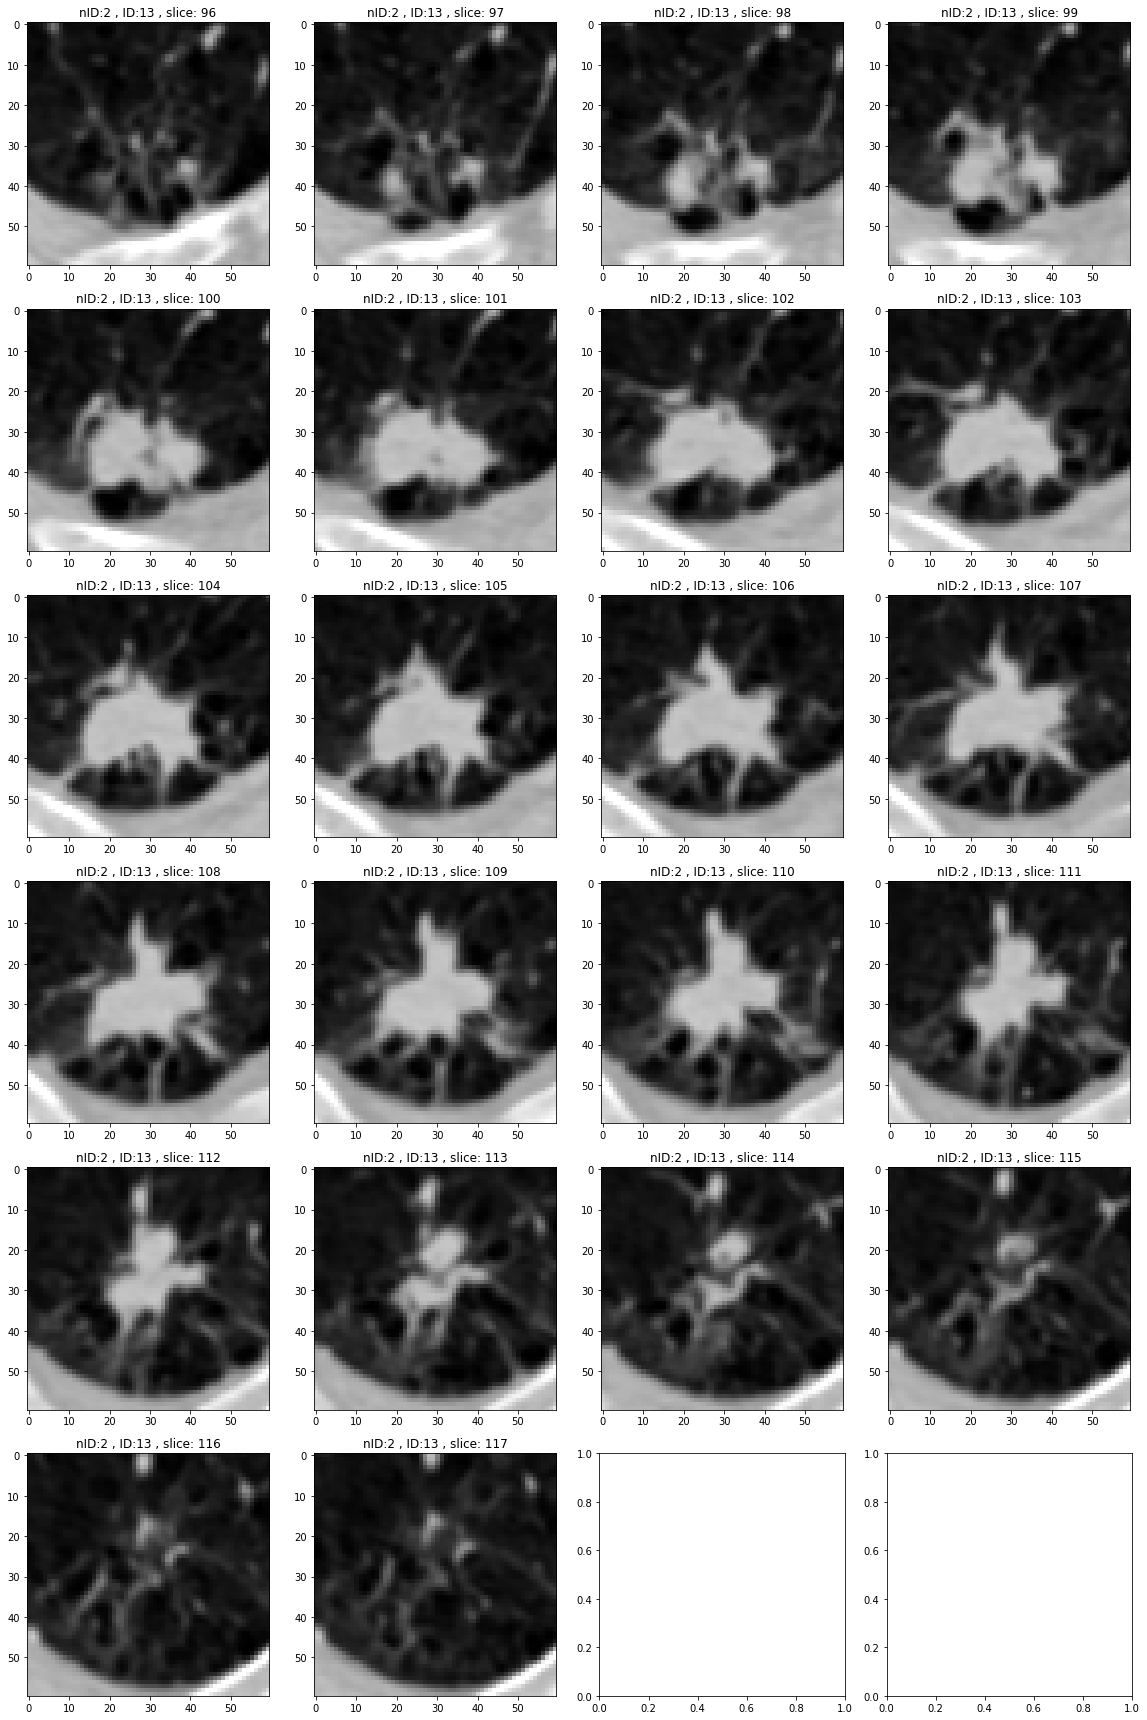

In [14]:
rows, cols = math.ceil(len(nodule_slices)/4), 4  # 计算行列数
print(rows, cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows), facecolor='white')
axes = axes.flatten()
for i,file_path in enumerate(nodule_slices):
    img = np.load(file_path)
    ax = axes[i]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"nID:{file_path.split('nID_')[1].split(',')[0]} , ID:{file_path.split(' ID_')[1].split(',')[0]} , slice: {file_path.split('Z_')[1].split('(')[0]}")
plt.tight_layout()
plt.show();

## 4.准备GCN数据集

把原始数据集转化为适合GCN的数据集，每一行代表结节的一张切片，同一个结节的不同切片有相同的`nID`。

In [7]:
# copy，去掉不相关的数据，最后n=200
newdata = datflag.copy()
# 一个结节转变为多行数据，每行为结节的一个切片
newdata["Z"] = newdata["Zrange"].apply(lambda x: range(x[0],x[1]+1))  # 列表转序列,例：[241,256]→[241,242,...,256]
# 得到新数据
newdata = newdata.explode("Z").reset_index(drop=True)  # 将序列转变为多行  ##explode将列转为行
newdata["Z"] = newdata["Z"].astype(int)  # 处理为数值型变量
newdata

,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,脉管瘤栓,淋巴结转移,flag_1,flag_2,flag_3,flag,Zrange,Zmed,slices,nID
0,7,157,222,241,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
1,7,157,222,242,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
2,7,157,222,243,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
3,7,157,222,244,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
4,7,157,222,245,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10858,635,165,156,183,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482
10859,635,165,156,184,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482
10860,635,165,156,185,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482
10861,635,165,156,186,右肺,中叶,部分实性,腺癌,1.0,1.2,...,无,无,0,0,0,0,"[178, 187]",182,10,482


In [8]:
newdata["flag"].value_counts()

0    6715
1    4148
Name: flag, dtype: int64

In [10]:
# 保存整理好的GCN数据表，用于后面拼接特征矩阵
newdata.to_csv('csv/是否微乳头_GNN.csv', index = False, mode="w+")
newdata.head()

,ID,X,Y,Z,lung,position,Image.type,Pathology,病理分级,Size.cm.,...,脉管瘤栓,淋巴结转移,flag_1,flag_2,flag_3,flag,Zrange,Zmed,slices,nID
0,7,157,222,241,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
1,7,157,222,242,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
2,7,157,222,243,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
3,7,157,222,244,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
4,7,157,222,245,右肺,中叶,纯磨玻璃,MIA,NaN,1.5,...,NaN,NaN,0,0,0,0,"[241, 256]",248,16,0
